In [1]:
import os
import glob
import pickle

import pandas as pd
import numpy as np
from ast import literal_eval

from gensim import corpora, models
from gensim.models.callbacks import PerplexityMetric
from gensim.models.coherencemodel import CoherenceModel

# Косинусная метрика для рассчёта расстояний 
from scipy.spatial.distance import cosine

# Визуализация
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
import seaborn as sns
from wordcloud import WordCloud
import pyLDAvis.gensim

import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

import warnings
warnings.filterwarnings('ignore')

In [2]:
path = r'C:\Users\savintseva\_University\parsing\youtube comments\america latina\comments_al'
path_for_reduced = r'C:\Users\savintseva\_University\parsing\youtube comments\america latina\comments_al\reduced'

In [3]:
all_files = glob.glob(path + "/*.csv")

li = []

for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0, sep='\t')
    li.append(df)

data = pd.concat(li, axis=0, ignore_index=True)
data.head()

Unnamed: 0     music_style               performer  \
0           0  america_latina  aristegui _noticias_mx   
1           1  america_latina  aristegui _noticias_mx   
2           2  america_latina  aristegui _noticias_mx   
3           3  america_latina  aristegui _noticias_mx   
4           4  america_latina  aristegui _noticias_mx   

                                  video_name                  comment_id  \
0  Masacre de Apatzingán #FueronLosFederales  UgwI86rSpj3UuKAh1I54AaABAg   
1  Masacre de Apatzingán #FueronLosFederales  Ugzy5MdNu49XbGK1CIF4AaABAg   
2  Masacre de Apatzingán #FueronLosFederales  UgytT3sb7yJfN30xIg14AaABAg   
3  Masacre de Apatzingán #FueronLosFederales  UgwUhZjnc9hR1s-DcZ14AaABAg   
4  Masacre de Apatzingán #FueronLosFederales  Ugwn1OyEz3gDb6gW-i14AaABAg   

                                 author  \
0                    Leobardo Domínguez   
1  Richard Bolaños Bolaños de la mesero   
2                      Alberto Martinez   
3                         Enrique Muñoz   
4                     Rodrigo Maldonado   

                                                text                  date  \
0     Y todo quedo impune como siempre... 29/04/2020  2020-04-29T19:32:25Z   
1                                          😱😱😱😱😱😱😱😯😯  2020-04-29T16:57:48Z   
2                                           No mames  2020-04-26T23:27:11Z   
3  Y la gente ignorante sigue votando x el PRI no...  2020-04-24T23:59:26Z   
4  ASTA CUANDO VA A HACER SU TRABAJO EL GOBIERNO ...  2020-03-08T00:55:14Z   

   likes                                         clean_text  \
0      0          y todo quedo impune como siempre 29 42 2    
1      1                                                NaN   
2      0                                           no mames   
3      0  y la gente ignorante sigue votando x el pri no...   
4      0  asta cuando va a hacer su trabajo el gobierno ...   

                                                lemm  \
0  ['y', 'todo', 'quedar', 'impune', 'comer', 'si...   
1                                               ['']   
2                                    ['no', 'mamar']   
3  ['y', 'lo', 'gente', 'ignorante', 'seguir', 'v...   
4  ['asta', 'cuando', 'ir', 'a', 'hacer', 'su', '...   

                                        pure_comment  length  
0      ['quedar', 'impune', 'comer', '29', '42', '']       6  
1                                               ['']       1  
2                                          ['mamar']       1  
3  ['gente', 'ignorante', 'seguir', 'votar', 'pri...       8  
4  ['asta', 'gobernar', 'asta', 'comer', 'goberna...       8

In [4]:
del data['Unnamed: 0']
data.rename(columns={"music_style": "country", "performer": "channel"})

country                 channel  \
0       america_latina  aristegui _noticias_mx   
1       america_latina  aristegui _noticias_mx   
2       america_latina  aristegui _noticias_mx   
3       america_latina  aristegui _noticias_mx   
4       america_latina  aristegui _noticias_mx   
...                ...                     ...   
526431  america_latina              rt_espanol   
526432  america_latina              rt_espanol   
526433  america_latina              rt_espanol   
526434  america_latina              rt_espanol   
526435  america_latina              rt_espanol   

                                               video_name  \
0               Masacre de Apatzingán #FueronLosFederales   
1               Masacre de Apatzingán #FueronLosFederales   
2               Masacre de Apatzingán #FueronLosFederales   
3               Masacre de Apatzingán #FueronLosFederales   
4               Masacre de Apatzingán #FueronLosFederales   
...                                                   ...   
526431  DETRÁS DE LA NOTICIA : TERRORISMO EN TODAS SUS...   
526432  DETRÁS DE LA NOTICIA : TERRORISMO EN TODAS SUS...   
526433  DETRÁS DE LA NOTICIA : TERRORISMO EN TODAS SUS...   
526434  DETRÁS DE LA NOTICIA : TERRORISMO EN TODAS SUS...   
526435  DETRÁS DE LA NOTICIA : TERRORISMO EN TODAS SUS...   

                        comment_id                                author  \
0       UgwI86rSpj3UuKAh1I54AaABAg                    Leobardo Domínguez   
1       Ugzy5MdNu49XbGK1CIF4AaABAg  Richard Bolaños Bolaños de la mesero   
2       UgytT3sb7yJfN30xIg14AaABAg                      Alberto Martinez   
3       UgwUhZjnc9hR1s-DcZ14AaABAg                         Enrique Muñoz   
4       Ugwn1OyEz3gDb6gW-i14AaABAg                     Rodrigo Maldonado   
...                            ...                                   ...   
526431  UgzEHbWaUXY1WVh2b8p4AaABAg                            CubaDiario   
526432  UgxquOzcR-CHLmOqWW54AaABAg                          Jacob Sender   
526433  Ugy9t5vXbh5UTukF5Ch4AaABAg                          Jacob Sender   
526434  UgyKLShjhqrn8dKR2pd4AaABAg                          Jacob Sender   
526435  UgzxW3A1O_uB8pKdudB4AaABAg                          ernesto leon   

                                                     text  \
0          Y todo quedo impune como siempre... 29/04/2020   
1                                               😱😱😱😱😱😱😱😯😯   
2                                                No mames   
3       Y la gente ignorante sigue votando x el PRI no...   
4       ASTA CUANDO VA A HACER SU TRABAJO EL GOBIERNO ...   
...                                                   ...   
526431  Así es Lls raices del terror están en el siste...   
526432  @theallmanbrothersmbf sì, sabemos que tiene do...   
526433  @ThePoronpompom pero porsupuesto que coincidim...   
526434  Pedirìa gentilmente a la  señora Golinger, afi...   
526435                                          Excelente   

                            date  likes  \
0           2020-04-29T19:32:25Z      0   
1           2020-04-29T16:57:48Z      1   
2           2020-04-26T23:27:11Z      0   
3           2020-04-24T23:59:26Z      0   
4           2020-03-08T00:55:14Z      0   
...                          ...    ...   
526431  2011-01-30T18:10:48.000Z      0   
526432  2011-01-30T17:43:10.000Z      0   
526433  2011-01-30T17:37:31.000Z      0   
526434  2011-01-30T16:42:48.000Z      0   
526435  2011-01-30T14:54:41.000Z      0   

                                               clean_text  \
0               y todo quedo impune como siempre 29 42 2    
1                                                     NaN   
2                                                no mames   
3       y la gente ignorante sigue votando x el pri no...   
4       asta cuando va a hacer su trabajo el gobierno ...   
...                                                   ...   
526431  as  es lls raices del terror est n en el siste...   
526432  theallmanbrothersmbf s

In [5]:
reduced_data = data[data['length']>1]
print('data shape', data.shape)
print('reduced data shape', reduced_data.shape)

os.chdir(path_for_reduced)
reduced_data.to_csv('reduced_comments.csv')

data = reduced_data #Строим модель на reduced data

data shape (526436, 12)
reduced data shape (502477, 12)


In [6]:
os.chdir(path)

In [7]:
def make_bigrams(text):
    return [bigram_mod[doc] for doc in text]

texts = data.pure_comment.apply(literal_eval)
bigram = models.Phrases(texts, min_count=3, threshold=5)
bigram_mod = models.phrases.Phraser(bigram)

texts = make_bigrams(texts)

2020-05-11 20:00:50,718 : INFO : collecting all words and their counts
2020-05-11 20:00:50,719 : INFO : PROGRESS: at sentence #0, processed 0 words and 0 word types
2020-05-11 20:00:50,904 : INFO : PROGRESS: at sentence #10000, processed 133395 words and 103486 word types
2020-05-11 20:00:51,073 : INFO : PROGRESS: at sentence #20000, processed 259630 words and 166742 word types
2020-05-11 20:00:51,297 : INFO : PROGRESS: at sentence #30000, processed 414215 words and 259061 word types
2020-05-11 20:00:51,529 : INFO : PROGRESS: at sentence #40000, processed 572641 words and 320651 word types
2020-05-11 20:00:51,707 : INFO : PROGRESS: at sentence #50000, processed 695757 words and 320651 word types
2020-05-11 20:00:51,899 : INFO : PROGRESS: at sentence #60000, processed 835531 words and 320651 word types
2020-05-11 20:00:52,106 : INFO : PROGRESS: at sentence #70000, processed 984100 words and 338560 word types
2020-05-11 20:00:52,319 : INFO : PROGRESS: at sentence #80000, processed 112248

In [8]:
dictionary = corpora.Dictionary(texts)
print('Размер словаря до фильтрации: {}'.format(len(dictionary)))
dictionary.filter_extremes(no_below=3, no_above=0.4, keep_n=3*10**6)
print('Размер словаря после фильтрации: {}'.format(len(dictionary)))

with open(r'C:\Users\savintseva\_University\parsing\LATINA_LDA\dictionary.pickle', 'wb') as f:
    pickle.dump(dictionary, f)

2020-05-11 20:02:38,496 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2020-05-11 20:02:38,677 : INFO : adding document #10000 to Dictionary(22736 unique tokens: ['29_42', 'comer', 'quedar_impune', 'darse_contar', 'gente_ignorante']...)
2020-05-11 20:02:38,847 : INFO : adding document #20000 to Dictionary(33352 unique tokens: ['29_42', 'comer', 'quedar_impune', 'darse_contar', 'gente_ignorante']...)
2020-05-11 20:02:39,055 : INFO : adding document #30000 to Dictionary(47582 unique tokens: ['29_42', 'comer', 'quedar_impune', 'darse_contar', 'gente_ignorante']...)
2020-05-11 20:02:39,265 : INFO : adding document #40000 to Dictionary(55459 unique tokens: ['29_42', 'comer', 'quedar_impune', 'darse_contar', 'gente_ignorante']...)
2020-05-11 20:02:39,444 : INFO : adding document #50000 to Dictionary(55459 unique tokens: ['29_42', 'comer', 'quedar_impune', 'darse_contar', 'gente_ignorante']...)
2020-05-11 20:02:39,642 : INFO : adding document #60000 to Dictionary(55459 unique 

2020-05-11 20:02:48,457 : INFO : adding document #500000 to Dictionary(284714 unique tokens: ['29_42', 'comer', 'quedar_impune', 'darse_contar', 'gente_ignorante']...)
2020-05-11 20:02:48,530 : INFO : built Dictionary(284714 unique tokens: ['29_42', 'comer', 'quedar_impune', 'darse_contar', 'gente_ignorante']...) from 502477 documents (total 5472155 corpus positions)


Размер словаря до фильтрации: 284714


2020-05-11 20:02:48,825 : INFO : discarding 182856 tokens: [('divorciarce', 2), ('peludaeso', 2), ('barttletcorrupto', 2), ('lopezelfracasopresidencial', 2), ('desilusionadayo', 2), ('vendesi', 2), ('patasadas', 2), ('hijodesuputamadre', 2), ('ascoson', 2), ('ppder', 2)]...
2020-05-11 20:02:48,826 : INFO : keeping 101858 tokens which were in no less than 3 and no more than 200990 (=40.0%) documents
2020-05-11 20:02:48,987 : INFO : resulting dictionary: Dictionary(101858 unique tokens: ['29_42', 'comer', 'quedar_impune', 'darse_contar', 'gente_ignorante']...)


Размер словаря после фильтрации: 101858


In [9]:
corpus = [dictionary.doc2bow(text) for text in texts]
with open(r'C:\Users\savintseva\_University\parsing\LATINA_LDA\corpus.pickle', 'wb') as f:
    pickle.dump(corpus, f)

In [10]:
# Обучаем модель
np.random.seed(42)

ldamodel_15 = models.ldamodel.LdaModel(corpus, id2word=dictionary, eval_every=20, num_topics=15, passes=4)
ldamodel_15.save(r'C:\Users\savintseva\_University\parsing\LATINA_LDA\ldamodel_15.model')

2020-05-11 20:06:25,094 : INFO : using symmetric alpha at 0.06666666666666667
2020-05-11 20:06:25,096 : INFO : using symmetric eta at 0.06666666666666667
2020-05-11 20:06:25,110 : INFO : using serial LDA version on this node
2020-05-11 20:06:25,269 : INFO : running online (multi-pass) LDA training, 15 topics, 4 passes over the supplied corpus of 502477 documents, updating model once every 2000 documents, evaluating perplexity every 40000 documents, iterating 50x with a convergence threshold of 0.001000
2020-05-11 20:06:25,270 : INFO : PROGRESS: pass 0, at document #2000/502477
2020-05-11 20:06:25,949 : INFO : merging changes from 2000 documents into a model of 502477 documents
2020-05-11 20:06:26,078 : INFO : topic #8 (0.067): 0.013*"mexicano" + 0.009*"gobernar" + 0.009*"parir" + 0.008*"unir" + 0.008*"vivo" + 0.007*"gente" + 0.007*"comer" + 0.007*"est" + 0.006*"justicia" + 0.006*"corrupto"
2020-05-11 20:06:26,079 : INFO : topic #6 (0.067): 0.035*"corrupto" + 0.010*"comer" + 0.010*"pari

2020-05-11 20:06:29,167 : INFO : topic diff=0.079282, rho=0.408248
2020-05-11 20:06:29,169 : INFO : PROGRESS: pass 0, at document #14000/502477
2020-05-11 20:06:29,635 : INFO : merging changes from 2000 documents into a model of 502477 documents
2020-05-11 20:06:29,727 : INFO : topic #0 (0.067): 0.031*"pinchar" + 0.029*"mierda" + 0.019*"as" + 0.018*"autoridad" + 0.017*"comer" + 0.014*"puto" + 0.013*"hijo" + 0.013*"mujer" + 0.012*"est" + 0.011*"derecho"
2020-05-11 20:06:29,729 : INFO : topic #11 (0.067): 0.043*"parir" + 0.027*"comer" + 0.016*"creer" + 0.013*"leer" + 0.012*"gente" + 0.011*"deber" + 0.011*"viejo" + 0.010*"presidente" + 0.009*"pa" + 0.008*"entender"
2020-05-11 20:06:29,731 : INFO : topic #2 (0.067): 0.042*"carmen" + 0.036*"parir" + 0.022*"querer" + 0.019*"perro" + 0.016*"metro_xico" + 0.014*"comer" + 0.012*"reportaje" + 0.010*"apoyar" + 0.010*"est" + 0.010*"mexicano"
2020-05-11 20:06:29,732 : INFO : topic #9 (0.067): 0.025*"aristegui" + 0.024*"maldito" + 0.019*"comer" + 0.

2020-05-11 20:06:33,208 : INFO : topic #0 (0.067): 0.050*"mierda" + 0.047*"pinchar" + 0.037*"pendejo" + 0.030*"puto" + 0.021*"hijo" + 0.021*"joder" + 0.019*"comer" + 0.016*"as" + 0.015*"chingar" + 0.015*"gobernar"
2020-05-11 20:06:33,209 : INFO : topic #6 (0.067): 0.070*"corrupto" + 0.032*"puro" + 0.029*"gente" + 0.022*"verg_enza" + 0.020*"morir" + 0.017*"respetar" + 0.016*"delincuente" + 0.015*"ay" + 0.015*"huevo" + 0.013*"buscar"
2020-05-11 20:06:33,211 : INFO : topic #7 (0.067): 0.029*"madre" + 0.027*"comer" + 0.020*"periodista" + 0.018*"nieto" + 0.016*"pendejo" + 0.016*"parir" + 0.016*"hijo_puto" + 0.014*"existir" + 0.014*"enrique_pe" + 0.013*"metro"
2020-05-11 20:06:33,212 : INFO : topic #5 (0.067): 0.059*"mexico" + 0.052*"pe_nieto" + 0.043*"jajaja" + 0.028*"presidente" + 0.020*"ratero" + 0.020*"orar" + 0.017*"ke" + 0.016*"faltar" + 0.015*"familia" + 0.014*"criminal"
2020-05-11 20:06:33,214 : INFO : topic #1 (0.067): 0.030*"parir" + 0.030*"gobernar" + 0.020*"comer" + 0.018*"nadar"

2020-05-11 20:06:36,591 : INFO : topic #4 (0.067): 0.063*"pri" + 0.031*"qu" + 0.024*"comer" + 0.022*"parir" + 0.021*"gaviota" + 0.020*"mujer" + 0.019*"rata" + 0.015*"nico" + 0.012*"gobernar" + 0.010*"penar_nieto"
2020-05-11 20:06:36,592 : INFO : topic #8 (0.067): 0.029*"votar" + 0.027*"vivo" + 0.021*"amlo" + 0.019*"18" + 0.018*"mexicano" + 0.015*"unir" + 0.014*"palabra" + 0.013*"litro" + 0.013*"mexico" + 0.013*"bla_bla"
2020-05-11 20:06:36,594 : INFO : topic #0 (0.067): 0.051*"mierda" + 0.046*"pinchar" + 0.036*"pendejo" + 0.030*"puto" + 0.021*"hijo" + 0.017*"gobernar" + 0.016*"comer" + 0.016*"democracia" + 0.015*"chingar" + 0.015*"joder"
2020-05-11 20:06:36,596 : INFO : topic #2 (0.067): 0.039*"parir" + 0.022*"carmen" + 0.022*"querer" + 0.019*"comer" + 0.015*"televisar" + 0.014*"perro" + 0.013*"metro_xico" + 0.012*"tica" + 0.012*"est" + 0.011*"mexicano"
2020-05-11 20:06:36,604 : INFO : topic diff=0.051240, rho=0.229416
2020-05-11 20:06:37,255 : INFO : -13.720 per-word bound, 13497.4 pe

2020-05-11 20:06:40,396 : INFO : topic #12 (0.067): 0.033*"comer" + 0.020*"parir" + 0.015*"est" + 0.013*"preguntar" + 0.013*"metro" + 0.013*"pobre" + 0.012*"detener" + 0.011*"qu" + 0.010*"grande" + 0.010*"pasar"
2020-05-11 20:06:40,398 : INFO : topic #11 (0.067): 0.051*"parir" + 0.035*"creer" + 0.033*"comer" + 0.016*"deber" + 0.013*"gente" + 0.013*"leer" + 0.012*"viejo" + 0.011*"entender" + 0.011*"casar" + 0.010*"mandar"
2020-05-11 20:06:40,400 : INFO : topic #7 (0.067): 0.038*"periodista" + 0.026*"carmen_aristegui" + 0.025*"comer" + 0.025*"carmen" + 0.025*"aristegui" + 0.024*"madre" + 0.020*"nieto" + 0.018*"hijo_puto" + 0.016*"felicidad" + 0.014*"parir"
2020-05-11 20:06:40,402 : INFO : topic #6 (0.067): 0.083*"corrupto" + 0.037*"puro" + 0.027*"polic_as" + 0.027*"polic" + 0.022*"prian" + 0.021*"verg_enza" + 0.021*"gente" + 0.021*"respetar" + 0.020*"huevo" + 0.018*"delincuente"
2020-05-11 20:06:40,411 : INFO : topic diff=0.034548, rho=0.200000
2020-05-11 20:06:40,414 : INFO : PROGRESS: 

2020-05-11 20:06:43,628 : INFO : topic #10 (0.067): 0.036*"parir" + 0.022*"comer" + 0.019*"querer" + 0.019*"nadar" + 0.016*"burro" + 0.013*"burlar" + 0.013*"mundo" + 0.010*"dudar" + 0.010*"gobernar" + 0.010*"acabar"
2020-05-11 20:06:43,630 : INFO : topic #7 (0.067): 0.035*"madre" + 0.034*"periodista" + 0.026*"comer" + 0.025*"aristegui" + 0.022*"nieto" + 0.020*"hijo_puto" + 0.018*"carmen_aristegui" + 0.017*"felicidad" + 0.016*"carmen" + 0.016*"existir"
2020-05-11 20:06:43,639 : INFO : topic diff=0.021434, rho=0.179605
2020-05-11 20:06:43,641 : INFO : PROGRESS: pass 0, at document #64000/502477
2020-05-11 20:06:44,067 : INFO : merging changes from 2000 documents into a model of 502477 documents
2020-05-11 20:06:44,159 : INFO : topic #3 (0.067): 0.055*"parir" + 0.044*"comer" + 0.035*"metro_xico" + 0.023*"poblar" + 0.022*"gobernar" + 0.017*"mexicano" + 0.015*"gente" + 0.013*"pa" + 0.012*"as" + 0.012*"dejar"
2020-05-11 20:06:44,161 : INFO : topic #6 (0.067): 0.089*"corrupto" + 0.037*"puro" 

2020-05-11 20:06:46,654 : INFO : topic #4 (0.067): 0.057*"pri" + 0.045*"mujer" + 0.039*"qu" + 0.027*"rata" + 0.024*"nico" + 0.022*"parir" + 0.020*"comer" + 0.015*"sacar" + 0.012*"gobernar" + 0.011*"monedar"
2020-05-11 20:06:46,662 : INFO : topic diff=0.025693, rho=0.164399
2020-05-11 20:06:46,665 : INFO : PROGRESS: pass 0, at document #76000/502477
2020-05-11 20:06:47,026 : INFO : merging changes from 2000 documents into a model of 502477 documents
2020-05-11 20:06:47,124 : INFO : topic #12 (0.067): 0.033*"comer" + 0.026*"parir" + 0.016*"pasar" + 0.015*"est" + 0.014*"salir" + 0.014*"pobre" + 0.012*"metro" + 0.011*"preguntar" + 0.010*"grande" + 0.010*"entrar"
2020-05-11 20:06:47,126 : INFO : topic #5 (0.067): 0.065*"mexico" + 0.050*"jajaja" + 0.044*"orar" + 0.038*"pe_nieto" + 0.030*"hermoso" + 0.026*"presidente" + 0.023*"hablar" + 0.018*"ratero" + 0.016*"ojo" + 0.015*"criminal"
2020-05-11 20:06:47,128 : INFO : topic #10 (0.067): 0.039*"parir" + 0.025*"nadar" + 0.021*"comer" + 0.020*"ben

2020-05-11 20:06:50,269 : INFO : topic diff=0.019784, rho=0.152499
2020-05-11 20:06:50,272 : INFO : PROGRESS: pass 0, at document #88000/502477
2020-05-11 20:06:50,691 : INFO : merging changes from 2000 documents into a model of 502477 documents
2020-05-11 20:06:50,785 : INFO : topic #5 (0.067): 0.039*"jajaja" + 0.039*"orar" + 0.036*"mexico" + 0.030*"hablar" + 0.026*"ke" + 0.022*"hombre" + 0.021*"hermoso" + 0.020*"criminal" + 0.019*"colombiano" + 0.018*"hermano"
2020-05-11 20:06:50,787 : INFO : topic #13 (0.067): 0.056*"castrar" + 0.048*"dictadura" + 0.029*"est" + 0.018*"comer" + 0.017*"parir" + 0.016*"asesino" + 0.016*"jajajaja" + 0.014*"basura" + 0.013*"pensar" + 0.012*"cualquiera"
2020-05-11 20:06:50,789 : INFO : topic #0 (0.067): 0.083*"mierda" + 0.031*"pendejo" + 0.030*"hijo" + 0.028*"joder" + 0.025*"matar" + 0.024*"puto" + 0.020*"comer" + 0.019*"miedo" + 0.015*"bloquear" + 0.015*"animal"
2020-05-11 20:06:50,792 : INFO : topic #14 (0.067): 0.052*"metro" + 0.040*"parir" + 0.029*"pa

2020-05-11 20:06:53,711 : INFO : topic #5 (0.067): 0.031*"orar" + 0.029*"jajaja" + 0.026*"mexico" + 0.025*"hermoso" + 0.024*"to" + 0.023*"ke" + 0.023*"hablar" + 0.023*"presidente" + 0.022*"hombre" + 0.022*"hermano"
2020-05-11 20:06:53,713 : INFO : topic #12 (0.067): 0.103*"cuba" + 0.079*"cubano" + 0.032*"comer" + 0.031*"parir" + 0.016*"metro" + 0.016*"pobre" + 0.014*"entrar" + 0.014*"est" + 0.013*"pasar" + 0.012*"eeuu"
2020-05-11 20:06:53,715 : INFO : topic #0 (0.067): 0.066*"mierda" + 0.045*"animal" + 0.034*"matar" + 0.029*"hijo" + 0.023*"joder" + 0.023*"humanar" + 0.022*"comer" + 0.019*"naturaleza" + 0.018*"pendejo" + 0.017*"puto"
2020-05-11 20:06:53,717 : INFO : topic #14 (0.067): 0.065*"metro" + 0.039*"parir" + 0.039*"est" + 0.029*"pa" + 0.026*"comer" + 0.020*"as" + 0.018*"venir" + 0.013*"libertar" + 0.012*"trump" + 0.012*"planeta"
2020-05-11 20:06:53,726 : INFO : topic diff=0.023855, rho=0.141421
2020-05-11 20:06:53,728 : INFO : PROGRESS: pass 0, at document #102000/502477
2020-05

2020-05-11 20:06:56,755 : INFO : topic #0 (0.067): 0.056*"matar" + 0.047*"animal" + 0.046*"mierda" + 0.031*"hijo" + 0.024*"joder" + 0.024*"comer" + 0.019*"humanar" + 0.017*"miedo" + 0.015*"cagar" + 0.015*"ojalar"
2020-05-11 20:06:56,757 : INFO : topic #4 (0.067): 0.065*"qu" + 0.035*"rata" + 0.030*"nico" + 0.025*"mujer" + 0.021*"terrorista" + 0.021*"muerte" + 0.021*"parir" + 0.020*"sacar" + 0.018*"comer" + 0.016*"asesinar"
2020-05-11 20:06:56,765 : INFO : topic diff=0.027751, rho=0.133631
2020-05-11 20:06:56,768 : INFO : PROGRESS: pass 0, at document #114000/502477
2020-05-11 20:06:57,149 : INFO : merging changes from 2000 documents into a model of 502477 documents
2020-05-11 20:06:57,243 : INFO : topic #7 (0.067): 0.040*"amar" + 0.037*"librar" + 0.031*"muerto" + 0.025*"periodista" + 0.024*"mesar" + 0.022*"mil" + 0.020*"existir" + 0.019*"ac" + 0.017*"comer" + 0.017*"excelente"
2020-05-11 20:06:57,244 : INFO : topic #0 (0.067): 0.057*"matar" + 0.044*"animal" + 0.042*"mierda" + 0.030*"hij

2020-05-11 20:07:00,163 : INFO : topic #8 (0.067): 0.045*"vivo" + 0.033*"unir" + 0.025*"votar" + 0.023*"litro" + 0.021*"cabeza" + 0.020*"caro" + 0.019*"mentira" + 0.019*"comprar" + 0.018*"palabra" + 0.017*"presidente"
2020-05-11 20:07:00,171 : INFO : topic diff=0.013772, rho=0.127000
2020-05-11 20:07:00,173 : INFO : PROGRESS: pass 0, at document #126000/502477
2020-05-11 20:07:00,546 : INFO : merging changes from 2000 documents into a model of 502477 documents
2020-05-11 20:07:00,640 : INFO : topic #1 (0.067): 0.078*"venezuela" + 0.075*"dios" + 0.035*"chino" + 0.030*"venezolano" + 0.025*"parir" + 0.024*"gracia" + 0.023*"vida" + 0.019*"chile" + 0.018*"comer" + 0.017*"madurar"
2020-05-11 20:07:00,642 : INFO : topic #2 (0.067): 0.062*"virus" + 0.033*"parir" + 0.027*"humano" + 0.017*"comer" + 0.016*"millón" + 0.016*"querer" + 0.012*"renunciar" + 0.012*"prensar" + 0.011*"realidad" + 0.010*"the"
2020-05-11 20:07:00,644 : INFO : topic #11 (0.067): 0.053*"parir" + 0.038*"creer" + 0.036*"comer"

2020-05-11 20:07:03,075 : INFO : topic diff=0.016248, rho=0.121268
2020-05-11 20:07:03,077 : INFO : PROGRESS: pass 0, at document #138000/502477
2020-05-11 20:07:03,446 : INFO : merging changes from 2000 documents into a model of 502477 documents
2020-05-11 20:07:03,538 : INFO : topic #10 (0.067): 0.055*"mundo" + 0.032*"dictador" + 0.029*"parir" + 0.026*"querer" + 0.024*"acabar" + 0.021*"mundial" + 0.021*"comer" + 0.020*"nadar" + 0.018*"necesitar" + 0.018*"padre"
2020-05-11 20:07:03,540 : INFO : topic #14 (0.067): 0.067*"metro" + 0.055*"est" + 0.049*"trump" + 0.038*"pa" + 0.032*"parir" + 0.021*"guerra" + 0.021*"venir" + 0.020*"comer" + 0.017*"militar" + 0.017*"as"
2020-05-11 20:07:03,543 : INFO : topic #9 (0.067): 0.160*"madurar" + 0.036*"gustar" + 0.033*"or" + 0.024*"video" + 0.022*"defender" + 0.021*"noticiar" + 0.021*"caer" + 0.020*"maldito" + 0.017*"comer" + 0.016*"odiar"
2020-05-11 20:07:03,545 : INFO : topic #8 (0.067): 0.043*"vivo" + 0.029*"unir" + 0.027*"litro" + 0.025*"traidor

2020-05-11 20:07:06,499 : INFO : topic #5 (0.067): 0.106*"colombiano" + 0.079*"presidente" + 0.049*"orar" + 0.038*"colombia" + 0.030*"llegar" + 0.030*"jajaja" + 0.028*"alcaldesa" + 0.023*"mexico" + 0.021*"hermoso" + 0.019*"familia"
2020-05-11 20:07:06,501 : INFO : topic #9 (0.067): 0.100*"madurar" + 0.050*"or" + 0.036*"gustar" + 0.026*"volver" + 0.025*"noticiar" + 0.023*"video" + 0.019*"crisis" + 0.018*"maldito" + 0.018*"comer" + 0.017*"temer"
2020-05-11 20:07:06,503 : INFO : topic #8 (0.067): 0.046*"vivo" + 0.030*"litro" + 0.029*"votar" + 0.027*"comprar" + 0.026*"mentira" + 0.024*"unir" + 0.023*"caro" + 0.021*"llorar" + 0.018*"palabra" + 0.016*"presidente"
2020-05-11 20:07:06,505 : INFO : topic #4 (0.067): 0.094*"qu" + 0.060*"mujer" + 0.035*"nico" + 0.031*"sacar" + 0.029*"muerte" + 0.022*"parir" + 0.020*"rata" + 0.017*"asesinar" + 0.015*"comer" + 0.014*"terrorista"
2020-05-11 20:07:06,513 : INFO : topic diff=0.016455, rho=0.115470
2020-05-11 20:07:06,516 : INFO : PROGRESS: pass 0, at 

2020-05-11 20:07:09,944 : INFO : topic #6 (0.067): 0.067*"corrupto" + 0.055*"morir" + 0.047*"gente" + 0.034*"delincuente" + 0.034*"polic" + 0.028*"forzar" + 0.028*"triste" + 0.027*"santo" + 0.026*"tocar" + 0.023*"verg_enza"
2020-05-11 20:07:09,946 : INFO : topic #11 (0.067): 0.060*"parir" + 0.038*"creer" + 0.037*"comer" + 0.031*"ayudar" + 0.025*"pagar" + 0.024*"casar" + 0.021*"gente" + 0.019*"personar" + 0.019*"entender" + 0.018*"deber"
2020-05-11 20:07:09,948 : INFO : topic #1 (0.067): 0.088*"colombia" + 0.070*"dios" + 0.064*"venezuela" + 0.038*"gracia" + 0.031*"venezolano" + 0.027*"parir" + 0.019*"dios_bendecir" + 0.018*"favor" + 0.018*"vida" + 0.017*"comer"
2020-05-11 20:07:09,956 : INFO : topic diff=0.015767, rho=0.111111
2020-05-11 20:07:09,958 : INFO : PROGRESS: pass 0, at document #164000/502477
2020-05-11 20:07:10,295 : INFO : merging changes from 2000 documents into a model of 502477 documents
2020-05-11 20:07:10,389 : INFO : topic #7 (0.067): 0.053*"amar" + 0.046*"periodista"

2020-05-11 20:07:12,698 : INFO : topic #6 (0.067): 0.067*"corrupto" + 0.056*"gente" + 0.052*"morir" + 0.039*"delincuente" + 0.038*"santo" + 0.034*"tipo" + 0.030*"verg_enza" + 0.027*"pobre" + 0.027*"polic" + 0.021*"triste"
2020-05-11 20:07:12,699 : INFO : topic #5 (0.067): 0.084*"colombiano" + 0.062*"presidente" + 0.052*"jajaja" + 0.048*"hablar" + 0.042*"colombia" + 0.042*"preso" + 0.033*"orar" + 0.029*"justicia" + 0.024*"paz" + 0.024*"llegar"
2020-05-11 20:07:12,708 : INFO : topic diff=0.017796, rho=0.107211
2020-05-11 20:07:12,710 : INFO : PROGRESS: pass 0, at document #176000/502477
2020-05-11 20:07:13,067 : INFO : merging changes from 2000 documents into a model of 502477 documents
2020-05-11 20:07:13,161 : INFO : topic #12 (0.067): 0.030*"comer" + 0.029*"grande" + 0.028*"parir" + 0.019*"metro" + 0.017*"entrar" + 0.017*"est" + 0.013*"preguntar" + 0.013*"payaso" + 0.012*"pobre" + 0.012*"causar"
2020-05-11 20:07:13,163 : INFO : topic #5 (0.067): 0.077*"colombiano" + 0.069*"presidente"

2020-05-11 20:07:15,530 : INFO : topic #11 (0.067): 0.057*"parir" + 0.043*"creer" + 0.041*"comer" + 0.032*"pagar" + 0.025*"gente" + 0.022*"entender" + 0.020*"viejo" + 0.020*"ayudar" + 0.019*"casar" + 0.018*"nadar"
2020-05-11 20:07:15,538 : INFO : topic diff=0.009000, rho=0.103695
2020-05-11 20:07:15,540 : INFO : PROGRESS: pass 0, at document #188000/502477
2020-05-11 20:07:15,896 : INFO : merging changes from 2000 documents into a model of 502477 documents
2020-05-11 20:07:15,989 : INFO : topic #4 (0.067): 0.086*"qu" + 0.044*"mujer" + 0.041*"rata" + 0.033*"sacar" + 0.026*"nico" + 0.022*"cristino" + 0.020*"muerte" + 0.019*"parir" + 0.018*"robar" + 0.018*"golpe"
2020-05-11 20:07:15,991 : INFO : topic #6 (0.067): 0.063*"corrupto" + 0.062*"morir" + 0.060*"gente" + 0.041*"tipo" + 0.040*"delincuente" + 0.035*"pobre" + 0.032*"verg_enza" + 0.022*"triste" + 0.022*"santo" + 0.018*"meter"
2020-05-11 20:07:15,993 : INFO : topic #11 (0.067): 0.056*"parir" + 0.043*"creer" + 0.041*"comer" + 0.030*"pa

2020-05-11 20:07:18,894 : INFO : -15.202 per-word bound, 37693.1 perplexity estimate based on a held-out corpus of 2000 documents with 24234 words
2020-05-11 20:07:18,895 : INFO : PROGRESS: pass 0, at document #200000/502477
2020-05-11 20:07:19,261 : INFO : merging changes from 2000 documents into a model of 502477 documents
2020-05-11 20:07:19,355 : INFO : topic #9 (0.067): 0.050*"volver" + 0.035*"gustar" + 0.028*"temer" + 0.027*"defender" + 0.027*"juez" + 0.025*"or" + 0.023*"perder" + 0.022*"noticiar" + 0.019*"odiar" + 0.019*"acordar"
2020-05-11 20:07:19,356 : INFO : topic #5 (0.067): 0.097*"presidente" + 0.071*"hablar" + 0.057*"preso" + 0.053*"jajaja" + 0.036*"justicia" + 0.033*"orar" + 0.025*"colombiano" + 0.021*"llegar" + 0.018*"hermano" + 0.017*"página"
2020-05-11 20:07:19,358 : INFO : topic #7 (0.067): 0.171*"periodista" + 0.032*"hijo_puto" + 0.030*"muerto" + 0.028*"periodismo" + 0.028*"ac" + 0.024*"librar" + 0.023*"mesar" + 0.022*"amar" + 0.022*"mil" + 0.019*"existir"
2020-05-1

2020-05-11 20:07:22,068 : INFO : merging changes from 2000 documents into a model of 502477 documents
2020-05-11 20:07:22,162 : INFO : topic #11 (0.067): 0.054*"parir" + 0.042*"comer" + 0.041*"creer" + 0.034*"pagar" + 0.024*"viejo" + 0.022*"gente" + 0.022*"entender" + 0.021*"nadar" + 0.020*"do" + 0.017*"ayudar"
2020-05-11 20:07:22,164 : INFO : topic #2 (0.067): 0.030*"mirar" + 0.028*"parir" + 0.028*"virus" + 0.026*"millón" + 0.020*"sobrar" + 0.019*"aguantar" + 0.018*"andar" + 0.016*"comer" + 0.015*"cuarentena" + 0.013*"dato"
2020-05-11 20:07:22,166 : INFO : topic #6 (0.067): 0.076*"corrupto" + 0.065*"gente" + 0.055*"tipo" + 0.044*"morir" + 0.043*"delincuente" + 0.038*"pobre" + 0.034*"verg_enza" + 0.019*"politicos" + 0.019*"meter" + 0.015*"mafia"
2020-05-11 20:07:22,168 : INFO : topic #0 (0.067): 0.103*"mierda" + 0.052*"hijo" + 0.036*"matar" + 0.034*"cagar" + 0.030*"joder" + 0.030*"puto" + 0.026*"encimar" + 0.026*"comer" + 0.020*"deuda" + 0.017*"democracia"
2020-05-11 20:07:22,171 : INF

2020-05-11 20:07:24,918 : INFO : topic #12 (0.067): 0.028*"comer" + 0.027*"grande" + 0.027*"parir" + 0.017*"metro" + 0.016*"causar" + 0.015*"est" + 0.015*"entrar" + 0.012*"preguntar" + 0.012*"eeuu" + 0.011*"rico"
2020-05-11 20:07:24,920 : INFO : topic #6 (0.067): 0.060*"gente" + 0.058*"corrupto" + 0.054*"forzar" + 0.053*"delincuente" + 0.051*"morir" + 0.036*"tipo" + 0.032*"pobre" + 0.026*"verg_enza" + 0.022*"puro" + 0.020*"triste"
2020-05-11 20:07:24,922 : INFO : topic #1 (0.067): 0.126*"argentino" + 0.070*"dios" + 0.053*"chile" + 0.029*"gracia" + 0.023*"venezuela" + 0.023*"parir" + 0.020*"comer" + 0.019*"escuchar" + 0.018*"favor" + 0.017*"parecer"
2020-05-11 20:07:24,924 : INFO : topic #10 (0.067): 0.108*"majul" + 0.093*"macri" + 0.035*"sos" + 0.031*"mundo" + 0.024*"parir" + 0.023*"programar" + 0.022*"comer" + 0.018*"mediar" + 0.017*"querer" + 0.015*"nadar"
2020-05-11 20:07:24,933 : INFO : topic diff=0.012773, rho=0.094491
2020-05-11 20:07:24,935 : INFO : PROGRESS: pass 0, at document

2020-05-11 20:07:27,613 : INFO : topic #4 (0.067): 0.094*"qu" + 0.049*"mujer" + 0.035*"sacar" + 0.034*"cristino" + 0.027*"rata" + 0.025*"nico" + 0.021*"muerte" + 0.021*"asesinar" + 0.019*"robar" + 0.016*"parir"
2020-05-11 20:07:27,615 : INFO : topic #13 (0.067): 0.039*"ganar" + 0.039*"comunista" + 0.027*"basura" + 0.025*"asco" + 0.023*"ah" + 0.020*"ignorante" + 0.019*"jajajaja" + 0.019*"deber_an" + 0.018*"jaja" + 0.017*"amigo"
2020-05-11 20:07:27,621 : INFO : topic diff=0.015484, rho=0.092057
2020-05-11 20:07:27,624 : INFO : PROGRESS: pass 0, at document #238000/502477
2020-05-11 20:07:28,002 : INFO : merging changes from 2000 documents into a model of 502477 documents
2020-05-11 20:07:28,096 : INFO : topic #8 (0.067): 0.054*"chileno" + 0.042*"llorar" + 0.037*"vivo" + 0.035*"votar" + 0.034*"mentira" + 0.033*"caro" + 0.030*"litro" + 0.017*"ladrón" + 0.016*"cabeza" + 0.016*"comprar"
2020-05-11 20:07:28,098 : INFO : topic #0 (0.067): 0.072*"mierda" + 0.066*"matar" + 0.039*"hijo" + 0.033*"

2020-05-11 20:07:30,780 : INFO : topic #4 (0.067): 0.106*"qu" + 0.042*"mujer" + 0.032*"sacar" + 0.029*"muerte" + 0.025*"terrorista" + 0.024*"asesinar" + 0.023*"nico" + 0.021*"cristino" + 0.020*"rata" + 0.016*"parir"
2020-05-11 20:07:30,787 : INFO : topic diff=0.014001, rho=0.089803
2020-05-11 20:07:30,790 : INFO : PROGRESS: pass 0, at document #250000/502477
2020-05-11 20:07:31,113 : INFO : merging changes from 2000 documents into a model of 502477 documents
2020-05-11 20:07:31,206 : INFO : topic #8 (0.067): 0.040*"amlo" + 0.038*"vivo" + 0.033*"chileno" + 0.030*"llorar" + 0.030*"litro" + 0.030*"mentira" + 0.029*"caro" + 0.028*"votar" + 0.025*"unir" + 0.017*"cabeza"
2020-05-11 20:07:31,208 : INFO : topic #13 (0.067): 0.036*"comunista" + 0.035*"ganar" + 0.025*"ah" + 0.023*"jajajaja" + 0.021*"basura" + 0.021*"deber_an" + 0.020*"jaja" + 0.019*"amigo" + 0.018*"ignorante" + 0.016*"asesino"
2020-05-11 20:07:31,211 : INFO : topic #6 (0.067): 0.085*"morir" + 0.054*"gente" + 0.050*"forzar" + 0.0

2020-05-11 20:07:33,490 : INFO : PROGRESS: pass 0, at document #262000/502477
2020-05-11 20:07:33,831 : INFO : merging changes from 2000 documents into a model of 502477 documents
2020-05-11 20:07:33,926 : INFO : topic #7 (0.067): 0.047*"periodista" + 0.045*"librar" + 0.036*"madre" + 0.033*"amar" + 0.031*"mil" + 0.030*"hora" + 0.028*"muerto" + 0.019*"ac" + 0.019*"feliz" + 0.018*"existir"
2020-05-11 20:07:33,927 : INFO : topic #2 (0.067): 0.042*"virus" + 0.032*"andar" + 0.031*"millón" + 0.027*"parir" + 0.024*"avi" + 0.024*"humano" + 0.021*"mirar" + 0.015*"renunciar" + 0.013*"comer" + 0.011*"sobrar"
2020-05-11 20:07:33,929 : INFO : topic #4 (0.067): 0.094*"qu" + 0.032*"obrador" + 0.029*"mujer" + 0.028*"sacar" + 0.026*"golpe" + 0.025*"rata" + 0.023*"regresar" + 0.023*"muerte" + 0.022*"asesinar" + 0.021*"robar"
2020-05-11 20:07:33,931 : INFO : topic #9 (0.067): 0.049*"or" + 0.040*"gustar" + 0.036*"maldito" + 0.035*"noticiar" + 0.034*"madurar" + 0.031*"volver" + 0.029*"defender" + 0.027*"ca

2020-05-11 20:07:36,676 : INFO : topic #2 (0.067): 0.060*"virus" + 0.034*"andar" + 0.025*"parir" + 0.024*"millón" + 0.020*"humano" + 0.018*"mirar" + 0.016*"avi" + 0.014*"doctorar" + 0.013*"comer" + 0.013*"cuarentena"
2020-05-11 20:07:36,678 : INFO : topic #14 (0.067): 0.095*"metro" + 0.082*"est" + 0.038*"pa" + 0.029*"as" + 0.029*"parir" + 0.028*"trump" + 0.025*"venir" + 0.016*"comer" + 0.016*"querer" + 0.012*"guerra"
2020-05-11 20:07:36,680 : INFO : topic #0 (0.067): 0.083*"matar" + 0.042*"hijo" + 0.033*"mamar" + 0.026*"culpar" + 0.023*"miedo" + 0.022*"comer" + 0.022*"ojalar" + 0.020*"ojal" + 0.019*"alguien" + 0.019*"joder"
2020-05-11 20:07:36,682 : INFO : topic #12 (0.067): 0.027*"parir" + 0.026*"comer" + 0.021*"grande" + 0.019*"preguntar" + 0.019*"contagiar" + 0.019*"entrar" + 0.018*"narrar" + 0.018*"metro" + 0.017*"eeuu" + 0.016*"est"
2020-05-11 20:07:36,689 : INFO : topic diff=0.012805, rho=0.085436
2020-05-11 20:07:36,692 : INFO : PROGRESS: pass 0, at document #276000/502477
2020-

2020-05-11 20:07:40,039 : INFO : topic #12 (0.067): 0.039*"contagiar" + 0.026*"parir" + 0.026*"comer" + 0.025*"preguntar" + 0.021*"metro" + 0.021*"entrar" + 0.020*"est" + 0.018*"informaci" + 0.016*"grande" + 0.015*"personar"
2020-05-11 20:07:40,041 : INFO : topic #9 (0.067): 0.067*"or" + 0.056*"noticiar" + 0.039*"gustar" + 0.030*"maldito" + 0.025*"volver" + 0.021*"comentario" + 0.021*"caer" + 0.019*"perder" + 0.017*"defender" + 0.016*"comer"
2020-05-11 20:07:40,043 : INFO : topic #0 (0.067): 0.092*"matar" + 0.048*"hijo" + 0.036*"mamar" + 0.032*"culpar" + 0.025*"miedo" + 0.023*"comer" + 0.021*"ojal" + 0.021*"ojalar" + 0.020*"alguien" + 0.018*"enfermar"
2020-05-11 20:07:40,051 : INFO : topic diff=0.009461, rho=0.083624
2020-05-11 20:07:40,054 : INFO : PROGRESS: pass 0, at document #288000/502477
2020-05-11 20:07:40,396 : INFO : merging changes from 2000 documents into a model of 502477 documents
2020-05-11 20:07:40,490 : INFO : topic #7 (0.067): 0.060*"muerto" + 0.038*"madre" + 0.034*"ex

2020-05-11 20:07:42,911 : INFO : topic #9 (0.067): 0.088*"or" + 0.061*"noticiar" + 0.038*"gustar" + 0.026*"maldito" + 0.025*"caer" + 0.024*"volver" + 0.021*"defender" + 0.021*"comentario" + 0.018*"perder" + 0.018*"mo"
2020-05-11 20:07:42,919 : INFO : topic diff=0.007934, rho=0.081923
2020-05-11 20:07:42,921 : INFO : PROGRESS: pass 0, at document #300000/502477
2020-05-11 20:07:43,273 : INFO : merging changes from 2000 documents into a model of 502477 documents
2020-05-11 20:07:43,366 : INFO : topic #5 (0.067): 0.109*"mexico" + 0.069*"presidente" + 0.047*"orar" + 0.046*"jajaja" + 0.040*"hablar" + 0.031*"llegar" + 0.029*"familia" + 0.026*"ke" + 0.020*"hombre" + 0.018*"paso"
2020-05-11 20:07:43,368 : INFO : topic #6 (0.067): 0.120*"morir" + 0.104*"gente" + 0.036*"puro" + 0.035*"pobre" + 0.029*"corrupto" + 0.028*"ay" + 0.027*"respetar" + 0.026*"ignorancia" + 0.023*"tipo" + 0.021*"familiar"
2020-05-11 20:07:43,371 : INFO : topic #12 (0.067): 0.043*"contagiar" + 0.026*"parir" + 0.026*"comer"

2020-05-11 20:07:45,735 : INFO : topic diff=0.007301, rho=0.080322
2020-05-11 20:07:45,737 : INFO : PROGRESS: pass 0, at document #312000/502477
2020-05-11 20:07:46,091 : INFO : merging changes from 2000 documents into a model of 502477 documents
2020-05-11 20:07:46,185 : INFO : topic #2 (0.067): 0.095*"virus" + 0.040*"andar" + 0.033*"cuarentena" + 0.024*"parir" + 0.023*"mes" + 0.021*"callar" + 0.018*"doctorar" + 0.018*"semana" + 0.016*"dato" + 0.015*"comer"
2020-05-11 20:07:46,187 : INFO : topic #6 (0.067): 0.119*"morir" + 0.107*"gente" + 0.039*"pobre" + 0.036*"puro" + 0.033*"respetar" + 0.032*"ay" + 0.025*"corrupto" + 0.023*"ignorancia" + 0.022*"tipo" + 0.018*"familiar"
2020-05-11 20:07:46,189 : INFO : topic #7 (0.067): 0.053*"muerto" + 0.040*"madre" + 0.035*"mil" + 0.033*"existir" + 0.030*"hora" + 0.029*"periodista" + 0.027*"enfermo" + 0.025*"necesidad" + 0.025*"mesar" + 0.023*"equipar"
2020-05-11 20:07:46,192 : INFO : topic #10 (0.067): 0.048*"acabar" + 0.039*"mundo" + 0.030*"repor

2020-05-11 20:07:49,086 : INFO : PROGRESS: pass 0, at document #324000/502477
2020-05-11 20:07:49,437 : INFO : merging changes from 2000 documents into a model of 502477 documents
2020-05-11 20:07:49,531 : INFO : topic #1 (0.067): 0.069*"dios" + 0.053*"coronavirus" + 0.051*"gracia" + 0.048*"chino" + 0.033*"favor" + 0.026*"parir" + 0.025*"vida" + 0.022*"mentir" + 0.021*"escuchar" + 0.021*"apoyar"
2020-05-11 20:07:49,533 : INFO : topic #0 (0.067): 0.050*"matar" + 0.046*"mamar" + 0.043*"hijo" + 0.037*"miedo" + 0.031*"culpar" + 0.027*"ojal" + 0.026*"enfermar" + 0.024*"alguien" + 0.023*"comer" + 0.021*"real"
2020-05-11 20:07:49,535 : INFO : topic #4 (0.067): 0.164*"qu" + 0.038*"muerte" + 0.038*"mujer" + 0.030*"litro_pez" + 0.028*"regresar" + 0.027*"nico" + 0.026*"obrador" + 0.022*"sacar" + 0.017*"parir" + 0.016*"robar"
2020-05-11 20:07:49,537 : INFO : topic #11 (0.067): 0.057*"parir" + 0.047*"casar" + 0.045*"gente" + 0.042*"creer" + 0.040*"comer" + 0.040*"salir" + 0.033*"entender" + 0.029*"

2020-05-11 20:07:52,311 : INFO : topic #4 (0.067): 0.166*"qu" + 0.037*"muerte" + 0.031*"mujer" + 0.030*"regresar" + 0.028*"litro_pez" + 0.028*"nico" + 0.025*"obrador" + 0.023*"sacar" + 0.020*"robar" + 0.016*"parir"
2020-05-11 20:07:52,313 : INFO : topic #1 (0.067): 0.075*"dios" + 0.059*"coronavirus" + 0.055*"chino" + 0.051*"gracia" + 0.037*"favor" + 0.025*"vida" + 0.025*"parir" + 0.021*"mentir" + 0.020*"escuchar" + 0.020*"apoyar"
2020-05-11 20:07:52,315 : INFO : topic #6 (0.067): 0.131*"morir" + 0.100*"gente" + 0.048*"pobre" + 0.038*"puro" + 0.031*"ay" + 0.029*"ignorancia" + 0.025*"respetar" + 0.024*"tipo" + 0.023*"corrupto" + 0.018*"verg_enza"
2020-05-11 20:07:52,317 : INFO : topic #8 (0.067): 0.089*"amlo" + 0.056*"mentira" + 0.039*"comprar" + 0.032*"valer" + 0.032*"caro" + 0.027*"litro" + 0.020*"presidente" + 0.019*"vender" + 0.018*"vivo" + 0.017*"parir"
2020-05-11 20:07:52,325 : INFO : topic diff=0.006598, rho=0.077152
2020-05-11 20:07:52,327 : INFO : PROGRESS: pass 0, at document #

2020-05-11 20:07:55,030 : INFO : topic #11 (0.067): 0.060*"parir" + 0.044*"casar" + 0.042*"comer" + 0.040*"creer" + 0.039*"gente" + 0.034*"salir" + 0.031*"ayudar" + 0.029*"nadar" + 0.029*"entender" + 0.021*"dinero"
2020-05-11 20:07:55,032 : INFO : topic #7 (0.067): 0.045*"muerto" + 0.039*"madre" + 0.036*"mil" + 0.029*"hora" + 0.026*"periodista" + 0.025*"existir" + 0.025*"amar" + 0.025*"equipar" + 0.024*"librar" + 0.022*"necesidad"
2020-05-11 20:07:55,035 : INFO : topic #14 (0.067): 0.102*"metro" + 0.093*"est" + 0.061*"guatemala" + 0.033*"pa" + 0.031*"as" + 0.027*"parir" + 0.026*"venir" + 0.016*"comer" + 0.014*"querer" + 0.013*"creer"
2020-05-11 20:07:55,042 : INFO : topic diff=0.020701, rho=0.075810
2020-05-11 20:07:55,045 : INFO : PROGRESS: pass 0, at document #350000/502477
2020-05-11 20:07:55,383 : INFO : merging changes from 2000 documents into a model of 502477 documents
2020-05-11 20:07:55,478 : INFO : topic #5 (0.067): 0.112*"presidente" + 0.077*"mexico" + 0.051*"orar" + 0.041*"

2020-05-11 20:07:58,306 : INFO : topic #7 (0.067): 0.039*"hijo_puto" + 0.035*"madre" + 0.031*"mil" + 0.030*"amar" + 0.028*"muerto" + 0.028*"librar" + 0.026*"hora" + 0.026*"periodista" + 0.023*"existir" + 0.022*"felicidad"
2020-05-11 20:07:58,309 : INFO : topic #5 (0.067): 0.123*"presidente" + 0.079*"mexico" + 0.055*"orar" + 0.048*"hablar" + 0.030*"llegar" + 0.030*"jajaja" + 0.028*"or_presidente" + 0.020*"familia" + 0.020*"justicia" + 0.019*"jente"
2020-05-11 20:07:58,317 : INFO : topic diff=0.019067, rho=0.074536
2020-05-11 20:07:58,320 : INFO : PROGRESS: pass 0, at document #362000/502477
2020-05-11 20:07:58,659 : INFO : merging changes from 2000 documents into a model of 502477 documents
2020-05-11 20:07:58,754 : INFO : topic #10 (0.067): 0.037*"mundo" + 0.033*"acabar" + 0.030*"querer" + 0.024*"padre" + 0.022*"xq" + 0.020*"necesitar" + 0.020*"parir" + 0.020*"merecer" + 0.019*"investigar" + 0.018*"mediar"
2020-05-11 20:07:58,756 : INFO : topic #6 (0.067): 0.111*"corrupto" + 0.093*"gen

2020-05-11 20:08:01,070 : INFO : topic #6 (0.067): 0.093*"corrupto" + 0.087*"gente" + 0.060*"pobre" + 0.055*"morir" + 0.034*"respetar" + 0.030*"ay" + 0.028*"puro" + 0.022*"verg_enza" + 0.021*"delincuente" + 0.020*"tipo"
2020-05-11 20:08:01,077 : INFO : topic diff=0.029150, rho=0.073324
2020-05-11 20:08:01,080 : INFO : PROGRESS: pass 0, at document #374000/502477
2020-05-11 20:08:01,447 : INFO : merging changes from 2000 documents into a model of 502477 documents
2020-05-11 20:08:01,540 : INFO : topic #9 (0.067): 0.046*"or" + 0.046*"gustar" + 0.043*"maldito" + 0.037*"madurar" + 0.034*"noticiar" + 0.029*"acordar" + 0.028*"defender" + 0.024*"volver" + 0.022*"caer" + 0.020*"temer"
2020-05-11 20:08:01,542 : INFO : topic #8 (0.067): 0.041*"vivo" + 0.037*"mentira" + 0.036*"caro" + 0.031*"presidente" + 0.030*"votar" + 0.025*"litro" + 0.025*"amlo" + 0.024*"unir" + 0.022*"comprar" + 0.021*"vender"
2020-05-11 20:08:01,544 : INFO : topic #5 (0.067): 0.129*"presidente" + 0.062*"hablar" + 0.058*"mex

2020-05-11 20:08:03,795 : INFO : topic diff=0.022841, rho=0.072169
2020-05-11 20:08:03,797 : INFO : PROGRESS: pass 0, at document #386000/502477
2020-05-11 20:08:04,114 : INFO : merging changes from 2000 documents into a model of 502477 documents
2020-05-11 20:08:04,207 : INFO : topic #11 (0.067): 0.062*"parir" + 0.042*"creer" + 0.042*"comer" + 0.040*"ayudar" + 0.032*"casar" + 0.030*"gente" + 0.028*"nadar" + 0.024*"entender" + 0.023*"salir" + 0.019*"pagar"
2020-05-11 20:08:04,210 : INFO : topic #8 (0.067): 0.043*"vivo" + 0.035*"mentira" + 0.033*"presidente" + 0.033*"caro" + 0.029*"votar" + 0.026*"litro" + 0.025*"unir" + 0.024*"comprar" + 0.022*"amlo" + 0.020*"vender"
2020-05-11 20:08:04,212 : INFO : topic #7 (0.067): 0.038*"amar" + 0.036*"muerto" + 0.033*"periodista" + 0.030*"hora" + 0.029*"mil" + 0.028*"librar" + 0.027*"existir" + 0.027*"madre" + 0.024*"saludo" + 0.022*"hijo_puto"
2020-05-11 20:08:04,214 : INFO : topic #10 (0.067): 0.103*"mundo" + 0.030*"acabar" + 0.027*"mundial" + 0.

2020-05-11 20:08:06,842 : INFO : topic #8 (0.067): 0.050*"vivo" + 0.037*"mentira" + 0.034*"caro" + 0.033*"traidor" + 0.032*"presidente" + 0.027*"unir" + 0.027*"litro" + 0.025*"votar" + 0.022*"vender" + 0.022*"comprar"
2020-05-11 20:08:06,844 : INFO : topic #3 (0.067): 0.063*"parir" + 0.048*"comer" + 0.028*"gobernar" + 0.024*"poblar" + 0.023*"metro_xico" + 0.023*"pa_ses" + 0.022*"deber" + 0.019*"est" + 0.018*"pasar" + 0.015*"unir"
2020-05-11 20:08:06,846 : INFO : topic #0 (0.067): 0.051*"matar" + 0.044*"hijo" + 0.038*"mierda" + 0.033*"miedo" + 0.030*"democracia" + 0.029*"comer" + 0.028*"pendejo" + 0.025*"perro" + 0.023*"culpar" + 0.023*"animal"
2020-05-11 20:08:06,848 : INFO : topic #10 (0.067): 0.118*"mundo" + 0.033*"acabar" + 0.026*"mundial" + 0.024*"querer" + 0.022*"parir" + 0.022*"sancionar" + 0.019*"mediar" + 0.019*"merecer" + 0.018*"dictador" + 0.018*"humanidad"
2020-05-11 20:08:06,850 : INFO : topic #13 (0.067): 0.037*"ganar" + 0.036*"comunista" + 0.032*"basura" + 0.027*"deber_an

2020-05-11 20:08:09,887 : INFO : topic #5 (0.067): 0.163*"guaido" + 0.126*"presidente" + 0.047*"hablar" + 0.033*"jajaja" + 0.026*"mexico" + 0.024*"orar" + 0.023*"criminal" + 0.019*"llegar" + 0.019*"tere" + 0.018*"colombiano"
2020-05-11 20:08:09,890 : INFO : topic #13 (0.067): 0.044*"comunista" + 0.036*"jajajaja" + 0.036*"ganar" + 0.035*"basura" + 0.033*"dictadura" + 0.023*"deber_an" + 0.022*"ignorante" + 0.022*"ah" + 0.019*"jaja" + 0.018*"rcel"
2020-05-11 20:08:09,892 : INFO : topic #14 (0.067): 0.093*"metro" + 0.078*"est" + 0.048*"pa" + 0.033*"trump" + 0.029*"as" + 0.029*"guatemala" + 0.026*"parir" + 0.021*"venir" + 0.017*"guerra" + 0.017*"comer"
2020-05-11 20:08:09,894 : INFO : topic #12 (0.067): 0.072*"eeuu" + 0.032*"payaso" + 0.030*"parir" + 0.027*"comer" + 0.025*"grande" + 0.019*"entrar" + 0.018*"cuba" + 0.016*"metro" + 0.015*"preguntar" + 0.015*"est"
2020-05-11 20:08:09,902 : INFO : topic diff=0.008273, rho=0.069843
2020-05-11 20:08:09,904 : INFO : PROGRESS: pass 0, at document #

2020-05-11 20:08:12,524 : INFO : topic #6 (0.067): 0.071*"gente" + 0.064*"morir" + 0.062*"pobre" + 0.054*"corrupto" + 0.037*"forzar" + 0.028*"tipo" + 0.027*"respetar" + 0.026*"verg_enza" + 0.025*"puro" + 0.024*"delincuente"
2020-05-11 20:08:12,527 : INFO : topic #2 (0.067): 0.046*"virus" + 0.027*"mirar" + 0.027*"andar" + 0.026*"humano" + 0.023*"parir" + 0.020*"recurso" + 0.019*"millón" + 0.016*"comer" + 0.015*"inteligente" + 0.014*"realidad"
2020-05-11 20:08:12,529 : INFO : topic #13 (0.067): 0.048*"comunista" + 0.042*"dictadura" + 0.037*"jajajaja" + 0.036*"ganar" + 0.035*"basura" + 0.024*"rcel" + 0.024*"asesino" + 0.023*"ignorante" + 0.021*"deber_an" + 0.020*"ah"
2020-05-11 20:08:12,537 : INFO : topic diff=0.007257, rho=0.068843
2020-05-11 20:08:12,540 : INFO : PROGRESS: pass 0, at document #424000/502477
2020-05-11 20:08:12,859 : INFO : merging changes from 2000 documents into a model of 502477 documents
2020-05-11 20:08:12,955 : INFO : topic #8 (0.067): 0.073*"traidor" + 0.064*"vivo

2020-05-11 20:08:15,150 : INFO : topic #12 (0.067): 0.087*"eeuu" + 0.033*"payaso" + 0.031*"parir" + 0.028*"comer" + 0.027*"grande" + 0.025*"cuba" + 0.017*"entrar" + 0.015*"am_rico" + 0.015*"preguntar" + 0.015*"rico"
2020-05-11 20:08:15,153 : INFO : topic #4 (0.067): 0.088*"qu" + 0.042*"sacar" + 0.037*"terrorista" + 0.037*"robar" + 0.031*"nico" + 0.031*"asesinar" + 0.031*"mujer" + 0.030*"muerte" + 0.029*"golpe" + 0.025*"rata"
2020-05-11 20:08:15,161 : INFO : topic diff=0.016153, rho=0.067884
2020-05-11 20:08:15,164 : INFO : PROGRESS: pass 0, at document #436000/502477
2020-05-11 20:08:15,485 : INFO : merging changes from 2000 documents into a model of 502477 documents
2020-05-11 20:08:15,579 : INFO : topic #7 (0.067): 0.050*"periodista" + 0.048*"amar" + 0.044*"librar" + 0.043*"hora" + 0.030*"saludo" + 0.030*"mil" + 0.027*"existir" + 0.025*"muerto" + 0.021*"excelente" + 0.019*"ac"
2020-05-11 20:08:15,582 : INFO : topic #5 (0.067): 0.159*"guaido" + 0.145*"presidente" + 0.042*"hablar" + 0.

2020-05-11 20:08:18,302 : INFO : topic #0 (0.067): 0.070*"matar" + 0.052*"democracia" + 0.048*"perro" + 0.037*"hijo" + 0.034*"pendejo" + 0.031*"culpar" + 0.028*"comer" + 0.028*"miedo" + 0.026*"joder" + 0.019*"bloquear"
2020-05-11 20:08:18,310 : INFO : topic diff=0.007785, rho=0.066965
2020-05-11 20:08:18,312 : INFO : PROGRESS: pass 0, at document #448000/502477
2020-05-11 20:08:18,633 : INFO : merging changes from 2000 documents into a model of 502477 documents
2020-05-11 20:08:18,726 : INFO : topic #13 (0.067): 0.055*"comunista" + 0.050*"dictadura" + 0.036*"jajajaja" + 0.035*"ganar" + 0.034*"basura" + 0.027*"ignorante" + 0.025*"asesino" + 0.022*"asco" + 0.021*"invadir" + 0.020*"jaja"
2020-05-11 20:08:18,729 : INFO : topic #1 (0.067): 0.236*"venezuela" + 0.073*"venezolano" + 0.044*"rusia" + 0.033*"colombia" + 0.028*"apoyar" + 0.028*"dios" + 0.027*"parir" + 0.019*"chino" + 0.018*"comer" + 0.018*"vivir"
2020-05-11 20:08:18,731 : INFO : topic #8 (0.067): 0.082*"vivo" + 0.063*"traidor" + 0

2020-05-11 20:08:20,950 : INFO : topic diff=0.011838, rho=0.066082
2020-05-11 20:08:20,952 : INFO : PROGRESS: pass 0, at document #460000/502477
2020-05-11 20:08:21,288 : INFO : merging changes from 2000 documents into a model of 502477 documents
2020-05-11 20:08:21,384 : INFO : topic #0 (0.067): 0.068*"matar" + 0.057*"democracia" + 0.045*"perro" + 0.038*"pendejo" + 0.033*"hijo" + 0.032*"bloquear" + 0.027*"miedo" + 0.026*"comer" + 0.026*"culpar" + 0.024*"joder"
2020-05-11 20:08:21,386 : INFO : topic #8 (0.067): 0.068*"vivo" + 0.057*"traidor" + 0.050*"guaid" + 0.043*"mentira" + 0.036*"vender" + 0.032*"caro" + 0.029*"patrio" + 0.029*"presidente" + 0.029*"unir" + 0.023*"comprar"
2020-05-11 20:08:21,388 : INFO : topic #2 (0.067): 0.030*"mirar" + 0.026*"recurso" + 0.024*"andar" + 0.023*"miseria" + 0.023*"parir" + 0.022*"armar" + 0.021*"millón" + 0.019*"manipular" + 0.018*"mostrar" + 0.017*"humano"
2020-05-11 20:08:21,390 : INFO : topic #12 (0.067): 0.097*"eeuu" + 0.032*"payaso" + 0.030*"par

2020-05-11 20:08:24,041 : INFO : topic #14 (0.067): 0.086*"est" + 0.080*"metro" + 0.051*"pa" + 0.039*"trump" + 0.030*"guerra" + 0.025*"as" + 0.024*"parir" + 0.023*"militar" + 0.020*"comer" + 0.020*"venir"
2020-05-11 20:08:24,044 : INFO : topic #1 (0.067): 0.251*"venezuela" + 0.084*"venezolano" + 0.040*"rusia" + 0.030*"apoyar" + 0.027*"parir" + 0.024*"dios" + 0.021*"querer" + 0.019*"colombia" + 0.019*"canal" + 0.018*"comer"
2020-05-11 20:08:24,046 : INFO : topic #0 (0.067): 0.073*"matar" + 0.066*"democracia" + 0.045*"perro" + 0.036*"pendejo" + 0.032*"hijo" + 0.030*"bloquear" + 0.029*"miedo" + 0.026*"culpar" + 0.026*"comer" + 0.023*"joder"
2020-05-11 20:08:24,049 : INFO : topic #9 (0.067): 0.316*"madurar" + 0.089*"rt" + 0.028*"maldito" + 0.027*"defender" + 0.025*"caer" + 0.021*"gustar" + 0.020*"or" + 0.019*"elección" + 0.018*"noticiar" + 0.018*"crisis"
2020-05-11 20:08:24,050 : INFO : topic #13 (0.067): 0.058*"comunista" + 0.057*"dictadura" + 0.036*"ganar" + 0.033*"basura" + 0.031*"ignor

2020-05-11 20:08:27,257 : INFO : topic #0 (0.067): 0.084*"democracia" + 0.074*"matar" + 0.043*"perro" + 0.034*"pendejo" + 0.031*"hijo" + 0.027*"miedo" + 0.027*"culpar" + 0.026*"bloquear" + 0.025*"comer" + 0.022*"joder"
2020-05-11 20:08:27,260 : INFO : topic #11 (0.067): 0.059*"parir" + 0.051*"ayudar" + 0.048*"comer" + 0.045*"creer" + 0.029*"nadar" + 0.024*"gente" + 0.023*"entender" + 0.022*"querer" + 0.022*"pagar" + 0.021*"salir"
2020-05-11 20:08:27,262 : INFO : topic #5 (0.067): 0.154*"presidente" + 0.126*"guaido" + 0.050*"hablar" + 0.035*"mexico" + 0.030*"colombia" + 0.030*"jajaja" + 0.027*"tere" + 0.023*"comer" + 0.023*"colombiano" + 0.022*"criminal"
2020-05-11 20:08:27,265 : INFO : topic #2 (0.067): 0.033*"recurso" + 0.031*"mirar" + 0.029*"millón" + 0.029*"miseria" + 0.021*"parir" + 0.020*"andar" + 0.018*"humano" + 0.018*"manipular" + 0.017*"mostrar" + 0.016*"armar"
2020-05-11 20:08:27,272 : INFO : topic diff=0.006779, rho=0.064282
2020-05-11 20:08:27,275 : INFO : PROGRESS: pass 0,

2020-05-11 20:08:29,870 : INFO : topic #3 (0.067): 0.055*"parir" + 0.050*"comer" + 0.037*"poblar" + 0.030*"pa_ses" + 0.028*"gobernar" + 0.025*"unir" + 0.021*"deber" + 0.018*"querer" + 0.017*"est" + 0.017*"pa"
2020-05-11 20:08:29,872 : INFO : topic #6 (0.067): 0.079*"gente" + 0.069*"pobre" + 0.061*"morir" + 0.046*"corrupto" + 0.036*"forzar" + 0.035*"meter" + 0.033*"tipo" + 0.030*"respetar" + 0.027*"entrevistar" + 0.027*"verg_enza"
2020-05-11 20:08:29,874 : INFO : topic #13 (0.067): 0.058*"comunista" + 0.056*"dictadura" + 0.039*"ganar" + 0.031*"basura" + 0.025*"ignorante" + 0.024*"invadir" + 0.022*"asesino" + 0.021*"jajajaja" + 0.021*"constituci" + 0.018*"saquear"
2020-05-11 20:08:29,881 : INFO : topic diff=0.014753, rho=0.063500
2020-05-11 20:08:29,884 : INFO : PROGRESS: pass 0, at document #498000/502477
2020-05-11 20:08:30,239 : INFO : merging changes from 2000 documents into a model of 502477 documents
2020-05-11 20:08:30,334 : INFO : topic #9 (0.067): 0.285*"madurar" + 0.078*"rt" + 

2020-05-11 20:08:32,611 : INFO : topic #4 (0.067): 0.088*"qu" + 0.038*"sacar" + 0.035*"robar" + 0.033*"mujer" + 0.030*"asesinar" + 0.030*"muerte" + 0.029*"golpe" + 0.029*"terrorista" + 0.027*"nico" + 0.024*"europa"
2020-05-11 20:08:32,613 : INFO : topic #1 (0.067): 0.208*"venezuela" + 0.068*"venezolano" + 0.043*"rusia" + 0.030*"apoyar" + 0.026*"parir" + 0.026*"dios" + 0.022*"querer" + 0.020*"gracia" + 0.019*"vivir" + 0.019*"ruso"
2020-05-11 20:08:32,621 : INFO : topic diff=0.016503, rho=0.062840
2020-05-11 20:08:32,624 : INFO : PROGRESS: pass 1, at document #6000/502477
2020-05-11 20:08:32,962 : INFO : merging changes from 2000 documents into a model of 502477 documents
2020-05-11 20:08:33,057 : INFO : topic #1 (0.067): 0.203*"venezuela" + 0.066*"venezolano" + 0.042*"rusia" + 0.029*"apoyar" + 0.026*"dios" + 0.026*"parir" + 0.022*"querer" + 0.021*"gracia" + 0.019*"vivir" + 0.019*"comer"
2020-05-11 20:08:33,059 : INFO : topic #7 (0.067): 0.063*"periodista" + 0.047*"eva" + 0.037*"librar" 

2020-05-11 20:08:35,200 : INFO : topic #5 (0.067): 0.135*"presidente" + 0.071*"mexico" + 0.049*"guaido" + 0.047*"hablar" + 0.041*"pe_nieto" + 0.029*"jajaja" + 0.024*"orar" + 0.023*"comer" + 0.020*"criminal" + 0.018*"colombia"
2020-05-11 20:08:35,207 : INFO : topic diff=0.013912, rho=0.062840
2020-05-11 20:08:35,210 : INFO : PROGRESS: pass 1, at document #18000/502477
2020-05-11 20:08:35,532 : INFO : merging changes from 2000 documents into a model of 502477 documents
2020-05-11 20:08:35,627 : INFO : topic #6 (0.067): 0.079*"corrupto" + 0.064*"gente" + 0.055*"pobre" + 0.037*"morir" + 0.037*"puro" + 0.033*"respetar" + 0.030*"tipo" + 0.024*"verg_enza" + 0.023*"meter" + 0.020*"forzar"
2020-05-11 20:08:35,629 : INFO : topic #7 (0.067): 0.066*"periodista" + 0.035*"librar" + 0.034*"madre" + 0.030*"hora" + 0.030*"eva" + 0.028*"amar" + 0.027*"saludo" + 0.023*"existir" + 0.023*"mil" + 0.022*"felicidad"
2020-05-11 20:08:35,631 : INFO : topic #3 (0.067): 0.057*"parir" + 0.049*"comer" + 0.032*"metr

2020-05-11 20:08:37,882 : INFO : topic diff=0.012457, rho=0.062840
2020-05-11 20:08:37,884 : INFO : PROGRESS: pass 1, at document #30000/502477
2020-05-11 20:08:38,226 : INFO : merging changes from 2000 documents into a model of 502477 documents
2020-05-11 20:08:38,319 : INFO : topic #4 (0.067): 0.085*"qu" + 0.047*"pri" + 0.041*"robar" + 0.040*"rata" + 0.037*"mujer" + 0.029*"asesinar" + 0.028*"sacar" + 0.026*"nico" + 0.020*"muerte" + 0.019*"idiota"
2020-05-11 20:08:38,321 : INFO : topic #14 (0.067): 0.089*"metro" + 0.065*"est" + 0.041*"pa" + 0.030*"trump" + 0.029*"as" + 0.026*"parir" + 0.021*"comer" + 0.018*"venir" + 0.016*"creer" + 0.015*"guerra"
2020-05-11 20:08:38,323 : INFO : topic #6 (0.067): 0.090*"corrupto" + 0.068*"gente" + 0.053*"pobre" + 0.035*"puro" + 0.034*"morir" + 0.031*"respetar" + 0.029*"tipo" + 0.027*"verg_enza" + 0.024*"delincuente" + 0.020*"meter"
2020-05-11 20:08:38,325 : INFO : topic #13 (0.067): 0.077*"pe" + 0.046*"ganar" + 0.029*"ignorante" + 0.025*"basura" + 0.0

2020-05-11 20:08:41,435 : INFO : merging changes from 2000 documents into a model of 502477 documents
2020-05-11 20:08:41,529 : INFO : topic #8 (0.067): 0.052*"votar" + 0.041*"vender" + 0.035*"vivo" + 0.033*"caro" + 0.029*"presidente" + 0.026*"litro" + 0.026*"mentira" + 0.025*"amlo" + 0.021*"palabra" + 0.019*"comprar"
2020-05-11 20:08:41,531 : INFO : topic #6 (0.067): 0.098*"corrupto" + 0.063*"gente" + 0.049*"pobre" + 0.036*"puro" + 0.030*"respetar" + 0.030*"morir" + 0.027*"tipo" + 0.027*"verg_enza" + 0.023*"delincuente" + 0.018*"meter"
2020-05-11 20:08:41,533 : INFO : topic #13 (0.067): 0.087*"pe" + 0.046*"ganar" + 0.030*"ignorante" + 0.026*"asco" + 0.025*"basura" + 0.018*"ah" + 0.017*"jajajaja" + 0.016*"maestro" + 0.016*"asesino" + 0.016*"deber_an"
2020-05-11 20:08:41,535 : INFO : topic #2 (0.067): 0.069*"carmen" + 0.021*"andar" + 0.019*"parir" + 0.018*"mirar" + 0.016*"reportaje" + 0.016*"millón" + 0.015*"humano" + 0.015*"and" + 0.014*"renunciar" + 0.014*"callar"
2020-05-11 20:08:41,

2020-05-11 20:08:44,092 : INFO : topic #13 (0.067): 0.095*"pe" + 0.044*"ganar" + 0.031*"ignorante" + 0.027*"asco" + 0.025*"basura" + 0.021*"ah" + 0.020*"jajajaja" + 0.016*"deber_an" + 0.016*"rcel" + 0.015*"asesino"
2020-05-11 20:08:44,095 : INFO : topic #12 (0.067): 0.029*"parir" + 0.029*"eeuu" + 0.027*"preguntar" + 0.027*"comer" + 0.022*"grande" + 0.014*"entrar" + 0.012*"detener" + 0.012*"derecho" + 0.010*"traer" + 0.009*"casar"
2020-05-11 20:08:44,097 : INFO : topic #9 (0.067): 0.059*"madurar" + 0.047*"maldito" + 0.042*"gustar" + 0.033*"or" + 0.030*"video" + 0.027*"defender" + 0.027*"noticiar" + 0.022*"caer" + 0.021*"volver" + 0.019*"comentario"
2020-05-11 20:08:44,100 : INFO : topic #5 (0.067): 0.118*"presidente" + 0.115*"mexico" + 0.073*"pe_nieto" + 0.041*"hablar" + 0.033*"jajaja" + 0.031*"orar" + 0.024*"comer" + 0.021*"ratero" + 0.017*"criminal" + 0.016*"ke"
2020-05-11 20:08:44,107 : INFO : topic diff=0.006698, rho=0.062840
2020-05-11 20:08:44,110 : INFO : PROGRESS: pass 1, at doc

2020-05-11 20:08:46,784 : INFO : topic #4 (0.067): 0.084*"qu" + 0.070*"pri" + 0.047*"rata" + 0.043*"robar" + 0.037*"mujer" + 0.027*"asesinar" + 0.025*"nico" + 0.023*"sacar" + 0.020*"idiota" + 0.017*"regresar"
2020-05-11 20:08:46,786 : INFO : topic #3 (0.067): 0.061*"parir" + 0.047*"comer" + 0.047*"metro_xico" + 0.038*"gobernar" + 0.037*"mexicano" + 0.027*"poblar" + 0.020*"deber" + 0.014*"pa" + 0.014*"pasar" + 0.014*"querer"
2020-05-11 20:08:46,788 : INFO : topic #2 (0.067): 0.064*"carmen" + 0.023*"andar" + 0.020*"parir" + 0.019*"renunciar" + 0.018*"mirar" + 0.016*"and" + 0.016*"millón" + 0.015*"wey" + 0.015*"humano" + 0.014*"callar"
2020-05-11 20:08:46,796 : INFO : topic diff=0.003833, rho=0.062840
2020-05-11 20:08:46,798 : INFO : PROGRESS: pass 1, at document #68000/502477
2020-05-11 20:08:47,145 : INFO : merging changes from 2000 documents into a model of 502477 documents
2020-05-11 20:08:47,242 : INFO : topic #9 (0.067): 0.052*"maldito" + 0.047*"madurar" + 0.039*"gustar" + 0.034*"or

2020-05-11 20:08:49,396 : INFO : topic #1 (0.067): 0.100*"venezuela" + 0.074*"dios" + 0.050*"gracia" + 0.034*"venezolano" + 0.030*"parir" + 0.022*"escuchar" + 0.021*"vivir" + 0.021*"apoyar" + 0.021*"querer" + 0.019*"dios_bendecir"
2020-05-11 20:08:49,398 : INFO : topic #14 (0.067): 0.093*"metro" + 0.069*"est" + 0.039*"pa" + 0.036*"as" + 0.027*"parir" + 0.023*"venir" + 0.022*"comer" + 0.019*"trump" + 0.016*"creer" + 0.011*"pol_ticos"
2020-05-11 20:08:49,406 : INFO : topic diff=0.010758, rho=0.062840
2020-05-11 20:08:49,930 : INFO : -15.060 per-word bound, 34152.0 perplexity estimate based on a held-out corpus of 2000 documents with 25525 words
2020-05-11 20:08:49,931 : INFO : PROGRESS: pass 1, at document #80000/502477
2020-05-11 20:08:50,264 : INFO : merging changes from 2000 documents into a model of 502477 documents
2020-05-11 20:08:50,358 : INFO : topic #8 (0.067): 0.046*"votar" + 0.037*"vender" + 0.037*"caro" + 0.032*"vivo" + 0.026*"mentira" + 0.025*"litro" + 0.023*"palabra" + 0.02

2020-05-11 20:08:52,541 : INFO : topic #4 (0.067): 0.081*"qu" + 0.046*"mujer" + 0.039*"pri" + 0.036*"robar" + 0.034*"rata" + 0.031*"asesinar" + 0.026*"nico" + 0.024*"sacar" + 0.021*"muerte" + 0.018*"regresar"
2020-05-11 20:08:52,549 : INFO : topic diff=0.027211, rho=0.062840
2020-05-11 20:08:52,551 : INFO : PROGRESS: pass 1, at document #92000/502477
2020-05-11 20:08:52,870 : INFO : merging changes from 2000 documents into a model of 502477 documents
2020-05-11 20:08:52,963 : INFO : topic #1 (0.067): 0.087*"venezuela" + 0.081*"dios" + 0.043*"gracia" + 0.033*"vivir" + 0.030*"parir" + 0.028*"venezolano" + 0.027*"libertar" + 0.019*"querer" + 0.019*"vida" + 0.018*"escuchar"
2020-05-11 20:08:52,965 : INFO : topic #2 (0.067): 0.029*"mirar" + 0.027*"the" + 0.027*"carmen" + 0.026*"and" + 0.020*"callar" + 0.018*"revoluci" + 0.018*"parir" + 0.017*"andar" + 0.017*"miseria" + 0.016*"humano"
2020-05-11 20:08:52,967 : INFO : topic #10 (0.067): 0.055*"mundo" + 0.037*"acabar" + 0.028*"merecer" + 0.024

2020-05-11 20:08:55,224 : INFO : topic diff=0.011812, rho=0.062840
2020-05-11 20:08:55,226 : INFO : PROGRESS: pass 1, at document #104000/502477
2020-05-11 20:08:55,569 : INFO : merging changes from 2000 documents into a model of 502477 documents
2020-05-11 20:08:55,662 : INFO : topic #3 (0.067): 0.066*"parir" + 0.046*"comer" + 0.032*"poblar" + 0.029*"gobernar" + 0.021*"deber" + 0.020*"metro_xico" + 0.018*"pasar" + 0.014*"mexicano" + 0.014*"est" + 0.013*"seguir"
2020-05-11 20:08:55,664 : INFO : topic #6 (0.067): 0.073*"gente" + 0.054*"pobre" + 0.052*"morir" + 0.048*"corrupto" + 0.033*"respetar" + 0.029*"delincuente" + 0.024*"puro" + 0.024*"tipo" + 0.023*"planeta" + 0.021*"polic"
2020-05-11 20:08:55,666 : INFO : topic #4 (0.067): 0.086*"qu" + 0.040*"mujer" + 0.034*"robar" + 0.033*"asesinar" + 0.032*"rata" + 0.027*"pri" + 0.027*"nico" + 0.026*"muerte" + 0.024*"sacar" + 0.017*"descarar"
2020-05-11 20:08:55,668 : INFO : topic #0 (0.067): 0.069*"matar" + 0.060*"mierda" + 0.046*"hijo" + 0.04

2020-05-11 20:08:58,290 : INFO : topic #11 (0.067): 0.069*"parir" + 0.055*"comer" + 0.043*"creer" + 0.039*"nadar" + 0.028*"salir" + 0.028*"ayudar" + 0.027*"casar" + 0.026*"gente" + 0.020*"personar" + 0.019*"dinero"
2020-05-11 20:08:58,292 : INFO : topic #13 (0.067): 0.042*"comunista" + 0.039*"ganar" + 0.030*"dictadura" + 0.025*"pe" + 0.025*"ignorante" + 0.023*"asesino" + 0.023*"basura" + 0.022*"castrar" + 0.021*"deber_an" + 0.020*"ah"
2020-05-11 20:08:58,294 : INFO : topic #1 (0.067): 0.081*"dios" + 0.071*"venezuela" + 0.040*"chino" + 0.039*"gracia" + 0.030*"venezolano" + 0.029*"parir" + 0.028*"vivir" + 0.028*"coronavirus" + 0.021*"derecho" + 0.021*"querer"
2020-05-11 20:08:58,296 : INFO : topic #6 (0.067): 0.082*"gente" + 0.071*"morir" + 0.061*"corrupto" + 0.056*"pobre" + 0.028*"respetar" + 0.028*"delincuente" + 0.022*"tipo" + 0.022*"puro" + 0.019*"meter" + 0.018*"triste"
2020-05-11 20:08:58,299 : INFO : topic #10 (0.067): 0.085*"mundo" + 0.047*"acabar" + 0.028*"merecer" + 0.025*"pari

2020-05-11 20:09:01,339 : INFO : topic #1 (0.067): 0.100*"venezuela" + 0.082*"dios" + 0.034*"venezolano" + 0.032*"gracia" + 0.031*"chino" + 0.029*"parir" + 0.024*"querer" + 0.024*"vivir" + 0.021*"dios_bendecir" + 0.019*"derecho"
2020-05-11 20:09:01,341 : INFO : topic #3 (0.067): 0.064*"parir" + 0.044*"comer" + 0.029*"poblar" + 0.026*"gobernar" + 0.023*"deber" + 0.019*"pasar" + 0.016*"metro_xico" + 0.014*"unir" + 0.014*"pa" + 0.014*"est"
2020-05-11 20:09:01,343 : INFO : topic #8 (0.067): 0.041*"vivo" + 0.033*"mentira" + 0.032*"caro" + 0.029*"vender" + 0.029*"votar" + 0.029*"presidente" + 0.026*"litro" + 0.024*"comprar" + 0.020*"palabra" + 0.019*"unir"
2020-05-11 20:09:01,345 : INFO : topic #12 (0.067): 0.067*"cuba" + 0.040*"cubano" + 0.033*"eeuu" + 0.033*"parir" + 0.027*"comer" + 0.025*"grande" + 0.018*"preguntar" + 0.017*"entrar" + 0.013*"gato" + 0.011*"traer"
2020-05-11 20:09:01,347 : INFO : topic #10 (0.067): 0.085*"mundo" + 0.048*"acabar" + 0.025*"dictador" + 0.025*"mundial" + 0.025

2020-05-11 20:09:03,902 : INFO : topic #8 (0.067): 0.050*"vivo" + 0.032*"mentira" + 0.029*"caro" + 0.028*"presidente" + 0.026*"votar" + 0.026*"vender" + 0.026*"litro" + 0.021*"comprar" + 0.020*"traidor" + 0.020*"unir"
2020-05-11 20:09:03,904 : INFO : topic #9 (0.067): 0.165*"madurar" + 0.039*"gustar" + 0.037*"or" + 0.033*"video" + 0.030*"maldito" + 0.029*"volver" + 0.027*"caer" + 0.023*"defender" + 0.022*"noticiar" + 0.018*"favor"
2020-05-11 20:09:03,905 : INFO : topic #2 (0.067): 0.041*"virus" + 0.032*"mirar" + 0.029*"humano" + 0.020*"millón" + 0.020*"andar" + 0.020*"callar" + 0.019*"parir" + 0.014*"armar" + 0.014*"valiente" + 0.014*"the"
2020-05-11 20:09:03,908 : INFO : topic #13 (0.067): 0.042*"ganar" + 0.039*"comunista" + 0.030*"dictadura" + 0.030*"ignorante" + 0.025*"basura" + 0.023*"jajajaja" + 0.022*"asesino" + 0.020*"ah" + 0.019*"deber_an" + 0.018*"asco"
2020-05-11 20:09:03,917 : INFO : topic diff=0.015652, rho=0.062840
2020-05-11 20:09:03,919 : INFO : PROGRESS: pass 1, at docu

2020-05-11 20:09:06,612 : INFO : topic #8 (0.067): 0.043*"vivo" + 0.036*"mentira" + 0.031*"comprar" + 0.031*"caro" + 0.029*"votar" + 0.027*"litro" + 0.027*"vender" + 0.025*"presidente" + 0.019*"palabra" + 0.018*"unir"
2020-05-11 20:09:06,614 : INFO : topic #6 (0.067): 0.080*"gente" + 0.070*"morir" + 0.057*"pobre" + 0.056*"corrupto" + 0.033*"respetar" + 0.028*"forzar" + 0.023*"tipo" + 0.023*"delincuente" + 0.023*"triste" + 0.022*"tocar"
2020-05-11 20:09:06,616 : INFO : topic #14 (0.067): 0.102*"metro" + 0.091*"est" + 0.044*"pa" + 0.034*"as" + 0.025*"parir" + 0.025*"trump" + 0.024*"venir" + 0.021*"comer" + 0.014*"guerra" + 0.012*"creer"
2020-05-11 20:09:06,624 : INFO : topic diff=0.007186, rho=0.062840
2020-05-11 20:09:06,627 : INFO : PROGRESS: pass 1, at document #154000/502477
2020-05-11 20:09:06,951 : INFO : merging changes from 2000 documents into a model of 502477 documents
2020-05-11 20:09:07,045 : INFO : topic #8 (0.067): 0.043*"vivo" + 0.035*"mentira" + 0.031*"caro" + 0.031*"comp

2020-05-11 20:09:09,784 : INFO : topic #6 (0.067): 0.068*"gente" + 0.065*"corrupto" + 0.059*"morir" + 0.052*"pobre" + 0.030*"respetar" + 0.030*"delincuente" + 0.029*"polic" + 0.027*"santo" + 0.026*"forzar" + 0.024*"triste"
2020-05-11 20:09:09,786 : INFO : topic #3 (0.067): 0.066*"parir" + 0.041*"comer" + 0.028*"gobernar" + 0.027*"deber" + 0.025*"poblar" + 0.020*"pasar" + 0.016*"pa" + 0.014*"est" + 0.013*"unir" + 0.013*"querer"
2020-05-11 20:09:09,794 : INFO : topic diff=0.011794, rho=0.062840
2020-05-11 20:09:09,797 : INFO : PROGRESS: pass 1, at document #166000/502477
2020-05-11 20:09:10,077 : INFO : merging changes from 2000 documents into a model of 502477 documents
2020-05-11 20:09:10,171 : INFO : topic #2 (0.067): 0.052*"virus" + 0.033*"mirar" + 0.028*"humano" + 0.025*"cuarentena" + 0.023*"callar" + 0.021*"millón" + 0.020*"parir" + 0.018*"andar" + 0.016*"armar" + 0.015*"mostrar"
2020-05-11 20:09:10,174 : INFO : topic #12 (0.067): 0.039*"grande" + 0.032*"parir" + 0.028*"cuba" + 0.0

2020-05-11 20:09:12,346 : INFO : topic #3 (0.067): 0.064*"parir" + 0.043*"comer" + 0.033*"gobernar" + 0.026*"deber" + 0.023*"poblar" + 0.020*"pasar" + 0.015*"pa" + 0.014*"seguir" + 0.014*"est" + 0.013*"dejar"
2020-05-11 20:09:12,354 : INFO : topic diff=0.013113, rho=0.062840
2020-05-11 20:09:12,356 : INFO : PROGRESS: pass 1, at document #178000/502477
2020-05-11 20:09:12,677 : INFO : merging changes from 2000 documents into a model of 502477 documents
2020-05-11 20:09:12,771 : INFO : topic #5 (0.067): 0.099*"presidente" + 0.092*"hablar" + 0.085*"colombia" + 0.061*"colombiano" + 0.039*"jajaja" + 0.029*"orar" + 0.029*"preso" + 0.027*"duque" + 0.025*"justicia" + 0.024*"comer"
2020-05-11 20:09:12,773 : INFO : topic #4 (0.067): 0.093*"qu" + 0.052*"cristino" + 0.050*"mujer" + 0.049*"robar" + 0.044*"rata" + 0.036*"sacar" + 0.028*"nico" + 0.026*"muerte" + 0.021*"asesinar" + 0.018*"idiota"
2020-05-11 20:09:12,776 : INFO : topic #13 (0.067): 0.058*"ganar" + 0.033*"basura" + 0.032*"asco" + 0.028*

2020-05-11 20:09:15,000 : INFO : PROGRESS: pass 1, at document #190000/502477
2020-05-11 20:09:15,329 : INFO : merging changes from 2000 documents into a model of 502477 documents
2020-05-11 20:09:15,423 : INFO : topic #6 (0.067): 0.073*"gente" + 0.065*"pobre" + 0.065*"corrupto" + 0.056*"morir" + 0.037*"tipo" + 0.034*"delincuente" + 0.027*"verg_enza" + 0.025*"respetar" + 0.022*"meter" + 0.022*"santo"
2020-05-11 20:09:15,425 : INFO : topic #3 (0.067): 0.063*"parir" + 0.044*"comer" + 0.035*"gobernar" + 0.025*"deber" + 0.020*"poblar" + 0.019*"pasar" + 0.015*"est" + 0.015*"pa" + 0.013*"seguir" + 0.013*"gente"
2020-05-11 20:09:15,427 : INFO : topic #2 (0.067): 0.048*"virus" + 0.045*"cuarentena" + 0.041*"mirar" + 0.029*"millón" + 0.021*"callar" + 0.021*"andar" + 0.019*"parir" + 0.019*"humano" + 0.016*"aguantar" + 0.014*"mostrar"
2020-05-11 20:09:15,429 : INFO : topic #4 (0.067): 0.090*"qu" + 0.057*"cristino" + 0.046*"mujer" + 0.046*"robar" + 0.038*"sacar" + 0.037*"rata" + 0.026*"nico" + 0.02

2020-05-11 20:09:18,478 : INFO : merging changes from 2000 documents into a model of 502477 documents
2020-05-11 20:09:18,570 : INFO : topic #3 (0.067): 0.063*"parir" + 0.044*"comer" + 0.036*"gobernar" + 0.023*"deber" + 0.018*"pasar" + 0.018*"poblar" + 0.015*"cambiar" + 0.014*"est" + 0.013*"pa" + 0.013*"seguir"
2020-05-11 20:09:18,572 : INFO : topic #4 (0.067): 0.091*"qu" + 0.072*"cristino" + 0.044*"mujer" + 0.042*"robar" + 0.035*"sacar" + 0.030*"rata" + 0.028*"nico" + 0.022*"idiota" + 0.021*"muerte" + 0.018*"pelar"
2020-05-11 20:09:18,574 : INFO : topic #14 (0.067): 0.103*"metro" + 0.092*"est" + 0.042*"pa" + 0.030*"as" + 0.025*"parir" + 0.023*"venir" + 0.020*"comer" + 0.013*"creer" + 0.012*"mentiroso" + 0.011*"trump"
2020-05-11 20:09:18,576 : INFO : topic #0 (0.067): 0.081*"mierda" + 0.056*"hijo" + 0.051*"matar" + 0.031*"puto" + 0.028*"joder" + 0.027*"cagar" + 0.025*"miedo" + 0.022*"comer" + 0.021*"encimar" + 0.020*"democracia"
2020-05-11 20:09:18,577 : INFO : topic #10 (0.067): 0.141

2020-05-11 20:09:21,162 : INFO : topic #4 (0.067): 0.090*"qu" + 0.081*"cristino" + 0.048*"robar" + 0.045*"mujer" + 0.041*"rata" + 0.036*"sacar" + 0.026*"nico" + 0.023*"idiota" + 0.018*"muerte" + 0.016*"moral"
2020-05-11 20:09:21,164 : INFO : topic #11 (0.067): 0.065*"parir" + 0.055*"comer" + 0.044*"nadar" + 0.043*"creer" + 0.034*"pagar" + 0.024*"salir" + 0.024*"gente" + 0.021*"viejo" + 0.020*"entender" + 0.019*"casar"
2020-05-11 20:09:21,166 : INFO : topic #9 (0.067): 0.058*"volver" + 0.037*"gustar" + 0.032*"madurar" + 0.031*"juez" + 0.029*"defender" + 0.028*"or" + 0.026*"temer" + 0.025*"odiar" + 0.025*"noticiar" + 0.025*"favor"
2020-05-11 20:09:21,168 : INFO : topic #0 (0.067): 0.090*"mierda" + 0.057*"hijo" + 0.049*"matar" + 0.031*"cagar" + 0.030*"puto" + 0.029*"joder" + 0.024*"miedo" + 0.023*"encimar" + 0.022*"comer" + 0.020*"tirar"
2020-05-11 20:09:21,176 : INFO : topic diff=0.007528, rho=0.062840
2020-05-11 20:09:21,179 : INFO : PROGRESS: pass 1, at document #216000/502477
2020-05-

2020-05-11 20:09:23,717 : INFO : topic #3 (0.067): 0.065*"parir" + 0.044*"comer" + 0.034*"gobernar" + 0.025*"deber" + 0.021*"pasar" + 0.018*"poblar" + 0.015*"est" + 0.014*"cambiar" + 0.013*"gente" + 0.013*"pa"
2020-05-11 20:09:23,718 : INFO : topic #2 (0.067): 0.044*"virus" + 0.040*"mirar" + 0.032*"cuarentena" + 0.028*"andar" + 0.026*"humano" + 0.023*"millón" + 0.021*"callar" + 0.019*"parir" + 0.015*"sobrar" + 0.015*"armar"
2020-05-11 20:09:23,727 : INFO : topic diff=0.010992, rho=0.062840
2020-05-11 20:09:23,730 : INFO : PROGRESS: pass 1, at document #228000/502477
2020-05-11 20:09:24,036 : INFO : merging changes from 2000 documents into a model of 502477 documents
2020-05-11 20:09:24,130 : INFO : topic #1 (0.067): 0.124*"argentino" + 0.090*"dios" + 0.046*"chile" + 0.032*"gracia" + 0.030*"venezuela" + 0.024*"parir" + 0.024*"brasil" + 0.022*"querer" + 0.021*"dios_bendecir" + 0.019*"escuchar"
2020-05-11 20:09:24,132 : INFO : topic #8 (0.067): 0.047*"votar" + 0.041*"bolsonaro" + 0.039*"m

2020-05-11 20:09:26,263 : INFO : topic diff=0.010154, rho=0.062840
2020-05-11 20:09:26,736 : INFO : -13.806 per-word bound, 14322.7 perplexity estimate based on a held-out corpus of 2000 documents with 15350 words
2020-05-11 20:09:26,737 : INFO : PROGRESS: pass 1, at document #240000/502477
2020-05-11 20:09:27,041 : INFO : merging changes from 2000 documents into a model of 502477 documents
2020-05-11 20:09:27,135 : INFO : topic #4 (0.067): 0.098*"qu" + 0.047*"mujer" + 0.042*"robar" + 0.042*"cristino" + 0.037*"sacar" + 0.031*"muerte" + 0.028*"rata" + 0.025*"nico" + 0.023*"asesinar" + 0.018*"idiota"
2020-05-11 20:09:27,136 : INFO : topic #6 (0.067): 0.070*"gente" + 0.069*"morir" + 0.056*"forzar" + 0.052*"pobre" + 0.051*"corrupto" + 0.044*"delincuente" + 0.027*"tipo" + 0.025*"respetar" + 0.024*"puro" + 0.022*"triste"
2020-05-11 20:09:27,139 : INFO : topic #12 (0.067): 0.034*"grande" + 0.029*"parir" + 0.026*"comer" + 0.018*"preguntar" + 0.016*"causar" + 0.016*"eeuu" + 0.015*"contagiar" + 

2020-05-11 20:09:29,545 : INFO : merging changes from 2000 documents into a model of 502477 documents
2020-05-11 20:09:29,637 : INFO : topic #9 (0.067): 0.047*"volver" + 0.043*"gustar" + 0.040*"noticiar" + 0.036*"or" + 0.032*"caer" + 0.030*"maldito" + 0.029*"defender" + 0.029*"video" + 0.024*"favor" + 0.021*"temer"
2020-05-11 20:09:29,640 : INFO : topic #7 (0.067): 0.082*"periodista" + 0.044*"hora" + 0.034*"librar" + 0.034*"muerto" + 0.031*"amar" + 0.028*"mil" + 0.028*"saludo" + 0.025*"madre" + 0.022*"ac" + 0.021*"existir"
2020-05-11 20:09:29,642 : INFO : topic #14 (0.067): 0.103*"metro" + 0.091*"est" + 0.040*"pa" + 0.034*"as" + 0.026*"venir" + 0.026*"trump" + 0.024*"parir" + 0.018*"guerra" + 0.018*"comer" + 0.013*"creer"
2020-05-11 20:09:29,644 : INFO : topic #1 (0.067): 0.085*"dios" + 0.082*"argentino" + 0.047*"chile" + 0.043*"chino" + 0.036*"gracia" + 0.026*"venezuela" + 0.025*"querer" + 0.024*"parir" + 0.020*"coronavirus" + 0.019*"derecho"
2020-05-11 20:09:29,646 : INFO : topic #3 

2020-05-11 20:09:32,218 : INFO : topic #7 (0.067): 0.061*"periodista" + 0.039*"hora" + 0.039*"librar" + 0.033*"mil" + 0.032*"amar" + 0.031*"madre" + 0.029*"muerto" + 0.026*"saludo" + 0.021*"ac" + 0.021*"existir"
2020-05-11 20:09:32,220 : INFO : topic #4 (0.067): 0.095*"qu" + 0.041*"robar" + 0.036*"mujer" + 0.033*"sacar" + 0.027*"muerte" + 0.027*"rata" + 0.025*"obrador" + 0.022*"regresar" + 0.021*"asesinar" + 0.021*"golpe"
2020-05-11 20:09:32,222 : INFO : topic #3 (0.067): 0.061*"parir" + 0.056*"metro_xico" + 0.039*"comer" + 0.032*"gobernar" + 0.030*"mexicano" + 0.023*"deber" + 0.021*"pasar" + 0.020*"poblar" + 0.016*"querer" + 0.015*"est"
2020-05-11 20:09:32,224 : INFO : topic #12 (0.067): 0.032*"grande" + 0.029*"parir" + 0.026*"eeuu" + 0.025*"comer" + 0.019*"preguntar" + 0.017*"entrar" + 0.017*"cuba" + 0.016*"traer" + 0.013*"causar" + 0.011*"casar"
2020-05-11 20:09:32,232 : INFO : topic diff=0.006692, rho=0.062840
2020-05-11 20:09:32,234 : INFO : PROGRESS: pass 1, at document #266000/5

2020-05-11 20:09:34,834 : INFO : topic #4 (0.067): 0.115*"qu" + 0.042*"robar" + 0.034*"mujer" + 0.032*"muerte" + 0.030*"sacar" + 0.025*"nico" + 0.024*"regresar" + 0.023*"rata" + 0.022*"obrador" + 0.017*"litro_pez"
2020-05-11 20:09:34,836 : INFO : topic #5 (0.067): 0.109*"mexico" + 0.093*"presidente" + 0.063*"hablar" + 0.052*"bolivia" + 0.038*"jajaja" + 0.035*"orar" + 0.022*"hombre" + 0.020*"comer" + 0.020*"paso" + 0.019*"llegar"
2020-05-11 20:09:34,844 : INFO : topic diff=0.012115, rho=0.062840
2020-05-11 20:09:34,846 : INFO : PROGRESS: pass 1, at document #278000/502477
2020-05-11 20:09:35,167 : INFO : merging changes from 2000 documents into a model of 502477 documents
2020-05-11 20:09:35,260 : INFO : topic #5 (0.067): 0.111*"mexico" + 0.095*"presidente" + 0.063*"hablar" + 0.049*"bolivia" + 0.039*"jajaja" + 0.036*"orar" + 0.022*"hombre" + 0.021*"comer" + 0.020*"paso" + 0.019*"llegar"
2020-05-11 20:09:35,262 : INFO : topic #0 (0.067): 0.090*"matar" + 0.052*"hijo" + 0.031*"mamar" + 0.0

2020-05-11 20:09:38,015 : INFO : topic #0 (0.067): 0.090*"matar" + 0.048*"hijo" + 0.037*"mamar" + 0.032*"miedo" + 0.031*"culpar" + 0.021*"alguien" + 0.021*"ojalar" + 0.021*"ojal" + 0.020*"comer" + 0.019*"ala"
2020-05-11 20:09:38,023 : INFO : topic diff=0.007675, rho=0.062840
2020-05-11 20:09:38,025 : INFO : PROGRESS: pass 1, at document #290000/502477
2020-05-11 20:09:38,345 : INFO : merging changes from 2000 documents into a model of 502477 documents
2020-05-11 20:09:38,438 : INFO : topic #10 (0.067): 0.054*"mundo" + 0.035*"acabar" + 0.030*"chapar" + 0.027*"reportero" + 0.021*"merecer" + 0.020*"penar" + 0.020*"dudar" + 0.020*"mediar" + 0.020*"parir" + 0.019*"mundial"
2020-05-11 20:09:38,440 : INFO : topic #0 (0.067): 0.087*"matar" + 0.048*"hijo" + 0.037*"mamar" + 0.032*"miedo" + 0.029*"culpar" + 0.022*"ojal" + 0.022*"ojalar" + 0.022*"alguien" + 0.021*"comer" + 0.019*"ala"
2020-05-11 20:09:38,442 : INFO : topic #1 (0.067): 0.082*"dios" + 0.048*"gracia" + 0.039*"chino" + 0.036*"coronavi

2020-05-11 20:09:40,662 : INFO : topic diff=0.005875, rho=0.062840
2020-05-11 20:09:40,665 : INFO : PROGRESS: pass 1, at document #302000/502477
2020-05-11 20:09:41,004 : INFO : merging changes from 2000 documents into a model of 502477 documents
2020-05-11 20:09:41,098 : INFO : topic #0 (0.067): 0.074*"matar" + 0.056*"hijo" + 0.044*"mamar" + 0.034*"miedo" + 0.026*"culpar" + 0.024*"ojal" + 0.023*"alguien" + 0.021*"ala" + 0.021*"ojalar" + 0.021*"comer"
2020-05-11 20:09:41,100 : INFO : topic #12 (0.067): 0.045*"contagiar" + 0.027*"parir" + 0.027*"preguntar" + 0.024*"comer" + 0.020*"informaci" + 0.018*"grande" + 0.017*"entrar" + 0.013*"casar" + 0.012*"medir" + 0.012*"personar"
2020-05-11 20:09:41,102 : INFO : topic #1 (0.067): 0.080*"dios" + 0.050*"gracia" + 0.043*"coronavirus" + 0.040*"chino" + 0.025*"querer" + 0.025*"argentino" + 0.024*"parir" + 0.024*"mentir" + 0.023*"dios_bendecir" + 0.021*"vida"
2020-05-11 20:09:41,104 : INFO : topic #10 (0.067): 0.048*"mundo" + 0.044*"acabar" + 0.03

2020-05-11 20:09:43,762 : INFO : topic #0 (0.067): 0.063*"matar" + 0.051*"hijo" + 0.045*"mamar" + 0.035*"miedo" + 0.026*"culpar" + 0.025*"alguien" + 0.024*"ojal" + 0.022*"ala" + 0.022*"ojalar" + 0.021*"real"
2020-05-11 20:09:43,765 : INFO : topic #8 (0.067): 0.080*"amlo" + 0.055*"mentira" + 0.035*"vender" + 0.031*"comprar" + 0.030*"caro" + 0.030*"valer" + 0.023*"litro" + 0.023*"presidente" + 0.022*"vivo" + 0.018*"aprender"
2020-05-11 20:09:43,767 : INFO : topic #14 (0.067): 0.129*"metro" + 0.123*"est" + 0.043*"as" + 0.028*"pa" + 0.023*"parir" + 0.021*"venir" + 0.018*"comer" + 0.014*"mo" + 0.013*"creer" + 0.012*"tambi"
2020-05-11 20:09:43,769 : INFO : topic #7 (0.067): 0.060*"periodista" + 0.048*"muerto" + 0.036*"madre" + 0.036*"hora" + 0.033*"mil" + 0.033*"existir" + 0.024*"equipar" + 0.023*"mesar" + 0.022*"necesidad" + 0.022*"amar"
2020-05-11 20:09:43,771 : INFO : topic #9 (0.067): 0.074*"or" + 0.053*"noticiar" + 0.041*"gustar" + 0.040*"favor" + 0.034*"volver" + 0.031*"maldito" + 0.02

2020-05-11 20:09:46,956 : INFO : topic #6 (0.067): 0.119*"morir" + 0.098*"gente" + 0.050*"pobre" + 0.034*"puro" + 0.032*"respetar" + 0.028*"ay" + 0.026*"ignorancia" + 0.026*"corrupto" + 0.024*"falto" + 0.022*"tipo"
2020-05-11 20:09:46,958 : INFO : topic #2 (0.067): 0.104*"virus" + 0.041*"andar" + 0.034*"cuarentena" + 0.029*"callar" + 0.024*"doctorar" + 0.019*"semana" + 0.019*"parir" + 0.018*"mes" + 0.018*"mirar" + 0.016*"millón"
2020-05-11 20:09:46,960 : INFO : topic #0 (0.067): 0.055*"matar" + 0.045*"hijo" + 0.045*"mamar" + 0.040*"miedo" + 0.033*"culpar" + 0.027*"ojal" + 0.025*"alguien" + 0.023*"enfermar" + 0.022*"ojalar" + 0.022*"ala"
2020-05-11 20:09:46,963 : INFO : topic #10 (0.067): 0.047*"mundo" + 0.046*"acabar" + 0.032*"reportero" + 0.025*"dudar" + 0.024*"mediar" + 0.023*"prueba" + 0.022*"penar" + 0.020*"mundial" + 0.019*"merecer" + 0.019*"parir"
2020-05-11 20:09:46,971 : INFO : topic diff=0.005112, rho=0.062840
2020-05-11 20:09:46,974 : INFO : PROGRESS: pass 1, at document #328

2020-05-11 20:09:49,654 : INFO : topic #14 (0.067): 0.131*"metro" + 0.127*"est" + 0.043*"as" + 0.025*"pa" + 0.024*"parir" + 0.023*"venir" + 0.018*"comer" + 0.014*"creer" + 0.014*"mo" + 0.013*"tambi"
2020-05-11 20:09:49,656 : INFO : topic #3 (0.067): 0.059*"parir" + 0.043*"metro_xico" + 0.041*"gobernar" + 0.040*"comer" + 0.024*"mexicano" + 0.024*"deber" + 0.023*"est" + 0.021*"gente" + 0.019*"pasar" + 0.015*"poblar"
2020-05-11 20:09:49,658 : INFO : topic #4 (0.067): 0.159*"qu" + 0.047*"muerte" + 0.031*"gatell" + 0.030*"robar" + 0.030*"mujer" + 0.028*"regresar" + 0.026*"litro_pez" + 0.026*"sacar" + 0.026*"nico" + 0.024*"obrador"
2020-05-11 20:09:49,667 : INFO : topic diff=0.005260, rho=0.062840
2020-05-11 20:09:49,670 : INFO : PROGRESS: pass 1, at document #340000/502477
2020-05-11 20:09:49,988 : INFO : merging changes from 2000 documents into a model of 502477 documents
2020-05-11 20:09:50,082 : INFO : topic #14 (0.067): 0.130*"metro" + 0.126*"est" + 0.042*"as" + 0.025*"pa" + 0.024*"pari

2020-05-11 20:09:52,268 : INFO : topic #1 (0.067): 0.093*"dios" + 0.054*"gracia" + 0.041*"chino" + 0.040*"coronavirus" + 0.029*"dios_bendecir" + 0.027*"querer" + 0.026*"apoyar" + 0.023*"parir" + 0.023*"vida" + 0.019*"vivir"
2020-05-11 20:09:52,276 : INFO : topic diff=0.014386, rho=0.062840
2020-05-11 20:09:52,278 : INFO : PROGRESS: pass 1, at document #352000/502477
2020-05-11 20:09:52,603 : INFO : merging changes from 2000 documents into a model of 502477 documents
2020-05-11 20:09:52,698 : INFO : topic #2 (0.067): 0.085*"virus" + 0.043*"andar" + 0.028*"cuarentena" + 0.027*"mirar" + 0.025*"callar" + 0.021*"parir" + 0.019*"semana" + 0.019*"millón" + 0.018*"mes" + 0.018*"doctorar"
2020-05-11 20:09:52,699 : INFO : topic #11 (0.067): 0.065*"parir" + 0.051*"comer" + 0.040*"gente" + 0.039*"casar" + 0.039*"salir" + 0.039*"nadar" + 0.037*"creer" + 0.028*"ayudar" + 0.026*"entender" + 0.020*"pagar"
2020-05-11 20:09:52,701 : INFO : topic #0 (0.067): 0.062*"hijo" + 0.051*"mierda" + 0.047*"matar" 

2020-05-11 20:09:55,434 : INFO : topic diff=0.013066, rho=0.062840
2020-05-11 20:09:55,437 : INFO : PROGRESS: pass 1, at document #364000/502477
2020-05-11 20:09:55,763 : INFO : merging changes from 2000 documents into a model of 502477 documents
2020-05-11 20:09:55,857 : INFO : topic #4 (0.067): 0.098*"qu" + 0.066*"guatemalteco" + 0.043*"robar" + 0.038*"sacar" + 0.036*"mujer" + 0.030*"moral" + 0.030*"rata" + 0.028*"muerte" + 0.026*"cicig" + 0.025*"regresar"
2020-05-11 20:09:55,858 : INFO : topic #13 (0.067): 0.049*"ganar" + 0.046*"basura" + 0.040*"ignorante" + 0.035*"deber_an" + 0.029*"ah" + 0.027*"asir" + 0.023*"jajajaja" + 0.023*"hondura" + 0.021*"clase" + 0.017*"comunista"
2020-05-11 20:09:55,861 : INFO : topic #9 (0.067): 0.064*"maldito" + 0.063*"or" + 0.050*"gustar" + 0.043*"favor" + 0.030*"noticiar" + 0.030*"defender" + 0.025*"volver" + 0.024*"caer" + 0.023*"acordar" + 0.019*"comentario"
2020-05-11 20:09:55,863 : INFO : topic #12 (0.067): 0.043*"payaso" + 0.031*"parir" + 0.029*"

2020-05-11 20:09:58,549 : INFO : topic #8 (0.067): 0.039*"vivo" + 0.037*"mentira" + 0.035*"caro" + 0.034*"presidente" + 0.031*"vender" + 0.030*"votar" + 0.027*"amlo" + 0.022*"unir" + 0.021*"comprar" + 0.021*"litro"
2020-05-11 20:09:58,551 : INFO : topic #11 (0.067): 0.068*"parir" + 0.052*"comer" + 0.039*"nadar" + 0.039*"creer" + 0.034*"gente" + 0.032*"casar" + 0.030*"ayudar" + 0.030*"salir" + 0.025*"entender" + 0.023*"pagar"
2020-05-11 20:09:58,553 : INFO : topic #5 (0.067): 0.141*"presidente" + 0.081*"hablar" + 0.059*"mexico" + 0.036*"orar" + 0.026*"jajaja" + 0.024*"comer" + 0.022*"colombia" + 0.021*"criminal" + 0.020*"paso" + 0.018*"dejar"
2020-05-11 20:09:58,555 : INFO : topic #10 (0.067): 0.073*"mundo" + 0.034*"acabar" + 0.023*"programar" + 0.022*"mundial" + 0.020*"mediar" + 0.019*"parir" + 0.018*"dudar" + 0.017*"merecer" + 0.017*"necesitar" + 0.016*"padre"
2020-05-11 20:09:58,557 : INFO : topic #13 (0.067): 0.050*"ganar" + 0.039*"basura" + 0.032*"ignorante" + 0.030*"deber_an" + 0.

2020-05-11 20:10:01,110 : INFO : topic #13 (0.067): 0.048*"ganar" + 0.033*"basura" + 0.031*"deber_an" + 0.028*"ah" + 0.027*"ignorante" + 0.027*"comunista" + 0.019*"clase" + 0.019*"amigo" + 0.018*"asir" + 0.018*"jajajaja"
2020-05-11 20:10:01,112 : INFO : topic #14 (0.067): 0.096*"metro" + 0.090*"est" + 0.048*"guatemala" + 0.038*"pa" + 0.034*"as" + 0.028*"trump" + 0.026*"parir" + 0.022*"venir" + 0.017*"comer" + 0.015*"guerra"
2020-05-11 20:10:01,114 : INFO : topic #2 (0.067): 0.085*"virus" + 0.034*"humano" + 0.030*"mirar" + 0.027*"andar" + 0.019*"parir" + 0.018*"millón" + 0.018*"cuarentena" + 0.017*"callar" + 0.014*"recurso" + 0.012*"sobrar"
2020-05-11 20:10:01,116 : INFO : topic #4 (0.067): 0.094*"qu" + 0.039*"europa" + 0.036*"mujer" + 0.035*"robar" + 0.034*"guatemalteco" + 0.032*"sacar" + 0.031*"muerte" + 0.026*"nico" + 0.020*"moral" + 0.019*"rata"
2020-05-11 20:10:01,125 : INFO : topic diff=0.013445, rho=0.062840
2020-05-11 20:10:01,127 : INFO : PROGRESS: pass 1, at document #390000/5

2020-05-11 20:10:04,105 : INFO : topic #12 (0.067): 0.067*"eeuu" + 0.032*"parir" + 0.027*"payaso" + 0.026*"grande" + 0.025*"comer" + 0.019*"entrar" + 0.018*"cuba" + 0.017*"preguntar" + 0.017*"traer" + 0.016*"contagiar"
2020-05-11 20:10:04,107 : INFO : topic #5 (0.067): 0.145*"presidente" + 0.085*"guaido" + 0.062*"hablar" + 0.039*"mexico" + 0.030*"jajaja" + 0.030*"colombia" + 0.026*"comer" + 0.025*"orar" + 0.019*"criminal" + 0.018*"paso"
2020-05-11 20:10:04,109 : INFO : topic #3 (0.067): 0.060*"parir" + 0.040*"comer" + 0.037*"gobernar" + 0.026*"deber" + 0.024*"poblar" + 0.023*"metro_xico" + 0.021*"pa_ses" + 0.018*"est" + 0.017*"pasar" + 0.015*"mundo"
2020-05-11 20:10:04,117 : INFO : topic diff=0.018180, rho=0.062840
2020-05-11 20:10:04,119 : INFO : PROGRESS: pass 1, at document #402000/502477
2020-05-11 20:10:04,412 : INFO : merging changes from 2000 documents into a model of 502477 documents
2020-05-11 20:10:04,507 : INFO : topic #7 (0.067): 0.040*"eva" + 0.040*"periodista" + 0.038*"am

2020-05-11 20:10:06,609 : INFO : topic #0 (0.067): 0.060*"matar" + 0.045*"democracia" + 0.041*"hijo" + 0.037*"perro" + 0.030*"miedo" + 0.030*"pendejo" + 0.029*"mierda" + 0.025*"comer" + 0.022*"joder" + 0.022*"culpar"
2020-05-11 20:10:06,617 : INFO : topic diff=0.008191, rho=0.062840
2020-05-11 20:10:06,620 : INFO : PROGRESS: pass 1, at document #414000/502477
2020-05-11 20:10:06,933 : INFO : merging changes from 2000 documents into a model of 502477 documents
2020-05-11 20:10:07,027 : INFO : topic #11 (0.067): 0.067*"parir" + 0.053*"comer" + 0.042*"creer" + 0.040*"nadar" + 0.039*"ayudar" + 0.028*"salir" + 0.027*"gente" + 0.026*"casar" + 0.022*"entender" + 0.021*"pagar"
2020-05-11 20:10:07,029 : INFO : topic #2 (0.067): 0.062*"virus" + 0.033*"mirar" + 0.028*"andar" + 0.027*"humano" + 0.020*"millón" + 0.019*"parir" + 0.018*"callar" + 0.017*"armar" + 0.017*"recurso" + 0.014*"inteligente"
2020-05-11 20:10:07,031 : INFO : topic #4 (0.067): 0.089*"qu" + 0.043*"robar" + 0.042*"sacar" + 0.035*

2020-05-11 20:10:09,164 : INFO : topic diff=0.005865, rho=0.062840
2020-05-11 20:10:09,167 : INFO : PROGRESS: pass 1, at document #426000/502477
2020-05-11 20:10:09,486 : INFO : merging changes from 2000 documents into a model of 502477 documents
2020-05-11 20:10:09,580 : INFO : topic #3 (0.067): 0.057*"parir" + 0.041*"comer" + 0.038*"gobernar" + 0.030*"poblar" + 0.027*"deber" + 0.021*"pa_ses" + 0.018*"est" + 0.016*"metro_xico" + 0.016*"pasar" + 0.016*"unir"
2020-05-11 20:10:09,582 : INFO : topic #11 (0.067): 0.065*"parir" + 0.054*"comer" + 0.048*"creer" + 0.040*"nadar" + 0.037*"ayudar" + 0.029*"salir" + 0.026*"gente" + 0.023*"casar" + 0.022*"pagar" + 0.021*"entender"
2020-05-11 20:10:09,584 : INFO : topic #9 (0.067): 0.240*"madurar" + 0.079*"rt" + 0.031*"maldito" + 0.030*"noticiar" + 0.029*"or" + 0.026*"caer" + 0.025*"gustar" + 0.025*"defender" + 0.023*"chavistas" + 0.020*"favor"
2020-05-11 20:10:09,586 : INFO : topic #0 (0.067): 0.069*"matar" + 0.050*"democracia" + 0.045*"perro" + 0.

2020-05-11 20:10:12,108 : INFO : topic #8 (0.067): 0.076*"vivo" + 0.061*"traidor" + 0.056*"guaid" + 0.039*"mentira" + 0.034*"vender" + 0.033*"presidente" + 0.026*"patrio" + 0.026*"caro" + 0.025*"vivo_venezuela" + 0.025*"unir"
2020-05-11 20:10:12,111 : INFO : topic #13 (0.067): 0.053*"comunista" + 0.048*"dictadura" + 0.041*"jajajaja" + 0.041*"ganar" + 0.037*"basura" + 0.029*"ignorante" + 0.024*"asesino" + 0.023*"jaja" + 0.022*"rcel" + 0.021*"ah"
2020-05-11 20:10:12,113 : INFO : topic #11 (0.067): 0.067*"parir" + 0.057*"comer" + 0.048*"creer" + 0.040*"nadar" + 0.036*"ayudar" + 0.028*"gente" + 0.028*"salir" + 0.023*"pagar" + 0.020*"casar" + 0.020*"entender"
2020-05-11 20:10:12,115 : INFO : topic #14 (0.067): 0.093*"metro" + 0.092*"est" + 0.046*"pa" + 0.032*"trump" + 0.032*"as" + 0.026*"reconocer" + 0.024*"parir" + 0.021*"comer" + 0.020*"guerra" + 0.019*"militar"
2020-05-11 20:10:12,117 : INFO : topic #10 (0.067): 0.107*"mundo" + 0.061*"dictador" + 0.039*"acabar" + 0.025*"mediar" + 0.021*"

2020-05-11 20:10:15,167 : INFO : topic #0 (0.067): 0.070*"matar" + 0.057*"democracia" + 0.047*"perro" + 0.037*"hijo" + 0.036*"pendejo" + 0.029*"miedo" + 0.028*"culpar" + 0.026*"joder" + 0.024*"comer" + 0.021*"bloquear"
2020-05-11 20:10:15,170 : INFO : topic #5 (0.067): 0.134*"guaido" + 0.130*"presidente" + 0.098*"colombia" + 0.052*"hablar" + 0.036*"colombiano" + 0.035*"comer" + 0.033*"jajaja" + 0.023*"mexico" + 0.020*"criminal" + 0.018*"tere"
2020-05-11 20:10:15,172 : INFO : topic #3 (0.067): 0.056*"parir" + 0.043*"comer" + 0.039*"gobernar" + 0.034*"poblar" + 0.024*"deber" + 0.024*"pa_ses" + 0.018*"est" + 0.018*"unir" + 0.017*"pa" + 0.016*"metro_xico"
2020-05-11 20:10:15,174 : INFO : topic #8 (0.067): 0.076*"vivo" + 0.059*"traidor" + 0.051*"guaid" + 0.040*"mentira" + 0.038*"vender" + 0.031*"presidente" + 0.029*"vivo_venezuela" + 0.027*"patrio" + 0.026*"caro" + 0.025*"unir"
2020-05-11 20:10:15,182 : INFO : topic diff=0.006338, rho=0.062840
2020-05-11 20:10:15,184 : INFO : PROGRESS: pass

2020-05-11 20:10:17,769 : INFO : topic #0 (0.067): 0.071*"matar" + 0.058*"democracia" + 0.046*"perro" + 0.038*"pendejo" + 0.033*"hijo" + 0.032*"bloquear" + 0.028*"miedo" + 0.026*"culpar" + 0.025*"joder" + 0.023*"comer"
2020-05-11 20:10:17,771 : INFO : topic #10 (0.067): 0.098*"mundo" + 0.073*"dictador" + 0.042*"acabar" + 0.029*"sancionar" + 0.024*"mediar" + 0.021*"mundial" + 0.021*"burro" + 0.020*"parir" + 0.018*"penar" + 0.015*"merecer"
2020-05-11 20:10:17,773 : INFO : topic #13 (0.067): 0.059*"comunista" + 0.054*"dictadura" + 0.040*"ganar" + 0.036*"basura" + 0.033*"jajajaja" + 0.032*"ignorante" + 0.024*"invadir" + 0.023*"asco" + 0.022*"asesino" + 0.020*"rcel"
2020-05-11 20:10:17,782 : INFO : topic diff=0.014415, rho=0.062840
2020-05-11 20:10:17,784 : INFO : PROGRESS: pass 1, at document #464000/502477
2020-05-11 20:10:18,116 : INFO : merging changes from 2000 documents into a model of 502477 documents
2020-05-11 20:10:18,210 : INFO : topic #2 (0.067): 0.037*"mirar" + 0.029*"armar" + 

2020-05-11 20:10:20,374 : INFO : topic #8 (0.067): 0.065*"vivo" + 0.057*"guaid" + 0.050*"traidor" + 0.040*"vender" + 0.040*"mentira" + 0.033*"presidente" + 0.029*"vivo_venezuela" + 0.029*"caro" + 0.026*"unir" + 0.026*"patrio"
2020-05-11 20:10:20,376 : INFO : topic #3 (0.067): 0.054*"parir" + 0.044*"comer" + 0.037*"poblar" + 0.037*"gobernar" + 0.027*"pa_ses" + 0.024*"deber" + 0.021*"unir" + 0.018*"est" + 0.017*"pa" + 0.016*"querer"
2020-05-11 20:10:20,384 : INFO : topic diff=0.013827, rho=0.062840
2020-05-11 20:10:20,386 : INFO : PROGRESS: pass 1, at document #476000/502477
2020-05-11 20:10:20,718 : INFO : merging changes from 2000 documents into a model of 502477 documents
2020-05-11 20:10:20,811 : INFO : topic #11 (0.067): 0.065*"parir" + 0.056*"comer" + 0.049*"ayudar" + 0.043*"creer" + 0.038*"nadar" + 0.025*"gente" + 0.024*"salir" + 0.023*"pagar" + 0.021*"ayudar_humanitario" + 0.020*"querer"
2020-05-11 20:10:20,812 : INFO : topic #2 (0.067): 0.038*"mirar" + 0.031*"recurso" + 0.027*"m

2020-05-11 20:10:23,540 : INFO : topic #7 (0.067): 0.068*"periodista" + 0.051*"librar" + 0.042*"amar" + 0.040*"hora" + 0.032*"mil" + 0.026*"saludo" + 0.025*"existir" + 0.023*"muerto" + 0.019*"excelente" + 0.019*"sangrar"
2020-05-11 20:10:23,543 : INFO : topic #11 (0.067): 0.065*"parir" + 0.056*"comer" + 0.046*"ayudar" + 0.042*"creer" + 0.038*"nadar" + 0.024*"gente" + 0.024*"salir" + 0.023*"pagar" + 0.022*"entender" + 0.021*"querer"
2020-05-11 20:10:23,551 : INFO : topic diff=0.004826, rho=0.062840
2020-05-11 20:10:23,553 : INFO : PROGRESS: pass 1, at document #488000/502477
2020-05-11 20:10:23,878 : INFO : merging changes from 2000 documents into a model of 502477 documents
2020-05-11 20:10:23,971 : INFO : topic #5 (0.067): 0.161*"presidente" + 0.111*"guaido" + 0.074*"hablar" + 0.056*"colombia" + 0.035*"mexico" + 0.035*"comer" + 0.027*"jajaja" + 0.024*"tere" + 0.020*"colombiano" + 0.020*"criminal"
2020-05-11 20:10:23,973 : INFO : topic #8 (0.067): 0.063*"vivo" + 0.052*"guaid" + 0.042*"

2020-05-11 20:10:26,098 : INFO : topic #2 (0.067): 0.031*"mirar" + 0.028*"recurso" + 0.028*"and" + 0.026*"the" + 0.025*"millón" + 0.023*"miseria" + 0.023*"armar" + 0.022*"in" + 0.022*"humano" + 0.016*"andar"
2020-05-11 20:10:26,105 : INFO : topic diff=0.033048, rho=0.062840
2020-05-11 20:10:26,109 : INFO : PROGRESS: pass 1, at document #500000/502477
2020-05-11 20:10:26,449 : INFO : merging changes from 2000 documents into a model of 502477 documents
2020-05-11 20:10:26,542 : INFO : topic #9 (0.067): 0.271*"madurar" + 0.079*"rt" + 0.030*"defender" + 0.027*"gustar" + 0.026*"maldito" + 0.024*"favor" + 0.024*"or" + 0.021*"noticiar" + 0.021*"caer" + 0.019*"elección"
2020-05-11 20:10:26,544 : INFO : topic #12 (0.067): 0.124*"eeuu" + 0.030*"parir" + 0.029*"cuba" + 0.025*"comer" + 0.023*"grande" + 0.022*"am_rico" + 0.021*"latino" + 0.018*"preguntar" + 0.018*"hambre" + 0.016*"payaso"
2020-05-11 20:10:26,546 : INFO : topic #6 (0.067): 0.075*"gente" + 0.069*"pobre" + 0.057*"morir" + 0.047*"corru

2020-05-11 20:10:28,801 : INFO : topic diff=0.015759, rho=0.062716
2020-05-11 20:10:28,804 : INFO : PROGRESS: pass 2, at document #8000/502477
2020-05-11 20:10:29,130 : INFO : merging changes from 2000 documents into a model of 502477 documents
2020-05-11 20:10:29,223 : INFO : topic #8 (0.067): 0.053*"vivo" + 0.039*"vender" + 0.036*"presidente" + 0.034*"votar" + 0.032*"mentira" + 0.028*"traidor" + 0.027*"guaid" + 0.026*"caro" + 0.023*"unir" + 0.021*"litro"
2020-05-11 20:10:29,225 : INFO : topic #1 (0.067): 0.201*"venezuela" + 0.066*"venezolano" + 0.042*"rusia" + 0.033*"querer" + 0.032*"apoyar" + 0.028*"dios" + 0.026*"parir" + 0.022*"gracia" + 0.020*"ruso" + 0.020*"vivir"
2020-05-11 20:10:29,227 : INFO : topic #11 (0.067): 0.068*"parir" + 0.055*"comer" + 0.047*"creer" + 0.040*"nadar" + 0.030*"ayudar" + 0.025*"pagar" + 0.021*"casar" + 0.021*"gente" + 0.021*"entender" + 0.018*"dinero"
2020-05-11 20:10:29,229 : INFO : topic #9 (0.067): 0.199*"madurar" + 0.065*"rt" + 0.033*"gustar" + 0.032*

2020-05-11 20:10:31,737 : INFO : topic #12 (0.067): 0.074*"eeuu" + 0.030*"parir" + 0.025*"comer" + 0.023*"grande" + 0.022*"preguntar" + 0.020*"cuba" + 0.015*"entrar" + 0.012*"am_rico" + 0.012*"latino" + 0.012*"derecho"
2020-05-11 20:10:31,739 : INFO : topic #6 (0.067): 0.085*"corrupto" + 0.063*"gente" + 0.056*"pobre" + 0.037*"puro" + 0.036*"morir" + 0.033*"respetar" + 0.028*"tipo" + 0.026*"verg_enza" + 0.023*"meter" + 0.019*"delincuente"
2020-05-11 20:10:31,742 : INFO : topic #14 (0.067): 0.093*"metro" + 0.074*"est" + 0.042*"pa" + 0.032*"as" + 0.031*"trump" + 0.024*"parir" + 0.021*"comer" + 0.020*"guerra" + 0.018*"venir" + 0.016*"creer"
2020-05-11 20:10:31,744 : INFO : topic #4 (0.067): 0.086*"qu" + 0.049*"robar" + 0.038*"mujer" + 0.037*"rata" + 0.032*"sacar" + 0.029*"pri" + 0.026*"asesinar" + 0.024*"nico" + 0.022*"muerte" + 0.019*"golpe"
2020-05-11 20:10:31,746 : INFO : topic #2 (0.067): 0.049*"carmen" + 0.028*"mirar" + 0.022*"andar" + 0.019*"callar" + 0.018*"millón" + 0.017*"armar" +

2020-05-11 20:10:34,499 : INFO : topic #12 (0.067): 0.053*"eeuu" + 0.030*"parir" + 0.026*"preguntar" + 0.025*"comer" + 0.022*"grande" + 0.014*"cuba" + 0.014*"entrar" + 0.012*"derecho" + 0.010*"traer" + 0.010*"am_rico"
2020-05-11 20:10:34,502 : INFO : topic #6 (0.067): 0.094*"corrupto" + 0.066*"gente" + 0.053*"pobre" + 0.037*"puro" + 0.034*"morir" + 0.030*"respetar" + 0.027*"verg_enza" + 0.026*"tipo" + 0.024*"delincuente" + 0.021*"meter"
2020-05-11 20:10:34,504 : INFO : topic #1 (0.067): 0.133*"venezuela" + 0.043*"venezolano" + 0.034*"gracia" + 0.032*"querer" + 0.031*"dios" + 0.030*"apoyar" + 0.028*"rusia" + 0.026*"parir" + 0.020*"derecho" + 0.020*"vivir"
2020-05-11 20:10:34,511 : INFO : topic diff=0.006541, rho=0.062716
2020-05-11 20:10:34,514 : INFO : PROGRESS: pass 2, at document #34000/502477
2020-05-11 20:10:34,843 : INFO : merging changes from 2000 documents into a model of 502477 documents
2020-05-11 20:10:34,937 : INFO : topic #5 (0.067): 0.124*"presidente" + 0.096*"mexico" + 0.

2020-05-11 20:10:37,622 : INFO : topic #2 (0.067): 0.065*"carmen" + 0.025*"mirar" + 0.022*"andar" + 0.021*"callar" + 0.017*"parir" + 0.015*"reportaje" + 0.015*"millón" + 0.015*"humano" + 0.015*"wey" + 0.014*"armar"
2020-05-11 20:10:37,624 : INFO : topic #6 (0.067): 0.095*"corrupto" + 0.061*"gente" + 0.049*"pobre" + 0.036*"puro" + 0.033*"respetar" + 0.029*"morir" + 0.027*"tipo" + 0.027*"verg_enza" + 0.026*"polic_as" + 0.024*"delincuente"
2020-05-11 20:10:37,632 : INFO : topic diff=0.020870, rho=0.062716
2020-05-11 20:10:37,634 : INFO : PROGRESS: pass 2, at document #46000/502477
2020-05-11 20:10:37,931 : INFO : merging changes from 2000 documents into a model of 502477 documents
2020-05-11 20:10:38,025 : INFO : topic #3 (0.067): 0.058*"parir" + 0.044*"comer" + 0.042*"gobernar" + 0.042*"metro_xico" + 0.031*"mexicano" + 0.026*"poblar" + 0.022*"deber" + 0.015*"pa" + 0.014*"pasar" + 0.014*"querer"
2020-05-11 20:10:38,026 : INFO : topic #12 (0.067): 0.037*"eeuu" + 0.030*"parir" + 0.029*"preg

2020-05-11 20:10:40,163 : INFO : topic #7 (0.067): 0.075*"aristegui" + 0.054*"periodista" + 0.043*"madre" + 0.037*"carmen_aristegui" + 0.028*"nieto" + 0.026*"librar" + 0.026*"felicidad" + 0.024*"hora" + 0.023*"saludo" + 0.020*"amar"
2020-05-11 20:10:40,171 : INFO : topic diff=0.004712, rho=0.062716
2020-05-11 20:10:40,173 : INFO : PROGRESS: pass 2, at document #58000/502477
2020-05-11 20:10:40,498 : INFO : merging changes from 2000 documents into a model of 502477 documents
2020-05-11 20:10:40,593 : INFO : topic #8 (0.067): 0.053*"votar" + 0.042*"vender" + 0.037*"caro" + 0.033*"vivo" + 0.031*"presidente" + 0.029*"amlo" + 0.025*"litro" + 0.023*"mentira" + 0.022*"palabra" + 0.019*"comprar"
2020-05-11 20:10:40,595 : INFO : topic #14 (0.067): 0.098*"metro" + 0.069*"est" + 0.038*"pa" + 0.034*"as" + 0.025*"parir" + 0.022*"comer" + 0.022*"trump" + 0.018*"venir" + 0.016*"creer" + 0.014*"tambi"
2020-05-11 20:10:40,597 : INFO : topic #11 (0.067): 0.072*"parir" + 0.055*"creer" + 0.055*"comer" + 0

2020-05-11 20:10:42,801 : INFO : topic diff=0.004990, rho=0.062716
2020-05-11 20:10:42,804 : INFO : PROGRESS: pass 2, at document #70000/502477
2020-05-11 20:10:43,106 : INFO : merging changes from 2000 documents into a model of 502477 documents
2020-05-11 20:10:43,200 : INFO : topic #4 (0.067): 0.082*"qu" + 0.065*"pri" + 0.058*"robar" + 0.045*"rata" + 0.041*"mujer" + 0.028*"asesinar" + 0.025*"nico" + 0.025*"sacar" + 0.019*"idiota" + 0.017*"parir"
2020-05-11 20:10:43,202 : INFO : topic #2 (0.067): 0.058*"carmen" + 0.023*"andar" + 0.023*"mirar" + 0.019*"renunciar" + 0.017*"parir" + 0.016*"callar" + 0.016*"humano" + 0.015*"millón" + 0.015*"and" + 0.014*"wey"
2020-05-11 20:10:43,204 : INFO : topic #12 (0.067): 0.030*"parir" + 0.029*"preguntar" + 0.025*"comer" + 0.021*"grande" + 0.020*"eeuu" + 0.013*"entrar" + 0.011*"derecho" + 0.010*"detener" + 0.010*"casar" + 0.010*"traer"
2020-05-11 20:10:43,206 : INFO : topic #13 (0.067): 0.097*"pe" + 0.055*"ganar" + 0.032*"ignorante" + 0.026*"asco" + 

2020-05-11 20:10:45,837 : INFO : PROGRESS: pass 2, at document #82000/502477
2020-05-11 20:10:46,158 : INFO : merging changes from 2000 documents into a model of 502477 documents
2020-05-11 20:10:46,251 : INFO : topic #0 (0.067): 0.076*"pendejo" + 0.065*"mierda" + 0.049*"hijo" + 0.038*"matar" + 0.036*"pinchar" + 0.032*"puto" + 0.029*"miedo" + 0.028*"joder" + 0.027*"perro" + 0.023*"mamar"
2020-05-11 20:10:46,253 : INFO : topic #6 (0.067): 0.076*"corrupto" + 0.067*"gente" + 0.053*"pobre" + 0.035*"puro" + 0.035*"morir" + 0.028*"respetar" + 0.024*"delincuente" + 0.024*"tipo" + 0.023*"verg_enza" + 0.022*"meter"
2020-05-11 20:10:46,255 : INFO : topic #1 (0.067): 0.099*"venezuela" + 0.077*"dios" + 0.050*"gracia" + 0.034*"venezolano" + 0.030*"parir" + 0.029*"querer" + 0.026*"vivir" + 0.023*"libertar" + 0.021*"escuchar" + 0.020*"apoyar"
2020-05-11 20:10:46,257 : INFO : topic #3 (0.067): 0.063*"parir" + 0.043*"gobernar" + 0.043*"comer" + 0.033*"metro_xico" + 0.032*"poblar" + 0.026*"mexicano" + 0

2020-05-11 20:10:48,853 : INFO : topic #4 (0.067): 0.080*"qu" + 0.045*"robar" + 0.045*"mujer" + 0.034*"pri" + 0.033*"rata" + 0.031*"asesinar" + 0.025*"nico" + 0.024*"sacar" + 0.021*"muerte" + 0.019*"terrorista"
2020-05-11 20:10:48,855 : INFO : topic #9 (0.067): 0.049*"maldito" + 0.048*"madurar" + 0.047*"video" + 0.044*"gustar" + 0.042*"or" + 0.028*"favor" + 0.028*"caer" + 0.026*"volver" + 0.024*"defender" + 0.021*"noticiar"
2020-05-11 20:10:48,857 : INFO : topic #5 (0.067): 0.085*"hablar" + 0.077*"presidente" + 0.064*"mexico" + 0.036*"pe_nieto" + 0.035*"comer" + 0.032*"orar" + 0.031*"jajaja" + 0.022*"paso" + 0.021*"hombre" + 0.019*"criminal"
2020-05-11 20:10:48,860 : INFO : topic #11 (0.067): 0.075*"parir" + 0.063*"comer" + 0.050*"nadar" + 0.047*"creer" + 0.025*"pagar" + 0.024*"casar" + 0.024*"salir" + 0.021*"dinero" + 0.019*"personar" + 0.019*"gente"
2020-05-11 20:10:48,868 : INFO : topic diff=0.007012, rho=0.062716
2020-05-11 20:10:48,870 : INFO : PROGRESS: pass 2, at document #96000

2020-05-11 20:10:51,501 : INFO : topic #7 (0.067): 0.045*"librar" + 0.041*"amar" + 0.034*"hora" + 0.034*"periodista" + 0.029*"madre" + 0.029*"mil" + 0.028*"saludo" + 0.022*"aristegui" + 0.021*"hijo_puto" + 0.020*"existir"
2020-05-11 20:10:51,503 : INFO : topic #3 (0.067): 0.064*"parir" + 0.042*"comer" + 0.037*"gobernar" + 0.031*"poblar" + 0.023*"deber" + 0.019*"metro_xico" + 0.018*"pasar" + 0.014*"est" + 0.014*"cambiar" + 0.014*"mexicano"
2020-05-11 20:10:51,505 : INFO : topic #0 (0.067): 0.068*"matar" + 0.059*"mierda" + 0.049*"hijo" + 0.042*"pendejo" + 0.034*"animal" + 0.029*"perro" + 0.028*"miedo" + 0.026*"joder" + 0.021*"comer" + 0.021*"puto"
2020-05-11 20:10:51,513 : INFO : topic diff=0.009680, rho=0.062716
2020-05-11 20:10:51,516 : INFO : PROGRESS: pass 2, at document #108000/502477
2020-05-11 20:10:51,844 : INFO : merging changes from 2000 documents into a model of 502477 documents
2020-05-11 20:10:51,937 : INFO : topic #4 (0.067): 0.082*"qu" + 0.050*"robar" + 0.040*"rata" + 0.03

2020-05-11 20:10:54,066 : INFO : topic #4 (0.067): 0.089*"qu" + 0.044*"robar" + 0.037*"rata" + 0.035*"mujer" + 0.031*"sacar" + 0.030*"nico" + 0.029*"asesinar" + 0.028*"muerte" + 0.019*"terrorista" + 0.019*"regresar"
2020-05-11 20:10:54,073 : INFO : topic diff=0.014228, rho=0.062716
2020-05-11 20:10:54,554 : INFO : -14.878 per-word bound, 30107.3 perplexity estimate based on a held-out corpus of 2000 documents with 17652 words
2020-05-11 20:10:54,555 : INFO : PROGRESS: pass 2, at document #120000/502477
2020-05-11 20:10:54,859 : INFO : merging changes from 2000 documents into a model of 502477 documents
2020-05-11 20:10:54,954 : INFO : topic #3 (0.067): 0.063*"parir" + 0.041*"comer" + 0.036*"gobernar" + 0.028*"poblar" + 0.025*"deber" + 0.019*"pasar" + 0.017*"metro_xico" + 0.015*"unir" + 0.014*"pa" + 0.014*"est"
2020-05-11 20:10:54,957 : INFO : topic #13 (0.067): 0.046*"ganar" + 0.042*"comunista" + 0.030*"dictadura" + 0.025*"ignorante" + 0.024*"asesino" + 0.024*"pe" + 0.022*"basura" + 0.

2020-05-11 20:10:57,116 : INFO : topic diff=0.014463, rho=0.062716
2020-05-11 20:10:57,118 : INFO : PROGRESS: pass 2, at document #132000/502477
2020-05-11 20:10:57,433 : INFO : merging changes from 2000 documents into a model of 502477 documents
2020-05-11 20:10:57,526 : INFO : topic #5 (0.067): 0.123*"presidente" + 0.074*"colombia" + 0.054*"hablar" + 0.048*"guaido" + 0.034*"colombiano" + 0.033*"mexico" + 0.030*"comer" + 0.030*"orar" + 0.026*"jajaja" + 0.021*"paso"
2020-05-11 20:10:57,528 : INFO : topic #11 (0.067): 0.072*"parir" + 0.058*"comer" + 0.047*"nadar" + 0.042*"creer" + 0.030*"ayudar" + 0.027*"salir" + 0.024*"gente" + 0.023*"casar" + 0.022*"personar" + 0.021*"pagar"
2020-05-11 20:10:57,530 : INFO : topic #10 (0.067): 0.084*"mundo" + 0.048*"acabar" + 0.031*"dictador" + 0.025*"merecer" + 0.024*"parir" + 0.023*"mundial" + 0.020*"penar" + 0.019*"mediar" + 0.017*"necesitar" + 0.017*"burro"
2020-05-11 20:10:57,532 : INFO : topic #3 (0.067): 0.062*"parir" + 0.040*"comer" + 0.033*"go

2020-05-11 20:11:00,106 : INFO : topic #2 (0.067): 0.054*"virus" + 0.038*"mirar" + 0.032*"humano" + 0.023*"cuarentena" + 0.023*"millón" + 0.022*"callar" + 0.018*"andar" + 0.017*"parir" + 0.017*"armar" + 0.012*"valiente"
2020-05-11 20:11:00,108 : INFO : topic #1 (0.067): 0.109*"venezuela" + 0.088*"dios" + 0.052*"venezolano" + 0.033*"gracia" + 0.031*"querer" + 0.027*"parir" + 0.025*"argentino" + 0.024*"chino" + 0.021*"vivir" + 0.021*"dios_bendecir"
2020-05-11 20:11:00,110 : INFO : topic #4 (0.067): 0.096*"qu" + 0.047*"mujer" + 0.043*"robar" + 0.043*"sacar" + 0.034*"muerte" + 0.031*"nico" + 0.028*"rata" + 0.028*"asesinar" + 0.026*"regresar" + 0.019*"terrorista"
2020-05-11 20:11:00,112 : INFO : topic #0 (0.067): 0.072*"matar" + 0.055*"hijo" + 0.046*"mierda" + 0.036*"pendejo" + 0.035*"perro" + 0.032*"miedo" + 0.029*"animal" + 0.022*"joder" + 0.022*"comer" + 0.021*"puto"
2020-05-11 20:11:00,114 : INFO : topic #6 (0.067): 0.081*"gente" + 0.071*"morir" + 0.060*"pobre" + 0.051*"corrupto" + 0.03

2020-05-11 20:11:02,756 : INFO : topic #9 (0.067): 0.125*"madurar" + 0.046*"or" + 0.040*"volver" + 0.038*"gustar" + 0.038*"favor" + 0.032*"maldito" + 0.029*"video" + 0.026*"noticiar" + 0.025*"caer" + 0.022*"defender"
2020-05-11 20:11:02,758 : INFO : topic #10 (0.067): 0.079*"mundo" + 0.047*"acabar" + 0.024*"parir" + 0.023*"merecer" + 0.021*"mundial" + 0.021*"dictador" + 0.020*"mediar" + 0.020*"penar" + 0.019*"necesitar" + 0.018*"denunciar"
2020-05-11 20:11:02,761 : INFO : topic #2 (0.067): 0.067*"virus" + 0.036*"mirar" + 0.032*"cuarentena" + 0.032*"humano" + 0.022*"callar" + 0.022*"millón" + 0.019*"andar" + 0.018*"parir" + 0.016*"armar" + 0.011*"renunciar"
2020-05-11 20:11:02,763 : INFO : topic #1 (0.067): 0.092*"dios" + 0.092*"venezuela" + 0.047*"venezolano" + 0.041*"gracia" + 0.031*"querer" + 0.027*"parir" + 0.025*"chino" + 0.024*"dios_bendecir" + 0.020*"vivir" + 0.020*"apoyar"
2020-05-11 20:11:02,770 : INFO : topic diff=0.009113, rho=0.062716
2020-05-11 20:11:02,773 : INFO : PROGRES

2020-05-11 20:11:05,814 : INFO : topic #10 (0.067): 0.064*"mundo" + 0.048*"acabar" + 0.025*"merecer" + 0.024*"macri" + 0.024*"parir" + 0.023*"sos" + 0.021*"mediar" + 0.019*"denunciar" + 0.018*"penar" + 0.018*"necesitar"
2020-05-11 20:11:05,816 : INFO : topic #12 (0.067): 0.040*"grande" + 0.032*"parir" + 0.027*"cuba" + 0.026*"comer" + 0.020*"eeuu" + 0.019*"preguntar" + 0.017*"entrar" + 0.016*"cubano" + 0.013*"noticiero" + 0.011*"traer"
2020-05-11 20:11:05,817 : INFO : topic #14 (0.067): 0.109*"metro" + 0.088*"est" + 0.047*"pa" + 0.036*"as" + 0.026*"parir" + 0.023*"venir" + 0.020*"comer" + 0.018*"trump" + 0.018*"guerra" + 0.013*"tambi"
2020-05-11 20:11:05,826 : INFO : topic diff=0.009465, rho=0.062716
2020-05-11 20:11:05,828 : INFO : PROGRESS: pass 2, at document #170000/502477
2020-05-11 20:11:06,144 : INFO : merging changes from 2000 documents into a model of 502477 documents
2020-05-11 20:11:06,239 : INFO : topic #5 (0.067): 0.131*"colombia" + 0.090*"presidente" + 0.072*"hablar" + 0.0

2020-05-11 20:11:08,382 : INFO : topic #1 (0.067): 0.080*"argentino" + 0.073*"dios" + 0.059*"venezuela" + 0.046*"gracia" + 0.032*"querer" + 0.027*"venezolano" + 0.026*"parir" + 0.022*"escuchar" + 0.019*"vivir" + 0.018*"apoyar"
2020-05-11 20:11:08,390 : INFO : topic diff=0.008112, rho=0.062716
2020-05-11 20:11:08,392 : INFO : PROGRESS: pass 2, at document #182000/502477
2020-05-11 20:11:08,717 : INFO : merging changes from 2000 documents into a model of 502477 documents
2020-05-11 20:11:08,812 : INFO : topic #3 (0.067): 0.061*"parir" + 0.045*"gobernar" + 0.041*"comer" + 0.029*"deber" + 0.021*"poblar" + 0.020*"pasar" + 0.015*"pa" + 0.015*"est" + 0.014*"seguir" + 0.013*"gente"
2020-05-11 20:11:08,814 : INFO : topic #11 (0.067): 0.073*"parir" + 0.057*"comer" + 0.046*"nadar" + 0.040*"creer" + 0.032*"pagar" + 0.029*"salir" + 0.025*"gente" + 0.022*"casar" + 0.022*"ayudar" + 0.020*"hablar"
2020-05-11 20:11:08,816 : INFO : topic #8 (0.067): 0.045*"votar" + 0.044*"caro" + 0.044*"mentira" + 0.037

2020-05-11 20:11:10,979 : INFO : topic diff=0.011990, rho=0.062716
2020-05-11 20:11:10,982 : INFO : PROGRESS: pass 2, at document #194000/502477
2020-05-11 20:11:11,299 : INFO : merging changes from 2000 documents into a model of 502477 documents
2020-05-11 20:11:11,394 : INFO : topic #10 (0.067): 0.109*"macri" + 0.081*"majul" + 0.044*"mundo" + 0.034*"sos" + 0.033*"alberto" + 0.025*"programar" + 0.023*"acabar" + 0.021*"parir" + 0.020*"mediar" + 0.017*"merecer"
2020-05-11 20:11:11,396 : INFO : topic #11 (0.067): 0.071*"parir" + 0.057*"comer" + 0.047*"nadar" + 0.040*"creer" + 0.031*"pagar" + 0.025*"salir" + 0.023*"gente" + 0.021*"casar" + 0.019*"hablar" + 0.019*"entender"
2020-05-11 20:11:11,398 : INFO : topic #0 (0.067): 0.073*"mierda" + 0.056*"matar" + 0.055*"hijo" + 0.029*"puto" + 0.029*"joder" + 0.026*"miedo" + 0.025*"cagar" + 0.022*"encimar" + 0.021*"comer" + 0.019*"democracia"
2020-05-11 20:11:11,400 : INFO : topic #2 (0.067): 0.047*"mirar" + 0.043*"virus" + 0.040*"cuarentena" + 0.

2020-05-11 20:11:14,383 : INFO : merging changes from 2000 documents into a model of 502477 documents
2020-05-11 20:11:14,476 : INFO : topic #6 (0.067): 0.075*"corrupto" + 0.072*"gente" + 0.062*"pobre" + 0.044*"morir" + 0.043*"tipo" + 0.036*"delincuente" + 0.029*"verg_enza" + 0.023*"respetar" + 0.023*"meter" + 0.020*"falto"
2020-05-11 20:11:14,478 : INFO : topic #7 (0.067): 0.155*"periodista" + 0.033*"hora" + 0.033*"hijo_puto" + 0.029*"muerto" + 0.028*"ac" + 0.028*"mil" + 0.027*"amar" + 0.027*"periodismo" + 0.026*"librar" + 0.022*"mesar"
2020-05-11 20:11:14,481 : INFO : topic #4 (0.067): 0.091*"qu" + 0.068*"cristino" + 0.058*"robar" + 0.043*"mujer" + 0.035*"sacar" + 0.031*"rata" + 0.026*"nico" + 0.022*"idiota" + 0.020*"muerte" + 0.019*"pelar"
2020-05-11 20:11:14,482 : INFO : topic #8 (0.067): 0.075*"bolsonaro" + 0.066*"votar" + 0.047*"mentira" + 0.037*"caro" + 0.032*"presidente" + 0.031*"vender" + 0.031*"vivo" + 0.026*"comprar" + 0.024*"litro" + 0.017*"patrio"
2020-05-11 20:11:14,485 :

2020-05-11 20:11:17,017 : INFO : topic #1 (0.067): 0.161*"argentino" + 0.071*"dios" + 0.037*"venezuela" + 0.033*"gracia" + 0.031*"brasil" + 0.027*"querer" + 0.025*"parir" + 0.024*"chile" + 0.021*"escuchar" + 0.018*"vivir"
2020-05-11 20:11:17,019 : INFO : topic #13 (0.067): 0.063*"ganar" + 0.039*"basura" + 0.038*"asco" + 0.029*"comunista" + 0.025*"jaja" + 0.025*"ignorante" + 0.025*"jajajaja" + 0.020*"amigo" + 0.020*"seriar" + 0.019*"ah"
2020-05-11 20:11:17,022 : INFO : topic #6 (0.067): 0.073*"corrupto" + 0.072*"gente" + 0.062*"pobre" + 0.049*"morir" + 0.044*"forzar" + 0.040*"tipo" + 0.035*"delincuente" + 0.028*"verg_enza" + 0.021*"meter" + 0.021*"respetar"
2020-05-11 20:11:17,023 : INFO : topic #10 (0.067): 0.128*"majul" + 0.123*"macri" + 0.041*"sos" + 0.036*"mundo" + 0.028*"alberto" + 0.028*"programar" + 0.020*"parir" + 0.019*"mediar" + 0.016*"acabar" + 0.015*"comer"
2020-05-11 20:11:17,032 : INFO : topic diff=0.020299, rho=0.062716
2020-05-11 20:11:17,034 : INFO : PROGRESS: pass 2, a

2020-05-11 20:11:19,539 : INFO : topic #3 (0.067): 0.061*"parir" + 0.041*"gobernar" + 0.041*"comer" + 0.026*"deber" + 0.024*"pasar" + 0.017*"poblar" + 0.015*"est" + 0.014*"cambiar" + 0.013*"gente" + 0.013*"pa"
2020-05-11 20:11:19,541 : INFO : topic #10 (0.067): 0.101*"majul" + 0.097*"macri" + 0.050*"mundo" + 0.034*"sos" + 0.024*"programar" + 0.023*"alberto" + 0.020*"parir" + 0.020*"acabar" + 0.019*"mediar" + 0.018*"penar"
2020-05-11 20:11:19,549 : INFO : topic diff=0.007412, rho=0.062716
2020-05-11 20:11:19,551 : INFO : PROGRESS: pass 2, at document #232000/502477
2020-05-11 20:11:19,862 : INFO : merging changes from 2000 documents into a model of 502477 documents
2020-05-11 20:11:19,954 : INFO : topic #0 (0.067): 0.083*"mierda" + 0.060*"matar" + 0.047*"hijo" + 0.036*"cagar" + 0.026*"miedo" + 0.026*"puto" + 0.022*"joder" + 0.020*"perro" + 0.020*"comer" + 0.019*"culpar"
2020-05-11 20:11:19,956 : INFO : topic #14 (0.067): 0.111*"metro" + 0.096*"est" + 0.041*"pa" + 0.035*"as" + 0.024*"par

2020-05-11 20:11:22,515 : INFO : topic #10 (0.067): 0.076*"majul" + 0.073*"macri" + 0.062*"mundo" + 0.027*"acabar" + 0.026*"sos" + 0.020*"parir" + 0.020*"programar" + 0.019*"mediar" + 0.018*"penar" + 0.018*"mundial"
2020-05-11 20:11:22,524 : INFO : topic diff=0.015513, rho=0.062716
2020-05-11 20:11:22,527 : INFO : PROGRESS: pass 2, at document #244000/502477
2020-05-11 20:11:22,819 : INFO : merging changes from 2000 documents into a model of 502477 documents
2020-05-11 20:11:22,912 : INFO : topic #7 (0.067): 0.095*"periodista" + 0.042*"hora" + 0.034*"muerto" + 0.032*"amar" + 0.030*"saludo" + 0.030*"mil" + 0.026*"librar" + 0.024*"ac" + 0.021*"existir" + 0.021*"hijo_puto"
2020-05-11 20:11:22,914 : INFO : topic #3 (0.067): 0.062*"parir" + 0.039*"comer" + 0.036*"gobernar" + 0.026*"deber" + 0.025*"pasar" + 0.024*"metro_xico" + 0.015*"est" + 0.015*"poblar" + 0.014*"gente" + 0.013*"mundo"
2020-05-11 20:11:22,916 : INFO : topic #14 (0.067): 0.110*"metro" + 0.094*"est" + 0.039*"pa" + 0.037*"as"

2020-05-11 20:11:25,000 : INFO : PROGRESS: pass 2, at document #256000/502477
2020-05-11 20:11:25,312 : INFO : merging changes from 2000 documents into a model of 502477 documents
2020-05-11 20:11:25,406 : INFO : topic #1 (0.067): 0.083*"dios" + 0.081*"argentino" + 0.043*"chile" + 0.041*"chino" + 0.036*"gracia" + 0.033*"venezuela" + 0.031*"querer" + 0.024*"parir" + 0.021*"vivir" + 0.020*"derecho"
2020-05-11 20:11:25,407 : INFO : topic #7 (0.067): 0.075*"periodista" + 0.042*"hora" + 0.035*"librar" + 0.033*"muerto" + 0.033*"amar" + 0.029*"mil" + 0.027*"saludo" + 0.027*"madre" + 0.023*"ac" + 0.020*"existir"
2020-05-11 20:11:25,409 : INFO : topic #11 (0.067): 0.071*"parir" + 0.051*"comer" + 0.045*"nadar" + 0.042*"creer" + 0.029*"salir" + 0.026*"pagar" + 0.026*"casar" + 0.024*"ayudar" + 0.023*"gente" + 0.019*"entender"
2020-05-11 20:11:25,411 : INFO : topic #2 (0.067): 0.056*"virus" + 0.036*"mirar" + 0.034*"andar" + 0.028*"millón" + 0.024*"humano" + 0.021*"armar" + 0.020*"callar" + 0.019*"c

2020-05-11 20:11:27,937 : INFO : topic #3 (0.067): 0.057*"parir" + 0.056*"metro_xico" + 0.037*"comer" + 0.036*"gobernar" + 0.029*"mexicano" + 0.024*"deber" + 0.021*"pasar" + 0.018*"poblar" + 0.016*"unir" + 0.016*"querer"
2020-05-11 20:11:27,939 : INFO : topic #2 (0.067): 0.049*"virus" + 0.037*"mirar" + 0.034*"andar" + 0.028*"millón" + 0.025*"humano" + 0.019*"armar" + 0.018*"parir" + 0.018*"callar" + 0.017*"avi" + 0.015*"cuarentena"
2020-05-11 20:11:27,941 : INFO : topic #4 (0.067): 0.098*"qu" + 0.049*"robar" + 0.040*"mujer" + 0.031*"sacar" + 0.029*"muerte" + 0.026*"rata" + 0.024*"obrador" + 0.022*"regresar" + 0.020*"nico" + 0.020*"asesinar"
2020-05-11 20:11:27,943 : INFO : topic #5 (0.067): 0.119*"mexico" + 0.103*"presidente" + 0.066*"hablar" + 0.065*"bolivia" + 0.032*"jajaja" + 0.027*"orar" + 0.022*"comer" + 0.021*"hombre" + 0.020*"paso" + 0.018*"dejar"
2020-05-11 20:11:27,951 : INFO : topic diff=0.015207, rho=0.062716
2020-05-11 20:11:27,954 : INFO : PROGRESS: pass 2, at document #27

2020-05-11 20:11:31,105 : INFO : topic #9 (0.067): 0.067*"or" + 0.049*"noticiar" + 0.043*"maldito" + 0.042*"gustar" + 0.042*"favor" + 0.035*"volver" + 0.028*"caer" + 0.024*"madurar" + 0.024*"defender" + 0.022*"comentario"
2020-05-11 20:11:31,108 : INFO : topic #13 (0.067): 0.041*"ganar" + 0.037*"ignorante" + 0.036*"ah" + 0.030*"deber_an" + 0.027*"jajajaja" + 0.027*"comunista" + 0.022*"basura" + 0.020*"pe" + 0.019*"jaja" + 0.019*"rcel"
2020-05-11 20:11:31,110 : INFO : topic #2 (0.067): 0.073*"virus" + 0.040*"andar" + 0.029*"mirar" + 0.022*"millón" + 0.021*"humano" + 0.020*"callar" + 0.019*"doctorar" + 0.018*"parir" + 0.017*"cuarentena" + 0.013*"osea"
2020-05-11 20:11:31,118 : INFO : topic diff=0.017345, rho=0.062716
2020-05-11 20:11:31,121 : INFO : PROGRESS: pass 2, at document #282000/502477
2020-05-11 20:11:31,446 : INFO : merging changes from 2000 documents into a model of 502477 documents
2020-05-11 20:11:31,540 : INFO : topic #12 (0.067): 0.032*"contagiar" + 0.029*"preguntar" + 0.0

2020-05-11 20:11:33,719 : INFO : topic #14 (0.067): 0.121*"metro" + 0.117*"est" + 0.042*"as" + 0.029*"pa" + 0.023*"parir" + 0.022*"venir" + 0.018*"trump" + 0.017*"comer" + 0.015*"mo" + 0.015*"tambi"
2020-05-11 20:11:33,721 : INFO : topic #13 (0.067): 0.040*"ganar" + 0.038*"ah" + 0.037*"ignorante" + 0.033*"deber_an" + 0.027*"jajajaja" + 0.022*"basura" + 0.021*"doctor" + 0.020*"comunista" + 0.020*"raro" + 0.020*"jaja"
2020-05-11 20:11:33,729 : INFO : topic diff=0.008070, rho=0.062716
2020-05-11 20:11:33,732 : INFO : PROGRESS: pass 2, at document #294000/502477
2020-05-11 20:11:34,044 : INFO : merging changes from 2000 documents into a model of 502477 documents
2020-05-11 20:11:34,139 : INFO : topic #11 (0.067): 0.066*"parir" + 0.046*"comer" + 0.043*"creer" + 0.038*"nadar" + 0.037*"gente" + 0.035*"hospital" + 0.034*"salir" + 0.033*"casar" + 0.026*"entender" + 0.024*"personar"
2020-05-11 20:11:34,141 : INFO : topic #13 (0.067): 0.045*"ignorante" + 0.039*"ganar" + 0.038*"ah" + 0.033*"deber_

2020-05-11 20:11:36,346 : INFO : topic diff=0.007270, rho=0.062716
2020-05-11 20:11:36,348 : INFO : PROGRESS: pass 2, at document #306000/502477
2020-05-11 20:11:36,677 : INFO : merging changes from 2000 documents into a model of 502477 documents
2020-05-11 20:11:36,771 : INFO : topic #6 (0.067): 0.111*"morir" + 0.099*"gente" + 0.047*"pobre" + 0.035*"puro" + 0.033*"respetar" + 0.031*"corrupto" + 0.028*"ay" + 0.023*"ignorancia" + 0.023*"falto" + 0.021*"tipo"
2020-05-11 20:11:36,773 : INFO : topic #9 (0.067): 0.083*"or" + 0.060*"noticiar" + 0.055*"favor" + 0.043*"gustar" + 0.037*"volver" + 0.036*"maldito" + 0.027*"caer" + 0.022*"comentario" + 0.021*"defender" + 0.019*"acordar"
2020-05-11 20:11:36,775 : INFO : topic #4 (0.067): 0.145*"qu" + 0.038*"gatell" + 0.038*"muerte" + 0.035*"robar" + 0.028*"sacar" + 0.028*"mujer" + 0.025*"nico" + 0.025*"litro_pez" + 0.023*"regresar" + 0.023*"obrador"
2020-05-11 20:11:36,777 : INFO : topic #7 (0.067): 0.051*"muerto" + 0.039*"madre" + 0.039*"periodist

2020-05-11 20:11:39,408 : INFO : topic #3 (0.067): 0.054*"parir" + 0.045*"gobernar" + 0.042*"metro_xico" + 0.038*"comer" + 0.025*"deber" + 0.022*"mexicano" + 0.022*"est" + 0.020*"gente" + 0.020*"pasar" + 0.016*"pandemia"
2020-05-11 20:11:39,411 : INFO : topic #8 (0.067): 0.080*"amlo" + 0.058*"mentira" + 0.034*"vender" + 0.032*"valer" + 0.031*"caro" + 0.031*"comprar" + 0.024*"litro" + 0.023*"presidente" + 0.021*"vivo" + 0.018*"parir"
2020-05-11 20:11:39,413 : INFO : topic #14 (0.067): 0.131*"metro" + 0.126*"est" + 0.045*"as" + 0.027*"pa" + 0.022*"parir" + 0.022*"venir" + 0.018*"comer" + 0.018*"mo" + 0.017*"tambi" + 0.014*"creer"
2020-05-11 20:11:39,415 : INFO : topic #9 (0.067): 0.075*"or" + 0.061*"favor" + 0.055*"noticiar" + 0.042*"gustar" + 0.036*"volver" + 0.035*"maldito" + 0.027*"caer" + 0.023*"comentario" + 0.021*"defender" + 0.020*"trabajador"
2020-05-11 20:11:39,417 : INFO : topic #10 (0.067): 0.049*"acabar" + 0.044*"mundo" + 0.032*"reportero" + 0.025*"dudar" + 0.023*"mediar" + 0

2020-05-11 20:11:42,565 : INFO : topic #13 (0.067): 0.049*"deber_an" + 0.045*"ignorante" + 0.043*"ganar" + 0.039*"ah" + 0.028*"doctor" + 0.027*"clase" + 0.023*"jajajaja" + 0.019*"jaja" + 0.018*"ahorita" + 0.018*"diario"
2020-05-11 20:11:42,568 : INFO : topic #9 (0.067): 0.072*"or" + 0.066*"favor" + 0.050*"noticiar" + 0.042*"gustar" + 0.035*"volver" + 0.034*"maldito" + 0.027*"caer" + 0.025*"comentario" + 0.021*"trabajador" + 0.019*"cargar"
2020-05-11 20:11:42,570 : INFO : topic #6 (0.067): 0.124*"morir" + 0.099*"gente" + 0.051*"pobre" + 0.034*"puro" + 0.030*"respetar" + 0.029*"ay" + 0.027*"ignorancia" + 0.024*"falto" + 0.024*"corrupto" + 0.023*"tipo"
2020-05-11 20:11:42,572 : INFO : topic #5 (0.067): 0.108*"mexico" + 0.091*"presidente" + 0.066*"hablar" + 0.040*"jajaja" + 0.038*"orar" + 0.027*"paso" + 0.024*"comer" + 0.021*"ke" + 0.020*"dejar" + 0.017*"llegar"
2020-05-11 20:11:42,580 : INFO : topic diff=0.007512, rho=0.062716
2020-05-11 20:11:42,582 : INFO : PROGRESS: pass 2, at document

2020-05-11 20:11:45,164 : INFO : topic #7 (0.067): 0.055*"muerto" + 0.039*"mil" + 0.039*"madre" + 0.038*"hora" + 0.034*"periodista" + 0.030*"equipar" + 0.030*"existir" + 0.025*"mesar" + 0.023*"necesidad" + 0.022*"amar"
2020-05-11 20:11:45,166 : INFO : topic #12 (0.067): 0.054*"contagiar" + 0.029*"parir" + 0.025*"preguntar" + 0.024*"comer" + 0.018*"grande" + 0.017*"entrar" + 0.016*"traer" + 0.015*"cerrar" + 0.014*"poblaci" + 0.014*"medir"
2020-05-11 20:11:45,168 : INFO : topic #3 (0.067): 0.056*"parir" + 0.045*"metro_xico" + 0.045*"gobernar" + 0.038*"comer" + 0.027*"mexicano" + 0.024*"deber" + 0.021*"pasar" + 0.021*"est" + 0.020*"gente" + 0.015*"poblar"
2020-05-11 20:11:45,176 : INFO : topic diff=0.013443, rho=0.062716
2020-05-11 20:11:45,178 : INFO : PROGRESS: pass 2, at document #344000/502477
2020-05-11 20:11:45,490 : INFO : merging changes from 2000 documents into a model of 502477 documents
2020-05-11 20:11:45,583 : INFO : topic #1 (0.067): 0.093*"dios" + 0.054*"gracia" + 0.050*"ch

2020-05-11 20:11:47,784 : INFO : topic #3 (0.067): 0.057*"parir" + 0.044*"gobernar" + 0.042*"metro_xico" + 0.039*"comer" + 0.026*"mexicano" + 0.024*"deber" + 0.022*"pasar" + 0.021*"poblar" + 0.020*"gente" + 0.019*"est"
2020-05-11 20:11:47,786 : INFO : topic #7 (0.067): 0.040*"madre" + 0.039*"muerto" + 0.036*"mil" + 0.032*"hora" + 0.027*"periodista" + 0.026*"hijo_puto" + 0.026*"amar" + 0.025*"existir" + 0.024*"saludo" + 0.023*"necesidad"
2020-05-11 20:11:47,794 : INFO : topic diff=0.013316, rho=0.062716
2020-05-11 20:11:47,797 : INFO : PROGRESS: pass 2, at document #356000/502477
2020-05-11 20:11:48,109 : INFO : merging changes from 2000 documents into a model of 502477 documents
2020-05-11 20:11:48,203 : INFO : topic #6 (0.067): 0.095*"gente" + 0.079*"corrupto" + 0.079*"morir" + 0.061*"pobre" + 0.033*"puro" + 0.032*"ay" + 0.032*"respetar" + 0.023*"delincuente" + 0.022*"verg_enza" + 0.019*"tipo"
2020-05-11 20:11:48,206 : INFO : topic #7 (0.067): 0.038*"madre" + 0.036*"muerto" + 0.034*"m

2020-05-11 20:11:50,875 : INFO : topic #1 (0.067): 0.109*"dios" + 0.051*"gracia" + 0.039*"dios_bendecir" + 0.034*"apoyar" + 0.030*"querer" + 0.025*"escuchar" + 0.025*"chino" + 0.024*"vida" + 0.024*"parir" + 0.023*"coronavirus"
2020-05-11 20:11:50,877 : INFO : topic #0 (0.067): 0.077*"mierda" + 0.064*"hijo" + 0.043*"pendejo" + 0.041*"matar" + 0.037*"puto" + 0.027*"ala" + 0.027*"miedo" + 0.023*"culpar" + 0.023*"comer" + 0.022*"mamar"
2020-05-11 20:11:50,885 : INFO : topic diff=0.010074, rho=0.062716
2020-05-11 20:11:50,887 : INFO : PROGRESS: pass 2, at document #368000/502477
2020-05-11 20:11:51,210 : INFO : merging changes from 2000 documents into a model of 502477 documents
2020-05-11 20:11:51,304 : INFO : topic #4 (0.067): 0.093*"qu" + 0.060*"guatemalteco" + 0.049*"robar" + 0.037*"sacar" + 0.034*"cicig" + 0.034*"mujer" + 0.029*"rata" + 0.028*"moral" + 0.027*"muerte" + 0.023*"regresar"
2020-05-11 20:11:51,306 : INFO : topic #2 (0.067): 0.059*"virus" + 0.041*"andar" + 0.033*"mirar" + 0.

2020-05-11 20:11:53,568 : INFO : topic #7 (0.067): 0.071*"eva" + 0.038*"periodista" + 0.029*"saludo" + 0.028*"amar" + 0.028*"hora" + 0.028*"mil" + 0.027*"existir" + 0.027*"librar" + 0.025*"hijo_puto" + 0.025*"muerto"
2020-05-11 20:11:53,576 : INFO : topic diff=0.009405, rho=0.062716
2020-05-11 20:11:53,579 : INFO : PROGRESS: pass 2, at document #380000/502477
2020-05-11 20:11:53,893 : INFO : merging changes from 2000 documents into a model of 502477 documents
2020-05-11 20:11:53,987 : INFO : topic #2 (0.067): 0.045*"virus" + 0.032*"mirar" + 0.030*"andar" + 0.027*"humano" + 0.021*"callar" + 0.020*"millón" + 0.019*"parir" + 0.015*"cuarentena" + 0.015*"armar" + 0.014*"recurso"
2020-05-11 20:11:53,989 : INFO : topic #7 (0.067): 0.068*"eva" + 0.036*"periodista" + 0.031*"muerto" + 0.030*"amar" + 0.029*"hora" + 0.029*"saludo" + 0.028*"mil" + 0.027*"librar" + 0.027*"existir" + 0.026*"madre"
2020-05-11 20:11:53,991 : INFO : topic #3 (0.067): 0.059*"parir" + 0.045*"gobernar" + 0.040*"comer" + 0.

2020-05-11 20:11:56,089 : INFO : topic diff=0.015244, rho=0.062716
2020-05-11 20:11:56,092 : INFO : PROGRESS: pass 2, at document #392000/502477
2020-05-11 20:11:56,407 : INFO : merging changes from 2000 documents into a model of 502477 documents
2020-05-11 20:11:56,501 : INFO : topic #6 (0.067): 0.079*"gente" + 0.073*"morir" + 0.063*"corrupto" + 0.059*"pobre" + 0.033*"respetar" + 0.029*"triste" + 0.025*"forzar" + 0.025*"puro" + 0.025*"ay" + 0.020*"tipo"
2020-05-11 20:11:56,502 : INFO : topic #3 (0.067): 0.059*"parir" + 0.041*"gobernar" + 0.039*"comer" + 0.026*"metro_xico" + 0.026*"deber" + 0.021*"poblar" + 0.020*"pa_ses" + 0.018*"pasar" + 0.018*"est" + 0.017*"unir"
2020-05-11 20:11:56,505 : INFO : topic #1 (0.067): 0.119*"chino" + 0.082*"dios" + 0.039*"venezuela" + 0.037*"putin" + 0.036*"gracia" + 0.031*"rusia" + 0.028*"coronavirus" + 0.026*"parir" + 0.022*"dios_bendecir" + 0.021*"querer"
2020-05-11 20:11:56,507 : INFO : topic #0 (0.067): 0.050*"hijo" + 0.049*"matar" + 0.047*"mierda" 

2020-05-11 20:11:59,305 : INFO : PROGRESS: pass 2, at document #404000/502477
2020-05-11 20:11:59,660 : INFO : merging changes from 2000 documents into a model of 502477 documents
2020-05-11 20:11:59,753 : INFO : topic #11 (0.067): 0.072*"parir" + 0.054*"comer" + 0.041*"ayudar" + 0.040*"creer" + 0.040*"nadar" + 0.027*"gente" + 0.027*"casar" + 0.026*"salir" + 0.020*"pagar" + 0.020*"entender"
2020-05-11 20:11:59,755 : INFO : topic #14 (0.067): 0.102*"metro" + 0.091*"est" + 0.042*"pa" + 0.035*"guatemala" + 0.035*"as" + 0.029*"trump" + 0.025*"parir" + 0.021*"venir" + 0.018*"comer" + 0.015*"guerra"
2020-05-11 20:11:59,758 : INFO : topic #4 (0.067): 0.092*"qu" + 0.046*"robar" + 0.037*"sacar" + 0.036*"mujer" + 0.029*"europa" + 0.028*"terrorista" + 0.028*"nico" + 0.027*"muerte" + 0.026*"rata" + 0.022*"guatemalteco"
2020-05-11 20:11:59,759 : INFO : topic #13 (0.067): 0.043*"ganar" + 0.041*"comunista" + 0.036*"basura" + 0.031*"jajajaja" + 0.029*"ah" + 0.028*"dictadura" + 0.027*"deber_an" + 0.026

2020-05-11 20:12:02,323 : INFO : topic #9 (0.067): 0.221*"madurar" + 0.071*"rt" + 0.036*"maldito" + 0.035*"or" + 0.032*"favor" + 0.030*"noticiar" + 0.030*"gustar" + 0.027*"caer" + 0.025*"defender" + 0.021*"volver"
2020-05-11 20:12:02,326 : INFO : topic #1 (0.067): 0.165*"venezuela" + 0.054*"venezolano" + 0.052*"dios" + 0.052*"chino" + 0.037*"rusia" + 0.037*"putin" + 0.028*"apoyar" + 0.025*"parir" + 0.024*"querer" + 0.022*"gracia"
2020-05-11 20:12:02,328 : INFO : topic #8 (0.067): 0.059*"vivo" + 0.058*"traidor" + 0.055*"guaid" + 0.034*"mentira" + 0.034*"vender" + 0.032*"presidente" + 0.029*"caro" + 0.022*"patrio" + 0.020*"litro" + 0.020*"poblar"
2020-05-11 20:12:02,330 : INFO : topic #6 (0.067): 0.069*"gente" + 0.066*"morir" + 0.062*"pobre" + 0.059*"corrupto" + 0.037*"forzar" + 0.027*"respetar" + 0.027*"verg_enza" + 0.027*"tipo" + 0.024*"delincuente" + 0.024*"meter"
2020-05-11 20:12:02,338 : INFO : topic diff=0.009185, rho=0.062716
2020-05-11 20:12:02,341 : INFO : PROGRESS: pass 2, at d

2020-05-11 20:12:04,837 : INFO : topic #2 (0.067): 0.041*"virus" + 0.035*"mirar" + 0.026*"andar" + 0.023*"humano" + 0.021*"recurso" + 0.020*"armar" + 0.019*"millón" + 0.018*"callar" + 0.017*"parir" + 0.015*"miseria"
2020-05-11 20:12:04,839 : INFO : topic #6 (0.067): 0.078*"gente" + 0.068*"pobre" + 0.064*"morir" + 0.052*"corrupto" + 0.038*"forzar" + 0.026*"meter" + 0.026*"verg_enza" + 0.026*"puro" + 0.025*"respetar" + 0.025*"tipo"
2020-05-11 20:12:04,840 : INFO : topic #0 (0.067): 0.068*"matar" + 0.050*"democracia" + 0.045*"perro" + 0.040*"hijo" + 0.033*"pendejo" + 0.032*"culpar" + 0.028*"miedo" + 0.026*"joder" + 0.024*"comer" + 0.021*"alguien"
2020-05-11 20:12:04,848 : INFO : topic diff=0.006761, rho=0.062716
2020-05-11 20:12:04,851 : INFO : PROGRESS: pass 2, at document #430000/502477
2020-05-11 20:12:05,155 : INFO : merging changes from 2000 documents into a model of 502477 documents
2020-05-11 20:12:05,248 : INFO : topic #11 (0.067): 0.070*"parir" + 0.057*"comer" + 0.048*"creer" + 0

2020-05-11 20:12:07,824 : INFO : topic #3 (0.067): 0.055*"parir" + 0.043*"gobernar" + 0.042*"comer" + 0.032*"poblar" + 0.026*"deber" + 0.023*"unir" + 0.022*"pa_ses" + 0.019*"est" + 0.017*"metro_xico" + 0.016*"pasar"
2020-05-11 20:12:07,826 : INFO : topic #9 (0.067): 0.264*"madurar" + 0.096*"rt" + 0.031*"maldito" + 0.030*"favor" + 0.028*"noticiar" + 0.026*"caer" + 0.026*"or" + 0.026*"defender" + 0.026*"chavistas" + 0.025*"gustar"
2020-05-11 20:12:07,829 : INFO : topic #4 (0.067): 0.095*"qu" + 0.045*"robar" + 0.045*"sacar" + 0.034*"terrorista" + 0.033*"muerte" + 0.032*"asesinar" + 0.030*"nico" + 0.030*"mujer" + 0.027*"golpe" + 0.024*"rata"
2020-05-11 20:12:07,837 : INFO : topic diff=0.006333, rho=0.062716
2020-05-11 20:12:07,840 : INFO : PROGRESS: pass 2, at document #442000/502477
2020-05-11 20:12:08,147 : INFO : merging changes from 2000 documents into a model of 502477 documents
2020-05-11 20:12:08,242 : INFO : topic #2 (0.067): 0.036*"mirar" + 0.027*"virus" + 0.025*"armar" + 0.024*"a

2020-05-11 20:12:10,355 : INFO : topic #8 (0.067): 0.075*"vivo" + 0.059*"traidor" + 0.053*"guaid" + 0.042*"mentira" + 0.040*"vender" + 0.030*"presidente" + 0.029*"vivo_venezuela" + 0.027*"patrio" + 0.027*"caro" + 0.023*"poblar"
2020-05-11 20:12:10,357 : INFO : topic #3 (0.067): 0.054*"parir" + 0.043*"comer" + 0.042*"gobernar" + 0.033*"poblar" + 0.025*"unir" + 0.025*"deber" + 0.023*"pa_ses" + 0.018*"est" + 0.017*"pa" + 0.016*"pasar"
2020-05-11 20:12:10,365 : INFO : topic diff=0.011611, rho=0.062716
2020-05-11 20:12:10,368 : INFO : PROGRESS: pass 2, at document #454000/502477
2020-05-11 20:12:10,662 : INFO : merging changes from 2000 documents into a model of 502477 documents
2020-05-11 20:12:10,756 : INFO : topic #10 (0.067): 0.101*"mundo" + 0.070*"dictador" + 0.044*"acabar" + 0.025*"sancionar" + 0.023*"mediar" + 0.022*"burro" + 0.021*"parir" + 0.020*"mundial" + 0.018*"penar" + 0.016*"merecer"
2020-05-11 20:12:10,757 : INFO : topic #14 (0.067): 0.094*"est" + 0.090*"metro" + 0.047*"pa" +

2020-05-11 20:12:12,922 : INFO : topic #12 (0.067): 0.101*"eeuu" + 0.032*"payaso" + 0.031*"parir" + 0.030*"cuba" + 0.026*"comer" + 0.025*"grande" + 0.024*"preguntar" + 0.020*"hambre" + 0.017*"entrar" + 0.017*"am_rico"
2020-05-11 20:12:12,929 : INFO : topic diff=0.010559, rho=0.062716
2020-05-11 20:12:12,932 : INFO : PROGRESS: pass 2, at document #466000/502477
2020-05-11 20:12:13,252 : INFO : merging changes from 2000 documents into a model of 502477 documents
2020-05-11 20:12:13,344 : INFO : topic #8 (0.067): 0.064*"vivo" + 0.062*"guaid" + 0.055*"traidor" + 0.042*"mentira" + 0.041*"vender" + 0.034*"presidente" + 0.031*"caro" + 0.028*"patrio" + 0.026*"vivo_venezuela" + 0.022*"comprar"
2020-05-11 20:12:13,346 : INFO : topic #14 (0.067): 0.092*"est" + 0.088*"metro" + 0.048*"pa" + 0.039*"trump" + 0.031*"as" + 0.028*"guerra" + 0.024*"parir" + 0.021*"comer" + 0.021*"militar" + 0.020*"venir"
2020-05-11 20:12:13,349 : INFO : topic #0 (0.067): 0.073*"matar" + 0.063*"democracia" + 0.045*"perro"

2020-05-11 20:12:15,503 : INFO : topic diff=0.008393, rho=0.062716
2020-05-11 20:12:15,506 : INFO : PROGRESS: pass 2, at document #478000/502477
2020-05-11 20:12:15,828 : INFO : merging changes from 2000 documents into a model of 502477 documents
2020-05-11 20:12:15,921 : INFO : topic #8 (0.067): 0.065*"vivo" + 0.053*"guaid" + 0.047*"traidor" + 0.041*"vender" + 0.040*"mentira" + 0.034*"presidente" + 0.029*"caro" + 0.029*"vivo_venezuela" + 0.025*"patrio" + 0.024*"votar"
2020-05-11 20:12:15,923 : INFO : topic #12 (0.067): 0.116*"eeuu" + 0.033*"cuba" + 0.030*"parir" + 0.025*"comer" + 0.025*"payaso" + 0.024*"grande" + 0.024*"hambre" + 0.022*"preguntar" + 0.020*"am_rico" + 0.017*"latino"
2020-05-11 20:12:15,925 : INFO : topic #5 (0.067): 0.139*"presidente" + 0.123*"guaido" + 0.075*"hablar" + 0.066*"colombia" + 0.035*"comer" + 0.033*"mexico" + 0.029*"jajaja" + 0.025*"tere" + 0.025*"colombiano" + 0.021*"criminal"
2020-05-11 20:12:15,927 : INFO : topic #9 (0.067): 0.312*"madurar" + 0.084*"rt" 

2020-05-11 20:12:18,607 : INFO : topic diff=0.005952, rho=0.062716
2020-05-11 20:12:18,610 : INFO : PROGRESS: pass 2, at document #490000/502477
2020-05-11 20:12:18,918 : INFO : merging changes from 2000 documents into a model of 502477 documents
2020-05-11 20:12:19,012 : INFO : topic #14 (0.067): 0.094*"est" + 0.085*"metro" + 0.052*"pa" + 0.034*"trump" + 0.029*"as" + 0.029*"guerra" + 0.023*"parir" + 0.022*"comer" + 0.022*"militar" + 0.021*"venir"
2020-05-11 20:12:19,014 : INFO : topic #6 (0.067): 0.079*"gente" + 0.069*"pobre" + 0.064*"morir" + 0.048*"corrupto" + 0.038*"forzar" + 0.038*"meter" + 0.033*"tipo" + 0.031*"respetar" + 0.030*"entrevistar" + 0.030*"verg_enza"
2020-05-11 20:12:19,016 : INFO : topic #3 (0.067): 0.050*"parir" + 0.044*"comer" + 0.041*"gobernar" + 0.038*"poblar" + 0.030*"unir" + 0.028*"pa_ses" + 0.024*"deber" + 0.019*"pa" + 0.018*"est" + 0.017*"querer"
2020-05-11 20:12:19,019 : INFO : topic #4 (0.067): 0.093*"qu" + 0.059*"robar" + 0.049*"sacar" + 0.043*"golpe" + 0.

2020-05-11 20:12:21,613 : INFO : topic #3 (0.067): 0.053*"parir" + 0.043*"comer" + 0.039*"gobernar" + 0.031*"poblar" + 0.029*"unir" + 0.027*"pa_ses" + 0.026*"deber" + 0.017*"mundo" + 0.016*"metro_xico" + 0.016*"pa"
2020-05-11 20:12:21,614 : INFO : topic #1 (0.067): 0.233*"venezuela" + 0.076*"venezolano" + 0.048*"rusia" + 0.036*"querer" + 0.034*"apoyar" + 0.026*"parir" + 0.023*"ruso" + 0.022*"dios" + 0.021*"petr_leer" + 0.021*"vivir"
2020-05-11 20:12:21,616 : INFO : topic #0 (0.067): 0.080*"democracia" + 0.068*"matar" + 0.034*"perro" + 0.032*"hijo" + 0.028*"pendejo" + 0.025*"miedo" + 0.023*"culpar" + 0.022*"joder" + 0.021*"alguien" + 0.021*"comer"
2020-05-11 20:12:21,618 : INFO : topic #8 (0.067): 0.063*"vivo" + 0.039*"vender" + 0.038*"guaid" + 0.037*"traidor" + 0.035*"mentira" + 0.034*"presidente" + 0.030*"votar" + 0.025*"caro" + 0.022*"vivo_venezuela" + 0.021*"litro"
2020-05-11 20:12:21,621 : INFO : topic #14 (0.067): 0.085*"metro" + 0.078*"est" + 0.049*"trump" + 0.045*"pa" + 0.031*"g

2020-05-11 20:12:24,201 : INFO : topic #5 (0.067): 0.144*"presidente" + 0.076*"hablar" + 0.058*"mexico" + 0.056*"guaido" + 0.039*"colombia" + 0.035*"comer" + 0.030*"pe_nieto" + 0.027*"jajaja" + 0.020*"criminal" + 0.016*"orar"
2020-05-11 20:12:24,204 : INFO : topic #1 (0.067): 0.198*"venezuela" + 0.065*"venezolano" + 0.042*"rusia" + 0.036*"querer" + 0.034*"apoyar" + 0.028*"dios" + 0.026*"parir" + 0.022*"gracia" + 0.021*"vivir" + 0.020*"ruso"
2020-05-11 20:12:24,206 : INFO : topic #10 (0.067): 0.081*"mundo" + 0.047*"dictador" + 0.036*"acabar" + 0.024*"mundial" + 0.024*"mediar" + 0.020*"parir" + 0.020*"dudar" + 0.019*"penar" + 0.018*"programar" + 0.018*"merecer"
2020-05-11 20:12:24,209 : INFO : topic #2 (0.067): 0.031*"mirar" + 0.026*"carmen" + 0.021*"armar" + 0.020*"recurso" + 0.020*"callar" + 0.020*"humano" + 0.020*"and" + 0.020*"millón" + 0.018*"andar" + 0.017*"the"
2020-05-11 20:12:24,216 : INFO : topic diff=0.022578, rho=0.062593
2020-05-11 20:12:24,219 : INFO : PROGRESS: pass 3, at 

2020-05-11 20:12:26,721 : INFO : topic #13 (0.067): 0.065*"pe" + 0.048*"ganar" + 0.030*"ignorante" + 0.026*"basura" + 0.025*"dictadura" + 0.025*"comunista" + 0.024*"asco" + 0.023*"ah" + 0.020*"jajajaja" + 0.017*"asesino"
2020-05-11 20:12:26,725 : INFO : topic #2 (0.067): 0.051*"carmen" + 0.028*"mirar" + 0.022*"andar" + 0.019*"callar" + 0.018*"armar" + 0.017*"millón" + 0.017*"recurso" + 0.016*"humano" + 0.015*"parir" + 0.014*"and"
2020-05-11 20:12:26,726 : INFO : topic #3 (0.067): 0.055*"parir" + 0.043*"comer" + 0.043*"gobernar" + 0.034*"metro_xico" + 0.027*"poblar" + 0.024*"deber" + 0.022*"mexicano" + 0.020*"unir" + 0.016*"pa" + 0.015*"pasar"
2020-05-11 20:12:26,734 : INFO : topic diff=0.009603, rho=0.062593
2020-05-11 20:12:26,737 : INFO : PROGRESS: pass 3, at document #24000/502477
2020-05-11 20:12:27,060 : INFO : merging changes from 2000 documents into a model of 502477 documents
2020-05-11 20:12:27,152 : INFO : topic #14 (0.067): 0.093*"metro" + 0.073*"est" + 0.041*"pa" + 0.034*"a

2020-05-11 20:12:29,356 : INFO : topic #5 (0.067): 0.125*"presidente" + 0.097*"mexico" + 0.068*"hablar" + 0.054*"pe_nieto" + 0.033*"comer" + 0.030*"jajaja" + 0.027*"guaido" + 0.025*"orar" + 0.021*"criminal" + 0.021*"colombia"
2020-05-11 20:12:29,364 : INFO : topic diff=0.006102, rho=0.062593
2020-05-11 20:12:29,367 : INFO : PROGRESS: pass 3, at document #36000/502477
2020-05-11 20:12:29,705 : INFO : merging changes from 2000 documents into a model of 502477 documents
2020-05-11 20:12:29,798 : INFO : topic #13 (0.067): 0.083*"pe" + 0.055*"ganar" + 0.030*"ignorante" + 0.025*"basura" + 0.023*"asco" + 0.022*"ah" + 0.018*"jajajaja" + 0.018*"deber_an" + 0.018*"dictadura" + 0.017*"asesino"
2020-05-11 20:12:29,800 : INFO : topic #14 (0.067): 0.096*"metro" + 0.068*"est" + 0.039*"pa" + 0.033*"as" + 0.030*"trump" + 0.025*"parir" + 0.021*"comer" + 0.018*"venir" + 0.016*"creer" + 0.015*"tambi"
2020-05-11 20:12:29,802 : INFO : topic #3 (0.067): 0.058*"parir" + 0.046*"gobernar" + 0.043*"comer" + 0.03

2020-05-11 20:12:32,403 : INFO : topic diff=0.012081, rho=0.062593
2020-05-11 20:12:32,406 : INFO : PROGRESS: pass 3, at document #48000/502477
2020-05-11 20:12:32,721 : INFO : merging changes from 2000 documents into a model of 502477 documents
2020-05-11 20:12:32,816 : INFO : topic #9 (0.067): 0.071*"madurar" + 0.054*"maldito" + 0.045*"favor" + 0.043*"gustar" + 0.033*"or" + 0.030*"noticiar" + 0.030*"video" + 0.029*"defender" + 0.023*"rt" + 0.022*"volver"
2020-05-11 20:12:32,818 : INFO : topic #10 (0.067): 0.043*"mundo" + 0.034*"acabar" + 0.027*"merecer" + 0.025*"televisar" + 0.022*"parir" + 0.022*"dudar" + 0.022*"penar" + 0.020*"burro" + 0.020*"mediar" + 0.017*"programar"
2020-05-11 20:12:32,821 : INFO : topic #12 (0.067): 0.035*"eeuu" + 0.029*"preguntar" + 0.029*"parir" + 0.025*"comer" + 0.022*"grande" + 0.014*"detener" + 0.013*"entrar" + 0.013*"derecho" + 0.010*"grupo" + 0.010*"traer"
2020-05-11 20:12:32,823 : INFO : topic #5 (0.067): 0.129*"presidente" + 0.106*"mexico" + 0.073*"pe

2020-05-11 20:12:35,395 : INFO : topic #8 (0.067): 0.053*"votar" + 0.044*"vender" + 0.038*"caro" + 0.034*"vivo" + 0.031*"presidente" + 0.028*"amlo" + 0.025*"litro" + 0.023*"mentira" + 0.022*"palabra" + 0.019*"pinche"
2020-05-11 20:12:35,397 : INFO : topic #11 (0.067): 0.073*"parir" + 0.058*"comer" + 0.053*"creer" + 0.046*"nadar" + 0.028*"epn" + 0.027*"pagar" + 0.023*"casar" + 0.023*"dinero" + 0.020*"personar" + 0.019*"gente"
2020-05-11 20:12:35,399 : INFO : topic #6 (0.067): 0.102*"corrupto" + 0.064*"gente" + 0.051*"pobre" + 0.041*"puro" + 0.032*"respetar" + 0.028*"morir" + 0.028*"verg_enza" + 0.026*"tipo" + 0.025*"delincuente" + 0.021*"polic_as"
2020-05-11 20:12:35,401 : INFO : topic #4 (0.067): 0.085*"qu" + 0.057*"pri" + 0.054*"robar" + 0.046*"rata" + 0.038*"mujer" + 0.025*"asesinar" + 0.025*"nico" + 0.024*"sacar" + 0.021*"idiota" + 0.018*"parir"
2020-05-11 20:12:35,403 : INFO : topic #10 (0.067): 0.039*"mundo" + 0.035*"acabar" + 0.030*"merecer" + 0.024*"televisar" + 0.023*"penar" + 

2020-05-11 20:12:37,949 : INFO : topic #6 (0.067): 0.097*"corrupto" + 0.067*"gente" + 0.047*"pobre" + 0.040*"puro" + 0.031*"morir" + 0.028*"respetar" + 0.026*"delincuente" + 0.026*"verg_enza" + 0.024*"tipo" + 0.020*"meter"
2020-05-11 20:12:37,951 : INFO : topic #2 (0.067): 0.057*"carmen" + 0.023*"mirar" + 0.023*"andar" + 0.018*"renunciar" + 0.017*"callar" + 0.017*"parir" + 0.016*"humano" + 0.015*"millón" + 0.014*"and" + 0.014*"wey"
2020-05-11 20:12:37,954 : INFO : topic #12 (0.067): 0.030*"parir" + 0.028*"preguntar" + 0.025*"comer" + 0.021*"grande" + 0.021*"eeuu" + 0.013*"entrar" + 0.011*"derecho" + 0.010*"detener" + 0.010*"traer" + 0.010*"casar"
2020-05-11 20:12:37,956 : INFO : topic #7 (0.067): 0.059*"aristegui" + 0.046*"madre" + 0.044*"periodista" + 0.036*"amar" + 0.029*"librar" + 0.028*"carmen_aristegui" + 0.026*"hora" + 0.025*"nieto" + 0.025*"saludo" + 0.023*"felicidad"
2020-05-11 20:12:37,964 : INFO : topic diff=0.025906, rho=0.062593
2020-05-11 20:12:37,967 : INFO : PROGRESS: pa

2020-05-11 20:12:41,001 : INFO : topic #11 (0.067): 0.077*"parir" + 0.058*"comer" + 0.055*"nadar" + 0.050*"creer" + 0.024*"salir" + 0.024*"pagar" + 0.022*"casar" + 0.021*"dinero" + 0.019*"gente" + 0.019*"personar"
2020-05-11 20:12:41,003 : INFO : topic #4 (0.067): 0.086*"qu" + 0.051*"robar" + 0.047*"mujer" + 0.045*"pri" + 0.035*"rata" + 0.026*"asesinar" + 0.026*"sacar" + 0.025*"nico" + 0.020*"muerte" + 0.019*"parir"
2020-05-11 20:12:41,005 : INFO : topic #5 (0.067): 0.092*"presidente" + 0.082*"mexico" + 0.078*"hablar" + 0.049*"pe_nieto" + 0.035*"jajaja" + 0.034*"orar" + 0.031*"comer" + 0.023*"paso" + 0.018*"ke" + 0.017*"criminal"
2020-05-11 20:12:41,007 : INFO : topic #6 (0.067): 0.072*"corrupto" + 0.067*"gente" + 0.055*"pobre" + 0.037*"morir" + 0.034*"puro" + 0.029*"respetar" + 0.024*"tipo" + 0.024*"delincuente" + 0.022*"meter" + 0.022*"verg_enza"
2020-05-11 20:12:41,015 : INFO : topic diff=0.007948, rho=0.062593
2020-05-11 20:12:41,018 : INFO : PROGRESS: pass 3, at document #86000/50

2020-05-11 20:12:43,537 : INFO : topic #1 (0.067): 0.084*"dios" + 0.079*"venezuela" + 0.043*"gracia" + 0.038*"vivir" + 0.030*"parir" + 0.029*"libertar" + 0.028*"querer" + 0.025*"venezolano" + 0.021*"tierra" + 0.021*"chino"
2020-05-11 20:12:43,539 : INFO : topic #9 (0.067): 0.048*"maldito" + 0.048*"video" + 0.046*"madurar" + 0.046*"gustar" + 0.044*"favor" + 0.041*"or" + 0.030*"volver" + 0.027*"caer" + 0.024*"defender" + 0.022*"noticiar"
2020-05-11 20:12:43,540 : INFO : topic #5 (0.067): 0.084*"hablar" + 0.074*"presidente" + 0.062*"mexico" + 0.036*"comer" + 0.034*"pe_nieto" + 0.032*"orar" + 0.030*"jajaja" + 0.025*"paso" + 0.018*"criminal" + 0.018*"ke"
2020-05-11 20:12:43,549 : INFO : topic diff=0.013850, rho=0.062593
2020-05-11 20:12:43,552 : INFO : PROGRESS: pass 3, at document #98000/502477
2020-05-11 20:12:43,864 : INFO : merging changes from 2000 documents into a model of 502477 documents
2020-05-11 20:12:43,957 : INFO : topic #8 (0.067): 0.038*"caro" + 0.037*"vivo" + 0.037*"votar" +

2020-05-11 20:12:46,141 : INFO : topic #1 (0.067): 0.080*"dios" + 0.056*"venezuela" + 0.045*"gracia" + 0.035*"vivir" + 0.030*"chino" + 0.029*"querer" + 0.029*"derecho" + 0.029*"parir" + 0.023*"venezolano" + 0.022*"libertar"
2020-05-11 20:12:46,143 : INFO : topic #14 (0.067): 0.104*"metro" + 0.079*"est" + 0.042*"as" + 0.037*"pa" + 0.025*"parir" + 0.023*"per" + 0.023*"comer" + 0.021*"venir" + 0.019*"peruano" + 0.015*"tambi"
2020-05-11 20:12:46,150 : INFO : topic diff=0.015530, rho=0.062593
2020-05-11 20:12:46,153 : INFO : PROGRESS: pass 3, at document #110000/502477
2020-05-11 20:12:46,459 : INFO : merging changes from 2000 documents into a model of 502477 documents
2020-05-11 20:12:46,553 : INFO : topic #13 (0.067): 0.046*"comunista" + 0.043*"ganar" + 0.032*"dictadura" + 0.030*"pe" + 0.026*"castrar" + 0.025*"ignorante" + 0.025*"asesino" + 0.025*"basura" + 0.023*"ah" + 0.021*"derecho_humano"
2020-05-11 20:12:46,555 : INFO : topic #7 (0.067): 0.044*"librar" + 0.041*"amar" + 0.034*"hora" +

2020-05-11 20:12:49,138 : INFO : topic #9 (0.067): 0.113*"madurar" + 0.049*"favor" + 0.041*"or" + 0.039*"maldito" + 0.039*"gustar" + 0.036*"video" + 0.034*"volver" + 0.028*"caer" + 0.024*"noticiar" + 0.023*"defender"
2020-05-11 20:12:49,146 : INFO : topic diff=0.014476, rho=0.062593
2020-05-11 20:12:49,149 : INFO : PROGRESS: pass 3, at document #122000/502477
2020-05-11 20:12:49,445 : INFO : merging changes from 2000 documents into a model of 502477 documents
2020-05-11 20:12:49,538 : INFO : topic #5 (0.067): 0.110*"presidente" + 0.065*"colombia" + 0.063*"hablar" + 0.038*"mexico" + 0.034*"orar" + 0.033*"comer" + 0.030*"colombiano" + 0.028*"jajaja" + 0.023*"paso" + 0.022*"criminal"
2020-05-11 20:12:49,539 : INFO : topic #12 (0.067): 0.080*"cuba" + 0.047*"cubano" + 0.032*"parir" + 0.031*"eeuu" + 0.026*"comer" + 0.024*"grande" + 0.016*"entrar" + 0.016*"preguntar" + 0.015*"gato" + 0.011*"traer"
2020-05-11 20:12:49,541 : INFO : topic #10 (0.067): 0.088*"mundo" + 0.050*"acabar" + 0.027*"mund

2020-05-11 20:12:51,653 : INFO : topic diff=0.007766, rho=0.062593
2020-05-11 20:12:51,655 : INFO : PROGRESS: pass 3, at document #134000/502477
2020-05-11 20:12:51,963 : INFO : merging changes from 2000 documents into a model of 502477 documents
2020-05-11 20:12:52,056 : INFO : topic #4 (0.067): 0.088*"qu" + 0.042*"robar" + 0.041*"sacar" + 0.039*"mujer" + 0.033*"muerte" + 0.033*"asesinar" + 0.032*"rata" + 0.028*"nico" + 0.023*"terrorista" + 0.022*"regresar"
2020-05-11 20:12:52,058 : INFO : topic #7 (0.067): 0.046*"amar" + 0.042*"hora" + 0.041*"librar" + 0.040*"periodista" + 0.029*"mil" + 0.024*"madre" + 0.023*"muerto" + 0.023*"saludo" + 0.019*"existir" + 0.018*"hijo_puto"
2020-05-11 20:12:52,060 : INFO : topic #9 (0.067): 0.187*"madurar" + 0.046*"favor" + 0.039*"or" + 0.036*"maldito" + 0.034*"gustar" + 0.032*"volver" + 0.030*"video" + 0.028*"caer" + 0.022*"noticiar" + 0.022*"defender"
2020-05-11 20:12:52,062 : INFO : topic #6 (0.067): 0.077*"gente" + 0.074*"morir" + 0.059*"corrupto" +

2020-05-11 20:12:54,606 : INFO : topic #4 (0.067): 0.096*"qu" + 0.054*"mujer" + 0.043*"robar" + 0.041*"sacar" + 0.034*"muerte" + 0.029*"nico" + 0.027*"rata" + 0.027*"asesinar" + 0.026*"regresar" + 0.019*"parir"
2020-05-11 20:12:54,608 : INFO : topic #13 (0.067): 0.050*"ganar" + 0.037*"comunista" + 0.029*"ignorante" + 0.027*"dictadura" + 0.023*"ah" + 0.023*"basura" + 0.022*"jajajaja" + 0.022*"deber_an" + 0.021*"asesino" + 0.018*"asco"
2020-05-11 20:12:54,610 : INFO : topic #5 (0.067): 0.116*"presidente" + 0.097*"colombia" + 0.056*"colombiano" + 0.055*"hablar" + 0.033*"orar" + 0.031*"guaido" + 0.031*"comer" + 0.029*"mexico" + 0.024*"jajaja" + 0.021*"duque"
2020-05-11 20:12:54,612 : INFO : topic #3 (0.067): 0.061*"parir" + 0.040*"comer" + 0.033*"gobernar" + 0.028*"deber" + 0.025*"poblar" + 0.020*"pasar" + 0.018*"unir" + 0.015*"metro_xico" + 0.014*"est" + 0.014*"pa"
2020-05-11 20:12:54,614 : INFO : topic #14 (0.067): 0.102*"metro" + 0.091*"est" + 0.041*"pa" + 0.038*"as" + 0.031*"trump" + 0

2020-05-11 20:12:57,191 : INFO : topic #7 (0.067): 0.055*"amar" + 0.044*"hora" + 0.042*"periodista" + 0.035*"mil" + 0.034*"librar" + 0.027*"madre" + 0.026*"muerto" + 0.025*"ac" + 0.021*"excelente" + 0.020*"saludo"
2020-05-11 20:12:57,193 : INFO : topic #14 (0.067): 0.106*"metro" + 0.092*"est" + 0.045*"pa" + 0.037*"as" + 0.025*"parir" + 0.024*"trump" + 0.023*"venir" + 0.020*"comer" + 0.016*"guerra" + 0.014*"tambi"
2020-05-11 20:12:57,195 : INFO : topic #10 (0.067): 0.078*"mundo" + 0.048*"acabar" + 0.025*"merecer" + 0.024*"parir" + 0.021*"dictador" + 0.020*"mundial" + 0.020*"mediar" + 0.019*"penar" + 0.019*"necesitar" + 0.018*"denunciar"
2020-05-11 20:12:57,197 : INFO : topic #3 (0.067): 0.063*"parir" + 0.039*"comer" + 0.036*"gobernar" + 0.030*"deber" + 0.024*"poblar" + 0.019*"pasar" + 0.017*"unir" + 0.015*"pa" + 0.014*"est" + 0.013*"querer"
2020-05-11 20:12:57,206 : INFO : topic diff=0.005920, rho=0.062593
2020-05-11 20:12:57,692 : INFO : -14.642 per-word bound, 25573.1 perplexity estim

2020-05-11 20:13:00,165 : INFO : topic #3 (0.067): 0.062*"parir" + 0.039*"comer" + 0.038*"gobernar" + 0.029*"deber" + 0.023*"poblar" + 0.020*"pasar" + 0.016*"unir" + 0.016*"pa" + 0.013*"est" + 0.013*"querer"
2020-05-11 20:13:00,166 : INFO : topic #10 (0.067): 0.061*"mundo" + 0.045*"acabar" + 0.035*"macri" + 0.028*"sos" + 0.024*"merecer" + 0.024*"parir" + 0.022*"mediar" + 0.019*"denunciar" + 0.018*"penar" + 0.017*"necesitar"
2020-05-11 20:13:00,169 : INFO : topic #4 (0.067): 0.095*"qu" + 0.055*"mujer" + 0.054*"robar" + 0.036*"sacar" + 0.034*"rata" + 0.030*"muerte" + 0.029*"nico" + 0.027*"cristino" + 0.026*"asesinar" + 0.020*"parir"
2020-05-11 20:13:00,177 : INFO : topic diff=0.007929, rho=0.062593
2020-05-11 20:13:00,179 : INFO : PROGRESS: pass 3, at document #172000/502477
2020-05-11 20:13:00,496 : INFO : merging changes from 2000 documents into a model of 502477 documents
2020-05-11 20:13:00,589 : INFO : topic #6 (0.067): 0.071*"gente" + 0.067*"corrupto" + 0.058*"pobre" + 0.056*"morir

2020-05-11 20:13:02,700 : INFO : topic #13 (0.067): 0.060*"ganar" + 0.034*"basura" + 0.032*"asco" + 0.029*"jajajaja" + 0.028*"jaja" + 0.027*"ah" + 0.024*"comunista" + 0.023*"ignorante" + 0.019*"deber_an" + 0.019*"dictadura"
2020-05-11 20:13:02,708 : INFO : topic diff=0.012842, rho=0.062593
2020-05-11 20:13:02,710 : INFO : PROGRESS: pass 3, at document #184000/502477
2020-05-11 20:13:03,031 : INFO : merging changes from 2000 documents into a model of 502477 documents
2020-05-11 20:13:03,123 : INFO : topic #5 (0.067): 0.111*"hablar" + 0.099*"presidente" + 0.093*"colombia" + 0.050*"colombiano" + 0.038*"jajaja" + 0.035*"preso" + 0.028*"orar" + 0.028*"comer" + 0.024*"justicia" + 0.024*"paso"
2020-05-11 20:13:03,125 : INFO : topic #2 (0.067): 0.057*"virus" + 0.051*"cuarentena" + 0.048*"mirar" + 0.025*"millón" + 0.024*"callar" + 0.021*"andar" + 0.021*"humano" + 0.017*"parir" + 0.017*"armar" + 0.017*"aguantar"
2020-05-11 20:13:03,127 : INFO : topic #6 (0.067): 0.075*"gente" + 0.065*"corrupto" 

2020-05-11 20:13:05,256 : INFO : topic diff=0.013382, rho=0.062593
2020-05-11 20:13:05,259 : INFO : PROGRESS: pass 3, at document #196000/502477
2020-05-11 20:13:05,569 : INFO : merging changes from 2000 documents into a model of 502477 documents
2020-05-11 20:13:05,662 : INFO : topic #6 (0.067): 0.072*"gente" + 0.069*"corrupto" + 0.065*"pobre" + 0.052*"morir" + 0.039*"tipo" + 0.033*"delincuente" + 0.028*"verg_enza" + 0.025*"respetar" + 0.022*"meter" + 0.021*"santo"
2020-05-11 20:13:05,664 : INFO : topic #5 (0.067): 0.116*"hablar" + 0.110*"presidente" + 0.070*"colombia" + 0.039*"preso" + 0.038*"jajaja" + 0.037*"colombiano" + 0.028*"comer" + 0.027*"orar" + 0.026*"justicia" + 0.025*"paso"
2020-05-11 20:13:05,666 : INFO : topic #10 (0.067): 0.124*"macri" + 0.080*"majul" + 0.041*"mundo" + 0.035*"sos" + 0.031*"alberto" + 0.025*"programar" + 0.022*"acabar" + 0.021*"parir" + 0.021*"mediar" + 0.016*"merecer"
2020-05-11 20:13:05,668 : INFO : topic #3 (0.067): 0.060*"parir" + 0.045*"gobernar" + 

2020-05-11 20:13:08,306 : INFO : PROGRESS: pass 3, at document #208000/502477
2020-05-11 20:13:08,608 : INFO : merging changes from 2000 documents into a model of 502477 documents
2020-05-11 20:13:08,701 : INFO : topic #10 (0.067): 0.138*"macri" + 0.112*"majul" + 0.042*"sos" + 0.034*"mundo" + 0.029*"alberto" + 0.027*"programar" + 0.020*"mediar" + 0.020*"parir" + 0.018*"acabar" + 0.017*"denunciar"
2020-05-11 20:13:08,703 : INFO : topic #9 (0.067): 0.062*"volver" + 0.054*"favor" + 0.040*"madurar" + 0.038*"gustar" + 0.030*"defender" + 0.030*"or" + 0.028*"juez" + 0.027*"temer" + 0.026*"noticiar" + 0.026*"caer"
2020-05-11 20:13:08,705 : INFO : topic #5 (0.067): 0.151*"hablar" + 0.111*"presidente" + 0.051*"colombia" + 0.046*"preso" + 0.041*"jajaja" + 0.029*"justicia" + 0.028*"comer" + 0.026*"paso" + 0.026*"colombiano" + 0.025*"orar"
2020-05-11 20:13:08,707 : INFO : topic #8 (0.067): 0.073*"bolsonaro" + 0.065*"votar" + 0.047*"mentira" + 0.038*"caro" + 0.033*"presidente" + 0.032*"vender" + 0.0

2020-05-11 20:13:11,203 : INFO : topic #9 (0.067): 0.060*"favor" + 0.060*"volver" + 0.037*"gustar" + 0.035*"or" + 0.031*"noticiar" + 0.030*"madurar" + 0.029*"defender" + 0.029*"juez" + 0.027*"temer" + 0.025*"odiar"
2020-05-11 20:13:11,206 : INFO : topic #6 (0.067): 0.073*"gente" + 0.070*"corrupto" + 0.061*"pobre" + 0.050*"morir" + 0.045*"forzar" + 0.038*"tipo" + 0.036*"delincuente" + 0.028*"verg_enza" + 0.022*"respetar" + 0.021*"meter"
2020-05-11 20:13:11,207 : INFO : topic #8 (0.067): 0.055*"votar" + 0.052*"bolsonaro" + 0.044*"mentira" + 0.040*"caro" + 0.032*"vender" + 0.032*"vivo" + 0.029*"presidente" + 0.025*"comprar" + 0.024*"llorar" + 0.023*"litro"
2020-05-11 20:13:11,209 : INFO : topic #12 (0.067): 0.033*"grande" + 0.029*"parir" + 0.025*"comer" + 0.020*"preguntar" + 0.019*"causar" + 0.015*"entrar" + 0.014*"eeuu" + 0.012*"payaso" + 0.012*"econom" + 0.011*"cuba"
2020-05-11 20:13:11,216 : INFO : topic diff=0.009203, rho=0.062593
2020-05-11 20:13:11,219 : INFO : PROGRESS: pass 3, at 

2020-05-11 20:13:13,686 : INFO : topic #13 (0.067): 0.061*"ganar" + 0.041*"comunista" + 0.033*"basura" + 0.030*"asco" + 0.024*"ah" + 0.024*"ignorante" + 0.022*"jajajaja" + 0.021*"jaja" + 0.020*"amigo" + 0.017*"clase"
2020-05-11 20:13:13,688 : INFO : topic #10 (0.067): 0.099*"majul" + 0.094*"macri" + 0.050*"mundo" + 0.033*"sos" + 0.023*"programar" + 0.022*"alberto" + 0.020*"acabar" + 0.020*"mediar" + 0.020*"parir" + 0.019*"penar"
2020-05-11 20:13:13,690 : INFO : topic #0 (0.067): 0.083*"mierda" + 0.060*"matar" + 0.047*"hijo" + 0.035*"cagar" + 0.026*"miedo" + 0.026*"puto" + 0.022*"joder" + 0.020*"comer" + 0.020*"perro" + 0.019*"culpar"
2020-05-11 20:13:13,698 : INFO : topic diff=0.009281, rho=0.062593
2020-05-11 20:13:13,700 : INFO : PROGRESS: pass 3, at document #234000/502477
2020-05-11 20:13:14,000 : INFO : merging changes from 2000 documents into a model of 502477 documents
2020-05-11 20:13:14,094 : INFO : topic #7 (0.067): 0.116*"periodista" + 0.038*"hora" + 0.034*"saludo" + 0.032*"

2020-05-11 20:13:16,605 : INFO : topic #9 (0.067): 0.059*"favor" + 0.052*"volver" + 0.042*"gustar" + 0.040*"noticiar" + 0.037*"or" + 0.033*"maldito" + 0.032*"video" + 0.028*"caer" + 0.028*"defender" + 0.023*"temer"
2020-05-11 20:13:16,607 : INFO : topic #6 (0.067): 0.077*"morir" + 0.070*"gente" + 0.054*"forzar" + 0.051*"pobre" + 0.048*"corrupto" + 0.043*"delincuente" + 0.027*"tipo" + 0.027*"puro" + 0.025*"respetar" + 0.021*"triste"
2020-05-11 20:13:16,615 : INFO : topic diff=0.014361, rho=0.062593
2020-05-11 20:13:16,617 : INFO : PROGRESS: pass 3, at document #246000/502477
2020-05-11 20:13:16,892 : INFO : merging changes from 2000 documents into a model of 502477 documents
2020-05-11 20:13:16,985 : INFO : topic #8 (0.067): 0.038*"mentira" + 0.037*"chileno" + 0.037*"vivo" + 0.037*"votar" + 0.034*"caro" + 0.033*"llorar" + 0.029*"vender" + 0.027*"bolsonaro" + 0.025*"litro" + 0.023*"presidente"
2020-05-11 20:13:16,987 : INFO : topic #13 (0.067): 0.061*"ganar" + 0.034*"comunista" + 0.028*"

2020-05-11 20:13:19,071 : INFO : topic #5 (0.067): 0.101*"presidente" + 0.097*"bolivia" + 0.093*"mexico" + 0.076*"hablar" + 0.032*"jajaja" + 0.028*"orar" + 0.023*"paso" + 0.023*"comer" + 0.021*"hermano" + 0.019*"dejar"
2020-05-11 20:13:19,079 : INFO : topic diff=0.004659, rho=0.062593
2020-05-11 20:13:19,082 : INFO : PROGRESS: pass 3, at document #258000/502477
2020-05-11 20:13:19,391 : INFO : merging changes from 2000 documents into a model of 502477 documents
2020-05-11 20:13:19,483 : INFO : topic #2 (0.067): 0.053*"virus" + 0.035*"mirar" + 0.035*"andar" + 0.029*"millón" + 0.025*"humano" + 0.020*"armar" + 0.019*"callar" + 0.019*"parir" + 0.018*"cuarentena" + 0.016*"renunciar"
2020-05-11 20:13:19,485 : INFO : topic #11 (0.067): 0.073*"parir" + 0.053*"comer" + 0.045*"nadar" + 0.041*"creer" + 0.028*"salir" + 0.026*"pagar" + 0.025*"casar" + 0.023*"gente" + 0.023*"ayudar" + 0.018*"entender"
2020-05-11 20:13:19,487 : INFO : topic #6 (0.067): 0.066*"morir" + 0.062*"gente" + 0.055*"corrupto"

2020-05-11 20:13:21,582 : INFO : topic diff=0.015095, rho=0.062593
2020-05-11 20:13:21,585 : INFO : PROGRESS: pass 3, at document #270000/502477
2020-05-11 20:13:21,919 : INFO : merging changes from 2000 documents into a model of 502477 documents
2020-05-11 20:13:22,012 : INFO : topic #11 (0.067): 0.070*"parir" + 0.051*"comer" + 0.044*"nadar" + 0.040*"creer" + 0.028*"salir" + 0.026*"casar" + 0.024*"ayudar" + 0.024*"gente" + 0.023*"pagar" + 0.022*"entender"
2020-05-11 20:13:22,014 : INFO : topic #7 (0.067): 0.058*"periodista" + 0.041*"hora" + 0.034*"madre" + 0.034*"librar" + 0.033*"muerto" + 0.032*"mil" + 0.030*"amar" + 0.024*"saludo" + 0.021*"existir" + 0.019*"ac"
2020-05-11 20:13:22,016 : INFO : topic #14 (0.067): 0.105*"metro" + 0.093*"est" + 0.041*"as" + 0.039*"pa" + 0.028*"trump" + 0.027*"venir" + 0.023*"parir" + 0.018*"comer" + 0.016*"tambi" + 0.013*"guerra"
2020-05-11 20:13:22,017 : INFO : topic #6 (0.067): 0.074*"morir" + 0.064*"gente" + 0.059*"corrupto" + 0.055*"pobre" + 0.035*

2020-05-11 20:13:24,696 : INFO : PROGRESS: pass 3, at document #282000/502477
2020-05-11 20:13:25,016 : INFO : merging changes from 2000 documents into a model of 502477 documents
2020-05-11 20:13:25,109 : INFO : topic #9 (0.067): 0.065*"or" + 0.060*"favor" + 0.051*"noticiar" + 0.043*"gustar" + 0.041*"maldito" + 0.036*"volver" + 0.026*"caer" + 0.023*"defender" + 0.023*"madurar" + 0.022*"comentario"
2020-05-11 20:13:25,110 : INFO : topic #6 (0.067): 0.101*"morir" + 0.084*"gente" + 0.049*"pobre" + 0.044*"corrupto" + 0.033*"puro" + 0.031*"delincuente" + 0.026*"respetar" + 0.025*"forzar" + 0.024*"tipo" + 0.023*"ignorancia"
2020-05-11 20:13:25,112 : INFO : topic #10 (0.067): 0.053*"mundo" + 0.038*"chapar" + 0.035*"acabar" + 0.024*"reportero" + 0.024*"majul" + 0.023*"macri" + 0.023*"dictador" + 0.022*"merecer" + 0.021*"penar" + 0.020*"parir"
2020-05-11 20:13:25,114 : INFO : topic #0 (0.067): 0.096*"matar" + 0.053*"hijo" + 0.032*"mamar" + 0.031*"culpar" + 0.029*"miedo" + 0.025*"alguien" + 0.0

2020-05-11 20:13:27,674 : INFO : topic #3 (0.067): 0.053*"parir" + 0.049*"metro_xico" + 0.040*"gobernar" + 0.036*"comer" + 0.026*"deber" + 0.024*"mexicano" + 0.021*"pasar" + 0.019*"est" + 0.016*"gente" + 0.015*"poblar"
2020-05-11 20:13:27,676 : INFO : topic #7 (0.067): 0.051*"muerto" + 0.039*"periodista" + 0.037*"madre" + 0.036*"hora" + 0.035*"mil" + 0.034*"existir" + 0.027*"amar" + 0.024*"librar" + 0.019*"saludo" + 0.018*"equipar"
2020-05-11 20:13:27,677 : INFO : topic #8 (0.067): 0.079*"amlo" + 0.057*"mentira" + 0.029*"caro" + 0.028*"vender" + 0.026*"vivo" + 0.026*"presidente" + 0.024*"valer" + 0.024*"litro" + 0.023*"llorar" + 0.023*"evo"
2020-05-11 20:13:27,680 : INFO : topic #2 (0.067): 0.085*"virus" + 0.043*"andar" + 0.031*"callar" + 0.024*"mirar" + 0.022*"doctorar" + 0.021*"cuarentena" + 0.020*"humano" + 0.018*"millón" + 0.017*"parir" + 0.015*"semana"
2020-05-11 20:13:27,682 : INFO : topic #12 (0.067): 0.042*"contagiar" + 0.027*"preguntar" + 0.027*"parir" + 0.023*"comer" + 0.021*

2020-05-11 20:13:30,288 : INFO : topic #9 (0.067): 0.082*"or" + 0.071*"favor" + 0.059*"noticiar" + 0.042*"gustar" + 0.036*"volver" + 0.035*"maldito" + 0.027*"caer" + 0.022*"comentario" + 0.021*"defender" + 0.018*"acordar"
2020-05-11 20:13:30,291 : INFO : topic #5 (0.067): 0.104*"mexico" + 0.091*"presidente" + 0.067*"hablar" + 0.043*"jajaja" + 0.038*"orar" + 0.028*"paso" + 0.025*"bolivia" + 0.024*"comer" + 0.023*"ke" + 0.019*"dejar"
2020-05-11 20:13:30,293 : INFO : topic #1 (0.067): 0.078*"dios" + 0.053*"gracia" + 0.045*"coronavirus" + 0.043*"chino" + 0.032*"querer" + 0.025*"mentir" + 0.024*"parir" + 0.023*"apoyar" + 0.023*"argentino" + 0.022*"dios_bendecir"
2020-05-11 20:13:30,301 : INFO : topic diff=0.008038, rho=0.062593
2020-05-11 20:13:30,303 : INFO : PROGRESS: pass 3, at document #308000/502477
2020-05-11 20:13:30,630 : INFO : merging changes from 2000 documents into a model of 502477 documents
2020-05-11 20:13:30,722 : INFO : topic #12 (0.067): 0.046*"contagiar" + 0.027*"parir" +

2020-05-11 20:13:32,903 : INFO : topic #6 (0.067): 0.112*"morir" + 0.094*"gente" + 0.052*"pobre" + 0.033*"puro" + 0.033*"respetar" + 0.029*"ay" + 0.027*"corrupto" + 0.024*"falto" + 0.022*"tipo" + 0.022*"ignorancia"
2020-05-11 20:13:32,905 : INFO : topic #14 (0.067): 0.131*"metro" + 0.127*"est" + 0.046*"as" + 0.027*"pa" + 0.022*"parir" + 0.022*"venir" + 0.019*"tambi" + 0.018*"comer" + 0.018*"mo" + 0.014*"creer"
2020-05-11 20:13:32,913 : INFO : topic diff=0.007925, rho=0.062593
2020-05-11 20:13:33,414 : INFO : -13.968 per-word bound, 16021.5 perplexity estimate based on a held-out corpus of 2000 documents with 19221 words
2020-05-11 20:13:33,415 : INFO : PROGRESS: pass 3, at document #320000/502477
2020-05-11 20:13:33,734 : INFO : merging changes from 2000 documents into a model of 502477 documents
2020-05-11 20:13:33,827 : INFO : topic #3 (0.067): 0.053*"parir" + 0.046*"gobernar" + 0.044*"metro_xico" + 0.038*"comer" + 0.024*"deber" + 0.022*"mexicano" + 0.022*"est" + 0.020*"pasar" + 0.01

2020-05-11 20:13:36,011 : INFO : topic #10 (0.067): 0.049*"acabar" + 0.048*"mundo" + 0.031*"reportero" + 0.025*"prueba" + 0.024*"dudar" + 0.024*"mediar" + 0.021*"penar" + 0.020*"mundial" + 0.019*"merecer" + 0.018*"peder"
2020-05-11 20:13:36,019 : INFO : topic diff=0.007512, rho=0.062593
2020-05-11 20:13:36,022 : INFO : PROGRESS: pass 3, at document #332000/502477
2020-05-11 20:13:36,332 : INFO : merging changes from 2000 documents into a model of 502477 documents
2020-05-11 20:13:36,426 : INFO : topic #8 (0.067): 0.086*"amlo" + 0.057*"mentira" + 0.034*"vender" + 0.034*"valer" + 0.034*"caro" + 0.032*"comprar" + 0.025*"presidente" + 0.022*"litro" + 0.021*"vivo" + 0.018*"aprender"
2020-05-11 20:13:36,428 : INFO : topic #6 (0.067): 0.125*"morir" + 0.098*"gente" + 0.053*"pobre" + 0.036*"puro" + 0.030*"ay" + 0.029*"respetar" + 0.026*"ignorancia" + 0.025*"corrupto" + 0.024*"falto" + 0.023*"tipo"
2020-05-11 20:13:36,429 : INFO : topic #14 (0.067): 0.133*"metro" + 0.128*"est" + 0.046*"as" + 0.0

2020-05-11 20:13:38,593 : INFO : PROGRESS: pass 3, at document #344000/502477
2020-05-11 20:13:38,903 : INFO : merging changes from 2000 documents into a model of 502477 documents
2020-05-11 20:13:38,995 : INFO : topic #11 (0.067): 0.068*"parir" + 0.055*"comer" + 0.041*"casar" + 0.041*"gente" + 0.041*"salir" + 0.037*"nadar" + 0.035*"creer" + 0.026*"ayudar" + 0.025*"entender" + 0.023*"personar"
2020-05-11 20:13:38,997 : INFO : topic #14 (0.067): 0.124*"metro" + 0.121*"est" + 0.042*"as" + 0.028*"pa" + 0.025*"venir" + 0.023*"parir" + 0.021*"guatemala" + 0.019*"tambi" + 0.018*"comer" + 0.016*"mo"
2020-05-11 20:13:38,999 : INFO : topic #2 (0.067): 0.105*"virus" + 0.040*"andar" + 0.035*"cuarentena" + 0.026*"callar" + 0.023*"mirar" + 0.023*"semana" + 0.021*"doctorar" + 0.020*"mes" + 0.019*"parir" + 0.017*"millón"
2020-05-11 20:13:39,001 : INFO : topic #12 (0.067): 0.052*"contagiar" + 0.029*"parir" + 0.025*"preguntar" + 0.024*"comer" + 0.019*"grande" + 0.016*"entrar" + 0.016*"traer" + 0.014*"p

2020-05-11 20:13:41,568 : INFO : topic #7 (0.067): 0.038*"madre" + 0.036*"muerto" + 0.034*"mil" + 0.032*"hora" + 0.030*"periodista" + 0.028*"hijo_puto" + 0.027*"amar" + 0.025*"existir" + 0.024*"librar" + 0.023*"saludo"
2020-05-11 20:13:41,570 : INFO : topic #0 (0.067): 0.066*"hijo" + 0.057*"mierda" + 0.044*"matar" + 0.029*"miedo" + 0.029*"mamar" + 0.029*"pendejo" + 0.028*"culpar" + 0.027*"ala" + 0.026*"puto" + 0.025*"alguien"
2020-05-11 20:13:41,573 : INFO : topic #14 (0.067): 0.107*"est" + 0.106*"metro" + 0.069*"guatemala" + 0.041*"as" + 0.036*"pa" + 0.027*"venir" + 0.024*"parir" + 0.018*"comer" + 0.017*"tambi" + 0.014*"mo"
2020-05-11 20:13:41,575 : INFO : topic #8 (0.067): 0.056*"amlo" + 0.042*"mentira" + 0.035*"caro" + 0.035*"presidente" + 0.034*"vender" + 0.028*"vivo" + 0.028*"votar" + 0.026*"comprar" + 0.024*"valer" + 0.021*"litro"
2020-05-11 20:13:41,583 : INFO : topic diff=0.011907, rho=0.062593
2020-05-11 20:13:41,585 : INFO : PROGRESS: pass 3, at document #358000/502477
2020-0

2020-05-11 20:13:44,639 : INFO : topic #10 (0.067): 0.050*"mundo" + 0.036*"acabar" + 0.022*"merecer" + 0.021*"xq" + 0.019*"mediar" + 0.018*"padre" + 0.018*"parir" + 0.018*"bendecir" + 0.018*"investigar" + 0.017*"penar"
2020-05-11 20:13:44,642 : INFO : topic #9 (0.067): 0.069*"favor" + 0.063*"maldito" + 0.060*"or" + 0.049*"gustar" + 0.033*"madurar" + 0.032*"noticiar" + 0.028*"defender" + 0.026*"volver" + 0.024*"caer" + 0.023*"acordar"
2020-05-11 20:13:44,643 : INFO : topic #14 (0.067): 0.097*"metro" + 0.097*"est" + 0.095*"guatemala" + 0.040*"pa" + 0.037*"as" + 0.026*"venir" + 0.025*"parir" + 0.017*"comer" + 0.016*"tambi" + 0.015*"trump"
2020-05-11 20:13:44,651 : INFO : topic diff=0.015398, rho=0.062593
2020-05-11 20:13:44,654 : INFO : PROGRESS: pass 3, at document #370000/502477
2020-05-11 20:13:44,989 : INFO : merging changes from 2000 documents into a model of 502477 documents
2020-05-11 20:13:45,082 : INFO : topic #3 (0.067): 0.059*"parir" + 0.044*"gobernar" + 0.038*"comer" + 0.030*"

2020-05-11 20:13:47,337 : INFO : topic #13 (0.067): 0.051*"ganar" + 0.037*"basura" + 0.030*"ignorante" + 0.030*"deber_an" + 0.030*"ah" + 0.024*"comunista" + 0.022*"clase" + 0.019*"hondura" + 0.019*"amenazar" + 0.019*"jajajaja"
2020-05-11 20:13:47,345 : INFO : topic diff=0.017869, rho=0.062593
2020-05-11 20:13:47,347 : INFO : PROGRESS: pass 3, at document #382000/502477
2020-05-11 20:13:47,634 : INFO : merging changes from 2000 documents into a model of 502477 documents
2020-05-11 20:13:47,728 : INFO : topic #7 (0.067): 0.065*"eva" + 0.035*"periodista" + 0.032*"amar" + 0.030*"muerto" + 0.029*"saludo" + 0.029*"hora" + 0.027*"madre" + 0.027*"mil" + 0.027*"librar" + 0.027*"existir"
2020-05-11 20:13:47,730 : INFO : topic #14 (0.067): 0.094*"metro" + 0.085*"est" + 0.057*"guatemala" + 0.038*"pa" + 0.034*"as" + 0.032*"trump" + 0.025*"parir" + 0.022*"venir" + 0.017*"comer" + 0.016*"guerra"
2020-05-11 20:13:47,732 : INFO : topic #0 (0.067): 0.059*"mierda" + 0.053*"hijo" + 0.047*"matar" + 0.033*"

2020-05-11 20:13:49,843 : INFO : topic diff=0.015783, rho=0.062593
2020-05-11 20:13:49,846 : INFO : PROGRESS: pass 3, at document #394000/502477
2020-05-11 20:13:50,143 : INFO : merging changes from 2000 documents into a model of 502477 documents
2020-05-11 20:13:50,237 : INFO : topic #12 (0.067): 0.060*"eeuu" + 0.032*"parir" + 0.028*"grande" + 0.024*"comer" + 0.020*"payaso" + 0.019*"traer" + 0.018*"contagiar" + 0.017*"entrar" + 0.017*"preguntar" + 0.016*"cuba"
2020-05-11 20:13:50,239 : INFO : topic #0 (0.067): 0.051*"matar" + 0.049*"hijo" + 0.045*"mierda" + 0.033*"miedo" + 0.029*"pendejo" + 0.025*"comer" + 0.023*"culpar" + 0.023*"alguien" + 0.023*"animal" + 0.021*"joder"
2020-05-11 20:13:50,241 : INFO : topic #5 (0.067): 0.144*"presidente" + 0.069*"hablar" + 0.049*"mexico" + 0.032*"colombia" + 0.030*"orar" + 0.028*"jajaja" + 0.027*"guaido" + 0.027*"comer" + 0.020*"paso" + 0.019*"criminal"
2020-05-11 20:13:50,243 : INFO : topic #1 (0.067): 0.111*"chino" + 0.077*"dios" + 0.057*"venezuel

2020-05-11 20:13:52,751 : INFO : PROGRESS: pass 3, at document #406000/502477
2020-05-11 20:13:53,055 : INFO : merging changes from 2000 documents into a model of 502477 documents
2020-05-11 20:13:53,147 : INFO : topic #6 (0.067): 0.069*"gente" + 0.067*"morir" + 0.065*"corrupto" + 0.062*"pobre" + 0.029*"respetar" + 0.028*"tipo" + 0.027*"verg_enza" + 0.026*"forzar" + 0.023*"delincuente" + 0.023*"puro"
2020-05-11 20:13:53,149 : INFO : topic #3 (0.067): 0.058*"parir" + 0.044*"gobernar" + 0.038*"comer" + 0.027*"deber" + 0.023*"poblar" + 0.021*"metro_xico" + 0.020*"pa_ses" + 0.020*"unir" + 0.017*"pasar" + 0.017*"est"
2020-05-11 20:13:53,152 : INFO : topic #5 (0.067): 0.133*"presidente" + 0.127*"guaido" + 0.061*"hablar" + 0.045*"colombia" + 0.031*"mexico" + 0.031*"jajaja" + 0.028*"comer" + 0.022*"criminal" + 0.020*"orar" + 0.018*"paso"
2020-05-11 20:13:53,154 : INFO : topic #12 (0.067): 0.071*"eeuu" + 0.032*"parir" + 0.029*"payaso" + 0.025*"grande" + 0.025*"comer" + 0.019*"cuba" + 0.018*"ent

2020-05-11 20:13:55,631 : INFO : topic #6 (0.067): 0.070*"gente" + 0.066*"morir" + 0.064*"pobre" + 0.057*"corrupto" + 0.038*"forzar" + 0.027*"tipo" + 0.027*"respetar" + 0.027*"verg_enza" + 0.024*"delincuente" + 0.024*"puro"
2020-05-11 20:13:55,634 : INFO : topic #3 (0.067): 0.054*"parir" + 0.042*"gobernar" + 0.040*"comer" + 0.030*"poblar" + 0.027*"deber" + 0.022*"unir" + 0.020*"pa_ses" + 0.019*"metro_xico" + 0.018*"est" + 0.017*"pasar"
2020-05-11 20:13:55,636 : INFO : topic #12 (0.067): 0.081*"eeuu" + 0.033*"payaso" + 0.031*"parir" + 0.026*"grande" + 0.024*"comer" + 0.021*"cuba" + 0.017*"preguntar" + 0.017*"entrar" + 0.014*"am_rico" + 0.013*"traer"
2020-05-11 20:13:55,638 : INFO : topic #8 (0.067): 0.060*"traidor" + 0.059*"vivo" + 0.058*"guaid" + 0.035*"vender" + 0.035*"mentira" + 0.032*"presidente" + 0.029*"caro" + 0.023*"patrio" + 0.021*"litro" + 0.019*"poblar"
2020-05-11 20:13:55,646 : INFO : topic diff=0.007814, rho=0.062593
2020-05-11 20:13:55,648 : INFO : PROGRESS: pass 3, at doc

2020-05-11 20:13:58,150 : INFO : topic #5 (0.067): 0.155*"guaido" + 0.120*"presidente" + 0.065*"hablar" + 0.046*"colombia" + 0.034*"jajaja" + 0.029*"comer" + 0.025*"mexico" + 0.023*"criminal" + 0.019*"tere" + 0.018*"paso"
2020-05-11 20:13:58,153 : INFO : topic #9 (0.067): 0.253*"madurar" + 0.084*"rt" + 0.033*"favor" + 0.033*"maldito" + 0.028*"noticiar" + 0.028*"or" + 0.026*"chavistas" + 0.026*"defender" + 0.026*"gustar" + 0.026*"caer"
2020-05-11 20:13:58,154 : INFO : topic #4 (0.067): 0.087*"qu" + 0.051*"robar" + 0.043*"sacar" + 0.036*"terrorista" + 0.034*"muerte" + 0.031*"mujer" + 0.031*"asesinar" + 0.030*"golpe" + 0.030*"nico" + 0.026*"rata"
2020-05-11 20:13:58,162 : INFO : topic diff=0.004004, rho=0.062593
2020-05-11 20:13:58,165 : INFO : PROGRESS: pass 3, at document #432000/502477
2020-05-11 20:13:58,470 : INFO : merging changes from 2000 documents into a model of 502477 documents
2020-05-11 20:13:58,563 : INFO : topic #3 (0.067): 0.055*"parir" + 0.042*"gobernar" + 0.040*"comer" +

2020-05-11 20:14:01,129 : INFO : topic #7 (0.067): 0.054*"periodista" + 0.045*"amar" + 0.043*"librar" + 0.041*"hora" + 0.034*"saludo" + 0.031*"mil" + 0.027*"existir" + 0.027*"muerto" + 0.019*"excelente" + 0.017*"lastimar"
2020-05-11 20:14:01,131 : INFO : topic #0 (0.067): 0.071*"matar" + 0.050*"democracia" + 0.046*"perro" + 0.039*"hijo" + 0.034*"pendejo" + 0.031*"culpar" + 0.028*"miedo" + 0.026*"joder" + 0.024*"comer" + 0.019*"alguien"
2020-05-11 20:14:01,139 : INFO : topic diff=0.003844, rho=0.062593
2020-05-11 20:14:01,142 : INFO : PROGRESS: pass 3, at document #444000/502477
2020-05-11 20:14:01,445 : INFO : merging changes from 2000 documents into a model of 502477 documents
2020-05-11 20:14:01,538 : INFO : topic #13 (0.067): 0.055*"comunista" + 0.052*"dictadura" + 0.040*"ganar" + 0.037*"jajajaja" + 0.037*"basura" + 0.029*"ignorante" + 0.026*"asesino" + 0.025*"ah" + 0.022*"asco" + 0.021*"jaja"
2020-05-11 20:14:01,540 : INFO : topic #1 (0.067): 0.228*"venezuela" + 0.073*"venezolano" 

2020-05-11 20:14:03,626 : INFO : topic #11 (0.067): 0.072*"parir" + 0.062*"comer" + 0.051*"ayudar" + 0.042*"creer" + 0.040*"nadar" + 0.026*"gente" + 0.024*"salir" + 0.024*"pagar" + 0.022*"ayudar_humanitario" + 0.020*"querer"
2020-05-11 20:14:03,635 : INFO : topic diff=0.007291, rho=0.062593
2020-05-11 20:14:03,637 : INFO : PROGRESS: pass 3, at document #456000/502477
2020-05-11 20:14:03,953 : INFO : merging changes from 2000 documents into a model of 502477 documents
2020-05-11 20:14:04,046 : INFO : topic #2 (0.067): 0.037*"mirar" + 0.027*"armar" + 0.025*"recurso" + 0.024*"andar" + 0.021*"millón" + 0.020*"miseria" + 0.019*"manipular" + 0.018*"parir" + 0.017*"mostrar" + 0.017*"virus"
2020-05-11 20:14:04,048 : INFO : topic #13 (0.067): 0.063*"comunista" + 0.054*"dictadura" + 0.041*"ganar" + 0.037*"basura" + 0.036*"jajajaja" + 0.030*"ignorante" + 0.024*"asco" + 0.023*"asesino" + 0.022*"ah" + 0.021*"jaja"
2020-05-11 20:14:04,050 : INFO : topic #6 (0.067): 0.076*"gente" + 0.073*"pobre" + 0.

2020-05-11 20:14:06,211 : INFO : topic diff=0.005412, rho=0.062593
2020-05-11 20:14:06,214 : INFO : PROGRESS: pass 3, at document #468000/502477
2020-05-11 20:14:06,523 : INFO : merging changes from 2000 documents into a model of 502477 documents
2020-05-11 20:14:06,616 : INFO : topic #12 (0.067): 0.101*"eeuu" + 0.031*"cuba" + 0.030*"parir" + 0.030*"payaso" + 0.026*"comer" + 0.026*"grande" + 0.023*"preguntar" + 0.023*"hambre" + 0.018*"am_rico" + 0.017*"entrar"
2020-05-11 20:14:06,618 : INFO : topic #3 (0.067): 0.053*"parir" + 0.043*"comer" + 0.040*"gobernar" + 0.035*"poblar" + 0.028*"unir" + 0.024*"pa_ses" + 0.024*"deber" + 0.018*"est" + 0.018*"pa" + 0.015*"mundo"
2020-05-11 20:14:06,620 : INFO : topic #9 (0.067): 0.310*"madurar" + 0.092*"rt" + 0.034*"favor" + 0.030*"maldito" + 0.026*"defender" + 0.024*"caer" + 0.024*"chavistas" + 0.022*"or" + 0.021*"gustar" + 0.020*"noticiar"
2020-05-11 20:14:06,623 : INFO : topic #2 (0.067): 0.037*"mirar" + 0.029*"recurso" + 0.028*"armar" + 0.025*"mi

2020-05-11 20:14:09,283 : INFO : PROGRESS: pass 3, at document #480000/502477
2020-05-11 20:14:09,600 : INFO : merging changes from 2000 documents into a model of 502477 documents
2020-05-11 20:14:09,692 : INFO : topic #10 (0.067): 0.096*"mundo" + 0.090*"dictador" + 0.043*"acabar" + 0.027*"sancionar" + 0.026*"mediar" + 0.023*"mundial" + 0.020*"burro" + 0.019*"parir" + 0.015*"penar" + 0.014*"diablo"
2020-05-11 20:14:09,694 : INFO : topic #1 (0.067): 0.261*"venezuela" + 0.088*"venezolano" + 0.043*"rusia" + 0.039*"querer" + 0.035*"apoyar" + 0.026*"parir" + 0.022*"dios" + 0.022*"ruso" + 0.021*"petr_leer" + 0.020*"poblar"
2020-05-11 20:14:09,696 : INFO : topic #9 (0.067): 0.314*"madurar" + 0.087*"rt" + 0.035*"favor" + 0.030*"maldito" + 0.029*"defender" + 0.022*"or" + 0.022*"caer" + 0.022*"gustar" + 0.022*"chavistas" + 0.021*"elección"
2020-05-11 20:14:09,698 : INFO : topic #5 (0.067): 0.145*"presidente" + 0.125*"guaido" + 0.074*"hablar" + 0.065*"colombia" + 0.036*"comer" + 0.032*"mexico" + 

2020-05-11 20:14:12,193 : INFO : topic #12 (0.067): 0.124*"eeuu" + 0.034*"cuba" + 0.028*"parir" + 0.026*"hambre" + 0.025*"comer" + 0.024*"grande" + 0.023*"payaso" + 0.022*"am_rico" + 0.021*"preguntar" + 0.019*"latino"
2020-05-11 20:14:12,195 : INFO : topic #8 (0.067): 0.066*"vivo" + 0.053*"guaid" + 0.043*"traidor" + 0.043*"vender" + 0.037*"presidente" + 0.034*"mentira" + 0.030*"vivo_venezuela" + 0.028*"votar" + 0.027*"caro" + 0.025*"patrio"
2020-05-11 20:14:12,197 : INFO : topic #14 (0.067): 0.094*"est" + 0.085*"metro" + 0.051*"pa" + 0.036*"trump" + 0.031*"as" + 0.029*"guerra" + 0.023*"parir" + 0.022*"comer" + 0.021*"militar" + 0.021*"venir"
2020-05-11 20:14:12,200 : INFO : topic #11 (0.067): 0.068*"parir" + 0.062*"comer" + 0.041*"ayudar" + 0.040*"creer" + 0.039*"nadar" + 0.025*"gente" + 0.023*"salir" + 0.022*"pagar" + 0.021*"querer" + 0.021*"entender"
2020-05-11 20:14:12,202 : INFO : topic #7 (0.067): 0.071*"periodista" + 0.051*"librar" + 0.044*"amar" + 0.041*"hora" + 0.032*"mil" + 0.

2020-05-11 20:14:14,857 : INFO : topic #2 (0.067): 0.031*"mirar" + 0.027*"recurso" + 0.025*"and" + 0.024*"millón" + 0.023*"humano" + 0.022*"the" + 0.022*"armar" + 0.019*"miseria" + 0.019*"in" + 0.015*"manipular"
2020-05-11 20:14:14,859 : INFO : topic #7 (0.067): 0.085*"eva" + 0.064*"periodista" + 0.039*"librar" + 0.034*"hora" + 0.033*"amar" + 0.033*"saludo" + 0.029*"mil" + 0.028*"existir" + 0.021*"excelente" + 0.019*"norte"
2020-05-11 20:14:14,862 : INFO : topic #0 (0.067): 0.080*"democracia" + 0.068*"matar" + 0.032*"hijo" + 0.031*"perro" + 0.028*"miedo" + 0.027*"pendejo" + 0.023*"joder" + 0.023*"culpar" + 0.021*"comer" + 0.020*"alguien"
2020-05-11 20:14:14,864 : INFO : topic #6 (0.067): 0.070*"gente" + 0.067*"pobre" + 0.055*"morir" + 0.046*"corrupto" + 0.034*"forzar" + 0.034*"respetar" + 0.033*"meter" + 0.031*"tipo" + 0.029*"entrevistar" + 0.023*"puro"
2020-05-11 20:14:14,865 : INFO : topic #13 (0.067): 0.053*"comunista" + 0.051*"dictadura" + 0.049*"ganar" + 0.029*"basura" + 0.024*"ig

In [13]:
with open(r'C:\Users\savintseva\_University\parsing\LATINA_LDA\ldamodel_15_state.pickle', 'wb') as f:
    pickle.dump(ldamodel_15.state, f)
print(ldamodel_15.state)

In [11]:
# Сохраняем темы для модели

topics_15 = ldamodel_15.show_topics(num_topics=15, num_words=100, formatted=False)
with open(r'C:\Users\savintseva\_University\parsing\LATINA_LDA\ldamodel_topics_15.pickle', 'wb') as f:
    pickle.dump(topics_15, f)
    
print(topics_15)

[(0, [('democracia', 0.079868056), ('matar', 0.068324834), ('hijo', 0.03190395), ('perro', 0.031174628), ('miedo', 0.028027073), ('pendejo', 0.0266485), ('joder', 0.02325176), ('culpar', 0.022888891), ('comer', 0.021274231), ('alguien', 0.020425815), ('bloquear', 0.020222345), ('real', 0.016679056), ('mierda', 0.016015045), ('tirar', 0.015616673), ('ojalar', 0.0135986), ('quitar', 0.013400066), ('conflicto', 0.012721522), ('ala', 0.0125136655), ('humanar', 0.012318852), ('cagar', 0.012019332), ('ojal', 0.011317346), ('responder', 0.010778877), ('querer', 0.010564312), ('animal', 0.010155082), ('parir', 0.010077891), ('deuda', 0.009965929), ('encimar', 0.00924054), ('correcto', 0.009171191), ('promover', 0.009151016), ('echar', 0.009029281), ('rep_blica', 0.008527706), ('mamar', 0.008482622), ('caos', 0.008466809), ('like', 0.008381912), ('barato', 0.008166164), ('tenia', 0.007916857), ('desaparecer', 0.0075974325), ('progresar', 0.007132458), ('dejar', 0.0071111103), ('super', 0.006474

In [14]:
# Обучаем модель
np.random.seed(42)

ldamodel_12 = models.ldamodel.LdaModel(corpus, id2word=dictionary, eval_every=20, num_topics=12, passes=4)
ldamodel_12.save(r'C:\Users\savintseva\_University\parsing\LATINA_LDA\ldamodel_12.model')

2020-05-11 21:34:22,762 : INFO : using symmetric alpha at 0.08333333333333333
2020-05-11 21:34:22,764 : INFO : using symmetric eta at 0.08333333333333333
2020-05-11 21:34:22,776 : INFO : using serial LDA version on this node
2020-05-11 21:34:22,903 : INFO : running online (multi-pass) LDA training, 12 topics, 4 passes over the supplied corpus of 502477 documents, updating model once every 2000 documents, evaluating perplexity every 40000 documents, iterating 50x with a convergence threshold of 0.001000
2020-05-11 21:34:22,904 : INFO : PROGRESS: pass 0, at document #2000/502477
2020-05-11 21:34:23,589 : INFO : merging changes from 2000 documents into a model of 502477 documents
2020-05-11 21:34:23,665 : INFO : topic #2 (0.083): 0.029*"parir" + 0.011*"metro_xico" + 0.011*"metro" + 0.011*"querer" + 0.011*"est" + 0.010*"as" + 0.008*"comer" + 0.007*"pa" + 0.006*"mexicano" + 0.006*"perro"
2020-05-11 21:34:23,666 : INFO : topic #9 (0.083): 0.013*"comer" + 0.013*"parir" + 0.013*"gobernar" + 0.

2020-05-11 21:34:26,636 : INFO : topic #6 (0.083): 0.032*"arne" + 0.027*"pinchar" + 0.023*"tesis" + 0.022*"comer" + 0.021*"polic" + 0.019*"federal" + 0.017*"polic_as" + 0.015*"corrupto" + 0.014*"alguien" + 0.013*"gente"
2020-05-11 21:34:26,644 : INFO : topic diff=0.083457, rho=0.408248
2020-05-11 21:34:26,647 : INFO : PROGRESS: pass 0, at document #14000/502477
2020-05-11 21:34:27,113 : INFO : merging changes from 2000 documents into a model of 502477 documents
2020-05-11 21:34:27,189 : INFO : topic #3 (0.083): 0.042*"parir" + 0.040*"comer" + 0.022*"metro_xico" + 0.018*"apoyar" + 0.015*"gobernar" + 0.012*"presidente" + 0.011*"poblar" + 0.011*"carmen" + 0.010*"seguir" + 0.010*"mexicano"
2020-05-11 21:34:27,191 : INFO : topic #7 (0.083): 0.022*"comer" + 0.018*"maldito" + 0.016*"nadar" + 0.016*"qu" + 0.016*"personar" + 0.015*"pendejo" + 0.014*"carmen" + 0.014*"periodista" + 0.014*"parir" + 0.011*"librar"
2020-05-11 21:34:27,192 : INFO : topic #0 (0.083): 0.026*"mierda" + 0.021*"est" + 0.0

2020-05-11 21:34:30,516 : INFO : merging changes from 2000 documents into a model of 502477 documents
2020-05-11 21:34:30,593 : INFO : topic #9 (0.083): 0.044*"pri" + 0.027*"pe" + 0.026*"aristegui" + 0.022*"sentir" + 0.017*"jajajaja" + 0.016*"parir" + 0.016*"sacar" + 0.016*"comer" + 0.011*"presidente" + 0.010*"gobernar"
2020-05-11 21:34:30,596 : INFO : topic #8 (0.083): 0.028*"puto" + 0.026*"madre" + 0.023*"jajaja" + 0.022*"epn" + 0.018*"acarrear" + 0.017*"vivo" + 0.015*"nieto" + 0.014*"mamar" + 0.014*"nico" + 0.013*"mexicano"
2020-05-11 21:34:30,598 : INFO : topic #4 (0.083): 0.031*"comer" + 0.029*"parir" + 0.021*"rata" + 0.016*"idiota" + 0.015*"invitar" + 0.014*"qu" + 0.012*"venir" + 0.011*"hijo" + 0.010*"huevo" + 0.010*"pri"
2020-05-11 21:34:30,600 : INFO : topic #6 (0.083): 0.048*"pinchar" + 0.031*"gente" + 0.023*"corrupto" + 0.019*"comer" + 0.017*"verg_enza" + 0.017*"alguien" + 0.016*"tesis" + 0.016*"penar" + 0.014*"gobernar" + 0.014*"mentiroso"
2020-05-11 21:34:30,602 : INFO : to

2020-05-11 21:34:33,873 : INFO : topic #2 (0.083): 0.038*"parir" + 0.028*"metro" + 0.023*"est" + 0.016*"querer" + 0.015*"pa" + 0.015*"metro_xico" + 0.014*"as" + 0.013*"comer" + 0.010*"ganar" + 0.010*"deber"
2020-05-11 21:34:33,875 : INFO : topic #4 (0.083): 0.028*"comer" + 0.028*"parir" + 0.018*"rata" + 0.017*"gaviota" + 0.015*"invitar" + 0.014*"matrimoniar" + 0.014*"basura" + 0.013*"qu" + 0.012*"pri" + 0.012*"idiota"
2020-05-11 21:34:33,877 : INFO : topic #1 (0.083): 0.028*"parir" + 0.025*"comer" + 0.015*"programar" + 0.015*"nadar" + 0.014*"excelente" + 0.012*"mexico" + 0.011*"derecho" + 0.010*"pagar" + 0.009*"noto" + 0.008*"mexicano"
2020-05-11 21:34:33,878 : INFO : topic #10 (0.083): 0.037*"querer" + 0.034*"dios" + 0.021*"parir" + 0.020*"comer" + 0.019*"creer" + 0.017*"ejercitar" + 0.011*"amar" + 0.011*"est_pedir" + 0.010*"pe" + 0.009*"tonto"
2020-05-11 21:34:33,886 : INFO : topic diff=0.067149, rho=0.229416
2020-05-11 21:34:34,532 : INFO : -12.046 per-word bound, 4228.8 perplexity 

2020-05-11 21:34:37,641 : INFO : topic #0 (0.083): 0.041*"mierda" + 0.015*"est" + 0.014*"comer" + 0.013*"parir" + 0.012*"as" + 0.011*"tratar" + 0.011*"detener" + 0.009*"interesar" + 0.009*"encontrar" + 0.009*"pendejo"
2020-05-11 21:34:37,643 : INFO : topic #6 (0.083): 0.051*"pinchar" + 0.028*"corrupto" + 0.026*"gente" + 0.025*"video" + 0.022*"arne" + 0.019*"tesis" + 0.018*"alguien" + 0.016*"polic_as" + 0.016*"comer" + 0.015*"polic"
2020-05-11 21:34:37,645 : INFO : topic #2 (0.083): 0.036*"parir" + 0.027*"metro" + 0.025*"est" + 0.017*"as" + 0.016*"pa" + 0.015*"querer" + 0.014*"metro_xico" + 0.014*"comer" + 0.012*"deber" + 0.010*"personar"
2020-05-11 21:34:37,652 : INFO : topic diff=0.041865, rho=0.200000
2020-05-11 21:34:37,655 : INFO : PROGRESS: pass 0, at document #52000/502477
2020-05-11 21:34:38,071 : INFO : merging changes from 2000 documents into a model of 502477 documents
2020-05-11 21:34:38,147 : INFO : topic #0 (0.083): 0.048*"mierda" + 0.015*"est" + 0.013*"comer" + 0.013*"par

2020-05-11 21:34:40,763 : INFO : topic #1 (0.083): 0.027*"parir" + 0.025*"comer" + 0.013*"noto" + 0.013*"burro" + 0.013*"derecho" + 0.013*"mexico" + 0.012*"nadar" + 0.011*"pagar" + 0.010*"educaci" + 0.009*"acabar"
2020-05-11 21:34:40,769 : INFO : topic diff=0.022244, rho=0.179605
2020-05-11 21:34:40,772 : INFO : PROGRESS: pass 0, at document #64000/502477
2020-05-11 21:34:41,200 : INFO : merging changes from 2000 documents into a model of 502477 documents
2020-05-11 21:34:41,277 : INFO : topic #8 (0.083): 0.044*"madre" + 0.037*"puto" + 0.024*"jajaja" + 0.022*"epn" + 0.020*"vivo" + 0.019*"asesinar" + 0.019*"mamar" + 0.018*"nieto" + 0.015*"hijo_puto" + 0.012*"pe"
2020-05-11 21:34:41,279 : INFO : topic #1 (0.083): 0.029*"parir" + 0.025*"comer" + 0.013*"noto" + 0.013*"nadar" + 0.013*"mexico" + 0.012*"derecho" + 0.011*"burro" + 0.011*"pagar" + 0.009*"veracruz" + 0.009*"educaci"
2020-05-11 21:34:41,281 : INFO : topic #9 (0.083): 0.062*"pri" + 0.044*"aristegui" + 0.027*"pe" + 0.024*"sentir" +

2020-05-11 21:34:43,716 : INFO : PROGRESS: pass 0, at document #76000/502477
2020-05-11 21:34:44,083 : INFO : merging changes from 2000 documents into a model of 502477 documents
2020-05-11 21:34:44,162 : INFO : topic #4 (0.083): 0.029*"comer" + 0.028*"parir" + 0.020*"rata" + 0.017*"basura" + 0.016*"venir" + 0.014*"viejo" + 0.013*"caro" + 0.013*"dejar" + 0.012*"idiota" + 0.011*"invitar"
2020-05-11 21:34:44,163 : INFO : topic #8 (0.083): 0.036*"madre" + 0.031*"jajaja" + 0.027*"puto" + 0.022*"bla_bla" + 0.021*"luz" + 0.020*"asesinar" + 0.017*"vivo" + 0.015*"esperanzar" + 0.015*"mamar" + 0.014*"santo"
2020-05-11 21:34:44,165 : INFO : topic #1 (0.083): 0.036*"dios_bendecir" + 0.030*"parir" + 0.027*"comer" + 0.015*"nadar" + 0.015*"excelente" + 0.012*"derecho" + 0.011*"vidente" + 0.010*"burro" + 0.009*"creer" + 0.009*"paso"
2020-05-11 21:34:44,167 : INFO : topic #5 (0.083): 0.047*"mujer" + 0.029*"hombre" + 0.028*"orar" + 0.025*"puro" + 0.021*"llegar" + 0.020*"seguir" + 0.016*"encantar" + 0.0

2020-05-11 21:34:47,656 : INFO : topic #11 (0.083): 0.035*"parir" + 0.031*"comer" + 0.021*"mirar" + 0.016*"loco" + 0.013*"perro" + 0.013*"policia" + 0.012*"meter" + 0.012*"dinero" + 0.012*"trump" + 0.011*"ke"
2020-05-11 21:34:47,658 : INFO : topic #8 (0.083): 0.034*"madre" + 0.033*"asesinar" + 0.029*"vivo" + 0.026*"jajaja" + 0.025*"hijo_puto" + 0.025*"terrorista" + 0.025*"puto" + 0.018*"santo" + 0.013*"mentira" + 0.011*"hijo"
2020-05-11 21:34:47,660 : INFO : topic #0 (0.083): 0.068*"mierda" + 0.028*"hablar" + 0.016*"comer" + 0.015*"descarar" + 0.013*"parir" + 0.013*"tremendo" + 0.012*"bloquear" + 0.012*"habano" + 0.012*"est" + 0.011*"do"
2020-05-11 21:34:47,662 : INFO : topic #5 (0.083): 0.058*"hombre" + 0.042*"mujer" + 0.023*"llegar" + 0.023*"orar" + 0.022*"grande" + 0.021*"hambre" + 0.017*"puro" + 0.017*"seguir" + 0.014*"comer" + 0.013*"encantar"
2020-05-11 21:34:47,664 : INFO : topic #7 (0.083): 0.128*"cubano" + 0.025*"comunismo" + 0.024*"gracia" + 0.023*"comer" + 0.022*"nadar" + 0.

2020-05-11 21:34:50,439 : INFO : topic #6 (0.083): 0.058*"gente" + 0.054*"video" + 0.033*"morir" + 0.033*"the" + 0.032*"pobre" + 0.032*"penar" + 0.018*"to" + 0.016*"comer" + 0.016*"necesidad" + 0.016*"asco"
2020-05-11 21:34:50,441 : INFO : topic #2 (0.083): 0.042*"metro" + 0.040*"parir" + 0.035*"est" + 0.025*"as" + 0.019*"planeta" + 0.018*"pa" + 0.016*"comer" + 0.015*"tierra" + 0.011*"mundo" + 0.011*"personar"
2020-05-11 21:34:50,444 : INFO : topic #11 (0.083): 0.035*"comer" + 0.034*"parir" + 0.029*"animal" + 0.019*"chile" + 0.019*"mirar" + 0.015*"trump" + 0.014*"loco" + 0.013*"casar" + 0.012*"muerto" + 0.012*"perro"
2020-05-11 21:34:50,451 : INFO : topic diff=0.025356, rho=0.141421
2020-05-11 21:34:50,454 : INFO : PROGRESS: pass 0, at document #102000/502477
2020-05-11 21:34:50,861 : INFO : merging changes from 2000 documents into a model of 502477 documents
2020-05-11 21:34:50,938 : INFO : topic #5 (0.083): 0.055*"hombre" + 0.026*"mujer" + 0.025*"grande" + 0.024*"llegar" + 0.018*"mer

2020-05-11 21:34:53,398 : INFO : topic #1 (0.083): 0.052*"chino" + 0.039*"peruano" + 0.030*"derecho" + 0.026*"comer" + 0.026*"parir" + 0.024*"dios_bendecir" + 0.013*"acabar" + 0.013*"paises" + 0.012*"mundo" + 0.011*"nadar"
2020-05-11 21:34:53,404 : INFO : topic diff=0.026328, rho=0.133631
2020-05-11 21:34:53,407 : INFO : PROGRESS: pass 0, at document #114000/502477
2020-05-11 21:34:53,784 : INFO : merging changes from 2000 documents into a model of 502477 documents
2020-05-11 21:34:53,861 : INFO : topic #10 (0.083): 0.071*"dios" + 0.054*"madurar" + 0.036*"querer" + 0.027*"venezolano" + 0.025*"matar" + 0.020*"parir" + 0.018*"comunista" + 0.017*"comer" + 0.017*"pedir" + 0.016*"derecho_humano"
2020-05-11 21:34:53,863 : INFO : topic #6 (0.083): 0.086*"gente" + 0.060*"morir" + 0.036*"pobre" + 0.036*"video" + 0.028*"penar" + 0.019*"corrupto" + 0.017*"alguien" + 0.015*"comer" + 0.014*"the" + 0.014*"caer"
2020-05-11 21:34:53,865 : INFO : topic #4 (0.083): 0.031*"comer" + 0.030*"rata" + 0.025*"

2020-05-11 21:34:56,735 : INFO : topic diff=0.014274, rho=0.127000
2020-05-11 21:34:56,737 : INFO : PROGRESS: pass 0, at document #126000/502477
2020-05-11 21:34:57,116 : INFO : merging changes from 2000 documents into a model of 502477 documents
2020-05-11 21:34:57,193 : INFO : topic #2 (0.083): 0.047*"est" + 0.045*"metro" + 0.037*"parir" + 0.023*"pa" + 0.022*"as" + 0.019*"eeuu" + 0.014*"comer" + 0.011*"deber" + 0.011*"personar" + 0.010*"querer"
2020-05-11 21:34:57,195 : INFO : topic #3 (0.083): 0.050*"parir" + 0.036*"comer" + 0.029*"venezuela" + 0.018*"poblar" + 0.017*"presidente" + 0.015*"gobernar" + 0.012*"cuba" + 0.012*"pa" + 0.012*"guerra" + 0.011*"est"
2020-05-11 21:34:57,197 : INFO : topic #5 (0.083): 0.044*"colombiano" + 0.039*"hombre" + 0.033*"orar" + 0.033*"mujer" + 0.030*"llegar" + 0.027*"grande" + 0.027*"guaido" + 0.017*"puro" + 0.015*"cobarde" + 0.014*"ay"
2020-05-11 21:34:57,199 : INFO : topic #4 (0.083): 0.031*"comer" + 0.028*"viejo" + 0.025*"parir" + 0.024*"rata" + 0.0

2020-05-11 21:34:59,955 : INFO : topic #8 (0.083): 0.037*"vivo" + 0.034*"madre" + 0.031*"jajaja" + 0.031*"asesinar" + 0.023*"puto" + 0.020*"terrorista" + 0.018*"mentira" + 0.018*"amlo" + 0.015*"santo" + 0.015*"nico"
2020-05-11 21:34:59,957 : INFO : topic #7 (0.083): 0.034*"qu" + 0.025*"gracia" + 0.022*"nadar" + 0.021*"per" + 0.019*"comer" + 0.018*"periodista" + 0.017*"cubano" + 0.014*"vivir" + 0.013*"pendejo" + 0.013*"escuchar"
2020-05-11 21:34:59,959 : INFO : topic #4 (0.083): 0.032*"comer" + 0.026*"viejo" + 0.022*"parir" + 0.019*"rata" + 0.018*"basura" + 0.018*"traidor" + 0.016*"idiota" + 0.016*"caro" + 0.016*"venir" + 0.015*"dejar"
2020-05-11 21:34:59,961 : INFO : topic #3 (0.083): 0.050*"venezuela" + 0.047*"parir" + 0.037*"comer" + 0.020*"poblar" + 0.017*"presidente" + 0.014*"apoyar" + 0.012*"pa" + 0.012*"gobernar" + 0.012*"unir" + 0.012*"querer"
2020-05-11 21:34:59,964 : INFO : topic #0 (0.083): 0.041*"mierda" + 0.033*"hablar" + 0.021*"do" + 0.016*"mo" + 0.016*"est" + 0.015*"comer

2020-05-11 21:35:02,819 : INFO : topic #2 (0.083): 0.048*"est" + 0.047*"metro" + 0.039*"parir" + 0.025*"pa" + 0.025*"as" + 0.015*"comer" + 0.015*"personar" + 0.014*"deber" + 0.011*"salir" + 0.010*"cuarentena"
2020-05-11 21:35:02,821 : INFO : topic #3 (0.083): 0.053*"parir" + 0.038*"comer" + 0.031*"venezuela" + 0.018*"gobernar" + 0.016*"poblar" + 0.015*"presidente" + 0.012*"pa" + 0.012*"gente" + 0.012*"est" + 0.010*"querer"
2020-05-11 21:35:02,823 : INFO : topic #6 (0.083): 0.094*"gente" + 0.056*"morir" + 0.045*"pobre" + 0.028*"video" + 0.023*"penar" + 0.021*"tocar" + 0.018*"alguien" + 0.018*"verg_enza" + 0.015*"mentiroso" + 0.014*"votar"
2020-05-11 21:35:02,831 : INFO : topic diff=0.024309, rho=0.115470
2020-05-11 21:35:02,834 : INFO : PROGRESS: pass 0, at document #152000/502477
2020-05-11 21:35:03,212 : INFO : merging changes from 2000 documents into a model of 502477 documents
2020-05-11 21:35:03,289 : INFO : topic #1 (0.083): 0.036*"dios_bendecir" + 0.036*"chino" + 0.031*"argentino

2020-05-11 21:35:06,133 : INFO : topic #8 (0.083): 0.037*"vivo" + 0.031*"asesinar" + 0.030*"madre" + 0.029*"jajaja" + 0.029*"pagar" + 0.028*"santo" + 0.021*"farc" + 0.021*"terrorista" + 0.019*"mentira" + 0.018*"guerrilla"
2020-05-11 21:35:06,135 : INFO : topic #5 (0.083): 0.102*"colombiano" + 0.053*"mujer" + 0.036*"orar" + 0.034*"justicia" + 0.031*"hombre" + 0.025*"llegar" + 0.024*"grande" + 0.018*"alcaldesa" + 0.016*"ojal" + 0.014*"puro"
2020-05-11 21:35:06,141 : INFO : topic diff=0.025184, rho=0.111111
2020-05-11 21:35:06,144 : INFO : PROGRESS: pass 0, at document #164000/502477
2020-05-11 21:35:06,481 : INFO : merging changes from 2000 documents into a model of 502477 documents
2020-05-11 21:35:06,556 : INFO : topic #5 (0.083): 0.103*"colombiano" + 0.050*"mujer" + 0.034*"orar" + 0.033*"justicia" + 0.031*"hombre" + 0.030*"grande" + 0.025*"llegar" + 0.016*"ojal" + 0.016*"alcaldesa" + 0.013*"puro"
2020-05-11 21:35:06,559 : INFO : topic #4 (0.083): 0.030*"comer" + 0.025*"viejo" + 0.024*

2020-05-11 21:35:08,833 : INFO : topic diff=0.029917, rho=0.107211
2020-05-11 21:35:08,835 : INFO : PROGRESS: pass 0, at document #176000/502477
2020-05-11 21:35:09,202 : INFO : merging changes from 2000 documents into a model of 502477 documents
2020-05-11 21:35:09,280 : INFO : topic #7 (0.083): 0.048*"periodista" + 0.045*"gracia" + 0.036*"qu" + 0.025*"nadar" + 0.019*"comer" + 0.018*"odiar" + 0.018*"escuchar" + 0.014*"tenes" + 0.014*"vivir" + 0.014*"majul"
2020-05-11 21:35:09,281 : INFO : topic #8 (0.083): 0.051*"jajaja" + 0.036*"santo" + 0.034*"puto" + 0.032*"pagar" + 0.030*"vivo" + 0.025*"ladrón" + 0.022*"hijo" + 0.022*"hijo_puto" + 0.021*"mentira" + 0.020*"madre"
2020-05-11 21:35:09,283 : INFO : topic #5 (0.083): 0.063*"colombiano" + 0.046*"mujer" + 0.044*"grande" + 0.033*"justicia" + 0.031*"hombre" + 0.030*"orar" + 0.025*"llegar" + 0.016*"ojal" + 0.016*"periodismo" + 0.014*"seguir"
2020-05-11 21:35:09,284 : INFO : topic #11 (0.083): 0.038*"parir" + 0.037*"comer" + 0.021*"mirar" + 

2020-05-11 21:35:12,049 : INFO : topic #6 (0.083): 0.082*"gente" + 0.057*"pobre" + 0.046*"morir" + 0.030*"asco" + 0.028*"votar" + 0.028*"verg_enza" + 0.026*"mentiroso" + 0.024*"jaja" + 0.020*"penar" + 0.019*"payaso"
2020-05-11 21:35:12,050 : INFO : topic #3 (0.083): 0.048*"parir" + 0.037*"comer" + 0.025*"gobernar" + 0.015*"presidente" + 0.015*"poblar" + 0.014*"venezuela" + 0.012*"pa" + 0.012*"est" + 0.012*"gente" + 0.011*"querer"
2020-05-11 21:35:12,052 : INFO : topic #9 (0.083): 0.062*"colombia" + 0.041*"virus" + 0.029*"sacar" + 0.028*"noticiar" + 0.023*"hdp" + 0.023*"volver" + 0.022*"canal" + 0.022*"contagiar" + 0.021*"jajajaja" + 0.019*"gustar"
2020-05-11 21:35:12,054 : INFO : topic #5 (0.083): 0.045*"mujer" + 0.042*"grande" + 0.037*"colombiano" + 0.032*"justicia" + 0.031*"orar" + 0.026*"hombre" + 0.025*"llegar" + 0.021*"periodismo" + 0.020*"econom" + 0.015*"ojal"
2020-05-11 21:35:12,060 : INFO : topic diff=0.023771, rho=0.103142
2020-05-11 21:35:12,063 : INFO : PROGRESS: pass 0, at

2020-05-11 21:35:15,398 : INFO : topic #10 (0.083): 0.050*"querer" + 0.048*"dios" + 0.037*"sos" + 0.028*"comunista" + 0.018*"comer" + 0.017*"pelar" + 0.017*"matar" + 0.016*"madurar" + 0.015*"parir" + 0.014*"plata"
2020-05-11 21:35:15,401 : INFO : topic #7 (0.083): 0.080*"periodista" + 0.036*"qu" + 0.028*"gracia" + 0.022*"nadar" + 0.019*"comer" + 0.017*"escuchar" + 0.016*"mentir" + 0.015*"nacion" + 0.012*"odiar" + 0.012*"per"
2020-05-11 21:35:15,402 : INFO : topic #6 (0.083): 0.070*"gente" + 0.057*"votar" + 0.050*"pobre" + 0.033*"asco" + 0.031*"morir" + 0.031*"mentiroso" + 0.028*"verg_enza" + 0.021*"jaja" + 0.019*"tipo" + 0.018*"penar"
2020-05-11 21:35:15,409 : INFO : topic diff=0.019865, rho=0.100000
2020-05-11 21:35:15,411 : INFO : PROGRESS: pass 0, at document #202000/502477
2020-05-11 21:35:15,782 : INFO : merging changes from 2000 documents into a model of 502477 documents
2020-05-11 21:35:15,859 : INFO : topic #5 (0.083): 0.046*"mujer" + 0.041*"justicia" + 0.039*"grande" + 0.030*"

2020-05-11 21:35:18,148 : INFO : topic #8 (0.083): 0.047*"jajaja" + 0.035*"pagar" + 0.033*"mentira" + 0.031*"hijo_puto" + 0.031*"hijo" + 0.029*"ladrón" + 0.026*"puto" + 0.026*"vivo" + 0.016*"nico" + 0.015*"enano"
2020-05-11 21:35:18,155 : INFO : topic diff=0.010167, rho=0.097129
2020-05-11 21:35:18,157 : INFO : PROGRESS: pass 0, at document #214000/502477
2020-05-11 21:35:18,521 : INFO : merging changes from 2000 documents into a model of 502477 documents
2020-05-11 21:35:18,598 : INFO : topic #6 (0.083): 0.075*"gente" + 0.052*"pobre" + 0.041*"votar" + 0.034*"asco" + 0.031*"morir" + 0.029*"mentiroso" + 0.027*"verg_enza" + 0.022*"jaja" + 0.022*"tipo" + 0.021*"corrupto"
2020-05-11 21:35:18,599 : INFO : topic #0 (0.083): 0.081*"hablar" + 0.053*"majul" + 0.036*"mierda" + 0.027*"preso" + 0.020*"cristino" + 0.017*"comer" + 0.016*"do" + 0.015*"juez" + 0.014*"est" + 0.013*"parir"
2020-05-11 21:35:18,602 : INFO : topic #7 (0.083): 0.075*"periodista" + 0.034*"qu" + 0.028*"gracia" + 0.023*"nadar"

2020-05-11 21:35:21,374 : INFO : merging changes from 2000 documents into a model of 502477 documents
2020-05-11 21:35:21,451 : INFO : topic #7 (0.083): 0.054*"periodista" + 0.034*"gracia" + 0.032*"qu" + 0.021*"nadar" + 0.021*"ecuador" + 0.018*"llorar" + 0.018*"comer" + 0.017*"escuchar" + 0.015*"hermano" + 0.015*"per"
2020-05-11 21:35:21,453 : INFO : topic #9 (0.083): 0.042*"virus" + 0.034*"sacar" + 0.029*"noticiar" + 0.028*"volver" + 0.026*"gustar" + 0.025*"sentir" + 0.023*"saludo" + 0.020*"colombia" + 0.019*"jajajaja" + 0.019*"canal"
2020-05-11 21:35:21,456 : INFO : topic #8 (0.083): 0.039*"chileno" + 0.034*"jajaja" + 0.032*"vivo" + 0.028*"pagar" + 0.027*"hijo" + 0.026*"mentira" + 0.024*"puto" + 0.024*"ladrón" + 0.022*"hijo_puto" + 0.019*"asesinar"
2020-05-11 21:35:21,458 : INFO : topic #5 (0.083): 0.047*"grande" + 0.046*"mujer" + 0.043*"hombre" + 0.034*"orar" + 0.029*"llegar" + 0.027*"justicia" + 0.022*"puro" + 0.021*"ojal" + 0.014*"econom" + 0.014*"merecer"
2020-05-11 21:35:21,460 

2020-05-11 21:35:24,095 : INFO : topic #6 (0.083): 0.077*"gente" + 0.068*"morir" + 0.045*"pobre" + 0.031*"video" + 0.027*"penar" + 0.022*"votar" + 0.020*"asco" + 0.019*"verg_enza" + 0.018*"mentiroso" + 0.017*"delincuente"
2020-05-11 21:35:24,097 : INFO : topic #4 (0.083): 0.030*"comer" + 0.028*"viejo" + 0.024*"caro" + 0.020*"parir" + 0.019*"rata" + 0.019*"basura" + 0.018*"andar" + 0.018*"dejar" + 0.017*"robar" + 0.015*"ojalar"
2020-05-11 21:35:24,099 : INFO : topic #5 (0.083): 0.047*"hombre" + 0.047*"grande" + 0.045*"mujer" + 0.040*"orar" + 0.032*"llegar" + 0.028*"puro" + 0.025*"ojal" + 0.020*"justicia" + 0.013*"merecer" + 0.012*"econom"
2020-05-11 21:35:24,101 : INFO : topic #3 (0.083): 0.048*"parir" + 0.034*"comer" + 0.019*"gobernar" + 0.015*"gente" + 0.014*"poblar" + 0.012*"querer" + 0.011*"pa" + 0.011*"est" + 0.010*"metro_xico" + 0.009*"presidente"
2020-05-11 21:35:24,107 : INFO : topic diff=0.017015, rho=0.091670
2020-05-11 21:35:24,619 : INFO : -11.849 per-word bound, 3689.7 perp

2020-05-11 21:35:27,127 : INFO : topic #0 (0.083): 0.063*"hablar" + 0.030*"mierda" + 0.019*"litro" + 0.018*"majul" + 0.017*"cagar" + 0.016*"comer" + 0.014*"preso" + 0.014*"aguar" + 0.013*"parir" + 0.013*"do"
2020-05-11 21:35:27,129 : INFO : topic #10 (0.083): 0.084*"dios" + 0.047*"querer" + 0.029*"matar" + 0.019*"comunista" + 0.019*"mundial" + 0.018*"evo" + 0.017*"parir" + 0.014*"creer" + 0.013*"comer" + 0.013*"amar"
2020-05-11 21:35:27,131 : INFO : topic #9 (0.083): 0.068*"virus" + 0.040*"noticiar" + 0.033*"gustar" + 0.029*"sacar" + 0.028*"sentir" + 0.021*"contagiar" + 0.020*"jajajaja" + 0.020*"saludo" + 0.019*"volver" + 0.014*"comentario"
2020-05-11 21:35:27,137 : INFO : topic diff=0.020609, rho=0.089443
2020-05-11 21:35:27,139 : INFO : PROGRESS: pass 0, at document #252000/502477
2020-05-11 21:35:27,486 : INFO : merging changes from 2000 documents into a model of 502477 documents
2020-05-11 21:35:27,562 : INFO : topic #9 (0.083): 0.064*"virus" + 0.040*"noticiar" + 0.033*"gustar" + 0

2020-05-11 21:35:29,790 : INFO : topic #1 (0.083): 0.053*"argentino" + 0.040*"chino" + 0.025*"obrador" + 0.019*"dios_bendecir" + 0.019*"comer" + 0.018*"parir" + 0.017*"macri" + 0.015*"paises" + 0.015*"derecho" + 0.014*"mundo"
2020-05-11 21:35:29,792 : INFO : topic #7 (0.083): 0.041*"qu" + 0.035*"gracia" + 0.032*"llorar" + 0.023*"nadar" + 0.022*"periodista" + 0.020*"librar" + 0.018*"vivir" + 0.015*"comer" + 0.014*"ecuador" + 0.014*"hermano"
2020-05-11 21:35:29,798 : INFO : topic diff=0.014139, rho=0.087370
2020-05-11 21:35:29,801 : INFO : PROGRESS: pass 0, at document #264000/502477
2020-05-11 21:35:30,144 : INFO : merging changes from 2000 documents into a model of 502477 documents
2020-05-11 21:35:30,219 : INFO : topic #9 (0.083): 0.039*"virus" + 0.037*"noticiar" + 0.035*"gustar" + 0.032*"sentir" + 0.029*"sacar" + 0.021*"jajajaja" + 0.019*"saludo" + 0.018*"volver" + 0.016*"comentario" + 0.015*"am_rico"
2020-05-11 21:35:30,221 : INFO : topic #1 (0.083): 0.050*"argentino" + 0.038*"chino

2020-05-11 21:35:32,431 : INFO : topic diff=0.016295, rho=0.085436
2020-05-11 21:35:32,433 : INFO : PROGRESS: pass 0, at document #276000/502477
2020-05-11 21:35:32,771 : INFO : merging changes from 2000 documents into a model of 502477 documents
2020-05-11 21:35:32,845 : INFO : topic #7 (0.083): 0.047*"qu" + 0.036*"gracia" + 0.025*"nadar" + 0.022*"llorar" + 0.019*"periodista" + 0.018*"vivir" + 0.016*"comer" + 0.014*"librar" + 0.014*"entrevistar" + 0.014*"maldito"
2020-05-11 21:35:32,847 : INFO : topic #8 (0.083): 0.073*"amlo" + 0.035*"jajaja" + 0.035*"madre" + 0.028*"vivo" + 0.028*"hijo" + 0.025*"mamar" + 0.023*"pagar" + 0.020*"mentira" + 0.018*"quemar" + 0.018*"pe_nieto"
2020-05-11 21:35:32,849 : INFO : topic #3 (0.083): 0.043*"parir" + 0.033*"metro_xico" + 0.032*"comer" + 0.023*"gobernar" + 0.019*"mexicano" + 0.016*"querer" + 0.015*"poblar" + 0.014*"gente" + 0.014*"presidente" + 0.011*"est"
2020-05-11 21:35:32,851 : INFO : topic #6 (0.083): 0.098*"morir" + 0.087*"gente" + 0.049*"pob

2020-05-11 21:35:35,660 : INFO : PROGRESS: pass 0, at document #288000/502477
2020-05-11 21:35:36,013 : INFO : merging changes from 2000 documents into a model of 502477 documents
2020-05-11 21:35:36,089 : INFO : topic #2 (0.083): 0.052*"est" + 0.047*"metro" + 0.037*"parir" + 0.025*"as" + 0.025*"hospital" + 0.018*"personar" + 0.016*"comer" + 0.015*"gente" + 0.013*"salir" + 0.012*"pa"
2020-05-11 21:35:36,092 : INFO : topic #10 (0.083): 0.068*"dios" + 0.049*"querer" + 0.038*"matar" + 0.021*"creer" + 0.020*"reportero" + 0.018*"parir" + 0.017*"evo" + 0.016*"muri" + 0.014*"ayudar" + 0.014*"amar"
2020-05-11 21:35:36,094 : INFO : topic #4 (0.083): 0.031*"comer" + 0.025*"andar" + 0.023*"caro" + 0.022*"parir" + 0.021*"viejo" + 0.020*"dejar" + 0.019*"vender" + 0.016*"robar" + 0.015*"basura" + 0.015*"ojalar"
2020-05-11 21:35:36,095 : INFO : topic #7 (0.083): 0.050*"qu" + 0.040*"gracia" + 0.027*"nadar" + 0.022*"enfermo" + 0.018*"vivir" + 0.018*"entender" + 0.017*"periodista" + 0.016*"llorar" + 0.0

2020-05-11 21:35:38,775 : INFO : topic #3 (0.083): 0.044*"parir" + 0.033*"comer" + 0.030*"metro_xico" + 0.029*"gobernar" + 0.018*"gente" + 0.017*"mexicano" + 0.015*"querer" + 0.014*"poblar" + 0.012*"est" + 0.012*"presidente"
2020-05-11 21:35:38,777 : INFO : topic #1 (0.083): 0.038*"chino" + 0.022*"gatell" + 0.021*"comer" + 0.020*"noto" + 0.020*"dios_bendecir" + 0.019*"litro_pez" + 0.019*"obrador" + 0.017*"valer" + 0.017*"parir" + 0.014*"falso"
2020-05-11 21:35:38,779 : INFO : topic #6 (0.083): 0.119*"gente" + 0.114*"morir" + 0.045*"pobre" + 0.027*"mentiroso" + 0.026*"alguien" + 0.025*"ignorante" + 0.022*"ignorancia" + 0.021*"penar" + 0.019*"verg_enza" + 0.015*"informar"
2020-05-11 21:35:38,781 : INFO : topic #9 (0.083): 0.089*"virus" + 0.074*"contagiar" + 0.047*"noticiar" + 0.027*"gustar" + 0.025*"sentir" + 0.024*"sacar" + 0.020*"jajajaja" + 0.020*"metro_dico" + 0.018*"probar" + 0.016*"cubrir_boca"
2020-05-11 21:35:38,787 : INFO : topic diff=0.008541, rho=0.081650
2020-05-11 21:35:38,7

2020-05-11 21:35:41,500 : INFO : topic #4 (0.083): 0.035*"comer" + 0.029*"andar" + 0.022*"parir" + 0.021*"vender" + 0.020*"caro" + 0.020*"comprar" + 0.019*"viejo" + 0.018*"dejar" + 0.016*"real" + 0.016*"ojalar"
2020-05-11 21:35:41,503 : INFO : topic #8 (0.083): 0.074*"amlo" + 0.041*"mamar" + 0.040*"mentira" + 0.036*"madre" + 0.033*"jajaja" + 0.033*"hijo" + 0.025*"pagar" + 0.018*"vivo" + 0.015*"xd" + 0.014*"peder"
2020-05-11 21:35:41,505 : INFO : topic #6 (0.083): 0.122*"gente" + 0.112*"morir" + 0.047*"pobre" + 0.027*"alguien" + 0.023*"ignorante" + 0.023*"mentiroso" + 0.020*"penar" + 0.019*"ignorancia" + 0.017*"verg_enza" + 0.016*"necesidad"
2020-05-11 21:35:41,511 : INFO : topic diff=0.008410, rho=0.080064
2020-05-11 21:35:41,513 : INFO : PROGRESS: pass 0, at document #314000/502477
2020-05-11 21:35:41,865 : INFO : merging changes from 2000 documents into a model of 502477 documents
2020-05-11 21:35:41,940 : INFO : topic #4 (0.083): 0.035*"comer" + 0.028*"andar" + 0.024*"vender" + 0.02

2020-05-11 21:35:44,736 : INFO : topic #7 (0.083): 0.052*"qu" + 0.043*"gracia" + 0.026*"nadar" + 0.026*"azucena" + 0.025*"enfermo" + 0.025*"periodista" + 0.021*"vivir" + 0.020*"entender" + 0.017*"escuchar" + 0.015*"comer"
2020-05-11 21:35:44,738 : INFO : topic #1 (0.083): 0.045*"chino" + 0.028*"gatell" + 0.021*"litro_pez" + 0.020*"valer" + 0.019*"comer" + 0.018*"obrador" + 0.018*"dios_bendecir" + 0.016*"parir" + 0.015*"noto" + 0.013*"culpar"
2020-05-11 21:35:44,745 : INFO : topic diff=0.009696, rho=0.078567
2020-05-11 21:35:44,747 : INFO : PROGRESS: pass 0, at document #326000/502477
2020-05-11 21:35:45,099 : INFO : merging changes from 2000 documents into a model of 502477 documents
2020-05-11 21:35:45,174 : INFO : topic #11 (0.083): 0.042*"comer" + 0.038*"casar" + 0.034*"parir" + 0.028*"coronavirus" + 0.028*"salud" + 0.019*"muerto" + 0.017*"salir" + 0.017*"pasar" + 0.015*"mandar" + 0.013*"nadar"
2020-05-11 21:35:45,176 : INFO : topic #1 (0.083): 0.054*"chino" + 0.026*"gatell" + 0.021

2020-05-11 21:35:47,403 : INFO : topic #7 (0.083): 0.053*"qu" + 0.044*"gracia" + 0.028*"enfermo" + 0.025*"nadar" + 0.023*"vivir" + 0.021*"entender" + 0.018*"periodista" + 0.017*"azucena" + 0.017*"escuchar" + 0.016*"comer"
2020-05-11 21:35:47,409 : INFO : topic diff=0.006921, rho=0.077152
2020-05-11 21:35:47,411 : INFO : PROGRESS: pass 0, at document #338000/502477
2020-05-11 21:35:47,761 : INFO : merging changes from 2000 documents into a model of 502477 documents
2020-05-11 21:35:47,836 : INFO : topic #6 (0.083): 0.123*"morir" + 0.115*"gente" + 0.054*"pobre" + 0.030*"alguien" + 0.025*"mentiroso" + 0.025*"ignorante" + 0.024*"ignorancia" + 0.019*"penar" + 0.017*"verg_enza" + 0.016*"necesidad"
2020-05-11 21:35:47,838 : INFO : topic #9 (0.083): 0.119*"virus" + 0.087*"contagiar" + 0.029*"noticiar" + 0.027*"metro_dico" + 0.026*"sentir" + 0.024*"gustar" + 0.019*"probar" + 0.018*"sacar" + 0.017*"cubrir_boca" + 0.016*"jajajaja"
2020-05-11 21:35:47,840 : INFO : topic #8 (0.083): 0.080*"amlo" + 

2020-05-11 21:35:50,004 : INFO : topic diff=0.024460, rho=0.075810
2020-05-11 21:35:50,007 : INFO : PROGRESS: pass 0, at document #350000/502477
2020-05-11 21:35:50,346 : INFO : merging changes from 2000 documents into a model of 502477 documents
2020-05-11 21:35:50,421 : INFO : topic #2 (0.083): 0.049*"est" + 0.043*"metro" + 0.039*"parir" + 0.024*"as" + 0.019*"gente" + 0.019*"comer" + 0.018*"personar" + 0.015*"salir" + 0.012*"casar" + 0.012*"hospital"
2020-05-11 21:35:50,423 : INFO : topic #10 (0.083): 0.075*"dios" + 0.057*"querer" + 0.025*"ayudar" + 0.023*"matar" + 0.019*"parir" + 0.016*"creer" + 0.014*"favor" + 0.013*"comer" + 0.013*"vida" + 0.012*"amar"
2020-05-11 21:35:50,425 : INFO : topic #0 (0.083): 0.058*"hablar" + 0.037*"mierda" + 0.037*"guatemalteco" + 0.023*"litro" + 0.019*"comer" + 0.017*"atender" + 0.015*"preguntar" + 0.014*"mo" + 0.014*"aguar" + 0.013*"tambi"
2020-05-11 21:35:50,427 : INFO : topic #7 (0.083): 0.050*"qu" + 0.046*"gracia" + 0.026*"nadar" + 0.021*"vivir" + 

2020-05-11 21:35:53,218 : INFO : PROGRESS: pass 0, at document #362000/502477
2020-05-11 21:35:53,567 : INFO : merging changes from 2000 documents into a model of 502477 documents
2020-05-11 21:35:53,643 : INFO : topic #3 (0.083): 0.050*"guatemala" + 0.047*"parir" + 0.031*"comer" + 0.024*"gobernar" + 0.023*"poblar" + 0.020*"presidente" + 0.019*"pa" + 0.018*"querer" + 0.017*"metro_xico" + 0.016*"gente"
2020-05-11 21:35:53,645 : INFO : topic #7 (0.083): 0.046*"gracia" + 0.044*"qu" + 0.026*"maldito" + 0.025*"nadar" + 0.024*"escuchar" + 0.019*"vivir" + 0.016*"prensar_librar" + 0.015*"librar" + 0.014*"comer" + 0.014*"entender"
2020-05-11 21:35:53,647 : INFO : topic #6 (0.083): 0.093*"gente" + 0.059*"pobre" + 0.058*"morir" + 0.053*"payaso" + 0.042*"diputar" + 0.028*"pendejo" + 0.024*"verg_enza" + 0.022*"ignorante" + 0.019*"mentiroso" + 0.019*"alguien"
2020-05-11 21:35:53,649 : INFO : topic #11 (0.083): 0.039*"comer" + 0.034*"parir" + 0.030*"casar" + 0.021*"pasar" + 0.018*"mandar" + 0.015*"or

2020-05-11 21:35:56,335 : INFO : topic #6 (0.083): 0.082*"gente" + 0.065*"pobre" + 0.052*"morir" + 0.044*"payaso" + 0.030*"diputar" + 0.029*"pendejo" + 0.021*"mentiroso" + 0.020*"verg_enza" + 0.018*"ignorante" + 0.018*"alguien"
2020-05-11 21:35:56,337 : INFO : topic #4 (0.083): 0.034*"comer" + 0.030*"viejo" + 0.027*"corrupto" + 0.025*"caro" + 0.024*"basura" + 0.023*"robar" + 0.022*"parir" + 0.019*"vender" + 0.019*"rata" + 0.017*"andar"
2020-05-11 21:35:56,339 : INFO : topic #5 (0.083): 0.051*"orar" + 0.039*"mujer" + 0.035*"hombre" + 0.030*"grande" + 0.030*"ay" + 0.028*"puro" + 0.021*"ojal" + 0.020*"justicia" + 0.020*"or_presidente" + 0.018*"llegar"
2020-05-11 21:35:56,341 : INFO : topic #2 (0.083): 0.043*"est" + 0.042*"metro" + 0.038*"parir" + 0.022*"eeuu" + 0.022*"as" + 0.018*"comer" + 0.015*"personar" + 0.015*"gente" + 0.012*"deber" + 0.011*"pa"
2020-05-11 21:35:56,343 : INFO : topic #3 (0.083): 0.047*"parir" + 0.031*"guatemala" + 0.030*"comer" + 0.023*"gobernar" + 0.019*"poblar" + 0

2020-05-11 21:35:58,839 : INFO : topic #6 (0.083): 0.078*"gente" + 0.067*"morir" + 0.060*"pobre" + 0.033*"payaso" + 0.022*"pendejo" + 0.021*"diputar" + 0.018*"alguien" + 0.018*"penar" + 0.018*"verg_enza" + 0.018*"video"
2020-05-11 21:35:58,841 : INFO : topic #3 (0.083): 0.045*"parir" + 0.030*"comer" + 0.024*"gobernar" + 0.022*"guatemala" + 0.018*"poblar" + 0.018*"presidente" + 0.017*"pa" + 0.014*"querer" + 0.014*"unir" + 0.012*"est"
2020-05-11 21:35:58,844 : INFO : topic #1 (0.083): 0.052*"chino" + 0.030*"dios_bendecir" + 0.025*"mundo" + 0.024*"paises" + 0.018*"correar" + 0.017*"argentino" + 0.016*"comer" + 0.015*"derecho" + 0.014*"programar" + 0.013*"cuerpo"
2020-05-11 21:35:58,845 : INFO : topic #0 (0.083): 0.069*"hablar" + 0.036*"mierda" + 0.026*"rt" + 0.025*"guatemalteco" + 0.021*"comer" + 0.021*"litro" + 0.013*"humano" + 0.012*"aguar" + 0.012*"interesar" + 0.011*"do"
2020-05-11 21:35:58,852 : INFO : topic diff=0.020454, rho=0.071982
2020-05-11 21:35:58,854 : INFO : PROGRESS: pass 

2020-05-11 21:36:01,328 : INFO : topic #7 (0.083): 0.041*"gracia" + 0.040*"qu" + 0.024*"ecuador" + 0.021*"vivir" + 0.021*"nadar" + 0.018*"triste" + 0.016*"maldito" + 0.016*"librar" + 0.016*"periodista" + 0.015*"escuchar"
2020-05-11 21:36:01,330 : INFO : topic #3 (0.083): 0.044*"parir" + 0.030*"comer" + 0.027*"venezuela" + 0.022*"gobernar" + 0.018*"poblar" + 0.018*"pa" + 0.018*"presidente" + 0.015*"guatemala" + 0.014*"unir" + 0.014*"querer"
2020-05-11 21:36:01,332 : INFO : topic #6 (0.083): 0.070*"gente" + 0.066*"morir" + 0.059*"pobre" + 0.039*"payaso" + 0.022*"verg_enza" + 0.021*"pendejo" + 0.020*"penar" + 0.017*"video" + 0.017*"alguien" + 0.017*"diputar"
2020-05-11 21:36:01,339 : INFO : topic diff=0.013577, rho=0.070888
2020-05-11 21:36:01,829 : INFO : -11.942 per-word bound, 3933.3 perplexity estimate based on a held-out corpus of 2000 documents with 16926 words
2020-05-11 21:36:01,830 : INFO : PROGRESS: pass 0, at document #400000/502477
2020-05-11 21:36:02,144 : INFO : merging chan

2020-05-11 21:36:04,262 : INFO : topic #6 (0.083): 0.059*"gente" + 0.059*"pobre" + 0.058*"morir" + 0.050*"payaso" + 0.026*"verg_enza" + 0.022*"video" + 0.021*"pendejo" + 0.021*"diputar" + 0.020*"mentiroso" + 0.020*"penar"
2020-05-11 21:36:04,264 : INFO : topic #5 (0.083): 0.168*"guaido" + 0.032*"grande" + 0.030*"orar" + 0.029*"hombre" + 0.027*"mujer" + 0.019*"guiar" + 0.018*"colombiano" + 0.017*"vender_patrio" + 0.017*"puro" + 0.016*"ojal"
2020-05-11 21:36:04,271 : INFO : topic diff=0.011790, rho=0.069843
2020-05-11 21:36:04,273 : INFO : PROGRESS: pass 0, at document #412000/502477
2020-05-11 21:36:04,593 : INFO : merging changes from 2000 documents into a model of 502477 documents
2020-05-11 21:36:04,668 : INFO : topic #3 (0.083): 0.047*"venezuela" + 0.041*"parir" + 0.030*"comer" + 0.021*"gobernar" + 0.019*"poblar" + 0.018*"pa" + 0.017*"presidente" + 0.014*"unir" + 0.014*"querer" + 0.013*"est"
2020-05-11 21:36:04,670 : INFO : topic #4 (0.083): 0.041*"traidor" + 0.034*"comer" + 0.024*"

2020-05-11 21:36:06,728 : INFO : topic #5 (0.083): 0.176*"guaido" + 0.029*"grande" + 0.029*"orar" + 0.026*"mujer" + 0.026*"hombre" + 0.019*"guiar" + 0.019*"puro" + 0.017*"vender_patrio" + 0.017*"colombiano" + 0.016*"justicia"
2020-05-11 21:36:06,735 : INFO : topic diff=0.008860, rho=0.068843
2020-05-11 21:36:06,737 : INFO : PROGRESS: pass 0, at document #424000/502477
2020-05-11 21:36:07,059 : INFO : merging changes from 2000 documents into a model of 502477 documents
2020-05-11 21:36:07,135 : INFO : topic #11 (0.083): 0.057*"trump" + 0.039*"comer" + 0.032*"parir" + 0.024*"perro" + 0.020*"casar" + 0.018*"loco" + 0.018*"pasar" + 0.016*"mandar" + 0.015*"mirar" + 0.013*"meter"
2020-05-11 21:36:07,136 : INFO : topic #8 (0.083): 0.058*"vivo" + 0.039*"jajaja" + 0.039*"terrorista" + 0.029*"asesinar" + 0.029*"mentira" + 0.022*"presidente" + 0.018*"hijo" + 0.018*"madre" + 0.017*"rcel" + 0.017*"titere"
2020-05-11 21:36:07,139 : INFO : topic #10 (0.083): 0.135*"madurar" + 0.061*"venezolano" + 0.0

2020-05-11 21:36:09,217 : INFO : topic diff=0.015537, rho=0.067884
2020-05-11 21:36:09,219 : INFO : PROGRESS: pass 0, at document #436000/502477
2020-05-11 21:36:09,542 : INFO : merging changes from 2000 documents into a model of 502477 documents
2020-05-11 21:36:09,616 : INFO : topic #6 (0.083): 0.067*"gente" + 0.059*"pobre" + 0.054*"morir" + 0.050*"payaso" + 0.027*"video" + 0.024*"pendejo" + 0.023*"verg_enza" + 0.022*"mentiroso" + 0.021*"caer" + 0.020*"penar"
2020-05-11 21:36:09,618 : INFO : topic #0 (0.083): 0.101*"rt" + 0.080*"hablar" + 0.021*"comer" + 0.020*"litro" + 0.019*"interesar" + 0.018*"preso" + 0.014*"do" + 0.012*"mo" + 0.011*"cia" + 0.010*"preguntar"
2020-05-11 21:36:09,620 : INFO : topic #9 (0.083): 0.111*"colombia" + 0.039*"canal" + 0.034*"noticiar" + 0.031*"jajajaja" + 0.030*"gustar" + 0.022*"virus" + 0.022*"saludo" + 0.021*"am_rico" + 0.019*"sacar" + 0.019*"sentir"
2020-05-11 21:36:09,623 : INFO : topic #7 (0.083): 0.043*"qu" + 0.030*"gracia" + 0.025*"periodista" + 0.

2020-05-11 21:36:12,204 : INFO : topic diff=0.010195, rho=0.066965
2020-05-11 21:36:12,207 : INFO : PROGRESS: pass 0, at document #448000/502477
2020-05-11 21:36:12,533 : INFO : merging changes from 2000 documents into a model of 502477 documents
2020-05-11 21:36:12,608 : INFO : topic #9 (0.083): 0.131*"colombia" + 0.038*"canal" + 0.031*"noticiar" + 0.028*"gustar" + 0.028*"jajajaja" + 0.024*"crisis" + 0.022*"am_rico" + 0.020*"duque" + 0.020*"sacar" + 0.018*"sentir"
2020-05-11 21:36:12,610 : INFO : topic #10 (0.083): 0.165*"madurar" + 0.075*"venezolano" + 0.035*"querer" + 0.028*"dios" + 0.023*"dictador" + 0.021*"ayudar" + 0.020*"putin" + 0.019*"comunista" + 0.019*"maburro" + 0.018*"parir"
2020-05-11 21:36:12,612 : INFO : topic #5 (0.083): 0.151*"guaido" + 0.043*"colombiano" + 0.030*"grande" + 0.029*"orar" + 0.025*"hombre" + 0.023*"hambre" + 0.022*"puro" + 0.020*"mujer" + 0.018*"patrio" + 0.017*"guiar"
2020-05-11 21:36:12,614 : INFO : topic #1 (0.083): 0.042*"chino" + 0.034*"paises" + 0.

2020-05-11 21:36:15,015 : INFO : merging changes from 2000 documents into a model of 502477 documents
2020-05-11 21:36:15,090 : INFO : topic #11 (0.083): 0.063*"trump" + 0.040*"comer" + 0.032*"parir" + 0.023*"loco" + 0.023*"perro" + 0.020*"mandar" + 0.017*"pasar" + 0.016*"meter" + 0.016*"casar" + 0.016*"mirar"
2020-05-11 21:36:15,091 : INFO : topic #1 (0.083): 0.036*"paises" + 0.035*"chino" + 0.024*"argentino" + 0.022*"mundo" + 0.019*"invadir" + 0.018*"falso" + 0.017*"comer" + 0.015*"burro" + 0.015*"noto" + 0.014*"izquierdo"
2020-05-11 21:36:15,094 : INFO : topic #6 (0.083): 0.064*"pobre" + 0.062*"gente" + 0.056*"morir" + 0.048*"payaso" + 0.027*"pendejo" + 0.026*"video" + 0.025*"mentiroso" + 0.023*"verg_enza" + 0.022*"caer" + 0.022*"morir_hambre"
2020-05-11 21:36:15,096 : INFO : topic #0 (0.083): 0.111*"rt" + 0.089*"hablar" + 0.026*"interesar" + 0.021*"comer" + 0.019*"litro" + 0.019*"bloquear" + 0.015*"preso" + 0.014*"preguntar" + 0.012*"do" + 0.010*"est"
2020-05-11 21:36:15,098 : INFO

2020-05-11 21:36:17,586 : INFO : topic #6 (0.083): 0.070*"gente" + 0.064*"pobre" + 0.058*"morir" + 0.039*"payaso" + 0.025*"pendejo" + 0.025*"morir_hambre" + 0.025*"mentiroso" + 0.025*"video" + 0.024*"verg_enza" + 0.023*"caer"
2020-05-11 21:36:17,588 : INFO : topic #9 (0.083): 0.091*"colombia" + 0.048*"canal" + 0.031*"gustar" + 0.028*"noticiar" + 0.027*"crisis" + 0.026*"am_rico" + 0.025*"jajajaja" + 0.021*"sentir" + 0.021*"sacar" + 0.020*"nicol_madurar"
2020-05-11 21:36:17,590 : INFO : topic #10 (0.083): 0.187*"madurar" + 0.085*"venezolano" + 0.036*"querer" + 0.029*"dictador" + 0.024*"dios" + 0.019*"poblar_venezolano" + 0.019*"comunista" + 0.018*"maburro" + 0.017*"parir" + 0.017*"matar"
2020-05-11 21:36:17,592 : INFO : topic #2 (0.083): 0.049*"est" + 0.048*"eeuu" + 0.042*"metro" + 0.035*"parir" + 0.021*"as" + 0.020*"comer" + 0.012*"pa" + 0.011*"deber" + 0.011*"gente" + 0.010*"qu"
2020-05-11 21:36:17,594 : INFO : topic #5 (0.083): 0.151*"guaido" + 0.033*"orar" + 0.030*"grande" + 0.030*"h

2020-05-11 21:36:20,642 : INFO : topic #3 (0.083): 0.080*"venezuela" + 0.035*"parir" + 0.031*"comer" + 0.024*"poblar" + 0.020*"unir" + 0.019*"querer" + 0.017*"pa" + 0.017*"gobernar" + 0.016*"apoyar" + 0.014*"presidente"
2020-05-11 21:36:20,644 : INFO : topic #1 (0.083): 0.047*"paises" + 0.031*"chino" + 0.027*"correar" + 0.022*"argentino" + 0.020*"mundo" + 0.019*"invadir" + 0.018*"falso" + 0.016*"izquierdo" + 0.016*"comer" + 0.014*"burro"
2020-05-11 21:36:20,647 : INFO : topic #2 (0.083): 0.054*"eeuu" + 0.048*"est" + 0.042*"metro" + 0.035*"parir" + 0.021*"as" + 0.020*"comer" + 0.013*"pa" + 0.012*"deber" + 0.011*"qu" + 0.010*"gente"
2020-05-11 21:36:20,649 : INFO : topic #11 (0.083): 0.060*"trump" + 0.040*"comer" + 0.029*"parir" + 0.023*"perro" + 0.022*"loco" + 0.021*"meter" + 0.018*"mandar" + 0.018*"mirar" + 0.017*"pasar" + 0.017*"casar"
2020-05-11 21:36:20,652 : INFO : topic #4 (0.083): 0.036*"traidor" + 0.033*"comer" + 0.032*"vender" + 0.025*"basura" + 0.023*"caro" + 0.023*"robar" + 0

2020-05-11 21:36:23,060 : INFO : topic #0 (0.083): 0.097*"hablar" + 0.091*"rt" + 0.035*"interesar" + 0.019*"comer" + 0.018*"litro" + 0.014*"preso" + 0.013*"imponer" + 0.013*"bloquear" + 0.013*"preguntar" + 0.012*"do"
2020-05-11 21:36:23,062 : INFO : topic #11 (0.083): 0.073*"trump" + 0.038*"comer" + 0.029*"parir" + 0.021*"loco" + 0.020*"perro" + 0.020*"meter" + 0.017*"pasar" + 0.016*"mandar" + 0.016*"mirar" + 0.015*"casar"
2020-05-11 21:36:23,064 : INFO : topic #5 (0.083): 0.113*"guaido" + 0.034*"orar" + 0.034*"hombre" + 0.033*"grande" + 0.032*"hambre" + 0.022*"puro" + 0.021*"colombiano" + 0.019*"mujer" + 0.017*"patrio" + 0.016*"vender_patrio"
2020-05-11 21:36:23,066 : INFO : topic #3 (0.083): 0.074*"venezuela" + 0.035*"parir" + 0.031*"comer" + 0.023*"poblar" + 0.021*"unir" + 0.018*"querer" + 0.017*"gobernar" + 0.016*"pa" + 0.016*"apoyar" + 0.015*"presidente"
2020-05-11 21:36:23,072 : INFO : topic diff=0.019041, rho=0.063500
2020-05-11 21:36:23,075 : INFO : PROGRESS: pass 0, at documen

2020-05-11 21:36:25,630 : INFO : topic #4 (0.083): 0.031*"comer" + 0.028*"vender" + 0.022*"traidor" + 0.020*"basura" + 0.020*"corrupto" + 0.020*"parir" + 0.019*"caro" + 0.019*"robar" + 0.018*"europa" + 0.016*"rata"
2020-05-11 21:36:25,632 : INFO : topic #6 (0.083): 0.053*"pobre" + 0.049*"gente" + 0.041*"morir" + 0.021*"payaso" + 0.021*"pendejo" + 0.020*"verg_enza" + 0.020*"video" + 0.019*"penar" + 0.018*"asco" + 0.018*"the"
2020-05-11 21:36:25,634 : INFO : topic #3 (0.083): 0.053*"venezuela" + 0.036*"parir" + 0.032*"comer" + 0.020*"poblar" + 0.019*"unir" + 0.018*"gobernar" + 0.017*"querer" + 0.015*"pa" + 0.013*"apoyar" + 0.013*"presidente"
2020-05-11 21:36:25,636 : INFO : topic #11 (0.083): 0.067*"trump" + 0.037*"comer" + 0.032*"parir" + 0.019*"perro" + 0.019*"casar" + 0.016*"pasar" + 0.016*"loco" + 0.016*"meter" + 0.014*"mirar" + 0.014*"mandar"
2020-05-11 21:36:25,643 : INFO : topic diff=0.024140, rho=0.062840
2020-05-11 21:36:25,645 : INFO : PROGRESS: pass 1, at document #6000/502477

2020-05-11 21:36:28,150 : INFO : topic #1 (0.083): 0.031*"paises" + 0.025*"correar" + 0.023*"chino" + 0.018*"argentino" + 0.018*"mundo" + 0.017*"comer" + 0.017*"derecho" + 0.015*"falso" + 0.014*"programar" + 0.013*"burro"
2020-05-11 21:36:28,153 : INFO : topic #3 (0.083): 0.042*"venezuela" + 0.038*"parir" + 0.033*"comer" + 0.022*"gobernar" + 0.020*"poblar" + 0.017*"unir" + 0.017*"querer" + 0.016*"pa" + 0.014*"apoyar" + 0.014*"presidente"
2020-05-11 21:36:28,155 : INFO : topic #5 (0.083): 0.044*"guaido" + 0.039*"carmen" + 0.035*"mujer" + 0.033*"orar" + 0.030*"grande" + 0.030*"hombre" + 0.027*"puro" + 0.018*"justicia" + 0.015*"ojal" + 0.015*"iglesia"
2020-05-11 21:36:28,161 : INFO : topic diff=0.017915, rho=0.062840
2020-05-11 21:36:28,163 : INFO : PROGRESS: pass 1, at document #18000/502477
2020-05-11 21:36:28,494 : INFO : merging changes from 2000 documents into a model of 502477 documents
2020-05-11 21:36:28,570 : INFO : topic #6 (0.083): 0.049*"gente" + 0.049*"pobre" + 0.041*"pendejo

2020-05-11 21:36:30,744 : INFO : topic #0 (0.083): 0.079*"hablar" + 0.034*"mierda" + 0.034*"rt" + 0.024*"litro" + 0.021*"interesar" + 0.019*"comer" + 0.017*"preguntar" + 0.013*"do" + 0.010*"cagar" + 0.009*"est"
2020-05-11 21:36:30,751 : INFO : topic diff=0.012115, rho=0.062840
2020-05-11 21:36:30,753 : INFO : PROGRESS: pass 1, at document #30000/502477
2020-05-11 21:36:31,098 : INFO : merging changes from 2000 documents into a model of 502477 documents
2020-05-11 21:36:31,174 : INFO : topic #10 (0.083): 0.084*"madurar" + 0.042*"querer" + 0.042*"venezolano" + 0.028*"dios" + 0.021*"matar" + 0.017*"parir" + 0.015*"dictador" + 0.013*"amar" + 0.012*"comer" + 0.012*"comunista"
2020-05-11 21:36:31,175 : INFO : topic #2 (0.083): 0.042*"metro" + 0.042*"parir" + 0.034*"est" + 0.024*"as" + 0.021*"eeuu" + 0.021*"comer" + 0.013*"deber" + 0.012*"personar" + 0.011*"creer" + 0.011*"pa"
2020-05-11 21:36:31,177 : INFO : topic #11 (0.083): 0.041*"trump" + 0.039*"comer" + 0.036*"parir" + 0.020*"perro" + 0

2020-05-11 21:36:33,883 : INFO : topic diff=0.014941, rho=0.062840
2020-05-11 21:36:33,886 : INFO : PROGRESS: pass 1, at document #42000/502477
2020-05-11 21:36:34,231 : INFO : merging changes from 2000 documents into a model of 502477 documents
2020-05-11 21:36:34,305 : INFO : topic #4 (0.083): 0.053*"pe" + 0.037*"pri" + 0.033*"comer" + 0.032*"corrupto" + 0.025*"rata" + 0.025*"vender" + 0.025*"robar" + 0.024*"parir" + 0.020*"caro" + 0.015*"basura"
2020-05-11 21:36:34,306 : INFO : topic #3 (0.083): 0.042*"parir" + 0.035*"comer" + 0.028*"gobernar" + 0.022*"metro_xico" + 0.021*"poblar" + 0.020*"venezuela" + 0.018*"mexicano" + 0.017*"pa" + 0.016*"querer" + 0.013*"presidente"
2020-05-11 21:36:34,309 : INFO : topic #9 (0.083): 0.046*"gustar" + 0.034*"noticiar" + 0.032*"sentir" + 0.023*"saludo" + 0.023*"comentario" + 0.022*"felicidad" + 0.020*"canal" + 0.019*"colombia" + 0.018*"sacar" + 0.018*"jajajaja"
2020-05-11 21:36:34,311 : INFO : topic #8 (0.083): 0.055*"pe_nieto" + 0.037*"madre" + 0.0

2020-05-11 21:36:36,789 : INFO : topic #3 (0.083): 0.043*"parir" + 0.035*"comer" + 0.029*"gobernar" + 0.024*"metro_xico" + 0.022*"poblar" + 0.021*"mexicano" + 0.017*"pa" + 0.016*"querer" + 0.015*"venezuela" + 0.013*"presidente"
2020-05-11 21:36:36,791 : INFO : topic #0 (0.083): 0.072*"hablar" + 0.043*"mierda" + 0.024*"litro" + 0.019*"comer" + 0.019*"preguntar" + 0.019*"interesar" + 0.015*"rt" + 0.013*"do" + 0.010*"cagar" + 0.009*"tambi"
2020-05-11 21:36:36,793 : INFO : topic #6 (0.083): 0.073*"pendejo" + 0.050*"gente" + 0.046*"pinchar" + 0.043*"pobre" + 0.025*"video" + 0.025*"tesis" + 0.024*"morir" + 0.024*"verg_enza" + 0.021*"asco" + 0.021*"ignorante"
2020-05-11 21:36:36,795 : INFO : topic #10 (0.083): 0.049*"querer" + 0.047*"madurar" + 0.032*"dios" + 0.023*"venezolano" + 0.022*"matar" + 0.017*"parir" + 0.015*"amar" + 0.012*"comer" + 0.011*"creer" + 0.011*"maestro"
2020-05-11 21:36:36,797 : INFO : topic #4 (0.083): 0.054*"pe" + 0.036*"pri" + 0.035*"corrupto" + 0.034*"comer" + 0.031*"r

2020-05-11 21:36:39,399 : INFO : topic #11 (0.083): 0.041*"comer" + 0.036*"parir" + 0.031*"trump" + 0.021*"casar" + 0.020*"perro" + 0.018*"pasar" + 0.012*"mandar" + 0.012*"chingar" + 0.012*"nadar" + 0.011*"mexico"
2020-05-11 21:36:39,401 : INFO : topic #6 (0.083): 0.090*"pendejo" + 0.052*"gente" + 0.047*"pinchar" + 0.042*"pobre" + 0.024*"morir" + 0.024*"verg_enza" + 0.021*"penar" + 0.021*"video" + 0.021*"ignorante" + 0.021*"asco"
2020-05-11 21:36:39,403 : INFO : topic #5 (0.083): 0.052*"carmen" + 0.036*"puro" + 0.035*"orar" + 0.035*"mujer" + 0.029*"justicia" + 0.024*"grande" + 0.024*"hombre" + 0.021*"merecer" + 0.016*"pinche" + 0.016*"ojal"
2020-05-11 21:36:39,405 : INFO : topic #7 (0.083): 0.040*"gracia" + 0.038*"qu" + 0.034*"periodista" + 0.028*"maldito" + 0.027*"aristegui" + 0.023*"escuchar" + 0.022*"nadar" + 0.018*"vivir" + 0.017*"leer" + 0.017*"librar"
2020-05-11 21:36:39,412 : INFO : topic diff=0.004734, rho=0.062840
2020-05-11 21:36:39,414 : INFO : PROGRESS: pass 1, at document 

2020-05-11 21:36:41,815 : INFO : topic #2 (0.083): 0.045*"parir" + 0.043*"metro" + 0.035*"est" + 0.028*"as" + 0.021*"comer" + 0.013*"personar" + 0.013*"deber" + 0.011*"creer" + 0.011*"pa" + 0.011*"epn"
2020-05-11 21:36:41,816 : INFO : topic #1 (0.083): 0.025*"dios_bendecir" + 0.018*"comer" + 0.016*"excelente" + 0.014*"falso" + 0.014*"derecho" + 0.014*"burro" + 0.013*"noto" + 0.013*"parir" + 0.013*"contar" + 0.012*"valer"
2020-05-11 21:36:41,818 : INFO : topic #10 (0.083): 0.067*"dios" + 0.042*"madurar" + 0.042*"querer" + 0.031*"venezolano" + 0.025*"amar" + 0.020*"matar" + 0.019*"parir" + 0.013*"creer" + 0.013*"carta" + 0.012*"favor"
2020-05-11 21:36:41,825 : INFO : topic diff=0.012802, rho=0.062840
2020-05-11 21:36:42,344 : INFO : -12.606 per-word bound, 6234.9 perplexity estimate based on a held-out corpus of 2000 documents with 25525 words
2020-05-11 21:36:42,345 : INFO : PROGRESS: pass 1, at document #80000/502477
2020-05-11 21:36:42,666 : INFO : merging changes from 2000 documents 

2020-05-11 21:36:44,773 : INFO : topic #1 (0.083): 0.020*"dios_bendecir" + 0.018*"comer" + 0.015*"mundo" + 0.014*"contar" + 0.014*"programar" + 0.014*"paises" + 0.013*"derecho" + 0.013*"falso" + 0.013*"parir" + 0.013*"excelente"
2020-05-11 21:36:44,775 : INFO : topic #4 (0.083): 0.034*"comer" + 0.032*"pe" + 0.025*"parir" + 0.025*"pri" + 0.022*"caro" + 0.022*"rata" + 0.021*"robar" + 0.021*"vender" + 0.021*"corrupto" + 0.020*"castrar"
2020-05-11 21:36:44,782 : INFO : topic diff=0.035558, rho=0.062840
2020-05-11 21:36:44,784 : INFO : PROGRESS: pass 1, at document #92000/502477
2020-05-11 21:36:45,084 : INFO : merging changes from 2000 documents into a model of 502477 documents
2020-05-11 21:36:45,159 : INFO : topic #2 (0.083): 0.045*"parir" + 0.043*"metro" + 0.033*"est" + 0.026*"as" + 0.022*"comer" + 0.014*"personar" + 0.010*"deber" + 0.010*"pa" + 0.009*"creer" + 0.008*"qu"
2020-05-11 21:36:45,161 : INFO : topic #8 (0.083): 0.040*"madre" + 0.033*"hijo" + 0.029*"pe_nieto" + 0.027*"asesinar

2020-05-11 21:36:47,318 : INFO : topic #10 (0.083): 0.066*"dios" + 0.035*"querer" + 0.034*"matar" + 0.028*"comunista" + 0.024*"derecho_humano" + 0.023*"madurar" + 0.021*"venezolano" + 0.019*"parir" + 0.018*"amar" + 0.013*"pedir"
2020-05-11 21:36:47,324 : INFO : topic diff=0.015911, rho=0.062840
2020-05-11 21:36:47,326 : INFO : PROGRESS: pass 1, at document #104000/502477
2020-05-11 21:36:47,663 : INFO : merging changes from 2000 documents into a model of 502477 documents
2020-05-11 21:36:47,737 : INFO : topic #11 (0.083): 0.050*"comer" + 0.035*"parir" + 0.023*"casar" + 0.021*"pasar" + 0.020*"animal" + 0.016*"perro" + 0.015*"mirar" + 0.015*"trump" + 0.012*"coronavirus" + 0.012*"nadar"
2020-05-11 21:36:47,740 : INFO : topic #8 (0.083): 0.035*"madre" + 0.034*"hijo" + 0.031*"vivo" + 0.029*"asesinar" + 0.023*"jajaja" + 0.023*"presidente" + 0.022*"pe_nieto" + 0.022*"puto" + 0.021*"mentira" + 0.017*"hijo_puto"
2020-05-11 21:36:47,742 : INFO : topic #10 (0.083): 0.068*"dios" + 0.035*"querer" +

2020-05-11 21:36:49,894 : INFO : topic diff=0.013201, rho=0.062840
2020-05-11 21:36:49,896 : INFO : PROGRESS: pass 1, at document #116000/502477
2020-05-11 21:36:50,223 : INFO : merging changes from 2000 documents into a model of 502477 documents
2020-05-11 21:36:50,298 : INFO : topic #7 (0.083): 0.061*"cubano" + 0.040*"gracia" + 0.031*"vivir" + 0.031*"per" + 0.028*"qu" + 0.020*"librar" + 0.019*"nadar" + 0.019*"gato" + 0.016*"periodista" + 0.015*"comer"
2020-05-11 21:36:50,300 : INFO : topic #4 (0.083): 0.033*"comer" + 0.026*"rata" + 0.025*"parir" + 0.024*"corrupto" + 0.021*"robar" + 0.021*"caro" + 0.020*"vender" + 0.016*"viejo" + 0.016*"pe" + 0.014*"basura"
2020-05-11 21:36:50,302 : INFO : topic #5 (0.083): 0.046*"orar" + 0.042*"hombre" + 0.037*"grande" + 0.027*"mujer" + 0.022*"justicia" + 0.022*"merecer" + 0.021*"puro" + 0.021*"ojal" + 0.020*"colombiano" + 0.019*"llegar"
2020-05-11 21:36:50,304 : INFO : topic #1 (0.083): 0.053*"chino" + 0.031*"peruano" + 0.025*"dios_bendecir" + 0.022

2020-05-11 21:36:52,868 : INFO : PROGRESS: pass 1, at document #128000/502477
2020-05-11 21:36:53,215 : INFO : merging changes from 2000 documents into a model of 502477 documents
2020-05-11 21:36:53,290 : INFO : topic #0 (0.083): 0.073*"hablar" + 0.033*"mierda" + 0.023*"litro" + 0.018*"comer" + 0.017*"humano" + 0.014*"preso" + 0.014*"preguntar" + 0.014*"interesar" + 0.013*"do" + 0.012*"cagar"
2020-05-11 21:36:53,292 : INFO : topic #11 (0.083): 0.046*"comer" + 0.043*"trump" + 0.034*"parir" + 0.023*"pasar" + 0.020*"casar" + 0.016*"coronavirus" + 0.014*"mirar" + 0.013*"peru" + 0.013*"perro" + 0.013*"animal"
2020-05-11 21:36:53,294 : INFO : topic #10 (0.083): 0.070*"dios" + 0.069*"madurar" + 0.040*"querer" + 0.030*"matar" + 0.030*"venezolano" + 0.019*"parir" + 0.018*"comunista" + 0.015*"amar" + 0.013*"ayudar" + 0.012*"dictador"
2020-05-11 21:36:53,296 : INFO : topic #9 (0.083): 0.076*"colombia" + 0.053*"virus" + 0.033*"gustar" + 0.028*"sentir" + 0.023*"sacar" + 0.023*"noticiar" + 0.019*"j

2020-05-11 21:36:55,730 : INFO : topic #2 (0.083): 0.048*"metro" + 0.043*"est" + 0.041*"parir" + 0.027*"as" + 0.020*"comer" + 0.015*"personar" + 0.013*"eeuu" + 0.013*"deber" + 0.010*"pa" + 0.010*"gente"
2020-05-11 21:36:55,732 : INFO : topic #9 (0.083): 0.092*"colombia" + 0.040*"gustar" + 0.038*"virus" + 0.032*"sentir" + 0.023*"sacar" + 0.022*"noticiar" + 0.019*"jajajaja" + 0.016*"comentario" + 0.016*"volver" + 0.015*"hermoso"
2020-05-11 21:36:55,732 : INFO : topic #3 (0.083): 0.043*"parir" + 0.036*"venezuela" + 0.031*"comer" + 0.023*"poblar" + 0.018*"pa" + 0.017*"gobernar" + 0.016*"unir" + 0.015*"querer" + 0.014*"cuba" + 0.013*"presidente"
2020-05-11 21:36:55,734 : INFO : topic #6 (0.083): 0.062*"morir" + 0.061*"gente" + 0.054*"pobre" + 0.035*"pendejo" + 0.031*"video" + 0.024*"penar" + 0.020*"verg_enza" + 0.019*"ignorante" + 0.016*"payaso" + 0.015*"mentiroso"
2020-05-11 21:36:55,735 : INFO : topic #1 (0.083): 0.040*"argentino" + 0.034*"chino" + 0.025*"dios_bendecir" + 0.020*"mundo" + 

2020-05-11 21:36:58,324 : INFO : topic #0 (0.083): 0.074*"hablar" + 0.028*"mierda" + 0.024*"litro" + 0.018*"comer" + 0.017*"humano" + 0.015*"preguntar" + 0.015*"do" + 0.012*"interesar" + 0.012*"est" + 0.012*"humanar"
2020-05-11 21:36:58,326 : INFO : topic #1 (0.083): 0.038*"chino" + 0.034*"dios_bendecir" + 0.029*"argentino" + 0.020*"mundo" + 0.017*"paises" + 0.016*"comer" + 0.015*"falso" + 0.013*"peruano" + 0.012*"derecho" + 0.012*"parir"
2020-05-11 21:36:58,329 : INFO : topic #3 (0.083): 0.045*"parir" + 0.032*"comer" + 0.029*"venezuela" + 0.021*"gobernar" + 0.020*"pa" + 0.020*"poblar" + 0.015*"unir" + 0.014*"querer" + 0.012*"presidente" + 0.011*"est"
2020-05-11 21:36:58,330 : INFO : topic #10 (0.083): 0.080*"dios" + 0.067*"madurar" + 0.040*"venezolano" + 0.038*"querer" + 0.026*"matar" + 0.019*"amar" + 0.019*"parir" + 0.017*"ayudar" + 0.013*"comunista" + 0.012*"favor"
2020-05-11 21:36:58,337 : INFO : topic diff=0.012002, rho=0.062840
2020-05-11 21:36:58,339 : INFO : PROGRESS: pass 1, a

2020-05-11 21:37:01,364 : INFO : topic #8 (0.083): 0.036*"vivo" + 0.035*"hijo" + 0.034*"presidente" + 0.028*"jajaja" + 0.027*"asesinar" + 0.027*"madre" + 0.027*"santo" + 0.025*"mentira" + 0.020*"pagar" + 0.018*"puto"
2020-05-11 21:37:01,366 : INFO : topic #11 (0.083): 0.046*"comer" + 0.035*"parir" + 0.026*"pasar" + 0.026*"trump" + 0.021*"casar" + 0.015*"animal" + 0.014*"mirar" + 0.014*"nadar" + 0.013*"perro" + 0.013*"coronavirus"
2020-05-11 21:37:01,368 : INFO : topic #1 (0.083): 0.034*"dios_bendecir" + 0.028*"chino" + 0.024*"argentino" + 0.017*"mundo" + 0.015*"comer" + 0.015*"falso" + 0.014*"paises" + 0.014*"izquierdo" + 0.012*"derecho" + 0.012*"culpar"
2020-05-11 21:37:01,374 : INFO : topic diff=0.013281, rho=0.062840
2020-05-11 21:37:01,377 : INFO : PROGRESS: pass 1, at document #166000/502477
2020-05-11 21:37:01,659 : INFO : merging changes from 2000 documents into a model of 502477 documents
2020-05-11 21:37:01,740 : INFO : topic #8 (0.083): 0.038*"santo" + 0.036*"hijo" + 0.035*"v

2020-05-11 21:37:03,868 : INFO : topic #8 (0.083): 0.040*"jajaja" + 0.037*"hijo" + 0.035*"presidente" + 0.030*"vivo" + 0.029*"santo" + 0.027*"puto" + 0.027*"mentira" + 0.023*"pagar" + 0.022*"madre" + 0.021*"asesinar"
2020-05-11 21:37:03,870 : INFO : topic #5 (0.083): 0.063*"colombiano" + 0.047*"grande" + 0.045*"mujer" + 0.041*"orar" + 0.038*"justicia" + 0.033*"hombre" + 0.023*"ojal" + 0.017*"llegar" + 0.017*"merecer" + 0.013*"puro"
2020-05-11 21:37:03,876 : INFO : topic diff=0.020470, rho=0.062840
2020-05-11 21:37:03,878 : INFO : PROGRESS: pass 1, at document #178000/502477
2020-05-11 21:37:04,225 : INFO : merging changes from 2000 documents into a model of 502477 documents
2020-05-11 21:37:04,301 : INFO : topic #8 (0.083): 0.041*"jajaja" + 0.037*"hijo" + 0.034*"presidente" + 0.030*"vivo" + 0.028*"santo" + 0.027*"mentira" + 0.027*"puto" + 0.025*"pagar" + 0.022*"madre" + 0.021*"ladrón"
2020-05-11 21:37:04,302 : INFO : topic #0 (0.083): 0.099*"hablar" + 0.059*"majul" + 0.028*"mierda" + 0

2020-05-11 21:37:06,459 : INFO : topic diff=0.016729, rho=0.062840
2020-05-11 21:37:06,462 : INFO : PROGRESS: pass 1, at document #190000/502477
2020-05-11 21:37:06,807 : INFO : merging changes from 2000 documents into a model of 502477 documents
2020-05-11 21:37:06,883 : INFO : topic #10 (0.083): 0.065*"dios" + 0.048*"querer" + 0.033*"madurar" + 0.027*"sos" + 0.024*"matar" + 0.021*"venezolano" + 0.019*"comunista" + 0.018*"parir" + 0.017*"amar" + 0.013*"plata"
2020-05-11 21:37:06,885 : INFO : topic #7 (0.083): 0.066*"periodista" + 0.041*"gracia" + 0.036*"qu" + 0.021*"escuchar" + 0.021*"vivir" + 0.020*"nadar" + 0.018*"per" + 0.016*"odiar" + 0.014*"comer" + 0.013*"librar"
2020-05-11 21:37:06,887 : INFO : topic #4 (0.083): 0.032*"comer" + 0.030*"robar" + 0.025*"rata" + 0.025*"caro" + 0.024*"parir" + 0.024*"corrupto" + 0.023*"viejo" + 0.018*"basura" + 0.017*"vender" + 0.015*"dejar"
2020-05-11 21:37:06,889 : INFO : topic #9 (0.083): 0.076*"colombia" + 0.039*"virus" + 0.031*"gustar" + 0.027*

2020-05-11 21:37:09,884 : INFO : merging changes from 2000 documents into a model of 502477 documents
2020-05-11 21:37:09,960 : INFO : topic #5 (0.083): 0.048*"justicia" + 0.047*"grande" + 0.045*"mujer" + 0.040*"orar" + 0.031*"hombre" + 0.031*"colombiano" + 0.019*"ojal" + 0.019*"periodismo" + 0.019*"econom" + 0.017*"llegar"
2020-05-11 21:37:09,962 : INFO : topic #9 (0.083): 0.056*"colombia" + 0.034*"gustar" + 0.033*"volver" + 0.028*"virus" + 0.024*"sacar" + 0.024*"sentir" + 0.023*"noticiar" + 0.020*"canal" + 0.019*"jajajaja" + 0.019*"hdp"
2020-05-11 21:37:09,965 : INFO : topic #8 (0.083): 0.043*"mentira" + 0.038*"jajaja" + 0.036*"presidente" + 0.036*"hijo" + 0.030*"vivo" + 0.025*"puto" + 0.023*"pagar" + 0.023*"ladrón" + 0.023*"hijo_puto" + 0.017*"santo"
2020-05-11 21:37:09,967 : INFO : topic #10 (0.083): 0.056*"dios" + 0.051*"querer" + 0.033*"madurar" + 0.030*"sos" + 0.024*"comunista" + 0.022*"matar" + 0.020*"venezolano" + 0.017*"parir" + 0.015*"amar" + 0.014*"pelar"
2020-05-11 21:37:0

2020-05-11 21:37:12,514 : INFO : topic #10 (0.083): 0.057*"dios" + 0.055*"querer" + 0.042*"sos" + 0.024*"madurar" + 0.022*"matar" + 0.021*"comunista" + 0.017*"parir" + 0.016*"plata" + 0.015*"venezolano" + 0.015*"amar"
2020-05-11 21:37:12,516 : INFO : topic #11 (0.083): 0.046*"comer" + 0.033*"parir" + 0.031*"bolsonaro" + 0.025*"pasar" + 0.021*"chile" + 0.020*"mirar" + 0.018*"casar" + 0.013*"mandar" + 0.012*"meter" + 0.012*"loco"
2020-05-11 21:37:12,518 : INFO : topic #0 (0.083): 0.095*"hablar" + 0.070*"majul" + 0.034*"mierda" + 0.024*"preso" + 0.020*"comer" + 0.014*"juez" + 0.013*"litro" + 0.012*"chorro" + 0.012*"cagar" + 0.011*"est"
2020-05-11 21:37:12,520 : INFO : topic #4 (0.083): 0.032*"comer" + 0.030*"robar" + 0.029*"viejo" + 0.027*"rata" + 0.025*"caro" + 0.025*"corrupto" + 0.024*"parir" + 0.020*"basura" + 0.018*"vender" + 0.015*"idiota"
2020-05-11 21:37:12,527 : INFO : topic diff=0.012599, rho=0.062840
2020-05-11 21:37:12,529 : INFO : PROGRESS: pass 1, at document #216000/502477
2

2020-05-11 21:37:14,989 : INFO : topic #10 (0.083): 0.080*"dios" + 0.050*"querer" + 0.028*"sos" + 0.023*"matar" + 0.021*"comunista" + 0.018*"parir" + 0.016*"madurar" + 0.015*"amar" + 0.013*"ayudar" + 0.013*"favor"
2020-05-11 21:37:14,992 : INFO : topic #3 (0.083): 0.043*"parir" + 0.031*"comer" + 0.026*"gobernar" + 0.020*"pa" + 0.016*"poblar" + 0.014*"querer" + 0.012*"gente" + 0.011*"est" + 0.011*"unir" + 0.011*"venezuela"
2020-05-11 21:37:14,999 : INFO : topic diff=0.011521, rho=0.062840
2020-05-11 21:37:15,002 : INFO : PROGRESS: pass 1, at document #228000/502477
2020-05-11 21:37:15,327 : INFO : merging changes from 2000 documents into a model of 502477 documents
2020-05-11 21:37:15,403 : INFO : topic #7 (0.083): 0.061*"periodista" + 0.035*"gracia" + 0.033*"qu" + 0.032*"ecuador" + 0.021*"llorar" + 0.020*"escuchar" + 0.019*"vivir" + 0.019*"ecuatoriano" + 0.018*"hermano" + 0.018*"per"
2020-05-11 21:37:15,405 : INFO : topic #9 (0.083): 0.042*"virus" + 0.036*"colombia" + 0.033*"sentir" + 

2020-05-11 21:37:17,450 : INFO : topic diff=0.012605, rho=0.062840
2020-05-11 21:37:17,935 : INFO : -11.602 per-word bound, 3108.5 perplexity estimate based on a held-out corpus of 2000 documents with 15350 words
2020-05-11 21:37:17,936 : INFO : PROGRESS: pass 1, at document #240000/502477
2020-05-11 21:37:18,259 : INFO : merging changes from 2000 documents into a model of 502477 documents
2020-05-11 21:37:18,336 : INFO : topic #8 (0.083): 0.035*"chileno" + 0.032*"mentira" + 0.030*"jajaja" + 0.030*"vivo" + 0.028*"hijo" + 0.025*"presidente" + 0.022*"pagar" + 0.021*"asesinar" + 0.020*"xd" + 0.019*"puto"
2020-05-11 21:37:18,338 : INFO : topic #4 (0.083): 0.031*"comer" + 0.029*"robar" + 0.027*"viejo" + 0.024*"parir" + 0.023*"caro" + 0.021*"corrupto" + 0.019*"rata" + 0.019*"vender" + 0.018*"basura" + 0.015*"dejar"
2020-05-11 21:37:18,340 : INFO : topic #2 (0.083): 0.053*"metro" + 0.047*"est" + 0.041*"parir" + 0.025*"as" + 0.019*"comer" + 0.015*"personar" + 0.013*"deber" + 0.013*"gente" + 0.

2020-05-11 21:37:20,693 : INFO : merging changes from 2000 documents into a model of 502477 documents
2020-05-11 21:37:20,768 : INFO : topic #7 (0.083): 0.040*"periodista" + 0.039*"qu" + 0.039*"gracia" + 0.023*"ecuador" + 0.022*"vivir" + 0.019*"nadar" + 0.018*"escuchar" + 0.018*"llorar" + 0.017*"hermano" + 0.016*"librar"
2020-05-11 21:37:20,770 : INFO : topic #4 (0.083): 0.031*"comer" + 0.029*"robar" + 0.025*"viejo" + 0.023*"parir" + 0.022*"corrupto" + 0.021*"caro" + 0.019*"vender" + 0.018*"rata" + 0.016*"basura" + 0.015*"andar"
2020-05-11 21:37:20,772 : INFO : topic #8 (0.083): 0.033*"mexico" + 0.032*"amlo" + 0.030*"vivo" + 0.030*"jajaja" + 0.027*"presidente" + 0.025*"mentira" + 0.023*"chileno" + 0.022*"hijo" + 0.021*"xd" + 0.020*"pagar"
2020-05-11 21:37:20,774 : INFO : topic #6 (0.083): 0.077*"morir" + 0.055*"pobre" + 0.055*"gente" + 0.026*"video" + 0.026*"penar" + 0.025*"verg_enza" + 0.020*"mentiroso" + 0.019*"jaja" + 0.018*"alguien" + 0.017*"votar"
2020-05-11 21:37:20,776 : INFO : 

2020-05-11 21:37:23,348 : INFO : topic #10 (0.083): 0.074*"dios" + 0.049*"querer" + 0.034*"evo" + 0.025*"matar" + 0.021*"comunista" + 0.020*"dictador" + 0.019*"parir" + 0.019*"madurar" + 0.016*"ayudar" + 0.013*"vida"
2020-05-11 21:37:23,350 : INFO : topic #0 (0.083): 0.075*"hablar" + 0.025*"majul" + 0.023*"mierda" + 0.023*"litro" + 0.019*"comer" + 0.015*"preso" + 0.014*"cagar" + 0.013*"preguntar" + 0.012*"interesar" + 0.012*"aguar"
2020-05-11 21:37:23,353 : INFO : topic #11 (0.083): 0.043*"comer" + 0.038*"trump" + 0.032*"parir" + 0.025*"chile" + 0.023*"pasar" + 0.019*"casar" + 0.014*"mandar" + 0.013*"mirar" + 0.012*"meter" + 0.012*"or"
2020-05-11 21:37:23,354 : INFO : topic #1 (0.083): 0.069*"argentino" + 0.037*"chino" + 0.028*"macri" + 0.020*"dios_bendecir" + 0.019*"obrador" + 0.017*"mundo" + 0.015*"paises" + 0.015*"comer" + 0.015*"do" + 0.014*"cristino"
2020-05-11 21:37:23,361 : INFO : topic diff=0.008131, rho=0.062840
2020-05-11 21:37:23,363 : INFO : PROGRESS: pass 1, at document #2

2020-05-11 21:37:25,888 : INFO : topic #8 (0.083): 0.060*"amlo" + 0.047*"mexico" + 0.032*"jajaja" + 0.030*"presidente" + 0.029*"madre" + 0.027*"vivo" + 0.026*"mentira" + 0.026*"hijo" + 0.021*"mamar" + 0.018*"pagar"
2020-05-11 21:37:25,890 : INFO : topic #5 (0.083): 0.047*"orar" + 0.038*"hombre" + 0.035*"grande" + 0.033*"puro" + 0.033*"mujer" + 0.031*"chapar" + 0.027*"ojal" + 0.024*"justicia" + 0.023*"ay" + 0.022*"llegar"
2020-05-11 21:37:25,892 : INFO : topic #1 (0.083): 0.051*"argentino" + 0.031*"chino" + 0.020*"macri" + 0.019*"dios_bendecir" + 0.017*"obrador" + 0.016*"mundo" + 0.015*"comer" + 0.015*"falso" + 0.014*"do" + 0.014*"litro_pez"
2020-05-11 21:37:25,899 : INFO : topic diff=0.015826, rho=0.062840
2020-05-11 21:37:25,902 : INFO : PROGRESS: pass 1, at document #278000/502477
2020-05-11 21:37:26,236 : INFO : merging changes from 2000 documents into a model of 502477 documents
2020-05-11 21:37:26,312 : INFO : topic #5 (0.083): 0.048*"orar" + 0.037*"hombre" + 0.035*"grande" + 0.03

2020-05-11 21:37:28,997 : INFO : topic #11 (0.083): 0.044*"comer" + 0.030*"parir" + 0.026*"casar" + 0.023*"trump" + 0.021*"pasar" + 0.020*"coronavirus" + 0.018*"muerto" + 0.018*"salud" + 0.017*"familiar" + 0.014*"salir"
2020-05-11 21:37:28,999 : INFO : topic #2 (0.083): 0.047*"est" + 0.044*"metro" + 0.039*"parir" + 0.025*"as" + 0.021*"hospital" + 0.019*"gente" + 0.019*"comer" + 0.018*"personar" + 0.012*"deber" + 0.011*"creer"
2020-05-11 21:37:29,005 : INFO : topic diff=0.011907, rho=0.062840
2020-05-11 21:37:29,007 : INFO : PROGRESS: pass 1, at document #290000/502477
2020-05-11 21:37:29,339 : INFO : merging changes from 2000 documents into a model of 502477 documents
2020-05-11 21:37:29,415 : INFO : topic #8 (0.083): 0.064*"amlo" + 0.044*"mexico" + 0.042*"mentira" + 0.033*"jajaja" + 0.030*"presidente" + 0.030*"madre" + 0.026*"mamar" + 0.026*"hijo" + 0.022*"vivo" + 0.016*"pagar"
2020-05-11 21:37:29,417 : INFO : topic #7 (0.083): 0.047*"qu" + 0.044*"gracia" + 0.023*"vivir" + 0.021*"peri

2020-05-11 21:37:31,597 : INFO : topic #11 (0.083): 0.045*"comer" + 0.030*"parir" + 0.029*"casar" + 0.021*"coronavirus" + 0.021*"pasar" + 0.019*"salud" + 0.017*"salir" + 0.017*"or" + 0.016*"familiar" + 0.016*"trump"
2020-05-11 21:37:31,604 : INFO : topic diff=0.006847, rho=0.062840
2020-05-11 21:37:31,606 : INFO : PROGRESS: pass 1, at document #302000/502477
2020-05-11 21:37:31,951 : INFO : merging changes from 2000 documents into a model of 502477 documents
2020-05-11 21:37:32,026 : INFO : topic #7 (0.083): 0.051*"qu" + 0.044*"gracia" + 0.025*"vivir" + 0.024*"enfermo" + 0.021*"nadar" + 0.021*"periodista" + 0.019*"informar" + 0.018*"escuchar" + 0.015*"entender" + 0.015*"mentir"
2020-05-11 21:37:32,028 : INFO : topic #5 (0.083): 0.047*"orar" + 0.040*"puro" + 0.033*"ojal" + 0.032*"mujer" + 0.032*"grande" + 0.030*"ay" + 0.029*"hombre" + 0.021*"justicia" + 0.019*"llegar" + 0.018*"merecer"
2020-05-11 21:37:32,030 : INFO : topic #4 (0.083): 0.032*"comer" + 0.024*"parir" + 0.023*"andar" + 0.0

2020-05-11 21:37:34,217 : INFO : topic diff=0.006677, rho=0.062840
2020-05-11 21:37:34,220 : INFO : PROGRESS: pass 1, at document #314000/502477
2020-05-11 21:37:34,547 : INFO : merging changes from 2000 documents into a model of 502477 documents
2020-05-11 21:37:34,623 : INFO : topic #9 (0.083): 0.087*"virus" + 0.067*"contagiar" + 0.040*"noticiar" + 0.031*"gustar" + 0.029*"sentir" + 0.023*"metro_dico" + 0.021*"sacar" + 0.021*"jajajaja" + 0.017*"volver" + 0.016*"cubrir_boca"
2020-05-11 21:37:34,625 : INFO : topic #3 (0.083): 0.041*"parir" + 0.032*"gobernar" + 0.030*"comer" + 0.028*"metro_xico" + 0.018*"mexicano" + 0.018*"querer" + 0.017*"poblar" + 0.016*"pa" + 0.015*"gente" + 0.013*"apoyar"
2020-05-11 21:37:34,627 : INFO : topic #8 (0.083): 0.067*"amlo" + 0.046*"mentira" + 0.040*"mexico" + 0.035*"jajaja" + 0.034*"mamar" + 0.032*"madre" + 0.029*"hijo" + 0.028*"presidente" + 0.018*"vivo" + 0.018*"pagar"
2020-05-11 21:37:34,629 : INFO : topic #2 (0.083): 0.046*"est" + 0.041*"parir" + 0.04

2020-05-11 21:37:37,368 : INFO : topic diff=0.007573, rho=0.062840
2020-05-11 21:37:37,370 : INFO : PROGRESS: pass 1, at document #326000/502477
2020-05-11 21:37:37,707 : INFO : merging changes from 2000 documents into a model of 502477 documents
2020-05-11 21:37:37,782 : INFO : topic #10 (0.083): 0.066*"dios" + 0.059*"querer" + 0.025*"matar" + 0.024*"ayudar" + 0.021*"reportero" + 0.019*"parir" + 0.015*"creer" + 0.015*"favor" + 0.015*"vida" + 0.014*"tonto"
2020-05-11 21:37:37,784 : INFO : topic #4 (0.083): 0.033*"comer" + 0.026*"vender" + 0.026*"andar" + 0.024*"parir" + 0.024*"caro" + 0.022*"viejo" + 0.020*"robar" + 0.019*"dinero" + 0.017*"comprar" + 0.016*"dejar"
2020-05-11 21:37:37,787 : INFO : topic #8 (0.083): 0.072*"amlo" + 0.047*"mentira" + 0.041*"mexico" + 0.035*"mamar" + 0.033*"madre" + 0.031*"jajaja" + 0.031*"presidente" + 0.026*"hijo" + 0.017*"vivo" + 0.016*"pagar"
2020-05-11 21:37:37,789 : INFO : topic #2 (0.083): 0.046*"est" + 0.040*"parir" + 0.039*"metro" + 0.025*"gente" +

2020-05-11 21:37:40,332 : INFO : merging changes from 2000 documents into a model of 502477 documents
2020-05-11 21:37:40,408 : INFO : topic #4 (0.083): 0.035*"comer" + 0.025*"parir" + 0.025*"andar" + 0.024*"dinero" + 0.024*"vender" + 0.023*"caro" + 0.022*"robar" + 0.020*"viejo" + 0.019*"comprar" + 0.016*"dejar"
2020-05-11 21:37:40,410 : INFO : topic #11 (0.083): 0.049*"comer" + 0.038*"casar" + 0.031*"parir" + 0.028*"coronavirus" + 0.025*"salud" + 0.024*"salir" + 0.020*"pasar" + 0.017*"muerto" + 0.015*"nadar" + 0.014*"mandar"
2020-05-11 21:37:40,412 : INFO : topic #10 (0.083): 0.072*"dios" + 0.057*"querer" + 0.027*"ayudar" + 0.023*"matar" + 0.019*"reportero" + 0.019*"parir" + 0.016*"creer" + 0.016*"favor" + 0.015*"vida" + 0.014*"tonto"
2020-05-11 21:37:40,414 : INFO : topic #2 (0.083): 0.046*"est" + 0.042*"parir" + 0.040*"metro" + 0.024*"gente" + 0.023*"as" + 0.022*"comer" + 0.019*"personar" + 0.015*"salir" + 0.014*"hospital" + 0.013*"casar"
2020-05-11 21:37:40,417 : INFO : topic #6 (0

2020-05-11 21:37:42,976 : INFO : topic #11 (0.083): 0.047*"comer" + 0.034*"casar" + 0.032*"parir" + 0.021*"pasar" + 0.021*"salir" + 0.021*"coronavirus" + 0.020*"salud" + 0.016*"mandar" + 0.015*"nadar" + 0.014*"muerto"
2020-05-11 21:37:42,978 : INFO : topic #7 (0.083): 0.048*"qu" + 0.048*"gracia" + 0.025*"vivir" + 0.021*"nadar" + 0.020*"enfermo" + 0.020*"maldito" + 0.017*"escuchar" + 0.016*"periodista" + 0.015*"entender" + 0.015*"triste"
2020-05-11 21:37:42,980 : INFO : topic #10 (0.083): 0.074*"dios" + 0.058*"querer" + 0.024*"ayudar" + 0.023*"matar" + 0.020*"parir" + 0.015*"vida" + 0.014*"creer" + 0.013*"favor" + 0.012*"reportero" + 0.012*"amar"
2020-05-11 21:37:42,982 : INFO : topic #6 (0.083): 0.094*"morir" + 0.089*"gente" + 0.064*"pobre" + 0.036*"payaso" + 0.028*"ignorante" + 0.022*"mentiroso" + 0.022*"verg_enza" + 0.022*"alguien" + 0.021*"jimmy" + 0.018*"pendejo"
2020-05-11 21:37:42,988 : INFO : topic diff=0.020057, rho=0.062840
2020-05-11 21:37:42,990 : INFO : PROGRESS: pass 1, at

2020-05-11 21:37:46,119 : INFO : topic #11 (0.083): 0.046*"comer" + 0.032*"parir" + 0.030*"casar" + 0.023*"pasar" + 0.019*"salir" + 0.016*"mandar" + 0.015*"coronavirus" + 0.015*"salud" + 0.015*"nadar" + 0.014*"or"
2020-05-11 21:37:46,122 : INFO : topic #1 (0.083): 0.040*"dios_bendecir" + 0.030*"chino" + 0.018*"valer" + 0.015*"culpar" + 0.014*"paises" + 0.014*"adelantar" + 0.014*"falso" + 0.013*"gatell" + 0.013*"comer" + 0.013*"do"
2020-05-11 21:37:46,124 : INFO : topic #2 (0.083): 0.047*"est" + 0.042*"metro" + 0.041*"parir" + 0.025*"as" + 0.023*"gente" + 0.021*"comer" + 0.019*"personar" + 0.012*"salir" + 0.012*"deber" + 0.011*"casar"
2020-05-11 21:37:46,126 : INFO : topic #10 (0.083): 0.078*"dios" + 0.059*"querer" + 0.022*"ayudar" + 0.020*"matar" + 0.020*"parir" + 0.016*"guate" + 0.015*"vida" + 0.015*"amar" + 0.013*"jente" + 0.013*"favor"
2020-05-11 21:37:46,132 : INFO : topic diff=0.015834, rho=0.062840
2020-05-11 21:37:46,135 : INFO : PROGRESS: pass 1, at document #364000/502477
2020

2020-05-11 21:37:48,733 : INFO : topic #2 (0.083): 0.042*"est" + 0.041*"metro" + 0.041*"parir" + 0.023*"as" + 0.021*"comer" + 0.019*"gente" + 0.018*"eeuu" + 0.017*"personar" + 0.012*"deber" + 0.010*"casar"
2020-05-11 21:37:48,735 : INFO : topic #1 (0.083): 0.030*"dios_bendecir" + 0.030*"chino" + 0.024*"paises" + 0.018*"mundo" + 0.016*"do" + 0.016*"valer" + 0.015*"falso" + 0.015*"programar" + 0.014*"correar" + 0.013*"culpar"
2020-05-11 21:37:48,737 : INFO : topic #5 (0.083): 0.053*"orar" + 0.039*"mujer" + 0.035*"hombre" + 0.032*"grande" + 0.031*"ay" + 0.029*"puro" + 0.022*"ojal" + 0.021*"justicia" + 0.019*"or_presidente" + 0.017*"llegar"
2020-05-11 21:37:48,744 : INFO : topic diff=0.029269, rho=0.062840
2020-05-11 21:37:48,746 : INFO : PROGRESS: pass 1, at document #376000/502477
2020-05-11 21:37:49,090 : INFO : merging changes from 2000 documents into a model of 502477 documents
2020-05-11 21:37:49,166 : INFO : topic #1 (0.083): 0.029*"chino" + 0.028*"dios_bendecir" + 0.025*"paises" + 

2020-05-11 21:37:51,239 : INFO : topic #3 (0.083): 0.042*"parir" + 0.028*"comer" + 0.024*"gobernar" + 0.022*"guatemala" + 0.019*"pa" + 0.019*"poblar" + 0.015*"unir" + 0.015*"querer" + 0.015*"presidente" + 0.012*"metro_xico"
2020-05-11 21:37:51,241 : INFO : topic #7 (0.083): 0.046*"gracia" + 0.036*"qu" + 0.029*"ecuador" + 0.023*"vivir" + 0.020*"triste" + 0.018*"escuchar" + 0.017*"maldito" + 0.017*"periodista" + 0.017*"nadar" + 0.014*"librar"
2020-05-11 21:37:51,248 : INFO : topic diff=0.017797, rho=0.062840
2020-05-11 21:37:51,250 : INFO : PROGRESS: pass 1, at document #388000/502477
2020-05-11 21:37:51,590 : INFO : merging changes from 2000 documents into a model of 502477 documents
2020-05-11 21:37:51,665 : INFO : topic #9 (0.083): 0.081*"virus" + 0.037*"eva" + 0.034*"gustar" + 0.030*"sentir" + 0.029*"noticiar" + 0.027*"contagiar" + 0.023*"colombia" + 0.019*"saludo" + 0.017*"sacar" + 0.015*"volver"
2020-05-11 21:37:51,667 : INFO : topic #1 (0.083): 0.096*"chino" + 0.030*"mundo" + 0.02

2020-05-11 21:37:53,750 : INFO : topic #10 (0.083): 0.067*"dios" + 0.053*"madurar" + 0.042*"querer" + 0.031*"putin" + 0.027*"ayudar" + 0.026*"venezolano" + 0.021*"parir" + 0.018*"matar" + 0.015*"comunista" + 0.013*"mundo"
2020-05-11 21:37:53,756 : INFO : topic diff=0.013671, rho=0.062840
2020-05-11 21:37:54,239 : INFO : -11.513 per-word bound, 2922.7 perplexity estimate based on a held-out corpus of 2000 documents with 16926 words
2020-05-11 21:37:54,240 : INFO : PROGRESS: pass 1, at document #400000/502477
2020-05-11 21:37:54,547 : INFO : merging changes from 2000 documents into a model of 502477 documents
2020-05-11 21:37:54,622 : INFO : topic #9 (0.083): 0.077*"virus" + 0.034*"colombia" + 0.033*"gustar" + 0.030*"noticiar" + 0.026*"eva" + 0.025*"sentir" + 0.025*"canal" + 0.022*"contagiar" + 0.019*"jajajaja" + 0.018*"sacar"
2020-05-11 21:37:54,624 : INFO : topic #8 (0.083): 0.075*"presidente" + 0.039*"vivo" + 0.034*"mentira" + 0.032*"jajaja" + 0.024*"madre" + 0.024*"hijo" + 0.022*"mex

2020-05-11 21:37:56,653 : INFO : topic diff=0.011118, rho=0.062840
2020-05-11 21:37:56,655 : INFO : PROGRESS: pass 1, at document #412000/502477
2020-05-11 21:37:56,998 : INFO : merging changes from 2000 documents into a model of 502477 documents
2020-05-11 21:37:57,075 : INFO : topic #1 (0.083): 0.096*"chino" + 0.028*"mundo" + 0.026*"paises" + 0.019*"dios_bendecir" + 0.019*"argentino" + 0.017*"falso" + 0.015*"do" + 0.013*"comer" + 0.012*"excelente" + 0.011*"valer"
2020-05-11 21:37:57,077 : INFO : topic #2 (0.083): 0.045*"est" + 0.044*"metro" + 0.039*"parir" + 0.028*"eeuu" + 0.024*"as" + 0.021*"comer" + 0.015*"gente" + 0.013*"personar" + 0.012*"deber" + 0.009*"hospital"
2020-05-11 21:37:57,080 : INFO : topic #4 (0.083): 0.038*"traidor" + 0.032*"comer" + 0.026*"corrupto" + 0.025*"vender" + 0.024*"robar" + 0.024*"parir" + 0.022*"basura" + 0.022*"caro" + 0.020*"rata" + 0.018*"europa"
2020-05-11 21:37:57,083 : INFO : topic #6 (0.083): 0.062*"morir" + 0.060*"pobre" + 0.055*"gente" + 0.048*"

2020-05-11 21:37:59,452 : INFO : merging changes from 2000 documents into a model of 502477 documents
2020-05-11 21:37:59,529 : INFO : topic #5 (0.083): 0.166*"guaido" + 0.029*"grande" + 0.029*"orar" + 0.027*"mujer" + 0.026*"hombre" + 0.019*"puro" + 0.018*"patrio" + 0.018*"guiar" + 0.017*"colombiano" + 0.016*"vender_patrio"
2020-05-11 21:37:59,531 : INFO : topic #11 (0.083): 0.052*"trump" + 0.046*"comer" + 0.030*"parir" + 0.022*"perro" + 0.021*"casar" + 0.019*"pasar" + 0.017*"loco" + 0.016*"mandar" + 0.015*"meter" + 0.014*"salir"
2020-05-11 21:37:59,533 : INFO : topic #2 (0.083): 0.045*"est" + 0.044*"metro" + 0.038*"parir" + 0.034*"eeuu" + 0.024*"as" + 0.022*"comer" + 0.014*"gente" + 0.013*"deber" + 0.012*"personar" + 0.010*"creer"
2020-05-11 21:37:59,535 : INFO : topic #0 (0.083): 0.080*"hablar" + 0.076*"rt" + 0.023*"interesar" + 0.021*"comer" + 0.021*"litro" + 0.018*"preso" + 0.013*"preguntar" + 0.013*"mierda" + 0.011*"aguar" + 0.011*"cia"
2020-05-11 21:37:59,537 : INFO : topic #6 (0

2020-05-11 21:38:01,981 : INFO : topic #7 (0.083): 0.041*"qu" + 0.032*"gracia" + 0.026*"periodista" + 0.025*"vivir" + 0.023*"vivo_venezuela" + 0.023*"librar" + 0.017*"ecuador" + 0.017*"hora" + 0.017*"maldito" + 0.017*"leer"
2020-05-11 21:38:01,983 : INFO : topic #10 (0.083): 0.146*"madurar" + 0.067*"venezolano" + 0.038*"dios" + 0.033*"querer" + 0.027*"putin" + 0.021*"dictador" + 0.019*"comunista" + 0.018*"matar" + 0.018*"parir" + 0.016*"poblar_venezolano"
2020-05-11 21:38:01,985 : INFO : topic #0 (0.083): 0.099*"rt" + 0.081*"hablar" + 0.022*"comer" + 0.022*"interesar" + 0.020*"litro" + 0.017*"preso" + 0.014*"preguntar" + 0.011*"cia" + 0.010*"mo" + 0.010*"aguar"
2020-05-11 21:38:01,987 : INFO : topic #6 (0.083): 0.061*"gente" + 0.060*"pobre" + 0.057*"morir" + 0.050*"payaso" + 0.027*"video" + 0.026*"pendejo" + 0.024*"ignorante" + 0.023*"verg_enza" + 0.023*"mentiroso" + 0.021*"caer"
2020-05-11 21:38:01,993 : INFO : topic diff=0.007300, rho=0.062840
2020-05-11 21:38:01,996 : INFO : PROGRES

2020-05-11 21:38:04,985 : INFO : topic #2 (0.083): 0.049*"est" + 0.042*"metro" + 0.039*"eeuu" + 0.038*"parir" + 0.023*"as" + 0.023*"comer" + 0.015*"gente" + 0.011*"deber" + 0.011*"qu" + 0.011*"personar"
2020-05-11 21:38:04,987 : INFO : topic #9 (0.083): 0.126*"colombia" + 0.036*"canal" + 0.031*"noticiar" + 0.029*"gustar" + 0.027*"jajajaja" + 0.023*"crisis" + 0.022*"am_rico" + 0.020*"duque" + 0.019*"sacar" + 0.019*"sentir"
2020-05-11 21:38:04,989 : INFO : topic #4 (0.083): 0.048*"traidor" + 0.032*"comer" + 0.030*"vender" + 0.023*"parir" + 0.023*"basura" + 0.022*"robar" + 0.021*"caro" + 0.017*"socialismo" + 0.017*"comprar" + 0.017*"rata"
2020-05-11 21:38:04,991 : INFO : topic #5 (0.083): 0.148*"guaido" + 0.041*"colombiano" + 0.031*"grande" + 0.029*"orar" + 0.025*"hombre" + 0.022*"hambre" + 0.022*"puro" + 0.021*"patrio" + 0.020*"mujer" + 0.017*"guiar"
2020-05-11 21:38:04,997 : INFO : topic diff=0.008452, rho=0.062840
2020-05-11 21:38:05,000 : INFO : PROGRESS: pass 1, at document #450000/5

2020-05-11 21:38:07,506 : INFO : topic #3 (0.083): 0.076*"venezuela" + 0.036*"parir" + 0.031*"comer" + 0.022*"poblar" + 0.018*"unir" + 0.018*"pa" + 0.017*"querer" + 0.016*"gobernar" + 0.015*"rusia" + 0.014*"apoyar"
2020-05-11 21:38:07,508 : INFO : topic #6 (0.083): 0.065*"pobre" + 0.058*"morir" + 0.057*"gente" + 0.048*"payaso" + 0.028*"pendejo" + 0.026*"video" + 0.025*"ignorante" + 0.025*"mentiroso" + 0.023*"verg_enza" + 0.022*"caer"
2020-05-11 21:38:07,511 : INFO : topic #9 (0.083): 0.110*"colombia" + 0.044*"canal" + 0.031*"gustar" + 0.029*"noticiar" + 0.027*"crisis" + 0.026*"jajajaja" + 0.022*"am_rico" + 0.021*"sentir" + 0.020*"sacar" + 0.018*"duque"
2020-05-11 21:38:07,517 : INFO : topic diff=0.008332, rho=0.062840
2020-05-11 21:38:07,520 : INFO : PROGRESS: pass 1, at document #462000/502477
2020-05-11 21:38:07,850 : INFO : merging changes from 2000 documents into a model of 502477 documents
2020-05-11 21:38:07,928 : INFO : topic #9 (0.083): 0.107*"colombia" + 0.045*"canal" + 0.031*

2020-05-11 21:38:10,037 : INFO : topic #10 (0.083): 0.185*"madurar" + 0.084*"venezolano" + 0.035*"querer" + 0.028*"dictador" + 0.025*"dios" + 0.019*"poblar_venezolano" + 0.019*"comunista" + 0.018*"maburro" + 0.017*"parir" + 0.017*"matar"
2020-05-11 21:38:10,040 : INFO : topic #7 (0.083): 0.043*"qu" + 0.040*"periodista" + 0.028*"entrevistar" + 0.027*"gracia" + 0.024*"leer" + 0.024*"librar" + 0.024*"vivir" + 0.022*"vivo_venezuela" + 0.020*"maldito" + 0.020*"petrolear"
2020-05-11 21:38:10,046 : INFO : topic diff=0.007024, rho=0.062840
2020-05-11 21:38:10,048 : INFO : PROGRESS: pass 1, at document #474000/502477
2020-05-11 21:38:10,391 : INFO : merging changes from 2000 documents into a model of 502477 documents
2020-05-11 21:38:10,466 : INFO : topic #0 (0.083): 0.104*"rt" + 0.096*"hablar" + 0.032*"interesar" + 0.021*"comer" + 0.019*"preguntar" + 0.019*"litro" + 0.016*"bloquear" + 0.015*"preso" + 0.011*"imponer" + 0.010*"est"
2020-05-11 21:38:10,468 : INFO : topic #11 (0.083): 0.059*"trump

2020-05-11 21:38:13,143 : INFO : topic #3 (0.083): 0.079*"venezuela" + 0.034*"parir" + 0.030*"comer" + 0.024*"poblar" + 0.021*"unir" + 0.019*"querer" + 0.018*"pa" + 0.017*"gobernar" + 0.016*"apoyar" + 0.014*"presidente"
2020-05-11 21:38:13,145 : INFO : topic #2 (0.083): 0.051*"eeuu" + 0.046*"est" + 0.040*"metro" + 0.037*"parir" + 0.023*"comer" + 0.021*"as" + 0.013*"gente" + 0.011*"deber" + 0.011*"qu" + 0.010*"personar"
2020-05-11 21:38:13,152 : INFO : topic diff=0.011373, rho=0.062840
2020-05-11 21:38:13,154 : INFO : PROGRESS: pass 1, at document #486000/502477
2020-05-11 21:38:13,482 : INFO : merging changes from 2000 documents into a model of 502477 documents
2020-05-11 21:38:13,559 : INFO : topic #8 (0.083): 0.080*"presidente" + 0.060*"vivo" + 0.033*"asesinar" + 0.033*"mentira" + 0.032*"jajaja" + 0.024*"terrorista" + 0.023*"mexico" + 0.018*"titere" + 0.018*"usurpador" + 0.016*"amlo"
2020-05-11 21:38:13,561 : INFO : topic #0 (0.083): 0.104*"hablar" + 0.097*"rt" + 0.038*"interesar" + 

2020-05-11 21:38:15,549 : INFO : topic #8 (0.083): 0.083*"presidente" + 0.060*"vivo" + 0.036*"mentira" + 0.033*"asesinar" + 0.030*"jajaja" + 0.025*"mexico" + 0.025*"terrorista" + 0.017*"usurpador" + 0.017*"vivo_madurar" + 0.017*"titere"
2020-05-11 21:38:15,555 : INFO : topic diff=0.018729, rho=0.062840
2020-05-11 21:38:15,558 : INFO : PROGRESS: pass 1, at document #498000/502477
2020-05-11 21:38:15,899 : INFO : merging changes from 2000 documents into a model of 502477 documents
2020-05-11 21:38:15,974 : INFO : topic #0 (0.083): 0.096*"hablar" + 0.088*"rt" + 0.036*"interesar" + 0.020*"comer" + 0.018*"litro" + 0.017*"preguntar" + 0.013*"preso" + 0.013*"imponer" + 0.013*"bloquear" + 0.011*"hondura"
2020-05-11 21:38:15,976 : INFO : topic #7 (0.083): 0.038*"qu" + 0.032*"periodista" + 0.029*"gracia" + 0.028*"leer" + 0.027*"ecuador" + 0.024*"vivir" + 0.023*"petrolear" + 0.022*"librar" + 0.019*"entrevistar" + 0.019*"vivo_venezuela"
2020-05-11 21:38:15,978 : INFO : topic #3 (0.083): 0.068*"ven

2020-05-11 21:38:18,093 : INFO : topic #8 (0.083): 0.070*"presidente" + 0.052*"vivo" + 0.034*"mexico" + 0.030*"mentira" + 0.029*"asesinar" + 0.027*"terrorista" + 0.025*"jajaja" + 0.019*"hijo" + 0.017*"pe_nieto" + 0.016*"madre"
2020-05-11 21:38:18,100 : INFO : topic diff=0.023842, rho=0.062716
2020-05-11 21:38:18,102 : INFO : PROGRESS: pass 2, at document #6000/502477
2020-05-11 21:38:18,446 : INFO : merging changes from 2000 documents into a model of 502477 documents
2020-05-11 21:38:18,521 : INFO : topic #7 (0.083): 0.038*"qu" + 0.034*"periodista" + 0.034*"gracia" + 0.025*"ecuador" + 0.024*"leer" + 0.023*"vivir" + 0.021*"librar" + 0.019*"maldito" + 0.016*"entrevistar" + 0.016*"petrolear"
2020-05-11 21:38:18,523 : INFO : topic #10 (0.083): 0.138*"madurar" + 0.068*"venezolano" + 0.034*"querer" + 0.028*"dios" + 0.024*"dictador" + 0.019*"comunista" + 0.017*"matar" + 0.016*"parir" + 0.015*"poblar_venezolano" + 0.014*"putin"
2020-05-11 21:38:18,525 : INFO : topic #4 (0.083): 0.031*"comer" +

2020-05-11 21:38:20,576 : INFO : topic diff=0.019344, rho=0.062716
2020-05-11 21:38:20,579 : INFO : PROGRESS: pass 2, at document #18000/502477
2020-05-11 21:38:20,907 : INFO : merging changes from 2000 documents into a model of 502477 documents
2020-05-11 21:38:20,982 : INFO : topic #9 (0.083): 0.043*"gustar" + 0.035*"colombia" + 0.034*"eva" + 0.034*"noticiar" + 0.030*"sentir" + 0.026*"canal" + 0.023*"saludo" + 0.021*"am_rico" + 0.019*"comentario" + 0.019*"jajajaja"
2020-05-11 21:38:20,984 : INFO : topic #0 (0.083): 0.082*"hablar" + 0.048*"rt" + 0.028*"mierda" + 0.025*"interesar" + 0.021*"litro" + 0.020*"preguntar" + 0.019*"comer" + 0.009*"preso" + 0.009*"temer" + 0.009*"imponer"
2020-05-11 21:38:20,986 : INFO : topic #4 (0.083): 0.035*"corrupto" + 0.033*"pe" + 0.032*"comer" + 0.023*"vender" + 0.023*"parir" + 0.023*"rata" + 0.022*"robar" + 0.019*"caro" + 0.017*"basura" + 0.015*"dinero"
2020-05-11 21:38:20,988 : INFO : topic #3 (0.083): 0.041*"venezuela" + 0.037*"parir" + 0.032*"comer"

2020-05-11 21:38:23,555 : INFO : topic #10 (0.083): 0.085*"madurar" + 0.042*"venezolano" + 0.042*"querer" + 0.029*"dios" + 0.020*"matar" + 0.017*"parir" + 0.015*"dictador" + 0.013*"amar" + 0.012*"comunista" + 0.011*"favor"
2020-05-11 21:38:23,557 : INFO : topic #0 (0.083): 0.081*"hablar" + 0.036*"mierda" + 0.032*"rt" + 0.024*"litro" + 0.022*"preguntar" + 0.022*"interesar" + 0.019*"comer" + 0.010*"temer" + 0.010*"cagar" + 0.010*"descarar"
2020-05-11 21:38:23,559 : INFO : topic #1 (0.083): 0.023*"paises" + 0.021*"do" + 0.021*"chino" + 0.017*"falso" + 0.017*"correar" + 0.015*"comer" + 0.015*"mundo" + 0.015*"noto" + 0.014*"burro" + 0.014*"valer"
2020-05-11 21:38:23,561 : INFO : topic #4 (0.083): 0.044*"pe" + 0.039*"corrupto" + 0.033*"comer" + 0.031*"pri" + 0.026*"rata" + 0.026*"robar" + 0.025*"vender" + 0.025*"parir" + 0.020*"caro" + 0.016*"ganar"
2020-05-11 21:38:23,563 : INFO : topic #2 (0.083): 0.043*"parir" + 0.040*"metro" + 0.033*"est" + 0.024*"as" + 0.024*"comer" + 0.020*"eeuu" + 0.0

2020-05-11 21:38:26,664 : INFO : topic #5 (0.083): 0.055*"carmen" + 0.034*"mujer" + 0.033*"orar" + 0.031*"puro" + 0.026*"grande" + 0.025*"hombre" + 0.025*"carmen_aristegui" + 0.025*"justicia" + 0.024*"iglesia" + 0.019*"merecer"
2020-05-11 21:38:26,665 : INFO : topic #4 (0.083): 0.051*"pe" + 0.042*"corrupto" + 0.035*"pri" + 0.033*"comer" + 0.026*"robar" + 0.025*"parir" + 0.024*"vender" + 0.024*"rata" + 0.019*"caro" + 0.016*"dinero"
2020-05-11 21:38:26,667 : INFO : topic #11 (0.083): 0.045*"comer" + 0.035*"trump" + 0.034*"parir" + 0.020*"casar" + 0.020*"pasar" + 0.019*"perro" + 0.013*"nadar" + 0.012*"mandar" + 0.012*"meter" + 0.010*"chingar"
2020-05-11 21:38:26,670 : INFO : topic #10 (0.083): 0.063*"madurar" + 0.044*"querer" + 0.034*"dios" + 0.031*"venezolano" + 0.022*"matar" + 0.018*"parir" + 0.015*"amar" + 0.012*"maestro" + 0.012*"dictador" + 0.011*"tonto"
2020-05-11 21:38:26,676 : INFO : topic diff=0.010876, rho=0.062716
2020-05-11 21:38:26,678 : INFO : PROGRESS: pass 2, at document #

2020-05-11 21:38:29,107 : INFO : topic #0 (0.083): 0.074*"hablar" + 0.045*"mierda" + 0.025*"litro" + 0.025*"preguntar" + 0.020*"interesar" + 0.019*"comer" + 0.016*"rt" + 0.011*"cagar" + 0.010*"temer" + 0.009*"descarar"
2020-05-11 21:38:29,109 : INFO : topic #5 (0.083): 0.060*"carmen" + 0.036*"puro" + 0.035*"mujer" + 0.034*"orar" + 0.028*"carmen_aristegui" + 0.025*"grande" + 0.023*"justicia" + 0.023*"hombre" + 0.020*"merecer" + 0.017*"televisar"
2020-05-11 21:38:29,111 : INFO : topic #2 (0.083): 0.045*"parir" + 0.041*"metro" + 0.034*"est" + 0.025*"as" + 0.025*"comer" + 0.015*"personar" + 0.013*"deber" + 0.013*"epn" + 0.013*"creer" + 0.012*"metro_xico"
2020-05-11 21:38:29,117 : INFO : topic diff=0.007354, rho=0.062716
2020-05-11 21:38:29,120 : INFO : PROGRESS: pass 2, at document #56000/502477
2020-05-11 21:38:29,458 : INFO : merging changes from 2000 documents into a model of 502477 documents
2020-05-11 21:38:29,532 : INFO : topic #10 (0.083): 0.049*"querer" + 0.045*"madurar" + 0.032*"d

2020-05-11 21:38:31,693 : INFO : topic #2 (0.083): 0.045*"parir" + 0.041*"metro" + 0.032*"est" + 0.025*"comer" + 0.025*"as" + 0.015*"personar" + 0.014*"epn" + 0.013*"creer" + 0.013*"deber" + 0.012*"metro_xico"
2020-05-11 21:38:31,696 : INFO : topic #4 (0.083): 0.056*"pe" + 0.044*"corrupto" + 0.044*"pri" + 0.034*"comer" + 0.029*"rata" + 0.027*"robar" + 0.026*"parir" + 0.024*"vender" + 0.021*"caro" + 0.016*"ganar"
2020-05-11 21:38:31,702 : INFO : topic diff=0.004867, rho=0.062716
2020-05-11 21:38:31,704 : INFO : PROGRESS: pass 2, at document #68000/502477
2020-05-11 21:38:32,036 : INFO : merging changes from 2000 documents into a model of 502477 documents
2020-05-11 21:38:32,112 : INFO : topic #2 (0.083): 0.046*"parir" + 0.041*"metro" + 0.032*"est" + 0.025*"comer" + 0.024*"as" + 0.015*"personar" + 0.013*"epn" + 0.013*"deber" + 0.013*"creer" + 0.012*"metro_xico"
2020-05-11 21:38:32,113 : INFO : topic #9 (0.083): 0.045*"gustar" + 0.037*"sentir" + 0.027*"noticiar" + 0.025*"felicidad" + 0.02

2020-05-11 21:38:34,101 : INFO : topic diff=0.014160, rho=0.062716
2020-05-11 21:38:34,604 : INFO : -12.596 per-word bound, 6189.1 perplexity estimate based on a held-out corpus of 2000 documents with 25525 words
2020-05-11 21:38:34,605 : INFO : PROGRESS: pass 2, at document #80000/502477
2020-05-11 21:38:34,923 : INFO : merging changes from 2000 documents into a model of 502477 documents
2020-05-11 21:38:34,998 : INFO : topic #11 (0.083): 0.044*"comer" + 0.035*"parir" + 0.024*"pasar" + 0.023*"trump" + 0.019*"casar" + 0.017*"perro" + 0.016*"nadar" + 0.013*"mirar" + 0.013*"meter" + 0.012*"mandar"
2020-05-11 21:38:35,000 : INFO : topic #2 (0.083): 0.047*"parir" + 0.041*"metro" + 0.034*"est" + 0.027*"as" + 0.024*"comer" + 0.014*"personar" + 0.012*"creer" + 0.012*"deber" + 0.010*"gente" + 0.010*"qu"
2020-05-11 21:38:35,002 : INFO : topic #7 (0.083): 0.051*"gracia" + 0.050*"cubano" + 0.035*"qu" + 0.025*"periodista" + 0.024*"vivir" + 0.024*"maldito" + 0.022*"escuchar" + 0.022*"nadar" + 0.020

2020-05-11 21:38:37,031 : INFO : topic diff=0.037708, rho=0.062716
2020-05-11 21:38:37,033 : INFO : PROGRESS: pass 2, at document #92000/502477
2020-05-11 21:38:37,334 : INFO : merging changes from 2000 documents into a model of 502477 documents
2020-05-11 21:38:37,409 : INFO : topic #4 (0.083): 0.034*"comer" + 0.029*"pe" + 0.026*"corrupto" + 0.026*"parir" + 0.023*"pri" + 0.023*"castrar" + 0.021*"rata" + 0.021*"caro" + 0.021*"robar" + 0.020*"vender"
2020-05-11 21:38:37,410 : INFO : topic #6 (0.083): 0.047*"pendejo" + 0.042*"pobre" + 0.040*"gente" + 0.033*"video" + 0.028*"morir" + 0.022*"penar" + 0.021*"pinchar" + 0.021*"the" + 0.017*"ignorante" + 0.017*"verg_enza"
2020-05-11 21:38:37,413 : INFO : topic #3 (0.083): 0.046*"parir" + 0.043*"cuba" + 0.033*"comer" + 0.026*"poblar" + 0.023*"gobernar" + 0.020*"venezuela" + 0.017*"pa" + 0.014*"unir" + 0.013*"querer" + 0.012*"metro_xico"
2020-05-11 21:38:37,414 : INFO : topic #5 (0.083): 0.041*"hombre" + 0.038*"mujer" + 0.037*"orar" + 0.029*"gra

2020-05-11 21:38:39,981 : INFO : topic #10 (0.083): 0.069*"dios" + 0.035*"querer" + 0.032*"matar" + 0.027*"comunista" + 0.024*"derecho_humano" + 0.022*"madurar" + 0.020*"venezolano" + 0.020*"parir" + 0.019*"amar" + 0.013*"pedir"
2020-05-11 21:38:39,983 : INFO : topic #7 (0.083): 0.084*"cubano" + 0.039*"gracia" + 0.033*"vivir" + 0.027*"qu" + 0.025*"gato" + 0.022*"librar" + 0.018*"per" + 0.018*"comunismo" + 0.018*"periodista" + 0.017*"nadar"
2020-05-11 21:38:39,985 : INFO : topic #9 (0.083): 0.055*"virus" + 0.044*"gustar" + 0.035*"sentir" + 0.023*"saludo" + 0.022*"noticiar" + 0.021*"hermoso" + 0.017*"comentario" + 0.016*"jajajaja" + 0.016*"colombia" + 0.016*"felicidad"
2020-05-11 21:38:39,986 : INFO : topic #0 (0.083): 0.080*"hablar" + 0.050*"mierda" + 0.024*"humano" + 0.021*"litro" + 0.019*"comer" + 0.018*"preguntar" + 0.015*"humanar" + 0.013*"aguar" + 0.013*"interesar" + 0.012*"descarar"
2020-05-11 21:38:39,988 : INFO : topic #2 (0.083): 0.046*"parir" + 0.042*"metro" + 0.036*"est" + 0.

2020-05-11 21:38:42,480 : INFO : topic #6 (0.083): 0.068*"morir" + 0.058*"gente" + 0.054*"pobre" + 0.033*"pendejo" + 0.031*"video" + 0.024*"penar" + 0.020*"ignorante" + 0.016*"verg_enza" + 0.015*"the" + 0.014*"pinchar"
2020-05-11 21:38:42,481 : INFO : topic #10 (0.083): 0.073*"dios" + 0.052*"madurar" + 0.038*"querer" + 0.029*"matar" + 0.027*"venezolano" + 0.021*"comunista" + 0.020*"parir" + 0.017*"amar" + 0.016*"derecho_humano" + 0.014*"ayudar"
2020-05-11 21:38:42,483 : INFO : topic #3 (0.083): 0.045*"parir" + 0.031*"comer" + 0.028*"cuba" + 0.025*"poblar" + 0.022*"gobernar" + 0.020*"venezuela" + 0.019*"pa" + 0.015*"unir" + 0.013*"querer" + 0.011*"gente"
2020-05-11 21:38:42,485 : INFO : topic #8 (0.083): 0.057*"presidente" + 0.030*"vivo" + 0.028*"hijo" + 0.027*"madre" + 0.025*"mexico" + 0.025*"asesinar" + 0.024*"jajaja" + 0.024*"mentira" + 0.020*"congreso" + 0.017*"puto"
2020-05-11 21:38:42,491 : INFO : topic diff=0.014888, rho=0.062716
2020-05-11 21:38:42,494 : INFO : PROGRESS: pass 2,

2020-05-11 21:38:45,435 : INFO : topic #9 (0.083): 0.077*"colombia" + 0.053*"virus" + 0.034*"gustar" + 0.028*"sentir" + 0.024*"sacar" + 0.023*"noticiar" + 0.019*"jajajaja" + 0.016*"volver" + 0.015*"duque" + 0.015*"saludo"
2020-05-11 21:38:45,437 : INFO : topic #10 (0.083): 0.071*"dios" + 0.070*"madurar" + 0.040*"querer" + 0.030*"venezolano" + 0.030*"matar" + 0.019*"parir" + 0.018*"comunista" + 0.016*"amar" + 0.012*"ayudar" + 0.012*"dictador"
2020-05-11 21:38:45,439 : INFO : topic #0 (0.083): 0.076*"hablar" + 0.034*"mierda" + 0.023*"litro" + 0.019*"preguntar" + 0.018*"comer" + 0.017*"humano" + 0.015*"preso" + 0.014*"interesar" + 0.013*"cagar" + 0.012*"cabeza"
2020-05-11 21:38:45,445 : INFO : topic diff=0.015403, rho=0.062716
2020-05-11 21:38:45,447 : INFO : PROGRESS: pass 2, at document #130000/502477
2020-05-11 21:38:45,754 : INFO : merging changes from 2000 documents into a model of 502477 documents
2020-05-11 21:38:45,830 : INFO : topic #10 (0.083): 0.080*"madurar" + 0.070*"dios" + 0

2020-05-11 21:38:47,860 : INFO : topic #3 (0.083): 0.042*"parir" + 0.036*"venezuela" + 0.031*"comer" + 0.023*"poblar" + 0.019*"pa" + 0.017*"unir" + 0.017*"gobernar" + 0.015*"querer" + 0.014*"cuba" + 0.013*"presidente"
2020-05-11 21:38:47,861 : INFO : topic #9 (0.083): 0.093*"colombia" + 0.040*"gustar" + 0.038*"virus" + 0.032*"sentir" + 0.024*"sacar" + 0.022*"noticiar" + 0.019*"jajajaja" + 0.016*"comentario" + 0.016*"volver" + 0.015*"hermoso"
2020-05-11 21:38:47,868 : INFO : topic diff=0.013563, rho=0.062716
2020-05-11 21:38:47,870 : INFO : PROGRESS: pass 2, at document #142000/502477
2020-05-11 21:38:48,208 : INFO : merging changes from 2000 documents into a model of 502477 documents
2020-05-11 21:38:48,282 : INFO : topic #9 (0.083): 0.092*"colombia" + 0.044*"virus" + 0.038*"gustar" + 0.031*"sentir" + 0.024*"sacar" + 0.022*"noticiar" + 0.018*"vacuno" + 0.018*"jajajaja" + 0.016*"duque" + 0.016*"comentario"
2020-05-11 21:38:48,284 : INFO : topic #11 (0.083): 0.048*"comer" + 0.043*"trump"

2020-05-11 21:38:50,408 : INFO : topic #7 (0.083): 0.052*"gracia" + 0.035*"qu" + 0.029*"vivir" + 0.027*"cubano" + 0.022*"periodista" + 0.020*"per" + 0.019*"nadar" + 0.018*"triste" + 0.018*"librar" + 0.016*"escuchar"
2020-05-11 21:38:50,414 : INFO : topic diff=0.011869, rho=0.062716
2020-05-11 21:38:50,416 : INFO : PROGRESS: pass 2, at document #154000/502477
2020-05-11 21:38:50,737 : INFO : merging changes from 2000 documents into a model of 502477 documents
2020-05-11 21:38:50,812 : INFO : topic #4 (0.083): 0.032*"comer" + 0.028*"corrupto" + 0.025*"parir" + 0.022*"robar" + 0.021*"pagar" + 0.020*"rata" + 0.020*"caro" + 0.020*"viejo" + 0.017*"vender" + 0.016*"ojalar"
2020-05-11 21:38:50,814 : INFO : topic #7 (0.083): 0.053*"gracia" + 0.036*"qu" + 0.029*"vivir" + 0.026*"cubano" + 0.022*"periodista" + 0.020*"per" + 0.020*"nadar" + 0.018*"triste" + 0.017*"librar" + 0.016*"escuchar"
2020-05-11 21:38:50,815 : INFO : topic #5 (0.083): 0.067*"colombiano" + 0.050*"orar" + 0.042*"mujer" + 0.037*

2020-05-11 21:38:53,407 : INFO : topic diff=0.012960, rho=0.062716
2020-05-11 21:38:53,410 : INFO : PROGRESS: pass 2, at document #166000/502477
2020-05-11 21:38:53,688 : INFO : merging changes from 2000 documents into a model of 502477 documents
2020-05-11 21:38:53,763 : INFO : topic #9 (0.083): 0.142*"colombia" + 0.037*"virus" + 0.035*"duque" + 0.031*"noticiar" + 0.030*"uribe" + 0.028*"gustar" + 0.028*"sentir" + 0.022*"volver" + 0.019*"sacar" + 0.017*"jajajaja"
2020-05-11 21:38:53,765 : INFO : topic #7 (0.083): 0.057*"gracia" + 0.040*"qu" + 0.026*"vivir" + 0.022*"periodista" + 0.020*"triste" + 0.019*"cubano" + 0.018*"nadar" + 0.018*"librar" + 0.016*"escuchar" + 0.015*"per"
2020-05-11 21:38:53,768 : INFO : topic #10 (0.083): 0.077*"dios" + 0.053*"madurar" + 0.042*"querer" + 0.035*"venezolano" + 0.028*"matar" + 0.021*"amar" + 0.020*"parir" + 0.014*"ayudar" + 0.013*"comunista" + 0.012*"favor"
2020-05-11 21:38:53,770 : INFO : topic #3 (0.083): 0.045*"parir" + 0.030*"comer" + 0.025*"venez

2020-05-11 21:38:56,219 : INFO : topic #8 (0.083): 0.072*"presidente" + 0.040*"jajaja" + 0.035*"hijo" + 0.029*"vivo" + 0.028*"mentira" + 0.027*"santo" + 0.027*"puto" + 0.021*"madre" + 0.020*"ladrón" + 0.020*"asesinar"
2020-05-11 21:38:56,221 : INFO : topic #3 (0.083): 0.044*"parir" + 0.030*"comer" + 0.025*"gobernar" + 0.023*"pa" + 0.021*"poblar" + 0.019*"venezuela" + 0.015*"querer" + 0.015*"unir" + 0.012*"presidente" + 0.011*"est"
2020-05-11 21:38:56,223 : INFO : topic #7 (0.083): 0.051*"gracia" + 0.048*"periodista" + 0.039*"qu" + 0.024*"vivir" + 0.023*"escuchar" + 0.019*"nadar" + 0.018*"odiar" + 0.016*"triste" + 0.015*"librar" + 0.015*"cubano"
2020-05-11 21:38:56,225 : INFO : topic #10 (0.083): 0.073*"dios" + 0.046*"querer" + 0.041*"madurar" + 0.028*"sos" + 0.028*"venezolano" + 0.026*"matar" + 0.020*"amar" + 0.019*"parir" + 0.014*"favor" + 0.013*"malo"
2020-05-11 21:38:56,227 : INFO : topic #2 (0.083): 0.049*"metro" + 0.044*"parir" + 0.044*"est" + 0.024*"as" + 0.023*"comer" + 0.016*"p

2020-05-11 21:38:58,751 : INFO : topic #6 (0.083): 0.068*"pobre" + 0.060*"gente" + 0.059*"morir" + 0.028*"verg_enza" + 0.028*"asco" + 0.025*"mentiroso" + 0.023*"votar" + 0.022*"jaja" + 0.021*"ignorante" + 0.021*"penar"
2020-05-11 21:38:58,753 : INFO : topic #8 (0.083): 0.074*"presidente" + 0.040*"jajaja" + 0.037*"mentira" + 0.034*"hijo" + 0.027*"vivo" + 0.024*"puto" + 0.022*"santo" + 0.020*"ladrón" + 0.018*"hijo_puto" + 0.017*"madre"
2020-05-11 21:38:58,755 : INFO : topic #5 (0.083): 0.046*"grande" + 0.044*"mujer" + 0.044*"colombiano" + 0.043*"justicia" + 0.041*"orar" + 0.030*"hombre" + 0.021*"ojal" + 0.020*"delincuente" + 0.017*"periodismo" + 0.017*"merecer"
2020-05-11 21:38:58,756 : INFO : topic #2 (0.083): 0.048*"metro" + 0.045*"est" + 0.043*"parir" + 0.022*"as" + 0.022*"comer" + 0.014*"personar" + 0.014*"deber" + 0.014*"gente" + 0.010*"creer" + 0.010*"pa"
2020-05-11 21:38:58,762 : INFO : topic diff=0.013759, rho=0.062716
2020-05-11 21:38:58,765 : INFO : PROGRESS: pass 2, at documen

2020-05-11 21:39:01,747 : INFO : topic #1 (0.083): 0.142*"argentino" + 0.073*"macri" + 0.035*"cristino" + 0.028*"do" + 0.014*"comer" + 0.014*"alberto" + 0.012*"programar" + 0.012*"parir" + 0.012*"cobrar" + 0.011*"chino"
2020-05-11 21:39:01,749 : INFO : topic #9 (0.083): 0.056*"colombia" + 0.034*"gustar" + 0.034*"volver" + 0.028*"virus" + 0.024*"sentir" + 0.024*"sacar" + 0.023*"noticiar" + 0.020*"canal" + 0.019*"jajajaja" + 0.019*"hdp"
2020-05-11 21:39:01,751 : INFO : topic #11 (0.083): 0.046*"comer" + 0.040*"bolsonaro" + 0.031*"parir" + 0.027*"chile" + 0.026*"pasar" + 0.018*"mirar" + 0.018*"casar" + 0.014*"trump" + 0.013*"nadar" + 0.012*"mandar"
2020-05-11 21:39:01,757 : INFO : topic diff=0.010850, rho=0.062716
2020-05-11 21:39:01,759 : INFO : PROGRESS: pass 2, at document #204000/502477
2020-05-11 21:39:02,081 : INFO : merging changes from 2000 documents into a model of 502477 documents
2020-05-11 21:39:02,158 : INFO : topic #2 (0.083): 0.048*"metro" + 0.045*"est" + 0.042*"parir" + 0.

2020-05-11 21:39:04,209 : INFO : topic #9 (0.083): 0.040*"colombia" + 0.034*"gustar" + 0.034*"volver" + 0.028*"virus" + 0.026*"sacar" + 0.025*"sentir" + 0.024*"hdp" + 0.023*"noticiar" + 0.021*"jajajaja" + 0.021*"canal"
2020-05-11 21:39:04,211 : INFO : topic #3 (0.083): 0.042*"parir" + 0.031*"comer" + 0.028*"gobernar" + 0.021*"pa" + 0.016*"poblar" + 0.015*"querer" + 0.014*"venezuela" + 0.012*"presidente" + 0.012*"est" + 0.012*"unir"
2020-05-11 21:39:04,217 : INFO : topic diff=0.012465, rho=0.062716
2020-05-11 21:39:04,220 : INFO : PROGRESS: pass 2, at document #216000/502477
2020-05-11 21:39:04,526 : INFO : merging changes from 2000 documents into a model of 502477 documents
2020-05-11 21:39:04,601 : INFO : topic #8 (0.083): 0.078*"presidente" + 0.042*"mentira" + 0.040*"jajaja" + 0.035*"hijo" + 0.027*"vivo" + 0.025*"ladrón" + 0.025*"hijo_puto" + 0.025*"puto" + 0.014*"madre" + 0.014*"asesinar"
2020-05-11 21:39:04,603 : INFO : topic #2 (0.083): 0.048*"metro" + 0.046*"est" + 0.043*"parir" 

2020-05-11 21:39:06,615 : INFO : topic #5 (0.083): 0.051*"grande" + 0.046*"mujer" + 0.041*"orar" + 0.039*"hombre" + 0.038*"justicia" + 0.028*"delincuente" + 0.023*"ojal" + 0.019*"puro" + 0.019*"llegar" + 0.016*"periodismo"
2020-05-11 21:39:06,621 : INFO : topic diff=0.011749, rho=0.062716
2020-05-11 21:39:06,624 : INFO : PROGRESS: pass 2, at document #228000/502477
2020-05-11 21:39:06,927 : INFO : merging changes from 2000 documents into a model of 502477 documents
2020-05-11 21:39:07,002 : INFO : topic #0 (0.083): 0.087*"hablar" + 0.067*"majul" + 0.040*"mierda" + 0.021*"preso" + 0.020*"comer" + 0.016*"litro" + 0.015*"cagar" + 0.012*"juez" + 0.011*"preguntar" + 0.011*"aguar"
2020-05-11 21:39:07,004 : INFO : topic #7 (0.083): 0.063*"periodista" + 0.036*"gracia" + 0.032*"qu" + 0.032*"ecuador" + 0.021*"llorar" + 0.021*"escuchar" + 0.020*"ecuatoriano" + 0.019*"vivir" + 0.018*"hermano" + 0.018*"per"
2020-05-11 21:39:07,006 : INFO : topic #6 (0.083): 0.058*"pobre" + 0.058*"morir" + 0.057*"ge

2020-05-11 21:39:09,022 : INFO : topic diff=0.012492, rho=0.062716
2020-05-11 21:39:09,499 : INFO : -11.597 per-word bound, 3097.9 perplexity estimate based on a held-out corpus of 2000 documents with 15350 words
2020-05-11 21:39:09,500 : INFO : PROGRESS: pass 2, at document #240000/502477
2020-05-11 21:39:09,813 : INFO : merging changes from 2000 documents into a model of 502477 documents
2020-05-11 21:39:09,888 : INFO : topic #4 (0.083): 0.032*"comer" + 0.028*"robar" + 0.026*"pagar" + 0.026*"viejo" + 0.025*"parir" + 0.025*"corrupto" + 0.022*"caro" + 0.019*"rata" + 0.018*"vender" + 0.018*"basura"
2020-05-11 21:39:09,890 : INFO : topic #9 (0.083): 0.056*"virus" + 0.035*"gustar" + 0.033*"sentir" + 0.031*"noticiar" + 0.027*"colombia" + 0.027*"volver" + 0.027*"sacar" + 0.022*"saludo" + 0.020*"contagiar" + 0.018*"jajajaja"
2020-05-11 21:39:09,892 : INFO : topic #7 (0.083): 0.048*"periodista" + 0.039*"gracia" + 0.035*"qu" + 0.030*"ecuador" + 0.021*"llorar" + 0.021*"escuchar" + 0.020*"vivir"

2020-05-11 21:39:11,880 : INFO : PROGRESS: pass 2, at document #252000/502477
2020-05-11 21:39:12,200 : INFO : merging changes from 2000 documents into a model of 502477 documents
2020-05-11 21:39:12,275 : INFO : topic #10 (0.083): 0.079*"dios" + 0.048*"querer" + 0.035*"evo" + 0.027*"matar" + 0.021*"comunista" + 0.018*"parir" + 0.016*"mundial" + 0.015*"dictador" + 0.014*"vida" + 0.013*"ayudar"
2020-05-11 21:39:12,277 : INFO : topic #1 (0.083): 0.083*"argentino" + 0.043*"chino" + 0.037*"macri" + 0.023*"do" + 0.019*"cristino" + 0.017*"dios_bendecir" + 0.016*"mundo" + 0.014*"comer" + 0.014*"falso" + 0.012*"paises"
2020-05-11 21:39:12,279 : INFO : topic #3 (0.083): 0.040*"parir" + 0.027*"comer" + 0.023*"gobernar" + 0.020*"metro_xico" + 0.020*"pa" + 0.018*"bolivia" + 0.016*"poblar" + 0.015*"querer" + 0.015*"unir" + 0.012*"est"
2020-05-11 21:39:12,281 : INFO : topic #4 (0.083): 0.032*"comer" + 0.028*"robar" + 0.026*"pagar" + 0.025*"corrupto" + 0.024*"viejo" + 0.024*"parir" + 0.020*"caro" + 0

2020-05-11 21:39:14,757 : INFO : topic #10 (0.083): 0.074*"dios" + 0.049*"querer" + 0.034*"evo" + 0.024*"matar" + 0.021*"comunista" + 0.020*"dictador" + 0.020*"parir" + 0.019*"madurar" + 0.016*"ayudar" + 0.015*"vida"
2020-05-11 21:39:14,759 : INFO : topic #2 (0.083): 0.047*"metro" + 0.045*"est" + 0.042*"parir" + 0.026*"as" + 0.020*"comer" + 0.015*"personar" + 0.013*"deber" + 0.013*"gente" + 0.010*"tambi" + 0.010*"qu"
2020-05-11 21:39:14,761 : INFO : topic #1 (0.083): 0.069*"argentino" + 0.037*"chino" + 0.028*"macri" + 0.024*"do" + 0.020*"dios_bendecir" + 0.019*"obrador" + 0.017*"mundo" + 0.015*"paises" + 0.014*"cristino" + 0.014*"falso"
2020-05-11 21:39:14,764 : INFO : topic #7 (0.083): 0.040*"qu" + 0.038*"gracia" + 0.031*"periodista" + 0.029*"llorar" + 0.023*"vivir" + 0.020*"librar" + 0.018*"nadar" + 0.017*"ecuador" + 0.017*"escuchar" + 0.016*"hermano"
2020-05-11 21:39:14,770 : INFO : topic diff=0.008061, rho=0.062716
2020-05-11 21:39:14,772 : INFO : PROGRESS: pass 2, at document #266

2020-05-11 21:39:17,219 : INFO : topic #5 (0.083): 0.048*"orar" + 0.040*"hombre" + 0.036*"grande" + 0.035*"puro" + 0.034*"mujer" + 0.028*"ojal" + 0.028*"delincuente" + 0.025*"justicia" + 0.024*"ay" + 0.022*"llegar"
2020-05-11 21:39:17,221 : INFO : topic #6 (0.083): 0.100*"morir" + 0.063*"gente" + 0.057*"pobre" + 0.030*"penar" + 0.028*"verg_enza" + 0.027*"ignorante" + 0.021*"mentiroso" + 0.019*"alguien" + 0.017*"jaja" + 0.016*"video"
2020-05-11 21:39:17,222 : INFO : topic #9 (0.083): 0.061*"virus" + 0.039*"noticiar" + 0.037*"gustar" + 0.034*"contagiar" + 0.034*"sentir" + 0.024*"sacar" + 0.023*"jajajaja" + 0.019*"volver" + 0.019*"comentario" + 0.015*"saludo"
2020-05-11 21:39:17,229 : INFO : topic diff=0.016674, rho=0.062716
2020-05-11 21:39:17,231 : INFO : PROGRESS: pass 2, at document #278000/502477
2020-05-11 21:39:17,554 : INFO : merging changes from 2000 documents into a model of 502477 documents
2020-05-11 21:39:17,630 : INFO : topic #3 (0.083): 0.038*"parir" + 0.031*"metro_xico" + 

2020-05-11 21:39:20,254 : INFO : topic #2 (0.083): 0.046*"est" + 0.042*"metro" + 0.040*"parir" + 0.024*"as" + 0.021*"comer" + 0.021*"gente" + 0.020*"hospital" + 0.019*"personar" + 0.012*"creer" + 0.012*"deber"
2020-05-11 21:39:20,256 : INFO : topic #6 (0.083): 0.122*"morir" + 0.079*"gente" + 0.050*"pobre" + 0.029*"ignorante" + 0.028*"mentiroso" + 0.024*"penar" + 0.022*"verg_enza" + 0.022*"alguien" + 0.019*"ignorancia" + 0.016*"jaja"
2020-05-11 21:39:20,258 : INFO : topic #10 (0.083): 0.071*"dios" + 0.050*"querer" + 0.035*"matar" + 0.019*"parir" + 0.019*"evo" + 0.017*"reportero" + 0.015*"ayudar" + 0.014*"vida" + 0.014*"amar" + 0.014*"muri"
2020-05-11 21:39:20,264 : INFO : topic diff=0.011940, rho=0.062716
2020-05-11 21:39:20,266 : INFO : PROGRESS: pass 2, at document #290000/502477
2020-05-11 21:39:20,591 : INFO : merging changes from 2000 documents into a model of 502477 documents
2020-05-11 21:39:20,666 : INFO : topic #4 (0.083): 0.032*"comer" + 0.025*"parir" + 0.024*"robar" + 0.023*"

2020-05-11 21:39:22,800 : INFO : topic #0 (0.083): 0.069*"hablar" + 0.028*"preguntar" + 0.024*"atender" + 0.024*"litro" + 0.019*"comer" + 0.015*"investigar" + 0.012*"mo" + 0.011*"nadar" + 0.011*"interesar" + 0.011*"circular"
2020-05-11 21:39:22,802 : INFO : topic #4 (0.083): 0.031*"comer" + 0.026*"pagar" + 0.025*"parir" + 0.022*"robar" + 0.022*"vender" + 0.022*"viejo" + 0.021*"caro" + 0.019*"andar" + 0.019*"corrupto" + 0.017*"dinero"
2020-05-11 21:39:22,808 : INFO : topic diff=0.006828, rho=0.062716
2020-05-11 21:39:22,810 : INFO : PROGRESS: pass 2, at document #302000/502477
2020-05-11 21:39:23,152 : INFO : merging changes from 2000 documents into a model of 502477 documents
2020-05-11 21:39:23,227 : INFO : topic #8 (0.083): 0.072*"mexico" + 0.058*"amlo" + 0.048*"presidente" + 0.045*"mentira" + 0.036*"mexicano" + 0.031*"mamar" + 0.031*"madre" + 0.030*"jajaja" + 0.028*"hijo" + 0.018*"vivo"
2020-05-11 21:39:23,229 : INFO : topic #7 (0.083): 0.051*"qu" + 0.045*"gracia" + 0.025*"enfermo" 

2020-05-11 21:39:25,357 : INFO : topic #6 (0.083): 0.121*"morir" + 0.090*"gente" + 0.054*"pobre" + 0.033*"ignorante" + 0.027*"alguien" + 0.025*"mentiroso" + 0.022*"penar" + 0.020*"verg_enza" + 0.019*"ignorancia" + 0.017*"jaja"
2020-05-11 21:39:25,363 : INFO : topic diff=0.006545, rho=0.062716
2020-05-11 21:39:25,365 : INFO : PROGRESS: pass 2, at document #314000/502477
2020-05-11 21:39:25,685 : INFO : merging changes from 2000 documents into a model of 502477 documents
2020-05-11 21:39:25,759 : INFO : topic #11 (0.083): 0.049*"comer" + 0.032*"casar" + 0.032*"parir" + 0.024*"salir" + 0.023*"salud" + 0.022*"coronavirus" + 0.022*"pasar" + 0.015*"nadar" + 0.015*"muerto" + 0.015*"mandar"
2020-05-11 21:39:25,762 : INFO : topic #10 (0.083): 0.063*"dios" + 0.055*"querer" + 0.028*"matar" + 0.021*"ayudar" + 0.021*"reportero" + 0.020*"parir" + 0.015*"vida" + 0.014*"favor" + 0.014*"tonto" + 0.013*"malo"
2020-05-11 21:39:25,764 : INFO : topic #3 (0.083): 0.040*"parir" + 0.030*"gobernar" + 0.029*"co

2020-05-11 21:39:28,418 : INFO : topic diff=0.007599, rho=0.062716
2020-05-11 21:39:28,420 : INFO : PROGRESS: pass 2, at document #326000/502477
2020-05-11 21:39:28,752 : INFO : merging changes from 2000 documents into a model of 502477 documents
2020-05-11 21:39:28,827 : INFO : topic #8 (0.083): 0.075*"mexico" + 0.067*"amlo" + 0.047*"presidente" + 0.044*"mentira" + 0.038*"mexicano" + 0.033*"mamar" + 0.031*"madre" + 0.029*"jajaja" + 0.023*"hijo" + 0.016*"vivo"
2020-05-11 21:39:28,829 : INFO : topic #10 (0.083): 0.067*"dios" + 0.054*"querer" + 0.025*"matar" + 0.024*"ayudar" + 0.021*"reportero" + 0.020*"parir" + 0.016*"vida" + 0.015*"favor" + 0.014*"tonto" + 0.014*"muerte"
2020-05-11 21:39:28,831 : INFO : topic #3 (0.083): 0.040*"parir" + 0.032*"gobernar" + 0.029*"metro_xico" + 0.029*"comer" + 0.018*"querer" + 0.017*"poblar" + 0.016*"pa" + 0.015*"apoyar" + 0.014*"gente" + 0.013*"mexicano"
2020-05-11 21:39:28,833 : INFO : topic #6 (0.083): 0.128*"morir" + 0.093*"gente" + 0.054*"pobre" + 0

2020-05-11 21:39:31,305 : INFO : merging changes from 2000 documents into a model of 502477 documents
2020-05-11 21:39:31,380 : INFO : topic #1 (0.083): 0.054*"chino" + 0.025*"gatell" + 0.024*"valer" + 0.020*"litro_pez" + 0.019*"culpar" + 0.019*"dios_bendecir" + 0.018*"obrador" + 0.017*"falso" + 0.014*"cobrar" + 0.014*"pandemia"
2020-05-11 21:39:31,383 : INFO : topic #7 (0.083): 0.050*"qu" + 0.048*"gracia" + 0.028*"enfermo" + 0.026*"vivir" + 0.021*"periodista" + 0.019*"escuchar" + 0.019*"informar" + 0.019*"azucena" + 0.018*"nadar" + 0.017*"entender"
2020-05-11 21:39:31,385 : INFO : topic #6 (0.083): 0.132*"morir" + 0.093*"gente" + 0.059*"pobre" + 0.034*"ignorante" + 0.029*"alguien" + 0.027*"mentiroso" + 0.024*"ignorancia" + 0.021*"penar" + 0.019*"verg_enza" + 0.016*"necesidad"
2020-05-11 21:39:31,387 : INFO : topic #3 (0.083): 0.042*"parir" + 0.032*"gobernar" + 0.030*"comer" + 0.029*"metro_xico" + 0.018*"poblar" + 0.017*"querer" + 0.016*"pa" + 0.015*"apoyar" + 0.014*"gente" + 0.014*"me

2020-05-11 21:39:33,909 : INFO : topic #2 (0.083): 0.046*"est" + 0.042*"parir" + 0.040*"metro" + 0.024*"gente" + 0.024*"as" + 0.023*"comer" + 0.020*"personar" + 0.012*"salir" + 0.012*"deber" + 0.012*"casar"
2020-05-11 21:39:33,912 : INFO : topic #5 (0.083): 0.054*"orar" + 0.038*"puro" + 0.035*"ay" + 0.032*"ojal" + 0.031*"grande" + 0.031*"mujer" + 0.029*"hombre" + 0.020*"justicia" + 0.019*"llegar" + 0.016*"merecer"
2020-05-11 21:39:33,913 : INFO : topic #8 (0.083): 0.071*"presidente" + 0.062*"mexico" + 0.050*"amlo" + 0.037*"mentira" + 0.035*"mexicano" + 0.032*"hijo" + 0.031*"madre" + 0.026*"jajaja" + 0.025*"mamar" + 0.020*"vivo"
2020-05-11 21:39:33,916 : INFO : topic #9 (0.083): 0.088*"virus" + 0.065*"contagiar" + 0.033*"gustar" + 0.031*"noticiar" + 0.029*"sentir" + 0.023*"sacar" + 0.019*"metro_dico" + 0.017*"probar" + 0.017*"jajajaja" + 0.017*"comentario"
2020-05-11 21:39:33,917 : INFO : topic #4 (0.083): 0.039*"corrupto" + 0.034*"comer" + 0.030*"pagar" + 0.029*"parir" + 0.029*"viejo" 

2020-05-11 21:39:37,273 : INFO : topic #6 (0.083): 0.081*"gente" + 0.066*"morir" + 0.061*"pobre" + 0.051*"payaso" + 0.039*"diputar" + 0.033*"pendejo" + 0.032*"jimmy" + 0.029*"ignorante" + 0.024*"verg_enza" + 0.020*"mentiroso"
2020-05-11 21:39:37,275 : INFO : topic #9 (0.083): 0.063*"virus" + 0.047*"contagiar" + 0.045*"gustar" + 0.030*"sentir" + 0.027*"noticiar" + 0.025*"sacar" + 0.020*"jajajaja" + 0.018*"comentario" + 0.016*"saludo" + 0.016*"felicidad"
2020-05-11 21:39:37,277 : INFO : topic #7 (0.083): 0.049*"gracia" + 0.044*"qu" + 0.025*"escuchar" + 0.025*"maldito" + 0.022*"vivir" + 0.021*"prensar_librar" + 0.017*"nadar" + 0.016*"librar" + 0.015*"periodista" + 0.015*"triste"
2020-05-11 21:39:37,279 : INFO : topic #1 (0.083): 0.040*"dios_bendecir" + 0.030*"chino" + 0.019*"do" + 0.019*"valer" + 0.017*"culpar" + 0.014*"paises" + 0.014*"adelantar" + 0.014*"falso" + 0.013*"gatell" + 0.012*"inepto"
2020-05-11 21:39:37,281 : INFO : topic #11 (0.083): 0.047*"comer" + 0.032*"parir" + 0.030*"ca

2020-05-11 21:39:39,997 : INFO : topic #11 (0.083): 0.050*"trump" + 0.045*"comer" + 0.033*"parir" + 0.025*"casar" + 0.022*"pasar" + 0.018*"salir" + 0.015*"mandar" + 0.015*"nadar" + 0.012*"entrar" + 0.012*"or"
2020-05-11 21:39:40,000 : INFO : topic #1 (0.083): 0.030*"dios_bendecir" + 0.030*"chino" + 0.024*"paises" + 0.022*"do" + 0.017*"mundo" + 0.016*"valer" + 0.015*"culpar" + 0.015*"falso" + 0.015*"programar" + 0.014*"correar"
2020-05-11 21:39:40,002 : INFO : topic #3 (0.083): 0.042*"parir" + 0.031*"guatemala" + 0.027*"comer" + 0.023*"gobernar" + 0.021*"pa" + 0.020*"poblar" + 0.017*"querer" + 0.015*"unir" + 0.015*"presidente" + 0.014*"metro_xico"
2020-05-11 21:39:40,004 : INFO : topic #0 (0.083): 0.080*"hablar" + 0.047*"mierda" + 0.037*"guatemalteco" + 0.022*"comer" + 0.021*"litro" + 0.020*"rt" + 0.017*"preguntar" + 0.015*"interesar" + 0.013*"hondura" + 0.011*"aguar"
2020-05-11 21:39:40,011 : INFO : topic diff=0.029306, rho=0.062716
2020-05-11 21:39:40,013 : INFO : PROGRESS: pass 2, at

2020-05-11 21:39:42,533 : INFO : topic #1 (0.083): 0.051*"chino" + 0.031*"dios_bendecir" + 0.026*"mundo" + 0.024*"paises" + 0.020*"do" + 0.017*"correar" + 0.017*"argentino" + 0.014*"falso" + 0.014*"programar" + 0.014*"culpar"
2020-05-11 21:39:42,535 : INFO : topic #6 (0.083): 0.070*"morir" + 0.068*"gente" + 0.061*"pobre" + 0.033*"payaso" + 0.027*"pendejo" + 0.021*"diputar" + 0.021*"ignorante" + 0.019*"penar" + 0.018*"verg_enza" + 0.018*"jimmy"
2020-05-11 21:39:42,537 : INFO : topic #0 (0.083): 0.073*"hablar" + 0.037*"mierda" + 0.027*"guatemalteco" + 0.025*"rt" + 0.022*"comer" + 0.021*"litro" + 0.016*"preguntar" + 0.015*"interesar" + 0.013*"aguar" + 0.012*"humano"
2020-05-11 21:39:42,543 : INFO : topic diff=0.017932, rho=0.062716
2020-05-11 21:39:42,546 : INFO : PROGRESS: pass 2, at document #388000/502477
2020-05-11 21:39:42,905 : INFO : merging changes from 2000 documents into a model of 502477 documents
2020-05-11 21:39:42,990 : INFO : topic #6 (0.083): 0.070*"morir" + 0.066*"gente" 

2020-05-11 21:39:45,090 : INFO : topic #4 (0.083): 0.033*"comer" + 0.031*"corrupto" + 0.027*"parir" + 0.027*"pagar" + 0.024*"robar" + 0.024*"europa" + 0.022*"caro" + 0.020*"vender" + 0.020*"traidor" + 0.019*"basura"
2020-05-11 21:39:45,092 : INFO : topic #9 (0.083): 0.082*"virus" + 0.034*"colombia" + 0.033*"gustar" + 0.028*"noticiar" + 0.028*"eva" + 0.026*"sentir" + 0.023*"contagiar" + 0.019*"canal" + 0.018*"sacar" + 0.018*"jajajaja"
2020-05-11 21:39:45,099 : INFO : topic diff=0.013690, rho=0.062716
2020-05-11 21:39:45,574 : INFO : -11.504 per-word bound, 2904.6 perplexity estimate based on a held-out corpus of 2000 documents with 16926 words
2020-05-11 21:39:45,574 : INFO : PROGRESS: pass 2, at document #400000/502477
2020-05-11 21:39:45,880 : INFO : merging changes from 2000 documents into a model of 502477 documents
2020-05-11 21:39:45,956 : INFO : topic #2 (0.083): 0.045*"est" + 0.041*"parir" + 0.041*"metro" + 0.024*"as" + 0.022*"eeuu" + 0.022*"comer" + 0.016*"gente" + 0.015*"perso

2020-05-11 21:39:47,952 : INFO : topic #3 (0.083): 0.041*"venezuela" + 0.039*"parir" + 0.028*"comer" + 0.020*"gobernar" + 0.020*"pa" + 0.019*"poblar" + 0.015*"unir" + 0.015*"presidente" + 0.014*"querer" + 0.013*"est"
2020-05-11 21:39:47,954 : INFO : topic #6 (0.083): 0.062*"morir" + 0.061*"pobre" + 0.053*"gente" + 0.049*"payaso" + 0.026*"verg_enza" + 0.024*"pendejo" + 0.021*"video" + 0.021*"diputar" + 0.021*"mentiroso" + 0.020*"penar"
2020-05-11 21:39:47,960 : INFO : topic diff=0.011077, rho=0.062716
2020-05-11 21:39:47,963 : INFO : PROGRESS: pass 2, at document #412000/502477
2020-05-11 21:39:48,315 : INFO : merging changes from 2000 documents into a model of 502477 documents
2020-05-11 21:39:48,391 : INFO : topic #7 (0.083): 0.041*"gracia" + 0.040*"qu" + 0.023*"periodista" + 0.022*"vivir" + 0.019*"ecuador" + 0.018*"librar" + 0.017*"triste" + 0.017*"maldito" + 0.016*"escuchar" + 0.014*"nadar"
2020-05-11 21:39:48,393 : INFO : topic #1 (0.083): 0.096*"chino" + 0.028*"mundo" + 0.026*"pai

2020-05-11 21:39:50,492 : INFO : topic #4 (0.083): 0.044*"traidor" + 0.033*"comer" + 0.027*"pagar" + 0.026*"vender" + 0.025*"parir" + 0.025*"corrupto" + 0.024*"robar" + 0.022*"caro" + 0.022*"basura" + 0.021*"rata"
2020-05-11 21:39:50,499 : INFO : topic diff=0.008098, rho=0.062716
2020-05-11 21:39:50,502 : INFO : PROGRESS: pass 2, at document #424000/502477
2020-05-11 21:39:50,819 : INFO : merging changes from 2000 documents into a model of 502477 documents
2020-05-11 21:39:50,896 : INFO : topic #7 (0.083): 0.041*"qu" + 0.037*"gracia" + 0.024*"periodista" + 0.022*"librar" + 0.022*"vivir" + 0.019*"maldito" + 0.017*"vivo_venezuela" + 0.016*"leer" + 0.016*"hora" + 0.016*"triste"
2020-05-11 21:39:50,898 : INFO : topic #10 (0.083): 0.130*"madurar" + 0.058*"venezolano" + 0.042*"dios" + 0.034*"querer" + 0.033*"putin" + 0.019*"matar" + 0.018*"dictador" + 0.018*"comunista" + 0.018*"parir" + 0.015*"ayudar"
2020-05-11 21:39:50,900 : INFO : topic #4 (0.083): 0.048*"traidor" + 0.032*"comer" + 0.027*

2020-05-11 21:39:53,043 : INFO : topic diff=0.015560, rho=0.062716
2020-05-11 21:39:53,046 : INFO : PROGRESS: pass 2, at document #436000/502477
2020-05-11 21:39:53,361 : INFO : merging changes from 2000 documents into a model of 502477 documents
2020-05-11 21:39:53,436 : INFO : topic #10 (0.083): 0.148*"madurar" + 0.068*"venezolano" + 0.038*"dios" + 0.032*"querer" + 0.027*"putin" + 0.021*"dictador" + 0.019*"comunista" + 0.018*"matar" + 0.018*"parir" + 0.016*"poblar_venezolano"
2020-05-11 21:39:53,439 : INFO : topic #1 (0.083): 0.057*"chino" + 0.029*"paises" + 0.027*"argentino" + 0.026*"do" + 0.025*"mundo" + 0.019*"falso" + 0.014*"dios_bendecir" + 0.014*"burro" + 0.013*"comer" + 0.013*"culpar"
2020-05-11 21:39:53,444 : INFO : topic #7 (0.083): 0.041*"qu" + 0.032*"gracia" + 0.026*"periodista" + 0.024*"vivir" + 0.023*"vivo_venezuela" + 0.023*"librar" + 0.018*"ecuador" + 0.017*"maldito" + 0.017*"leer" + 0.017*"hora"
2020-05-11 21:39:53,447 : INFO : topic #5 (0.083): 0.162*"guaido" + 0.031

2020-05-11 21:39:56,050 : INFO : topic diff=0.010112, rho=0.062716
2020-05-11 21:39:56,052 : INFO : PROGRESS: pass 2, at document #448000/502477
2020-05-11 21:39:56,381 : INFO : merging changes from 2000 documents into a model of 502477 documents
2020-05-11 21:39:56,457 : INFO : topic #4 (0.083): 0.045*"traidor" + 0.033*"pagar" + 0.032*"comer" + 0.029*"vender" + 0.025*"parir" + 0.022*"basura" + 0.022*"robar" + 0.020*"caro" + 0.017*"corrupto" + 0.016*"socialismo"
2020-05-11 21:39:56,459 : INFO : topic #0 (0.083): 0.102*"rt" + 0.083*"hablar" + 0.025*"interesar" + 0.021*"comer" + 0.020*"litro" + 0.017*"preso" + 0.015*"preguntar" + 0.013*"bloquear" + 0.012*"tic_tac" + 0.010*"aguar"
2020-05-11 21:39:56,461 : INFO : topic #1 (0.083): 0.044*"chino" + 0.033*"paises" + 0.027*"do" + 0.027*"argentino" + 0.024*"mundo" + 0.020*"falso" + 0.017*"burro" + 0.016*"invadir" + 0.013*"dios_bendecir" + 0.013*"comer"
2020-05-11 21:39:56,463 : INFO : topic #8 (0.083): 0.095*"presidente" + 0.068*"vivo" + 0.040

2020-05-11 21:39:58,593 : INFO : PROGRESS: pass 2, at document #460000/502477
2020-05-11 21:39:58,912 : INFO : merging changes from 2000 documents into a model of 502477 documents
2020-05-11 21:39:58,989 : INFO : topic #11 (0.083): 0.059*"trump" + 0.047*"comer" + 0.030*"parir" + 0.022*"loco" + 0.021*"perro" + 0.019*"pasar" + 0.019*"mandar" + 0.019*"meter" + 0.016*"soldar" + 0.015*"nadar"
2020-05-11 21:39:58,991 : INFO : topic #5 (0.083): 0.160*"guaido" + 0.035*"colombiano" + 0.029*"grande" + 0.029*"orar" + 0.027*"hombre" + 0.023*"patrio" + 0.023*"hambre" + 0.021*"puro" + 0.019*"mujer" + 0.018*"vender_patrio"
2020-05-11 21:39:58,993 : INFO : topic #3 (0.083): 0.077*"venezuela" + 0.036*"parir" + 0.031*"comer" + 0.023*"poblar" + 0.018*"unir" + 0.018*"pa" + 0.017*"querer" + 0.016*"gobernar" + 0.015*"rusia" + 0.014*"apoyar"
2020-05-11 21:39:58,995 : INFO : topic #6 (0.083): 0.065*"pobre" + 0.058*"morir" + 0.057*"gente" + 0.048*"payaso" + 0.028*"pendejo" + 0.026*"video" + 0.026*"ignorante" +

2020-05-11 21:40:01,400 : INFO : merging changes from 2000 documents into a model of 502477 documents
2020-05-11 21:40:01,476 : INFO : topic #0 (0.083): 0.113*"rt" + 0.093*"hablar" + 0.031*"interesar" + 0.021*"preguntar" + 0.021*"comer" + 0.019*"litro" + 0.017*"bloquear" + 0.016*"preso" + 0.011*"imponer" + 0.010*"descarar"
2020-05-11 21:40:01,478 : INFO : topic #7 (0.083): 0.043*"qu" + 0.041*"periodista" + 0.029*"entrevistar" + 0.027*"gracia" + 0.025*"librar" + 0.025*"leer" + 0.023*"vivir" + 0.022*"vivo_venezuela" + 0.020*"petrolear" + 0.020*"maldito"
2020-05-11 21:40:01,480 : INFO : topic #11 (0.083): 0.058*"trump" + 0.047*"comer" + 0.029*"parir" + 0.022*"perro" + 0.022*"loco" + 0.020*"meter" + 0.019*"pasar" + 0.017*"mandar" + 0.016*"soldar" + 0.015*"mirar"
2020-05-11 21:40:01,482 : INFO : topic #1 (0.083): 0.040*"paises" + 0.033*"chino" + 0.026*"falso" + 0.024*"do" + 0.023*"argentino" + 0.020*"mundo" + 0.019*"invadir" + 0.017*"burro" + 0.014*"izquierdo" + 0.014*"noto"
2020-05-11 21:4

2020-05-11 21:40:04,098 : INFO : PROGRESS: pass 2, at document #484000/502477
2020-05-11 21:40:04,422 : INFO : merging changes from 2000 documents into a model of 502477 documents
2020-05-11 21:40:04,497 : INFO : topic #0 (0.083): 0.102*"hablar" + 0.102*"rt" + 0.039*"interesar" + 0.021*"comer" + 0.019*"litro" + 0.018*"preguntar" + 0.015*"bloquear" + 0.015*"preso" + 0.014*"imponer" + 0.011*"descarar"
2020-05-11 21:40:04,499 : INFO : topic #1 (0.083): 0.046*"paises" + 0.032*"chino" + 0.026*"correar" + 0.025*"do" + 0.023*"falso" + 0.022*"argentino" + 0.020*"mundo" + 0.019*"invadir" + 0.016*"izquierdo" + 0.014*"burro"
2020-05-11 21:40:04,501 : INFO : topic #3 (0.083): 0.080*"venezuela" + 0.034*"parir" + 0.030*"comer" + 0.024*"poblar" + 0.021*"unir" + 0.019*"querer" + 0.018*"pa" + 0.016*"gobernar" + 0.016*"apoyar" + 0.013*"rusia"
2020-05-11 21:40:04,504 : INFO : topic #6 (0.083): 0.066*"pobre" + 0.062*"gente" + 0.059*"morir" + 0.037*"payaso" + 0.030*"morir_hambre" + 0.026*"pendejo" + 0.026*

2020-05-11 21:40:06,475 : INFO : PROGRESS: pass 2, at document #496000/502477
2020-05-11 21:40:06,803 : INFO : merging changes from 2000 documents into a model of 502477 documents
2020-05-11 21:40:06,879 : INFO : topic #10 (0.083): 0.182*"madurar" + 0.087*"venezolano" + 0.033*"querer" + 0.030*"dictador" + 0.022*"dios" + 0.020*"poblar_venezolano" + 0.020*"comunista" + 0.017*"matar" + 0.016*"parir" + 0.015*"maburro"
2020-05-11 21:40:06,881 : INFO : topic #11 (0.083): 0.070*"trump" + 0.045*"comer" + 0.028*"parir" + 0.022*"meter" + 0.020*"loco" + 0.019*"perro" + 0.019*"pasar" + 0.016*"mandar" + 0.015*"mirar" + 0.015*"casar"
2020-05-11 21:40:06,883 : INFO : topic #4 (0.083): 0.032*"comer" + 0.031*"pagar" + 0.030*"traidor" + 0.030*"vender" + 0.023*"robar" + 0.022*"parir" + 0.020*"basura" + 0.020*"caro" + 0.019*"pueblo" + 0.018*"corrupto"
2020-05-11 21:40:06,886 : INFO : topic #2 (0.083): 0.051*"eeuu" + 0.044*"est" + 0.037*"parir" + 0.037*"metro" + 0.023*"comer" + 0.022*"as" + 0.012*"gente" +

2020-05-11 21:40:09,038 : INFO : PROGRESS: pass 3, at document #4000/502477
2020-05-11 21:40:09,355 : INFO : merging changes from 2000 documents into a model of 502477 documents
2020-05-11 21:40:09,430 : INFO : topic #3 (0.083): 0.054*"venezuela" + 0.035*"parir" + 0.030*"comer" + 0.021*"poblar" + 0.020*"unir" + 0.017*"gobernar" + 0.017*"querer" + 0.017*"pa" + 0.013*"apoyar" + 0.012*"presidente"
2020-05-11 21:40:09,432 : INFO : topic #9 (0.083): 0.050*"colombia" + 0.049*"eva" + 0.037*"gustar" + 0.033*"noticiar" + 0.030*"canal" + 0.028*"am_rico" + 0.023*"sentir" + 0.022*"crisis" + 0.022*"latino" + 0.021*"saludo"
2020-05-11 21:40:09,434 : INFO : topic #7 (0.083): 0.037*"qu" + 0.035*"periodista" + 0.034*"gracia" + 0.028*"ecuador" + 0.024*"leer" + 0.022*"vivir" + 0.020*"librar" + 0.019*"maldito" + 0.018*"petrolear" + 0.018*"entrevistar"
2020-05-11 21:40:09,436 : INFO : topic #4 (0.083): 0.031*"comer" + 0.029*"pagar" + 0.029*"corrupto" + 0.026*"vender" + 0.023*"parir" + 0.021*"traidor" + 0.0

2020-05-11 21:40:11,887 : INFO : topic #8 (0.083): 0.077*"presidente" + 0.057*"mexico" + 0.036*"mexicano" + 0.035*"vivo" + 0.033*"pe_nieto" + 0.028*"aristegui" + 0.026*"madre" + 0.024*"jajaja" + 0.022*"asesinar" + 0.021*"hijo"
2020-05-11 21:40:11,889 : INFO : topic #7 (0.083): 0.042*"periodista" + 0.039*"gracia" + 0.038*"qu" + 0.024*"leer" + 0.024*"maldito" + 0.022*"librar" + 0.021*"vivir" + 0.020*"ecuador" + 0.018*"escuchar" + 0.013*"entrevistar"
2020-05-11 21:40:11,891 : INFO : topic #6 (0.083): 0.049*"pobre" + 0.040*"gente" + 0.036*"pendejo" + 0.034*"morir" + 0.027*"pinchar" + 0.026*"video" + 0.023*"ignorante" + 0.021*"verg_enza" + 0.019*"penar" + 0.019*"asco"
2020-05-11 21:40:11,894 : INFO : topic #1 (0.083): 0.032*"paises" + 0.025*"do" + 0.025*"correar" + 0.024*"chino" + 0.019*"falso" + 0.018*"argentino" + 0.017*"mundo" + 0.014*"programar" + 0.014*"comer" + 0.013*"burro"
2020-05-11 21:40:11,896 : INFO : topic #4 (0.083): 0.036*"corrupto" + 0.032*"comer" + 0.030*"pe" + 0.028*"pagar

2020-05-11 21:40:14,445 : INFO : topic #4 (0.083): 0.043*"pe" + 0.040*"corrupto" + 0.034*"comer" + 0.028*"pagar" + 0.026*"pri" + 0.026*"parir" + 0.025*"rata" + 0.025*"robar" + 0.024*"vender" + 0.020*"caro"
2020-05-11 21:40:14,448 : INFO : topic #10 (0.083): 0.089*"madurar" + 0.044*"venezolano" + 0.040*"querer" + 0.028*"dios" + 0.020*"matar" + 0.017*"parir" + 0.016*"dictador" + 0.013*"amar" + 0.012*"comunista" + 0.011*"favor"
2020-05-11 21:40:14,450 : INFO : topic #5 (0.083): 0.040*"carmen" + 0.035*"mujer" + 0.034*"orar" + 0.032*"puro" + 0.030*"guaido" + 0.029*"grande" + 0.027*"hombre" + 0.022*"justicia" + 0.019*"carmen_aristegui" + 0.019*"merecer"
2020-05-11 21:40:14,452 : INFO : topic #6 (0.083): 0.066*"pendejo" + 0.048*"pobre" + 0.047*"gente" + 0.036*"pinchar" + 0.029*"morir" + 0.024*"ignorante" + 0.023*"verg_enza" + 0.022*"video" + 0.020*"penar" + 0.019*"asco"
2020-05-11 21:40:14,458 : INFO : topic diff=0.012313, rho=0.062593
2020-05-11 21:40:14,460 : INFO : PROGRESS: pass 3, at doc

2020-05-11 21:40:17,537 : INFO : topic #2 (0.083): 0.044*"parir" + 0.040*"metro" + 0.033*"est" + 0.026*"comer" + 0.023*"as" + 0.014*"personar" + 0.014*"eeuu" + 0.012*"deber" + 0.012*"creer" + 0.012*"epn"
2020-05-11 21:40:17,539 : INFO : topic #4 (0.083): 0.049*"pe" + 0.045*"corrupto" + 0.034*"comer" + 0.033*"pri" + 0.028*"pagar" + 0.027*"parir" + 0.026*"robar" + 0.024*"rata" + 0.023*"vender" + 0.018*"caro"
2020-05-11 21:40:17,541 : INFO : topic #11 (0.083): 0.045*"comer" + 0.038*"trump" + 0.034*"parir" + 0.021*"nadar" + 0.020*"pasar" + 0.020*"casar" + 0.019*"perro" + 0.012*"mandar" + 0.012*"meter" + 0.010*"salir"
2020-05-11 21:40:17,547 : INFO : topic diff=0.014392, rho=0.062593
2020-05-11 21:40:17,550 : INFO : PROGRESS: pass 3, at document #42000/502477
2020-05-11 21:40:17,885 : INFO : merging changes from 2000 documents into a model of 502477 documents
2020-05-11 21:40:17,961 : INFO : topic #5 (0.083): 0.055*"carmen" + 0.034*"mujer" + 0.033*"orar" + 0.031*"puro" + 0.026*"grande" + 0.

2020-05-11 21:40:19,973 : INFO : topic #5 (0.083): 0.060*"carmen" + 0.036*"mujer" + 0.036*"puro" + 0.034*"orar" + 0.026*"carmen_aristegui" + 0.025*"grande" + 0.024*"hombre" + 0.024*"justicia" + 0.019*"merecer" + 0.018*"iglesia"
2020-05-11 21:40:19,975 : INFO : topic #8 (0.083): 0.072*"mexico" + 0.059*"presidente" + 0.055*"mexicano" + 0.046*"pe_nieto" + 0.041*"aristegui" + 0.037*"madre" + 0.024*"hijo" + 0.022*"puto" + 0.021*"jajaja" + 0.021*"mamar"
2020-05-11 21:40:19,981 : INFO : topic diff=0.009125, rho=0.062593
2020-05-11 21:40:19,983 : INFO : PROGRESS: pass 3, at document #54000/502477
2020-05-11 21:40:20,311 : INFO : merging changes from 2000 documents into a model of 502477 documents
2020-05-11 21:40:20,386 : INFO : topic #9 (0.083): 0.047*"gustar" + 0.036*"sentir" + 0.030*"noticiar" + 0.027*"felicidad" + 0.024*"saludo" + 0.022*"comentario" + 0.022*"jajajaja" + 0.019*"canal" + 0.019*"sacar" + 0.014*"colombia"
2020-05-11 21:40:20,388 : INFO : topic #6 (0.083): 0.075*"pendejo" + 0.0

2020-05-11 21:40:22,540 : INFO : topic #3 (0.083): 0.043*"parir" + 0.034*"comer" + 0.030*"gobernar" + 0.026*"metro_xico" + 0.025*"poblar" + 0.019*"pa" + 0.016*"querer" + 0.014*"mexicano" + 0.013*"unir" + 0.012*"venezuela"
2020-05-11 21:40:22,546 : INFO : topic diff=0.004825, rho=0.062593
2020-05-11 21:40:22,548 : INFO : PROGRESS: pass 3, at document #66000/502477
2020-05-11 21:40:22,882 : INFO : merging changes from 2000 documents into a model of 502477 documents
2020-05-11 21:40:22,957 : INFO : topic #2 (0.083): 0.045*"parir" + 0.040*"metro" + 0.033*"est" + 0.026*"comer" + 0.024*"as" + 0.015*"personar" + 0.013*"epn" + 0.013*"creer" + 0.013*"deber" + 0.013*"metro_xico"
2020-05-11 21:40:22,959 : INFO : topic #3 (0.083): 0.043*"parir" + 0.034*"comer" + 0.030*"gobernar" + 0.026*"metro_xico" + 0.025*"poblar" + 0.019*"pa" + 0.016*"querer" + 0.014*"mexicano" + 0.013*"unir" + 0.011*"apoyar"
2020-05-11 21:40:22,961 : INFO : topic #9 (0.083): 0.046*"gustar" + 0.037*"sentir" + 0.027*"noticiar" +

2020-05-11 21:40:24,959 : INFO : topic diff=0.015812, rho=0.062593
2020-05-11 21:40:24,961 : INFO : PROGRESS: pass 3, at document #78000/502477
2020-05-11 21:40:25,286 : INFO : merging changes from 2000 documents into a model of 502477 documents
2020-05-11 21:40:25,361 : INFO : topic #8 (0.083): 0.061*"mexico" + 0.049*"presidente" + 0.046*"mexicano" + 0.037*"madre" + 0.037*"pe_nieto" + 0.029*"aristegui" + 0.026*"hijo" + 0.024*"puto" + 0.023*"jajaja" + 0.019*"vivo"
2020-05-11 21:40:25,363 : INFO : topic #1 (0.083): 0.026*"do" + 0.025*"dios_bendecir" + 0.016*"comer" + 0.016*"falso" + 0.016*"excelente" + 0.015*"valer" + 0.014*"burro" + 0.013*"noto" + 0.013*"predicción" + 0.012*"chino"
2020-05-11 21:40:25,365 : INFO : topic #9 (0.083): 0.048*"gustar" + 0.036*"sentir" + 0.029*"noticiar" + 0.027*"saludo" + 0.022*"jajajaja" + 0.022*"felicidad" + 0.020*"sacar" + 0.019*"comentario" + 0.019*"canal" + 0.017*"hermoso"
2020-05-11 21:40:25,367 : INFO : topic #0 (0.083): 0.088*"hablar" + 0.055*"mierd

2020-05-11 21:40:28,241 : INFO : merging changes from 2000 documents into a model of 502477 documents
2020-05-11 21:40:28,317 : INFO : topic #1 (0.083): 0.028*"do" + 0.020*"dios_bendecir" + 0.015*"comer" + 0.015*"falso" + 0.014*"mundo" + 0.014*"programar" + 0.014*"paises" + 0.013*"valer" + 0.013*"contar" + 0.013*"excelente"
2020-05-11 21:40:28,319 : INFO : topic #8 (0.083): 0.051*"mexico" + 0.041*"presidente" + 0.038*"mexicano" + 0.038*"madre" + 0.029*"pe_nieto" + 0.028*"hijo" + 0.024*"asesinar" + 0.024*"puto" + 0.024*"vivo" + 0.023*"jajaja"
2020-05-11 21:40:28,321 : INFO : topic #10 (0.083): 0.074*"dios" + 0.037*"querer" + 0.032*"madurar" + 0.025*"comunista" + 0.025*"venezolano" + 0.021*"amar" + 0.021*"matar" + 0.019*"parir" + 0.012*"asesino" + 0.011*"vida"
2020-05-11 21:40:28,323 : INFO : topic #11 (0.083): 0.050*"comer" + 0.034*"parir" + 0.023*"pasar" + 0.023*"nadar" + 0.020*"casar" + 0.018*"trump" + 0.017*"perro" + 0.016*"mirar" + 0.014*"coser" + 0.013*"meter"
2020-05-11 21:40:28,3

2020-05-11 21:40:30,827 : INFO : topic #6 (0.083): 0.047*"pobre" + 0.044*"gente" + 0.042*"morir" + 0.040*"pendejo" + 0.034*"video" + 0.023*"penar" + 0.019*"the" + 0.018*"pinchar" + 0.017*"verg_enza" + 0.016*"ignorante"
2020-05-11 21:40:30,830 : INFO : topic #8 (0.083): 0.052*"presidente" + 0.043*"mexico" + 0.034*"madre" + 0.031*"mexicano" + 0.029*"hijo" + 0.029*"vivo" + 0.028*"asesinar" + 0.023*"jajaja" + 0.022*"pe_nieto" + 0.022*"mentira"
2020-05-11 21:40:30,832 : INFO : topic #9 (0.083): 0.052*"virus" + 0.043*"gustar" + 0.036*"sentir" + 0.023*"saludo" + 0.022*"noticiar" + 0.018*"comentario" + 0.018*"hermoso" + 0.017*"jajajaja" + 0.017*"colombia" + 0.016*"canal"
2020-05-11 21:40:30,834 : INFO : topic #5 (0.083): 0.045*"hombre" + 0.035*"orar" + 0.033*"mujer" + 0.031*"grande" + 0.026*"merecer" + 0.023*"puro" + 0.021*"delincuente" + 0.021*"justicia" + 0.018*"popeye" + 0.018*"carmen"
2020-05-11 21:40:30,840 : INFO : topic diff=0.016011, rho=0.062593
2020-05-11 21:40:30,842 : INFO : PROGRE

2020-05-11 21:40:33,334 : INFO : topic #6 (0.083): 0.064*"morir" + 0.055*"gente" + 0.053*"pobre" + 0.033*"pendejo" + 0.032*"video" + 0.024*"penar" + 0.020*"ignorante" + 0.017*"verg_enza" + 0.015*"the" + 0.014*"pinchar"
2020-05-11 21:40:33,336 : INFO : topic #7 (0.083): 0.067*"cubano" + 0.042*"gracia" + 0.033*"per" + 0.031*"vivir" + 0.029*"qu" + 0.022*"librar" + 0.020*"gato" + 0.017*"periodista" + 0.016*"escuchar" + 0.015*"maldito"
2020-05-11 21:40:33,338 : INFO : topic #10 (0.083): 0.072*"dios" + 0.049*"madurar" + 0.036*"querer" + 0.030*"matar" + 0.026*"venezolano" + 0.022*"comunista" + 0.020*"parir" + 0.017*"amar" + 0.017*"derecho_humano" + 0.014*"ayudar"
2020-05-11 21:40:33,343 : INFO : topic diff=0.013006, rho=0.062593
2020-05-11 21:40:33,346 : INFO : PROGRESS: pass 3, at document #116000/502477
2020-05-11 21:40:33,660 : INFO : merging changes from 2000 documents into a model of 502477 documents
2020-05-11 21:40:33,736 : INFO : topic #8 (0.083): 0.064*"presidente" + 0.032*"mexico" +

2020-05-11 21:40:36,270 : INFO : topic #0 (0.083): 0.079*"hablar" + 0.035*"mierda" + 0.023*"litro" + 0.018*"humano" + 0.017*"preguntar" + 0.017*"comer" + 0.014*"interesar" + 0.013*"preso" + 0.013*"cagar" + 0.013*"cabeza"
2020-05-11 21:40:36,272 : INFO : topic #6 (0.083): 0.074*"morir" + 0.053*"pobre" + 0.053*"gente" + 0.032*"pendejo" + 0.030*"video" + 0.022*"penar" + 0.022*"ignorante" + 0.016*"verg_enza" + 0.014*"pinchar" + 0.013*"alguien"
2020-05-11 21:40:36,274 : INFO : topic #9 (0.083): 0.070*"colombia" + 0.057*"virus" + 0.034*"gustar" + 0.028*"sentir" + 0.023*"noticiar" + 0.023*"sacar" + 0.019*"jajajaja" + 0.016*"volver" + 0.016*"contagiar" + 0.015*"comentario"
2020-05-11 21:40:36,281 : INFO : topic diff=0.009465, rho=0.062593
2020-05-11 21:40:36,283 : INFO : PROGRESS: pass 3, at document #128000/502477
2020-05-11 21:40:36,609 : INFO : merging changes from 2000 documents into a model of 502477 documents
2020-05-11 21:40:36,685 : INFO : topic #4 (0.083): 0.033*"corrupto" + 0.032*"co

2020-05-11 21:40:38,717 : INFO : topic #5 (0.083): 0.041*"orar" + 0.040*"hombre" + 0.040*"colombiano" + 0.040*"mujer" + 0.038*"guaido" + 0.033*"grande" + 0.020*"puro" + 0.018*"justicia" + 0.018*"ojal" + 0.018*"merecer"
2020-05-11 21:40:38,719 : INFO : topic #2 (0.083): 0.044*"metro" + 0.044*"est" + 0.042*"parir" + 0.025*"as" + 0.024*"comer" + 0.019*"personar" + 0.013*"gente" + 0.013*"deber" + 0.012*"eeuu" + 0.011*"creer"
2020-05-11 21:40:38,726 : INFO : topic diff=0.009235, rho=0.062593
2020-05-11 21:40:38,728 : INFO : PROGRESS: pass 3, at document #140000/502477
2020-05-11 21:40:39,041 : INFO : merging changes from 2000 documents into a model of 502477 documents
2020-05-11 21:40:39,120 : INFO : topic #8 (0.083): 0.079*"presidente" + 0.039*"vivo" + 0.034*"mexico" + 0.031*"hijo" + 0.028*"madre" + 0.026*"jajaja" + 0.025*"asesinar" + 0.025*"mentira" + 0.020*"mexicano" + 0.019*"puto"
2020-05-11 21:40:39,121 : INFO : topic #6 (0.083): 0.063*"morir" + 0.055*"pobre" + 0.054*"gente" + 0.035*"p

2020-05-11 21:40:41,261 : INFO : topic #8 (0.083): 0.087*"presidente" + 0.035*"vivo" + 0.030*"hijo" + 0.028*"mentira" + 0.028*"mexico" + 0.027*"madre" + 0.026*"jajaja" + 0.022*"asesinar" + 0.017*"puto" + 0.016*"santo"
2020-05-11 21:40:41,267 : INFO : topic diff=0.014039, rho=0.062593
2020-05-11 21:40:41,269 : INFO : PROGRESS: pass 3, at document #152000/502477
2020-05-11 21:40:41,594 : INFO : merging changes from 2000 documents into a model of 502477 documents
2020-05-11 21:40:41,669 : INFO : topic #1 (0.083): 0.038*"chino" + 0.034*"dios_bendecir" + 0.029*"argentino" + 0.025*"do" + 0.019*"mundo" + 0.017*"paises" + 0.016*"falso" + 0.014*"comer" + 0.013*"peruano" + 0.012*"culpar"
2020-05-11 21:40:41,670 : INFO : topic #5 (0.083): 0.065*"colombiano" + 0.050*"orar" + 0.042*"mujer" + 0.036*"hombre" + 0.034*"grande" + 0.026*"justicia" + 0.025*"guaido" + 0.023*"ojal" + 0.019*"llegar" + 0.016*"puro"
2020-05-11 21:40:41,673 : INFO : topic #0 (0.083): 0.080*"hablar" + 0.030*"mierda" + 0.025*"lit

2020-05-11 21:40:44,249 : INFO : topic #3 (0.083): 0.046*"parir" + 0.029*"comer" + 0.027*"venezuela" + 0.024*"pa" + 0.022*"poblar" + 0.020*"gobernar" + 0.017*"unir" + 0.015*"querer" + 0.011*"est" + 0.011*"apoyar"
2020-05-11 21:40:44,256 : INFO : topic diff=0.014508, rho=0.062593
2020-05-11 21:40:44,259 : INFO : PROGRESS: pass 3, at document #164000/502477
2020-05-11 21:40:44,558 : INFO : merging changes from 2000 documents into a model of 502477 documents
2020-05-11 21:40:44,633 : INFO : topic #7 (0.083): 0.057*"gracia" + 0.040*"qu" + 0.024*"vivir" + 0.024*"periodista" + 0.021*"triste" + 0.021*"cubano" + 0.019*"librar" + 0.016*"per" + 0.016*"escuchar" + 0.015*"hora"
2020-05-11 21:40:44,635 : INFO : topic #6 (0.083): 0.068*"morir" + 0.060*"pobre" + 0.054*"gente" + 0.030*"video" + 0.027*"pendejo" + 0.026*"verg_enza" + 0.022*"penar" + 0.021*"ignorante" + 0.021*"tristeza" + 0.016*"payaso"
2020-05-11 21:40:44,637 : INFO : topic #3 (0.083): 0.046*"parir" + 0.029*"comer" + 0.026*"venezuela" +

2020-05-11 21:40:46,650 : INFO : topic diff=0.020096, rho=0.062593
2020-05-11 21:40:46,652 : INFO : PROGRESS: pass 3, at document #176000/502477
2020-05-11 21:40:46,962 : INFO : merging changes from 2000 documents into a model of 502477 documents
2020-05-11 21:40:47,037 : INFO : topic #8 (0.083): 0.078*"presidente" + 0.040*"jajaja" + 0.034*"hijo" + 0.030*"vivo" + 0.029*"santo" + 0.028*"mentira" + 0.027*"puto" + 0.022*"madre" + 0.021*"asesinar" + 0.019*"ladrón"
2020-05-11 21:40:47,040 : INFO : topic #4 (0.083): 0.042*"pagar" + 0.034*"corrupto" + 0.032*"comer" + 0.030*"robar" + 0.028*"parir" + 0.027*"rata" + 0.023*"viejo" + 0.021*"caro" + 0.018*"ganar" + 0.017*"seguir"
2020-05-11 21:40:47,041 : INFO : topic #6 (0.083): 0.066*"pobre" + 0.062*"gente" + 0.060*"morir" + 0.029*"verg_enza" + 0.025*"video" + 0.025*"asco" + 0.022*"jaja" + 0.021*"penar" + 0.019*"ignorante" + 0.019*"pendejo"
2020-05-11 21:40:47,044 : INFO : topic #3 (0.083): 0.045*"parir" + 0.030*"comer" + 0.024*"gobernar" + 0.023

2020-05-11 21:40:49,529 : INFO : topic #11 (0.083): 0.047*"comer" + 0.032*"chile" + 0.032*"parir" + 0.028*"pasar" + 0.021*"nadar" + 0.019*"casar" + 0.018*"bolsonaro" + 0.017*"mirar" + 0.016*"muerto" + 0.015*"trump"
2020-05-11 21:40:49,531 : INFO : topic #2 (0.083): 0.047*"est" + 0.047*"metro" + 0.043*"parir" + 0.023*"comer" + 0.022*"as" + 0.015*"personar" + 0.014*"gente" + 0.014*"deber" + 0.010*"pa" + 0.010*"creer"
2020-05-11 21:40:49,533 : INFO : topic #8 (0.083): 0.084*"presidente" + 0.041*"jajaja" + 0.037*"mentira" + 0.032*"hijo" + 0.028*"vivo" + 0.025*"puto" + 0.022*"santo" + 0.021*"ladrón" + 0.018*"hijo_puto" + 0.018*"asesinar"
2020-05-11 21:40:49,534 : INFO : topic #7 (0.083): 0.069*"periodista" + 0.043*"gracia" + 0.036*"qu" + 0.022*"escuchar" + 0.021*"vivir" + 0.019*"per" + 0.018*"informar" + 0.017*"odiar" + 0.016*"triste" + 0.013*"librar"
2020-05-11 21:40:49,537 : INFO : topic #10 (0.083): 0.065*"dios" + 0.046*"querer" + 0.035*"madurar" + 0.028*"sos" + 0.024*"matar" + 0.023*"ve

2020-05-11 21:40:52,526 : INFO : topic #10 (0.083): 0.059*"dios" + 0.050*"querer" + 0.031*"sos" + 0.029*"madurar" + 0.024*"comunista" + 0.022*"matar" + 0.019*"venezolano" + 0.018*"parir" + 0.016*"amar" + 0.014*"favor"
2020-05-11 21:40:52,529 : INFO : topic #1 (0.083): 0.142*"argentino" + 0.071*"macri" + 0.033*"cristino" + 0.029*"do" + 0.015*"alberto" + 0.014*"comer" + 0.012*"programar" + 0.012*"cobrar" + 0.012*"parir" + 0.011*"chino"
2020-05-11 21:40:52,531 : INFO : topic #9 (0.083): 0.059*"colombia" + 0.034*"gustar" + 0.032*"volver" + 0.030*"virus" + 0.025*"sentir" + 0.024*"sacar" + 0.024*"noticiar" + 0.020*"jajajaja" + 0.019*"hdp" + 0.019*"canal"
2020-05-11 21:40:52,533 : INFO : topic #4 (0.083): 0.039*"pagar" + 0.032*"comer" + 0.029*"corrupto" + 0.028*"viejo" + 0.027*"parir" + 0.026*"robar" + 0.021*"ganar" + 0.021*"caro" + 0.019*"rata" + 0.018*"vender"
2020-05-11 21:40:52,540 : INFO : topic diff=0.011105, rho=0.062593
2020-05-11 21:40:52,542 : INFO : PROGRESS: pass 3, at document #2

2020-05-11 21:40:55,017 : INFO : topic #3 (0.083): 0.042*"parir" + 0.031*"comer" + 0.028*"gobernar" + 0.021*"pa" + 0.016*"poblar" + 0.015*"querer" + 0.014*"venezuela" + 0.012*"est" + 0.012*"brasil" + 0.011*"unir"
2020-05-11 21:40:55,019 : INFO : topic #1 (0.083): 0.142*"argentino" + 0.081*"macri" + 0.039*"cristino" + 0.027*"do" + 0.018*"alberto" + 0.018*"programar" + 0.017*"cobrar" + 0.014*"comer" + 0.013*"parir" + 0.010*"noto"
2020-05-11 21:40:55,021 : INFO : topic #6 (0.083): 0.065*"pobre" + 0.059*"gente" + 0.044*"morir" + 0.035*"asco" + 0.035*"votar" + 0.030*"mentiroso" + 0.029*"verg_enza" + 0.028*"espert" + 0.024*"jaja" + 0.023*"tipo"
2020-05-11 21:40:55,027 : INFO : topic diff=0.006388, rho=0.062593
2020-05-11 21:40:55,029 : INFO : PROGRESS: pass 3, at document #214000/502477
2020-05-11 21:40:55,358 : INFO : merging changes from 2000 documents into a model of 502477 documents
2020-05-11 21:40:55,433 : INFO : topic #3 (0.083): 0.042*"parir" + 0.031*"comer" + 0.028*"gobernar" + 0.02

2020-05-11 21:40:57,455 : INFO : topic #1 (0.083): 0.123*"argentino" + 0.066*"macri" + 0.034*"cristino" + 0.026*"do" + 0.016*"programar" + 0.016*"cobrar" + 0.015*"alberto" + 0.014*"chino" + 0.014*"comer" + 0.013*"parir"
2020-05-11 21:40:57,457 : INFO : topic #10 (0.083): 0.079*"dios" + 0.048*"querer" + 0.030*"sos" + 0.023*"matar" + 0.021*"comunista" + 0.018*"parir" + 0.017*"madurar" + 0.015*"amar" + 0.013*"favor" + 0.012*"vida"
2020-05-11 21:40:57,463 : INFO : topic diff=0.011555, rho=0.062593
2020-05-11 21:40:57,466 : INFO : PROGRESS: pass 3, at document #226000/502477
2020-05-11 21:40:57,787 : INFO : merging changes from 2000 documents into a model of 502477 documents
2020-05-11 21:40:57,864 : INFO : topic #1 (0.083): 0.119*"argentino" + 0.063*"macri" + 0.033*"cristino" + 0.025*"do" + 0.016*"chino" + 0.015*"cobrar" + 0.015*"programar" + 0.015*"alberto" + 0.014*"comer" + 0.013*"parir"
2020-05-11 21:40:57,866 : INFO : topic #3 (0.083): 0.043*"parir" + 0.030*"comer" + 0.024*"gobernar" +

2020-05-11 21:40:59,880 : INFO : topic #3 (0.083): 0.043*"parir" + 0.029*"comer" + 0.022*"gobernar" + 0.021*"pa" + 0.016*"poblar" + 0.014*"querer" + 0.014*"forzar" + 0.012*"unir" + 0.012*"est" + 0.012*"gente"
2020-05-11 21:40:59,887 : INFO : topic diff=0.015059, rho=0.062593
2020-05-11 21:40:59,889 : INFO : PROGRESS: pass 3, at document #238000/502477
2020-05-11 21:41:00,206 : INFO : merging changes from 2000 documents into a model of 502477 documents
2020-05-11 21:41:00,280 : INFO : topic #4 (0.083): 0.040*"pagar" + 0.032*"comer" + 0.027*"robar" + 0.027*"parir" + 0.025*"viejo" + 0.024*"corrupto" + 0.022*"caro" + 0.019*"rata" + 0.017*"vender" + 0.017*"basura"
2020-05-11 21:41:00,282 : INFO : topic #5 (0.083): 0.051*"grande" + 0.046*"orar" + 0.045*"mujer" + 0.044*"hombre" + 0.036*"delincuente" + 0.031*"justicia" + 0.026*"ojal" + 0.025*"puro" + 0.021*"llegar" + 0.015*"merecer"
2020-05-11 21:41:00,284 : INFO : topic #2 (0.083): 0.050*"metro" + 0.048*"est" + 0.042*"parir" + 0.024*"as" + 0.

2020-05-11 21:41:02,806 : INFO : topic diff=0.020301, rho=0.062593
2020-05-11 21:41:02,809 : INFO : PROGRESS: pass 3, at document #250000/502477
2020-05-11 21:41:03,127 : INFO : merging changes from 2000 documents into a model of 502477 documents
2020-05-11 21:41:03,204 : INFO : topic #2 (0.083): 0.048*"est" + 0.048*"metro" + 0.043*"parir" + 0.024*"as" + 0.020*"comer" + 0.016*"personar" + 0.013*"gente" + 0.013*"deber" + 0.011*"creer" + 0.010*"tambi"
2020-05-11 21:41:03,206 : INFO : topic #11 (0.083): 0.043*"comer" + 0.034*"chile" + 0.031*"parir" + 0.029*"trump" + 0.028*"pasar" + 0.020*"nadar" + 0.016*"casar" + 0.015*"coronavirus" + 0.013*"mandar" + 0.013*"salir"
2020-05-11 21:41:03,208 : INFO : topic #5 (0.083): 0.046*"orar" + 0.045*"grande" + 0.041*"hombre" + 0.039*"mujer" + 0.032*"delincuente" + 0.031*"justicia" + 0.029*"puro" + 0.029*"ojal" + 0.025*"llegar" + 0.018*"ay"
2020-05-11 21:41:03,210 : INFO : topic #7 (0.083): 0.042*"periodista" + 0.040*"gracia" + 0.039*"qu" + 0.025*"ecuad

2020-05-11 21:41:05,702 : INFO : topic #8 (0.083): 0.083*"mexico" + 0.064*"presidente" + 0.055*"amlo" + 0.044*"chapar" + 0.039*"mexicano" + 0.027*"vivo" + 0.023*"jajaja" + 0.019*"hijo" + 0.019*"madre" + 0.018*"mentira"
2020-05-11 21:41:05,704 : INFO : topic #7 (0.083): 0.040*"qu" + 0.039*"gracia" + 0.033*"periodista" + 0.030*"llorar" + 0.022*"vivir" + 0.021*"librar" + 0.018*"ecuador" + 0.017*"escuchar" + 0.016*"hermano" + 0.015*"maldito"
2020-05-11 21:41:05,706 : INFO : topic #9 (0.083): 0.044*"virus" + 0.039*"gustar" + 0.035*"noticiar" + 0.035*"sentir" + 0.026*"sacar" + 0.023*"volver" + 0.020*"jajajaja" + 0.020*"saludo" + 0.019*"colombia" + 0.018*"comentario"
2020-05-11 21:41:05,708 : INFO : topic #4 (0.083): 0.039*"pagar" + 0.032*"comer" + 0.028*"corrupto" + 0.027*"robar" + 0.026*"parir" + 0.021*"vender" + 0.021*"viejo" + 0.020*"caro" + 0.017*"dinero" + 0.017*"rata"
2020-05-11 21:41:05,710 : INFO : topic #1 (0.083): 0.072*"argentino" + 0.037*"chino" + 0.029*"macri" + 0.025*"do" + 0.0

2020-05-11 21:41:08,171 : INFO : topic #11 (0.083): 0.043*"comer" + 0.031*"parir" + 0.030*"trump" + 0.025*"pasar" + 0.022*"casar" + 0.021*"nadar" + 0.018*"chile" + 0.015*"salud" + 0.014*"or" + 0.014*"coronavirus"
2020-05-11 21:41:08,173 : INFO : topic #0 (0.083): 0.083*"hablar" + 0.026*"litro" + 0.023*"majul" + 0.020*"preguntar" + 0.018*"comer" + 0.018*"mierda" + 0.014*"aguar" + 0.013*"preso" + 0.012*"cagar" + 0.012*"interesar"
2020-05-11 21:41:08,175 : INFO : topic #4 (0.083): 0.037*"pagar" + 0.032*"comer" + 0.028*"corrupto" + 0.027*"robar" + 0.026*"parir" + 0.024*"viejo" + 0.020*"vender" + 0.020*"caro" + 0.016*"seguir" + 0.016*"rata"
2020-05-11 21:41:08,177 : INFO : topic #10 (0.083): 0.073*"dios" + 0.047*"querer" + 0.028*"matar" + 0.026*"evo" + 0.020*"parir" + 0.017*"comunista" + 0.017*"dictador" + 0.016*"ayudar" + 0.015*"madurar" + 0.015*"vida"
2020-05-11 21:41:08,183 : INFO : topic diff=0.014078, rho=0.062593
2020-05-11 21:41:08,185 : INFO : PROGRESS: pass 3, at document #276000/5

2020-05-11 21:41:11,236 : INFO : topic #5 (0.083): 0.051*"orar" + 0.038*"puro" + 0.036*"hombre" + 0.035*"grande" + 0.029*"mujer" + 0.029*"ojal" + 0.026*"delincuente" + 0.025*"ay" + 0.021*"merecer" + 0.021*"llegar"
2020-05-11 21:41:11,237 : INFO : topic #0 (0.083): 0.078*"hablar" + 0.029*"preguntar" + 0.027*"litro" + 0.018*"comer" + 0.017*"atender" + 0.016*"majul" + 0.013*"mierda" + 0.013*"aguar" + 0.012*"interesar" + 0.010*"mo"
2020-05-11 21:41:11,240 : INFO : topic #8 (0.083): 0.079*"mexico" + 0.060*"amlo" + 0.057*"presidente" + 0.038*"mexicano" + 0.034*"mentira" + 0.030*"jajaja" + 0.027*"madre" + 0.023*"chapar" + 0.022*"hijo" + 0.022*"mamar"
2020-05-11 21:41:11,242 : INFO : topic #10 (0.083): 0.071*"dios" + 0.048*"querer" + 0.035*"matar" + 0.019*"evo" + 0.019*"parir" + 0.015*"ayudar" + 0.015*"reportero" + 0.015*"vida" + 0.014*"amar" + 0.013*"comunista"
2020-05-11 21:41:11,249 : INFO : topic diff=0.008547, rho=0.062593
2020-05-11 21:41:11,251 : INFO : PROGRESS: pass 3, at document #28

2020-05-11 21:41:13,857 : INFO : topic #11 (0.083): 0.046*"comer" + 0.031*"parir" + 0.027*"casar" + 0.024*"pasar" + 0.022*"nadar" + 0.021*"coronavirus" + 0.020*"salir" + 0.018*"salud" + 0.017*"familiar" + 0.017*"trump"
2020-05-11 21:41:13,859 : INFO : topic #4 (0.083): 0.043*"pagar" + 0.031*"comer" + 0.027*"parir" + 0.022*"viejo" + 0.021*"vender" + 0.020*"robar" + 0.020*"corrupto" + 0.020*"caro" + 0.019*"dinero" + 0.018*"seguir"
2020-05-11 21:41:13,861 : INFO : topic #9 (0.083): 0.083*"virus" + 0.064*"contagiar" + 0.047*"noticiar" + 0.031*"gustar" + 0.029*"sentir" + 0.024*"sacar" + 0.021*"jajajaja" + 0.018*"metro_dico" + 0.018*"probar" + 0.017*"comentario"
2020-05-11 21:41:13,867 : INFO : topic diff=0.008961, rho=0.062593
2020-05-11 21:41:13,869 : INFO : PROGRESS: pass 3, at document #300000/502477
2020-05-11 21:41:14,198 : INFO : merging changes from 2000 documents into a model of 502477 documents
2020-05-11 21:41:14,273 : INFO : topic #10 (0.083): 0.068*"dios" + 0.048*"querer" + 0.03

2020-05-11 21:41:16,414 : INFO : topic #2 (0.083): 0.046*"est" + 0.042*"parir" + 0.040*"metro" + 0.025*"gente" + 0.024*"as" + 0.023*"comer" + 0.020*"personar" + 0.015*"hospital" + 0.013*"salir" + 0.012*"creer"
2020-05-11 21:41:16,416 : INFO : topic #8 (0.083): 0.073*"mexico" + 0.063*"amlo" + 0.050*"presidente" + 0.044*"mentira" + 0.039*"mexicano" + 0.034*"mamar" + 0.032*"madre" + 0.030*"jajaja" + 0.025*"hijo" + 0.017*"vivo"
2020-05-11 21:41:16,422 : INFO : topic diff=0.007476, rho=0.062593
2020-05-11 21:41:16,424 : INFO : PROGRESS: pass 3, at document #312000/502477
2020-05-11 21:41:16,761 : INFO : merging changes from 2000 documents into a model of 502477 documents
2020-05-11 21:41:16,835 : INFO : topic #10 (0.083): 0.065*"dios" + 0.052*"querer" + 0.028*"matar" + 0.021*"ayudar" + 0.019*"reportero" + 0.019*"parir" + 0.016*"vida" + 0.014*"muerte" + 0.014*"favor" + 0.014*"muri"
2020-05-11 21:41:16,837 : INFO : topic #8 (0.083): 0.074*"mexico" + 0.064*"amlo" + 0.050*"presidente" + 0.044*"

2020-05-11 21:41:19,478 : INFO : topic #7 (0.083): 0.049*"qu" + 0.046*"gracia" + 0.029*"azucena" + 0.029*"periodista" + 0.026*"enfermo" + 0.024*"vivir" + 0.022*"informar" + 0.020*"escuchar" + 0.016*"entender" + 0.016*"encerrar"
2020-05-11 21:41:19,480 : INFO : topic #6 (0.083): 0.127*"morir" + 0.092*"gente" + 0.054*"pobre" + 0.037*"ignorante" + 0.028*"alguien" + 0.025*"penar" + 0.024*"mentiroso" + 0.024*"ignorancia" + 0.023*"verg_enza" + 0.017*"necesidad"
2020-05-11 21:41:19,486 : INFO : topic diff=0.007553, rho=0.062593
2020-05-11 21:41:19,489 : INFO : PROGRESS: pass 3, at document #324000/502477
2020-05-11 21:41:19,826 : INFO : merging changes from 2000 documents into a model of 502477 documents
2020-05-11 21:41:19,902 : INFO : topic #4 (0.083): 0.044*"pagar" + 0.033*"comer" + 0.028*"parir" + 0.024*"vender" + 0.023*"dinero" + 0.022*"caro" + 0.021*"viejo" + 0.020*"andar" + 0.020*"robar" + 0.019*"seguir"
2020-05-11 21:41:19,904 : INFO : topic #8 (0.083): 0.076*"mexico" + 0.067*"amlo" +

2020-05-11 21:41:22,072 : INFO : topic #11 (0.083): 0.050*"comer" + 0.037*"casar" + 0.031*"parir" + 0.028*"salir" + 0.027*"coronavirus" + 0.026*"salud" + 0.025*"nadar" + 0.023*"pasar" + 0.018*"muerto" + 0.013*"mandar"
2020-05-11 21:41:22,079 : INFO : topic diff=0.003770, rho=0.062593
2020-05-11 21:41:22,081 : INFO : PROGRESS: pass 3, at document #336000/502477
2020-05-11 21:41:22,426 : INFO : merging changes from 2000 documents into a model of 502477 documents
2020-05-11 21:41:22,502 : INFO : topic #9 (0.083): 0.112*"virus" + 0.084*"contagiar" + 0.032*"noticiar" + 0.029*"sentir" + 0.028*"gustar" + 0.027*"metro_dico" + 0.019*"sacar" + 0.018*"probar" + 0.017*"cubrir_boca" + 0.017*"jajajaja"
2020-05-11 21:41:22,505 : INFO : topic #4 (0.083): 0.049*"pagar" + 0.034*"comer" + 0.029*"parir" + 0.027*"dinero" + 0.022*"vender" + 0.022*"caro" + 0.021*"robar" + 0.020*"andar" + 0.019*"viejo" + 0.018*"seguir"
2020-05-11 21:41:22,507 : INFO : topic #11 (0.083): 0.049*"comer" + 0.037*"casar" + 0.031*"

2020-05-11 21:41:24,637 : INFO : topic diff=0.020626, rho=0.062593
2020-05-11 21:41:24,639 : INFO : PROGRESS: pass 3, at document #348000/502477
2020-05-11 21:41:24,975 : INFO : merging changes from 2000 documents into a model of 502477 documents
2020-05-11 21:41:25,050 : INFO : topic #10 (0.083): 0.076*"dios" + 0.053*"querer" + 0.024*"matar" + 0.023*"ayudar" + 0.020*"parir" + 0.017*"vida" + 0.015*"hijo" + 0.014*"familia" + 0.014*"favor" + 0.013*"reportero"
2020-05-11 21:41:25,052 : INFO : topic #6 (0.083): 0.103*"morir" + 0.086*"gente" + 0.068*"pobre" + 0.030*"ignorante" + 0.025*"payaso" + 0.024*"alguien" + 0.023*"mentiroso" + 0.021*"verg_enza" + 0.019*"penar" + 0.019*"ignorancia"
2020-05-11 21:41:25,054 : INFO : topic #7 (0.083): 0.048*"gracia" + 0.048*"qu" + 0.024*"vivir" + 0.023*"enfermo" + 0.019*"maldito" + 0.018*"escuchar" + 0.018*"informar" + 0.017*"periodista" + 0.016*"triste" + 0.015*"entender"
2020-05-11 21:41:25,056 : INFO : topic #9 (0.083): 0.093*"virus" + 0.069*"contagiar

2020-05-11 21:41:27,706 : INFO : PROGRESS: pass 3, at document #360000/502477
2020-05-11 21:41:28,043 : INFO : merging changes from 2000 documents into a model of 502477 documents
2020-05-11 21:41:28,118 : INFO : topic #9 (0.083): 0.067*"virus" + 0.049*"contagiar" + 0.045*"gustar" + 0.030*"sentir" + 0.028*"noticiar" + 0.024*"sacar" + 0.020*"jajajaja" + 0.018*"comentario" + 0.016*"saludo" + 0.016*"felicidad"
2020-05-11 21:41:28,121 : INFO : topic #5 (0.083): 0.059*"orar" + 0.037*"puro" + 0.036*"mujer" + 0.036*"ay" + 0.028*"ojal" + 0.028*"grande" + 0.028*"hombre" + 0.025*"or_presidente" + 0.022*"justicia" + 0.022*"delincuente"
2020-05-11 21:41:28,123 : INFO : topic #7 (0.083): 0.050*"gracia" + 0.045*"qu" + 0.027*"escuchar" + 0.024*"maldito" + 0.021*"vivir" + 0.020*"prensar_librar" + 0.017*"periodista" + 0.016*"triste" + 0.016*"enfermo" + 0.016*"librar"
2020-05-11 21:41:28,125 : INFO : topic #0 (0.083): 0.075*"hablar" + 0.059*"mierda" + 0.051*"guatemalteco" + 0.022*"litro" + 0.022*"pregun

2020-05-11 21:41:30,561 : INFO : merging changes from 2000 documents into a model of 502477 documents
2020-05-11 21:41:30,636 : INFO : topic #0 (0.083): 0.080*"hablar" + 0.051*"mierda" + 0.043*"guatemalteco" + 0.021*"comer" + 0.021*"litro" + 0.018*"preguntar" + 0.016*"rt" + 0.015*"hondura" + 0.014*"interesar" + 0.013*"aguar"
2020-05-11 21:41:30,637 : INFO : topic #4 (0.083): 0.044*"corrupto" + 0.044*"pagar" + 0.032*"comer" + 0.031*"parir" + 0.029*"viejo" + 0.025*"robar" + 0.024*"caro" + 0.022*"dinero" + 0.021*"basura" + 0.020*"vender"
2020-05-11 21:41:30,640 : INFO : topic #5 (0.083): 0.056*"orar" + 0.037*"mujer" + 0.033*"ay" + 0.033*"hombre" + 0.031*"puro" + 0.030*"grande" + 0.023*"ojal" + 0.022*"justicia" + 0.021*"or_presidente" + 0.019*"delincuente"
2020-05-11 21:41:30,642 : INFO : topic #11 (0.083): 0.046*"comer" + 0.035*"trump" + 0.033*"parir" + 0.026*"casar" + 0.024*"pasar" + 0.023*"nadar" + 0.019*"salir" + 0.016*"mandar" + 0.013*"salud" + 0.012*"entrar"
2020-05-11 21:41:30,644 :

2020-05-11 21:41:33,173 : INFO : topic #2 (0.083): 0.043*"est" + 0.041*"parir" + 0.039*"metro" + 0.022*"comer" + 0.022*"as" + 0.019*"eeuu" + 0.018*"gente" + 0.018*"personar" + 0.012*"deber" + 0.011*"creer"
2020-05-11 21:41:33,175 : INFO : topic #8 (0.083): 0.100*"presidente" + 0.050*"mexico" + 0.035*"vivo" + 0.030*"mentira" + 0.026*"madre" + 0.025*"hijo" + 0.022*"jajaja" + 0.022*"amlo" + 0.022*"mexicano" + 0.020*"puto"
2020-05-11 21:41:33,178 : INFO : topic #10 (0.083): 0.075*"dios" + 0.044*"putin" + 0.040*"querer" + 0.022*"ayudar" + 0.021*"parir" + 0.019*"matar" + 0.017*"madurar" + 0.017*"vida" + 0.015*"amar" + 0.014*"mundial"
2020-05-11 21:41:33,180 : INFO : topic #5 (0.083): 0.050*"orar" + 0.043*"hombre" + 0.042*"grande" + 0.038*"mujer" + 0.027*"ay" + 0.026*"puro" + 0.023*"ojal" + 0.019*"justicia" + 0.016*"or_presidente" + 0.016*"llegar"
2020-05-11 21:41:33,187 : INFO : topic diff=0.018816, rho=0.062593
2020-05-11 21:41:33,190 : INFO : PROGRESS: pass 3, at document #386000/502477
20

2020-05-11 21:41:35,647 : INFO : topic #2 (0.083): 0.045*"est" + 0.042*"parir" + 0.040*"metro" + 0.024*"as" + 0.022*"comer" + 0.020*"eeuu" + 0.017*"gente" + 0.016*"personar" + 0.012*"hospital" + 0.012*"deber"
2020-05-11 21:41:35,649 : INFO : topic #3 (0.083): 0.041*"parir" + 0.027*"comer" + 0.021*"pa" + 0.021*"gobernar" + 0.021*"venezuela" + 0.019*"poblar" + 0.017*"guatemala" + 0.016*"unir" + 0.014*"querer" + 0.014*"presidente"
2020-05-11 21:41:35,651 : INFO : topic #10 (0.083): 0.071*"dios" + 0.048*"madurar" + 0.039*"querer" + 0.033*"putin" + 0.027*"ayudar" + 0.022*"venezolano" + 0.021*"parir" + 0.018*"matar" + 0.015*"comunista" + 0.014*"vida"
2020-05-11 21:41:35,657 : INFO : topic diff=0.015264, rho=0.062593
2020-05-11 21:41:35,659 : INFO : PROGRESS: pass 3, at document #398000/502477
2020-05-11 21:41:35,965 : INFO : merging changes from 2000 documents into a model of 502477 documents
2020-05-11 21:41:36,041 : INFO : topic #10 (0.083): 0.068*"dios" + 0.054*"madurar" + 0.039*"querer" 

2020-05-11 21:41:38,496 : INFO : topic #9 (0.083): 0.061*"virus" + 0.050*"colombia" + 0.034*"gustar" + 0.033*"noticiar" + 0.027*"canal" + 0.026*"jajajaja" + 0.023*"sentir" + 0.021*"eva" + 0.019*"saludo" + 0.018*"sacar"
2020-05-11 21:41:38,498 : INFO : topic #1 (0.083): 0.105*"chino" + 0.028*"mundo" + 0.024*"paises" + 0.022*"do" + 0.020*"dios_bendecir" + 0.018*"argentino" + 0.017*"falso" + 0.013*"comer" + 0.012*"excelente" + 0.012*"valer"
2020-05-11 21:41:38,500 : INFO : topic #6 (0.083): 0.062*"morir" + 0.061*"pobre" + 0.055*"gente" + 0.048*"payaso" + 0.026*"verg_enza" + 0.024*"pendejo" + 0.022*"diputar" + 0.022*"video" + 0.020*"mentiroso" + 0.020*"ignorante"
2020-05-11 21:41:38,507 : INFO : topic diff=0.014464, rho=0.062593
2020-05-11 21:41:38,509 : INFO : PROGRESS: pass 3, at document #410000/502477
2020-05-11 21:41:38,816 : INFO : merging changes from 2000 documents into a model of 502477 documents
2020-05-11 21:41:38,892 : INFO : topic #8 (0.083): 0.097*"presidente" + 0.040*"vivo" 

2020-05-11 21:41:40,920 : INFO : topic #7 (0.083): 0.040*"qu" + 0.039*"gracia" + 0.025*"periodista" + 0.022*"librar" + 0.022*"vivir" + 0.020*"maldito" + 0.017*"vivo_venezuela" + 0.017*"ecuador" + 0.017*"hora" + 0.016*"leer"
2020-05-11 21:41:40,922 : INFO : topic #3 (0.083): 0.055*"venezuela" + 0.037*"parir" + 0.027*"comer" + 0.023*"poblar" + 0.019*"pa" + 0.019*"gobernar" + 0.016*"unir" + 0.015*"querer" + 0.014*"apoyar" + 0.014*"est"
2020-05-11 21:41:40,928 : INFO : topic diff=0.006621, rho=0.062593
2020-05-11 21:41:40,931 : INFO : PROGRESS: pass 3, at document #422000/502477
2020-05-11 21:41:41,242 : INFO : merging changes from 2000 documents into a model of 502477 documents
2020-05-11 21:41:41,319 : INFO : topic #7 (0.083): 0.040*"qu" + 0.038*"gracia" + 0.024*"periodista" + 0.023*"librar" + 0.021*"vivir" + 0.020*"maldito" + 0.018*"vivo_venezuela" + 0.017*"hora" + 0.017*"leer" + 0.016*"ecuador"
2020-05-11 21:41:41,320 : INFO : topic #11 (0.083): 0.052*"trump" + 0.046*"comer" + 0.030*"p

2020-05-11 21:41:43,359 : INFO : topic #3 (0.083): 0.066*"venezuela" + 0.037*"parir" + 0.027*"comer" + 0.024*"poblar" + 0.019*"pa" + 0.018*"gobernar" + 0.017*"unir" + 0.015*"rusia" + 0.015*"querer" + 0.014*"apoyar"
2020-05-11 21:41:43,365 : INFO : topic diff=0.008734, rho=0.062593
2020-05-11 21:41:43,368 : INFO : PROGRESS: pass 3, at document #434000/502477
2020-05-11 21:41:43,677 : INFO : merging changes from 2000 documents into a model of 502477 documents
2020-05-11 21:41:43,780 : INFO : topic #5 (0.083): 0.163*"guaido" + 0.031*"grande" + 0.027*"orar" + 0.025*"hombre" + 0.024*"colombiano" + 0.024*"mujer" + 0.021*"patrio" + 0.018*"puro" + 0.017*"guiar" + 0.017*"hambre"
2020-05-11 21:41:43,782 : INFO : topic #8 (0.083): 0.100*"presidente" + 0.069*"vivo" + 0.038*"jajaja" + 0.033*"mentira" + 0.028*"terrorista" + 0.028*"mexico" + 0.024*"asesinar" + 0.020*"guaidog" + 0.016*"rcel" + 0.014*"titere"
2020-05-11 21:41:43,785 : INFO : topic #3 (0.083): 0.066*"venezuela" + 0.037*"parir" + 0.030*"

2020-05-11 21:41:46,326 : INFO : topic #2 (0.083): 0.049*"est" + 0.040*"metro" + 0.039*"parir" + 0.037*"eeuu" + 0.024*"comer" + 0.023*"as" + 0.016*"gente" + 0.012*"personar" + 0.012*"deber" + 0.011*"qu"
2020-05-11 21:41:46,332 : INFO : topic diff=0.007924, rho=0.062593
2020-05-11 21:41:46,335 : INFO : PROGRESS: pass 3, at document #446000/502477
2020-05-11 21:41:46,659 : INFO : merging changes from 2000 documents into a model of 502477 documents
2020-05-11 21:41:46,739 : INFO : topic #8 (0.083): 0.099*"presidente" + 0.066*"vivo" + 0.038*"jajaja" + 0.036*"mentira" + 0.028*"asesinar" + 0.028*"mexico" + 0.027*"terrorista" + 0.018*"guaidog" + 0.015*"titere" + 0.015*"usurpador"
2020-05-11 21:41:46,742 : INFO : topic #0 (0.083): 0.108*"rt" + 0.084*"hablar" + 0.025*"interesar" + 0.020*"litro" + 0.020*"comer" + 0.018*"preso" + 0.016*"preguntar" + 0.012*"bloquear" + 0.012*"tic_tac" + 0.010*"aguar"
2020-05-11 21:41:46,743 : INFO : topic #6 (0.083): 0.064*"pobre" + 0.064*"gente" + 0.057*"morir" +

2020-05-11 21:41:48,813 : INFO : topic diff=0.015839, rho=0.062593
2020-05-11 21:41:48,815 : INFO : PROGRESS: pass 3, at document #458000/502477
2020-05-11 21:41:49,141 : INFO : merging changes from 2000 documents into a model of 502477 documents
2020-05-11 21:41:49,218 : INFO : topic #4 (0.083): 0.044*"pagar" + 0.043*"traidor" + 0.032*"comer" + 0.030*"vender" + 0.026*"parir" + 0.022*"caro" + 0.022*"basura" + 0.021*"robar" + 0.017*"corrupto" + 0.016*"ganar"
2020-05-11 21:41:49,219 : INFO : topic #6 (0.083): 0.065*"pobre" + 0.057*"gente" + 0.055*"morir" + 0.049*"payaso" + 0.028*"pendejo" + 0.027*"video" + 0.026*"mentiroso" + 0.025*"ignorante" + 0.023*"verg_enza" + 0.021*"caer"
2020-05-11 21:41:49,222 : INFO : topic #2 (0.083): 0.048*"est" + 0.040*"metro" + 0.039*"parir" + 0.038*"eeuu" + 0.024*"comer" + 0.022*"as" + 0.015*"gente" + 0.012*"personar" + 0.011*"deber" + 0.011*"qu"
2020-05-11 21:41:49,224 : INFO : topic #10 (0.083): 0.166*"madurar" + 0.082*"venezolano" + 0.033*"querer" + 0.02

2020-05-11 21:41:51,280 : INFO : PROGRESS: pass 3, at document #470000/502477
2020-05-11 21:41:51,586 : INFO : merging changes from 2000 documents into a model of 502477 documents
2020-05-11 21:41:51,662 : INFO : topic #4 (0.083): 0.042*"pagar" + 0.041*"traidor" + 0.032*"comer" + 0.032*"vender" + 0.025*"parir" + 0.022*"robar" + 0.022*"caro" + 0.022*"basura" + 0.017*"corrupto" + 0.017*"ganar"
2020-05-11 21:41:51,664 : INFO : topic #7 (0.083): 0.042*"qu" + 0.040*"periodista" + 0.029*"entrevistar" + 0.028*"gracia" + 0.025*"librar" + 0.024*"leer" + 0.023*"vivo_venezuela" + 0.023*"vivir" + 0.021*"maldito" + 0.019*"petrolear"
2020-05-11 21:41:51,666 : INFO : topic #0 (0.083): 0.116*"rt" + 0.095*"hablar" + 0.032*"interesar" + 0.020*"preguntar" + 0.020*"comer" + 0.019*"litro" + 0.018*"bloquear" + 0.016*"preso" + 0.010*"imponer" + 0.010*"descarar"
2020-05-11 21:41:51,668 : INFO : topic #1 (0.083): 0.038*"paises" + 0.032*"chino" + 0.027*"falso" + 0.025*"do" + 0.024*"argentino" + 0.019*"mundo" + 

2020-05-11 21:41:54,281 : INFO : PROGRESS: pass 3, at document #482000/502477
2020-05-11 21:41:54,597 : INFO : merging changes from 2000 documents into a model of 502477 documents
2020-05-11 21:41:54,672 : INFO : topic #11 (0.083): 0.058*"trump" + 0.047*"comer" + 0.028*"parir" + 0.023*"meter" + 0.021*"loco" + 0.021*"perro" + 0.020*"nadar" + 0.019*"pasar" + 0.017*"mandar" + 0.017*"mirar"
2020-05-11 21:41:54,675 : INFO : topic #2 (0.083): 0.050*"eeuu" + 0.048*"est" + 0.038*"metro" + 0.037*"parir" + 0.024*"comer" + 0.020*"as" + 0.014*"gente" + 0.012*"qu" + 0.011*"deber" + 0.011*"personar"
2020-05-11 21:41:54,677 : INFO : topic #10 (0.083): 0.189*"madurar" + 0.091*"venezolano" + 0.035*"querer" + 0.030*"dictador" + 0.022*"dios" + 0.021*"poblar_venezolano" + 0.019*"comunista" + 0.017*"maburro" + 0.017*"parir" + 0.017*"matar"
2020-05-11 21:41:54,679 : INFO : topic #6 (0.083): 0.066*"pobre" + 0.061*"gente" + 0.059*"morir" + 0.037*"payaso" + 0.027*"morir_hambre" + 0.027*"pendejo" + 0.025*"verg_

2020-05-11 21:41:56,953 : INFO : merging changes from 2000 documents into a model of 502477 documents
2020-05-11 21:41:57,028 : INFO : topic #4 (0.083): 0.039*"pagar" + 0.032*"comer" + 0.031*"traidor" + 0.031*"vender" + 0.023*"parir" + 0.022*"robar" + 0.021*"basura" + 0.020*"caro" + 0.018*"corrupto" + 0.018*"socialismo"
2020-05-11 21:41:57,031 : INFO : topic #2 (0.083): 0.050*"eeuu" + 0.046*"est" + 0.037*"parir" + 0.036*"metro" + 0.023*"comer" + 0.021*"as" + 0.012*"gente" + 0.011*"deber" + 0.011*"qu" + 0.011*"personar"
2020-05-11 21:41:57,033 : INFO : topic #11 (0.083): 0.060*"trump" + 0.046*"comer" + 0.027*"parir" + 0.023*"meter" + 0.020*"perro" + 0.020*"loco" + 0.019*"nadar" + 0.019*"pasar" + 0.016*"mandar" + 0.016*"mirar"
2020-05-11 21:41:57,035 : INFO : topic #0 (0.083): 0.104*"hablar" + 0.098*"rt" + 0.040*"interesar" + 0.019*"comer" + 0.019*"preguntar" + 0.018*"litro" + 0.014*"preso" + 0.014*"bloquear" + 0.013*"imponer" + 0.010*"descarar"
2020-05-11 21:41:57,037 : INFO : topic #10

2020-05-11 21:41:59,223 : INFO : saved C:\Users\savintseva\_University\parsing\LATINA_LDA\ldamodel_12.model.state
2020-05-11 21:41:59,285 : INFO : saving LdaModel object under C:\Users\savintseva\_University\parsing\LATINA_LDA\ldamodel_12.model, separately ['expElogbeta', 'sstats']
2020-05-11 21:41:59,286 : INFO : storing np array 'expElogbeta' to C:\Users\savintseva\_University\parsing\LATINA_LDA\ldamodel_12.model.expElogbeta.npy
2020-05-11 21:41:59,289 : INFO : not storing attribute dispatcher
2020-05-11 21:41:59,290 : INFO : not storing attribute id2word
2020-05-11 21:41:59,291 : INFO : not storing attribute state
2020-05-11 21:41:59,294 : INFO : saved C:\Users\savintseva\_University\parsing\LATINA_LDA\ldamodel_12.model


In [15]:
with open(r'C:\Users\savintseva\_University\parsing\LATINA_LDA\ldamodel_12_state.pickle', 'wb') as f:
    pickle.dump(ldamodel_12.state, f)
print(ldamodel_12.state)

In [16]:
# Сохраняем темы для модели

topics_12 = ldamodel_12.show_topics(num_topics=12, num_words=100, formatted=False)
with open(r'C:\Users\savintseva\_University\parsing\LATINA_LDA\ldamodel_topics_12.pickle', 'wb') as f:
    pickle.dump(topics_12, f)
    
print(topics_12)

[(0, [('hablar', 0.09897184), ('rt', 0.081542365), ('interesar', 0.032807507), ('comer', 0.01852472), ('litro', 0.018502064), ('preguntar', 0.01635427), ('eva_golinger', 0.013804612), ('imponer', 0.012993117), ('preso', 0.0127476575), ('bloquear', 0.011205213), ('espa_ol', 0.010782447), ('hondura', 0.010353698), ('mierda', 0.00887378), ('temer', 0.0086315945), ('cia', 0.00829775), ('descarar', 0.007935601), ('capitalista', 0.007750466), ('so', 0.007172087), ('carajo', 0.0069043958), ('cabeza', 0.0067436723), ('cagar', 0.006659767), ('aguar', 0.006634935), ('humano', 0.006405036), ('parecer', 0.006102559), ('quedo', 0.0060900305), ('responder', 0.005972519), ('mo', 0.0058550267), ('humanar', 0.005798445), ('deber', 0.00572681), ('acusar', 0.005581768), ('explicar', 0.0055793524), ('qui', 0.005538009), ('creer', 0.005357278), ('tipo', 0.005181572), ('litar', 0.0051620114), ('correcto', 0.005081738), ('alguien', 0.005076545), ('promover', 0.0050702486), ('uds', 0.00494278), ('mercar', 0.0

In [44]:
# Визуализируем распределение тем
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(ldamodel_15, corpus, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.254070  0.037199       1        1  16.770006
11     0.232064  0.011899       2        1  11.480058
14     0.210538  0.068973       3        1  11.025469
1      0.154563 -0.063623       4        1   7.399449
12     0.115418  0.054801       5        1   7.330689
5     -0.048882 -0.205175       6        1   5.055691
2     -0.065276  0.095696       7        1   5.006455
4     -0.033611 -0.131082       8        1   4.935121
6     -0.051761  0.123554       9        1   4.887923
9     -0.143387  0.034645      10        1   4.871703
8     -0.105158 -0.303750      11        1   4.538740
10    -0.042334  0.026316      12        1   4.424292
0     -0.059629 -0.006731      13        1   4.423944
13    -0.190984  0.195407      14        1   4.217205
7     -0.225630  0.061872      15        1   3.633244, topic_info=             Term          Freq         Total Category  logprob  loglift
9815    venezuela  87133.000000  87133.000000  Default  30.0000  30.0000
25930     madurar  62882.000000  62882.000000  Default  29.0000  29.0000
4977         eeuu  47389.000000  47389.000000  Default  28.0000  28.0000
89     presidente  48236.000000  48236.000000  Default  27.0000  27.0000
292         metro  50140.000000  50140.000000  Default  26.0000  26.0000
...           ...           ...           ...      ...      ...      ...
5059      admirar   1593.780884   1595.048340  Topic15  -4.7813   3.3142
137         extra   1589.966187   1591.233643  Topic15  -4.7837   3.3142
1233    personaje   1522.414429   1523.681885  Topic15  -4.8271   3.3142
2243      existir   5387.888184   8577.593750  Topic15  -3.5632   2.8500
28          madre   2340.951904   3309.092773  Topic15  -4.3968   2.9689

[644 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
34        5  0.999408       15
1512     11  0.998986       18
1421     12  0.999598       19
4880     14  0.999422   abajar
274       5  0.999131    abrir
...     ...       ...      ...
900      11  0.999877    votar
1273     15  0.999522      voz
1111      3  0.999402       xd
1219     12  0.999476       xq
4000     10  0.998743  youtube

[761 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 12, 15, 2, 13, 6, 3, 5, 7, 10, 9, 11, 1, 14, 8])

In [41]:
# Для LATINA LDA 15
themes_15 = {
    0: 'конфликты и ругательства',
    1: 'венесуэла и россия',
    2: 'призыв к действию',
    3: 'правительство',
    4: 'воровство и терроризм',
    5: 'президент',
    6: 'проблемы людей',
    7: 'освобождение',
    8: 'ложь и предательство',
    9: 'ожидания',
    10: 'ситуация в мире',
    11: 'базовые нужды',
    12: 'сша и латинская америка',
    13: 'коммунисты и диктатура',
    14: 'трамп'
}

In [35]:
reduced_data = reduced_data.rename(columns={'music_style':'country', 'performer':'channel'})

In [45]:
reduced_data.head()

country                 channel  \
0  america_latina  aristegui _noticias_mx   
3  america_latina  aristegui _noticias_mx   
4  america_latina  aristegui _noticias_mx   
5  america_latina  aristegui _noticias_mx   
6  america_latina  aristegui _noticias_mx   

                                  video_name                  comment_id  \
0  Masacre de Apatzingán #FueronLosFederales  UgwI86rSpj3UuKAh1I54AaABAg   
3  Masacre de Apatzingán #FueronLosFederales  UgwUhZjnc9hR1s-DcZ14AaABAg   
4  Masacre de Apatzingán #FueronLosFederales  Ugwn1OyEz3gDb6gW-i14AaABAg   
5  Masacre de Apatzingán #FueronLosFederales  Ugzu3z82IRrTBJp3enh4AaABAg   
6  Masacre de Apatzingán #FueronLosFederales  UgzPLXuU9LorARB21GR4AaABAg   

               author                                               text  \
0  Leobardo Domínguez     Y todo quedo impune como siempre... 29/04/2020   
3       Enrique Muñoz  Y la gente ignorante sigue votando x el PRI no...   
4   Rodrigo Maldonado  ASTA CUANDO VA A HACER SU TRABAJO EL GOBIERNO ...   
5        Juan Alvarez  Gracias a Dios desaparecieron esa mafia de cal...   
6     Leonel Castillo  Por eso en poco tiempo lose sere yo el q este ...   

                   date  likes  \
0  2020-04-29T19:32:25Z      0   
3  2020-04-24T23:59:26Z      0   
4  2020-03-08T00:55:14Z      0   
5  2020-03-06T03:43:43Z      0   
6  2020-03-04T14:26:04Z      1   

                                          clean_text  \
0          y todo quedo impune como siempre 29 42 2    
3  y la gente ignorante sigue votando x el pri no...   
4  asta cuando va a hacer su trabajo el gobierno ...   
5  gracias a dios desaparecieron esa mafia de cal...   
6  por eso en poco tiempo lose sere yo el q este ...   

                                                lemm  \
0  ['y', 'todo', 'quedar', 'impune', 'comer', 'si...   
3  ['y', 'lo', 'gente', 'ignorante', 'seguir', 'v...   
4  ['asta', 'cuando', 'ir', 'a', 'hacer', 'su', '...   
5  ['gracia', 'a', 'dios', 'desaparecer', 'ese', ...   
6  ['por', 'ese', 'en', 'poco', 'tiempo', 'losar'...   

                                        pure_comment  length  
0      ['quedar', 'impune', 'comer', '29', '42', '']       6  
3  ['gente', 'ignorante', 'seguir', 'votar', 'pri...       8  
4  ['asta', 'gobernar', 'asta', 'comer', 'goberna...       8  
5  ['gracia', 'dios', 'desaparecer', 'mafia', 'ca...       7  
6  ['losar', 'sere', 'arriva', 'notar', 'cambiar'...      11

In [37]:
# Строим тематические профили

def topicProfileGenre(model, country, dataset, corpus, typeof=True):
    theme_results = [ ]
    # Количество топиков
    r = model.num_topics
    
    # Выбираем из таблицы те строки, которые соовтетствуют текущему типу (или группе)
    if typeof:
        num = dataset[dataset['country'] == country].index
    else:
        num = dataset[dataset['channel'] == country].index

    # Вектор для тематического профиля жанра
    theme_profile = np.zeros(r)
    err = 0 # Для записи ошибок

    # Пробежимся по всем любителям текущего типа/группы
    for i in num:
        try:
            # вытаскиваем тематический профиль текущего юзера
            cur_user_prof = model.get_document_topics(corpus[i])

            # сортируем по номерам тем
            cur_user_prof = sorted(cur_user_prof, key=lambda w: w[0], reverse=True)      

            ind = [cup[0] for cup in cur_user_prof]     # делаем вектор с номерами тем
            prob = np.array([cup[1] for cup in cur_user_prof]) # делаем вектор с весами  
            theme_profile[ind] += prob        # Увеличиваем соответствующие веса
        except:
            err += 1 # Если возникла ошибка, значит профиль битый 

    # Нормируем к единице
    #print('Доля битых профилей для {}:'.format(music_style), err/len(num))
    theme_profile = theme_profile / np.sum(theme_profile)
    theme_profile = list(zip(range(30),theme_profile))
    return theme_profile

def profilePlot(theme_profile, country, themes=themes_15):
    """
    Строит тематическией профиль для каждого жанра
    theme_profile:
        тематический профиль, dict
    news_type: 
        Тип новостей
    themes dict:
        названия тем
    """
    
    theme_profile = theme_profile[country]
    sorted_prof = sorted(theme_profile, key=lambda w: w[1], reverse=True)   
    
    # рисуем картинку
    sns.set(font_scale=2)
    plt.subplots(figsize=(20, 40))
    
    prof = np.array([pr[1] for pr in sorted_prof]).reshape(1,-1)
    them = [themes[pr[0]] for pr in sorted_prof]
    
    ax = plt.axes()    
    sns.heatmap(prof, ax = ax, square=True, annot=True, fmt=".2f", linewidths=0.1, 
                 cmap="YlGnBu", cbar=False, yticklabels='', xticklabels=them )
    ax.set_title('Тематический профиль для {}: \n'.format(country))
    plt.show()

In [42]:
channel_themes = { }
for channel in tqdm_notebook(reduced_data.channel.unique()):
    
    # Выделяем темы для текущего жанра
    theme = topicProfileGenre(ldamodel_15, channel, reduced_data, corpus, typeof=False)
    
    # Записываем их в словарик:
    channel_themes[channel] = theme

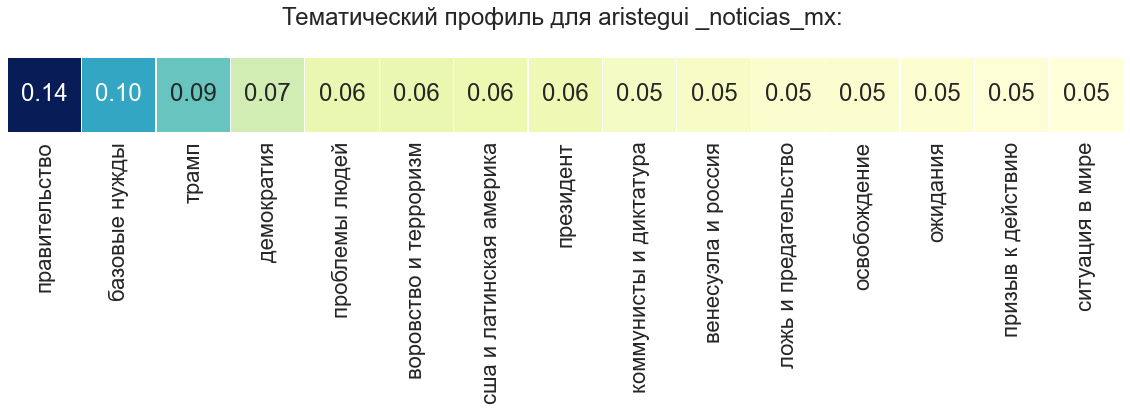

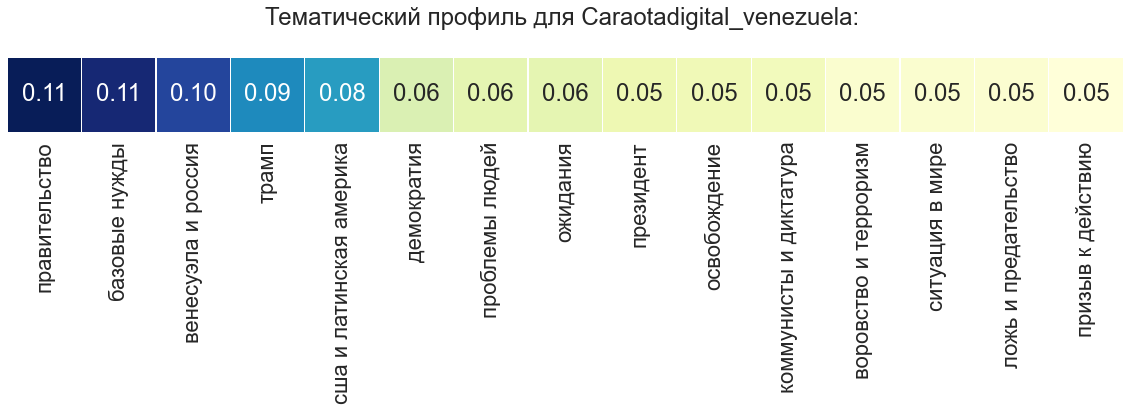

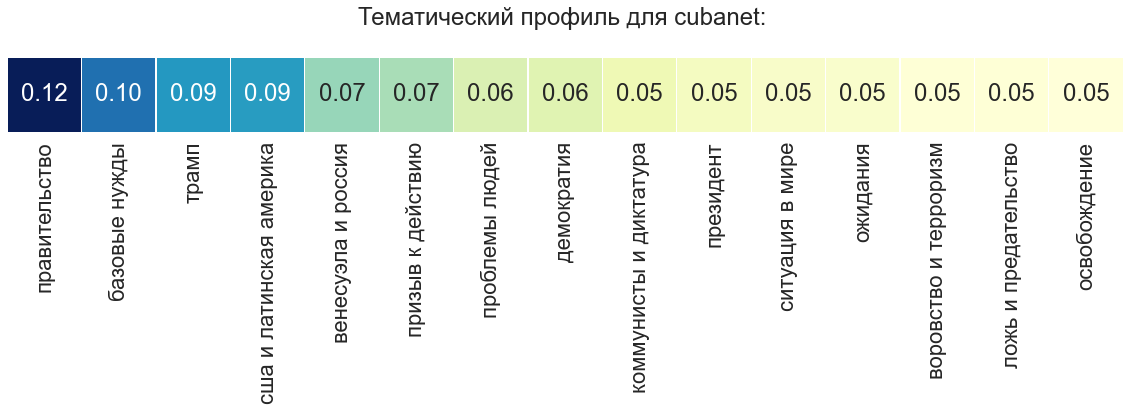

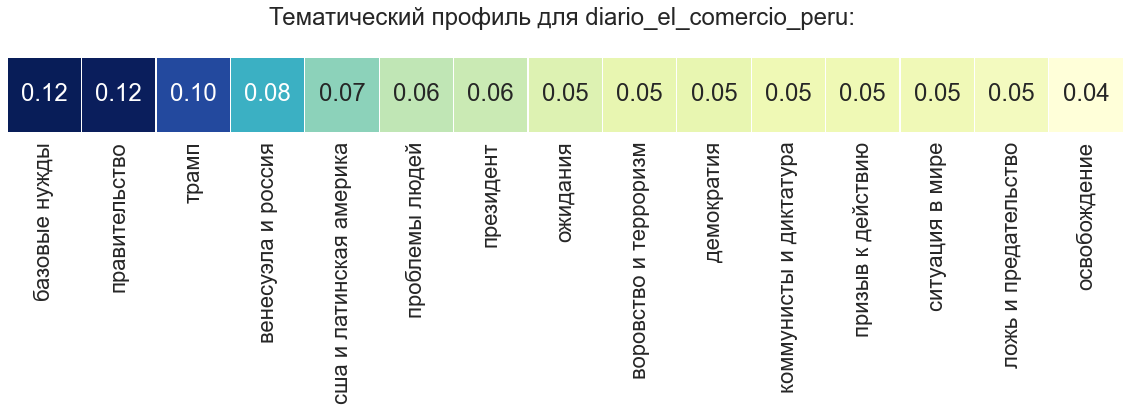

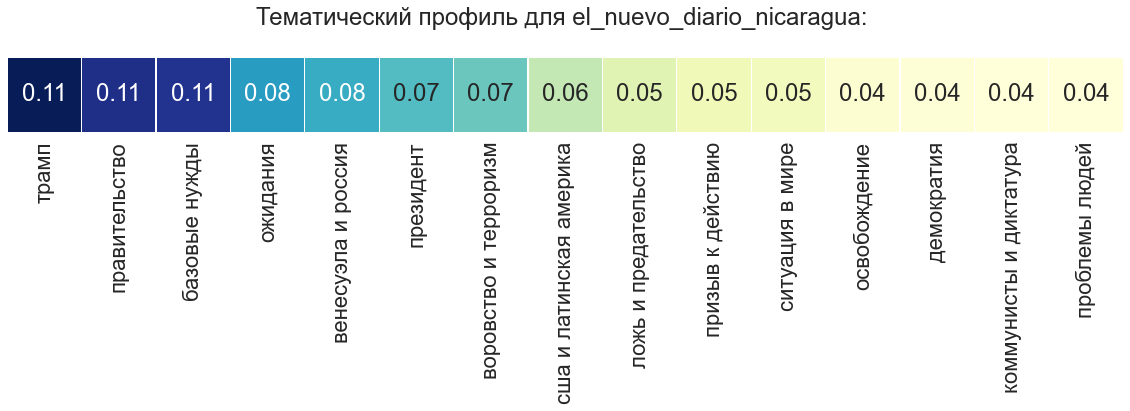

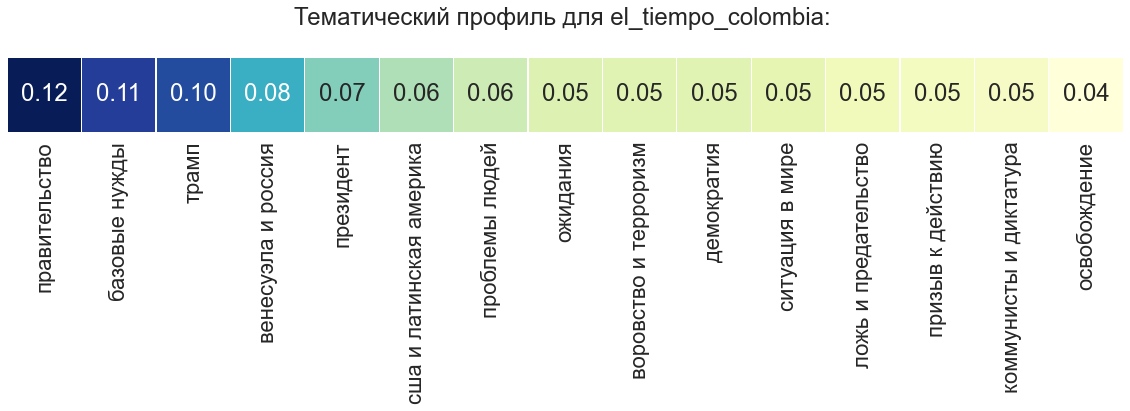

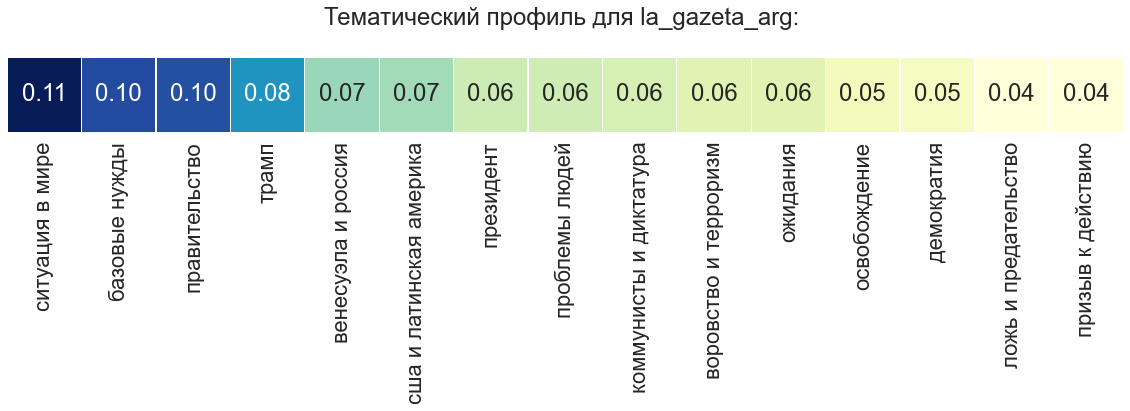

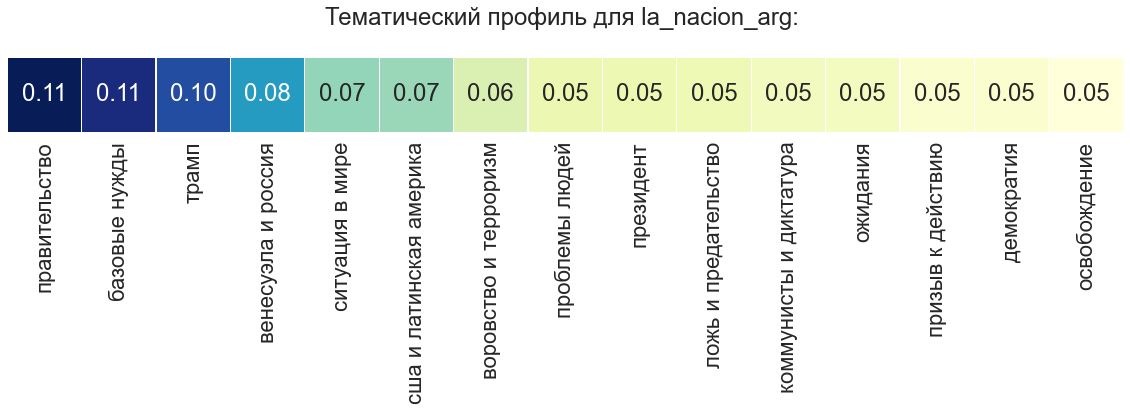

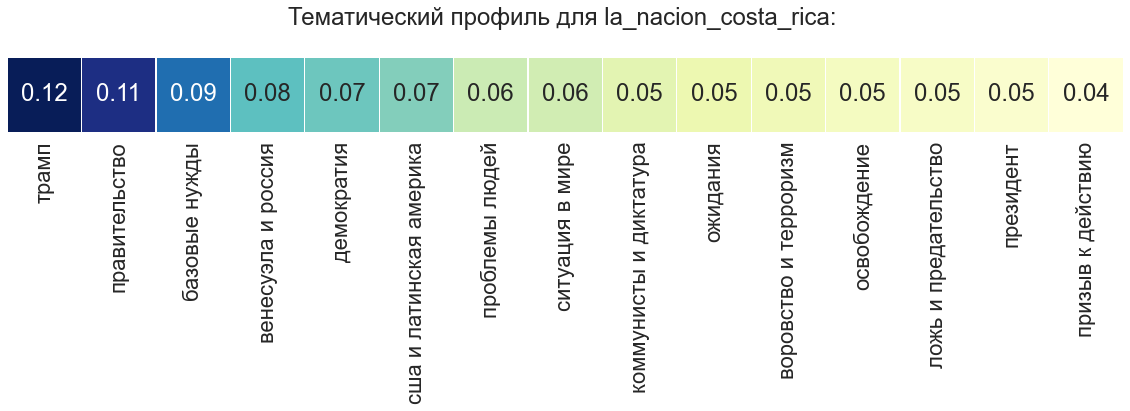

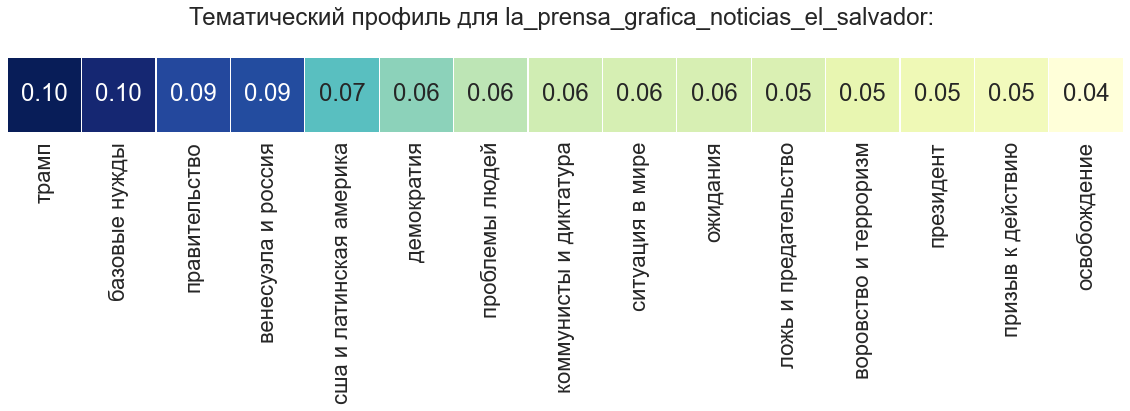

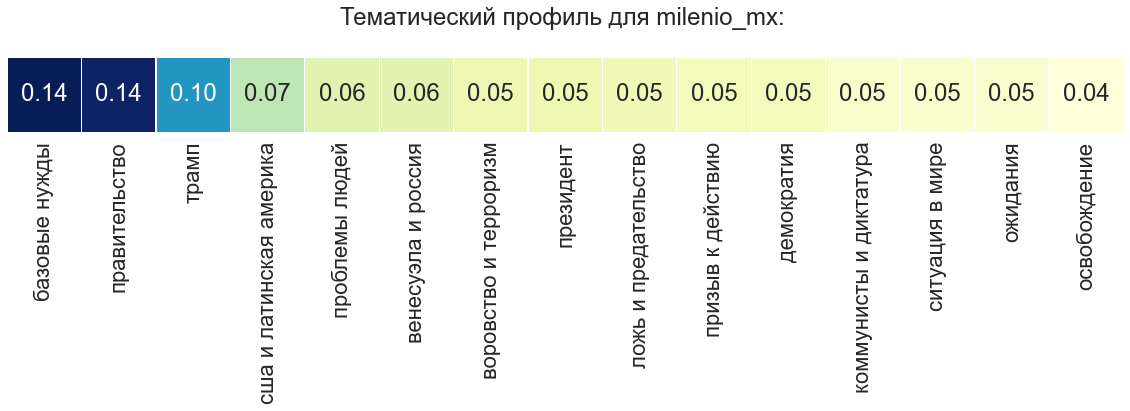

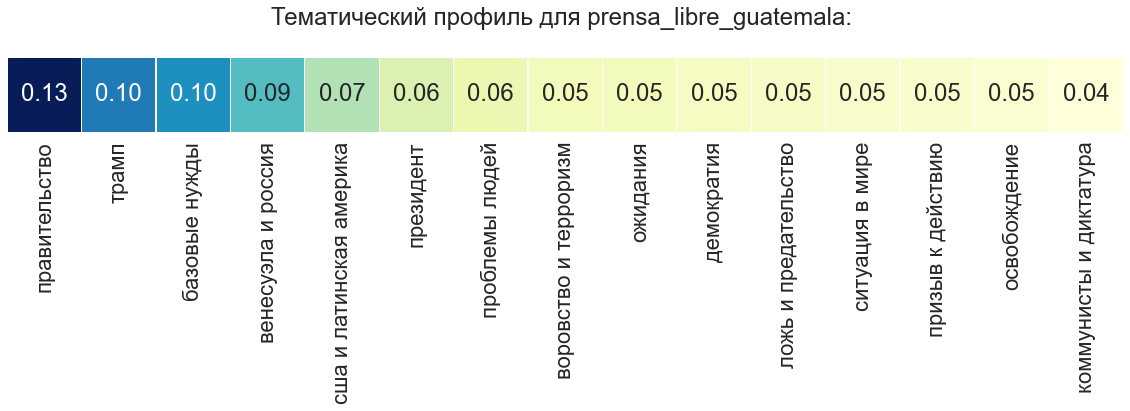

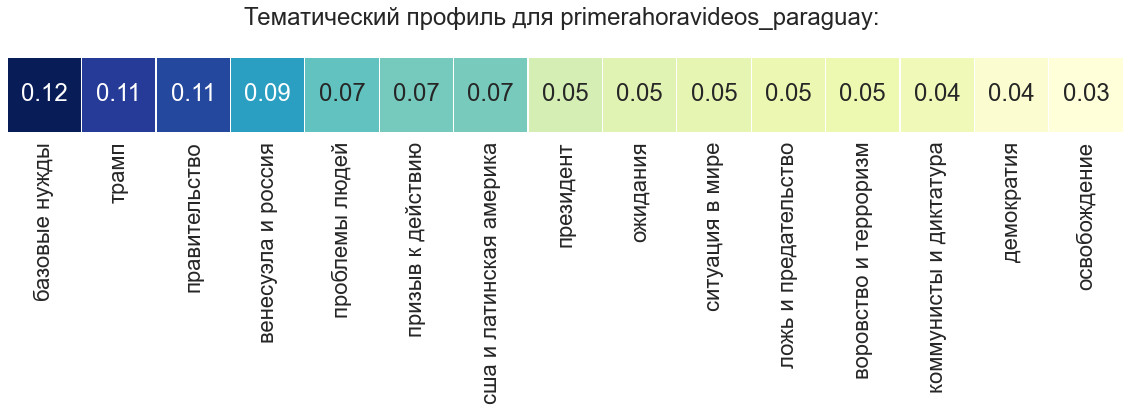

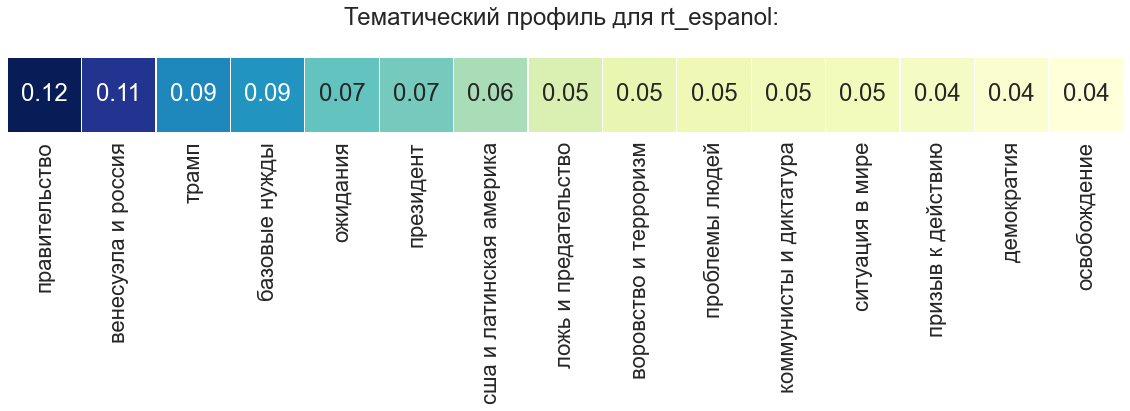

In [43]:
for channel in reduced_data.channel.unique():
    profilePlot(channel_themes, channel)